# Домашнее задание: Multi-Branch MLP для Wine Quality

**Цель**: Реализовать multi-branch модель и добиться F1 score ≥ 40%

**Задачи**:
1. Реализовать три типа блоков: Bottleneck, Inverted Bottleneck, Regular
2. Создать Multi-Branch архитектуру
3. Использовать weighted loss для борьбы с дисбалансом классов
4. Подобрать оптимальные гиперпараметры (глубина, ширина, lr, оптимизатор)

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import sys
sys.path.append('../../lesson3/seminar')
from wine_quality_data import WineQualityDataModule
from lightning_module import BaseLightningModule
from utils import set_seed
from pytorch_lightning import Trainer

sns.set_style('whitegrid')
set_seed(42)

## 1. Загрузка и анализ данных

Загрузим Wine Quality датасет и проанализируем распределение классов.

In [3]:
# Загружаем данные
dm = WineQualityDataModule(batch_size=128)
dm.setup()

print(f'Train samples: {len(dm.train_dataset)}')
print(f'Val samples: {len(dm.val_dataset)}')
print(f'Input dim: {dm.input_dim}')
print(f'Num classes: {dm.n_classes}')

Train samples: 1279
Val samples: 320
Input dim: 11
Num classes: 6


### 1.1. Анализ дисбаланса классов

Проанализируйте распределение классов и вычислите веса для weighted loss.

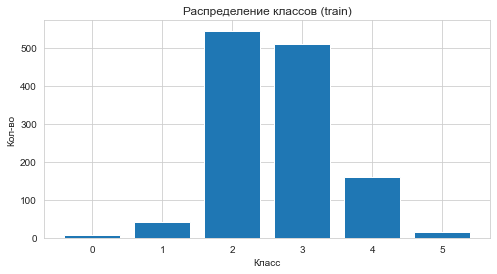

Class weights: [5.        2.2528641 0.6254051 0.646509  1.1578734 3.7697628]


In [4]:
train_labels = np.array([dm.train_dataset[i][1].item() if hasattr(dm.train_dataset[i][1], 'item') else dm.train_dataset[i][1]
                         for i in range(len(dm.train_dataset))])

plt.figure(figsize=(8, 4))
plt.hist(train_labels, bins=np.arange(dm.n_classes + 1) - 0.5, rwidth=0.8)
plt.xticks(range(dm.n_classes))
plt.title('Распределение классов (train)')
plt.xlabel('Класс')
plt.ylabel('Кол-во')
plt.show()


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(dm.n_classes),
    y=train_labels
)



class_weights = class_weights.astype(np.float32)
class_weights = np.sqrt(class_weights)           
class_weights = np.clip(class_weights, 0.5, 5.0) 
print(f'Class weights: {class_weights}')


## 2. Реализация блоков

Реализуйте три типа блоков:
- **Bottleneck**: dim → dim//4 → dim (сужение)
- **Inverted Bottleneck**: dim → dim*4 → dim (расширение)
- **Regular**: dim → hidden_dim → dim (обычный)

In [5]:
from abc import ABC, abstractmethod

class BaseMLPBlock(nn.Module, ABC):
    """Базовый класс для MLP блока"""
    def __init__(self, dim, activation='gelu', dropout=0.0):
        super().__init__()
        self.dim = dim
        self.activation = {'relu': nn.ReLU(), 'gelu': nn.GELU(), 'swish': nn.SiLU()}.get(activation, nn.GELU())
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None
    
    @abstractmethod
    def forward(self, x):
        pass

class BottleneckBlock(BaseMLPBlock):
    """
    Bottleneck блок: dim → dim//4 → dim
    
    Сужает размерность в 4 раза, затем восстанавливает.
    Использует residual connection для стабильного обучения.
    """
    def __init__(self, dim, activation='gelu', dropout=0.0):
        super().__init__(dim, activation, dropout)
        
        # Bottleneck dimension (сужение в 4 раза)
        self.bottleneck_dim = max(dim // 4, 1)
        
        # Линейные слои: dim → bottleneck_dim → dim
        self.fc1 = nn.Linear(self.dim, self.bottleneck_dim)
        self.fc2 = nn.Linear(self.bottleneck_dim, self.dim)
    
    def forward(self, x):
        identity = x
        
        # Bottleneck pathway
        out = self.fc1(x)
        out = self.activation(out)
        if self.dropout:
            out = self.dropout(out)
        out = self.fc2(out)
        
        # Residual connection
        return out + identity

class InvertedBottleneckBlock(BaseMLPBlock):
    """
    Inverted Bottleneck блок: dim → dim*4 → dim
    
    Расширяет размерность в 4 раза, затем сжимает обратно.
    Использует residual connection для стабильного обучения.
    """
    def __init__(self, dim, expansion_factor=4, activation='gelu', dropout=0.0):
        super().__init__(dim, activation, dropout)
        
        # Expanded dimension (расширение в 4 раза)
        self.expanded_dim = dim * expansion_factor
        
        # Линейные слои: dim → expanded_dim → dim
        self.fc1 = nn.Linear(self.dim, self.expanded_dim)
        self.fc2 = nn.Linear(self.expanded_dim, self.dim)
    
    def forward(self, x):
        identity = x
        
        # Inverted bottleneck pathway
        out = self.fc1(x)
        out = self.activation(out)
        if self.dropout:
            out = self.dropout(out)
        out = self.fc2(out)
        
        # Residual connection
        return out + identity

class RegularBlock(BaseMLPBlock):
    """
    Regular блок: dim → hidden_dim → dim
    
    Обычный двухслойный MLP с residual connection.
    hidden_dim по умолчанию равен dim * 2.
    """
    def __init__(self, dim, hidden_dim=None, activation='gelu', dropout=0.0):
        super().__init__(dim, activation, dropout)
        
        # Hidden dimension (по умолчанию в 2 раза больше)
        self.hidden_dim = hidden_dim if hidden_dim else dim * 2
        
        # Линейные слои: dim → hidden_dim → dim
        self.fc1 = nn.Linear(self.dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.dim)
    
    def forward(self, x):
        identity = x
        
        # Regular pathway
        out = self.fc1(x)
        out = self.activation(out)
        if self.dropout:
            out = self.dropout(out)
        out = self.fc2(out)
        
        # Residual connection
        return out + identity

# Тестируем блоки
print('✓ Блоки успешно определены!')
print()

# Проверим размерности
test_x = torch.randn(4, 64)
print('Тестирование блоков с размерностью 64:')
print(f'  Input shape: {test_x.shape}')

bottleneck = BottleneckBlock(64)
print(f'  BottleneckBlock output: {bottleneck(test_x).shape}')

inverted = InvertedBottleneckBlock(64)
print(f'  InvertedBottleneckBlock output: {inverted(test_x).shape}')

regular = RegularBlock(64)
print(f'  RegularBlock output: {regular(test_x).shape}')

# Подсчитаем параметры
print()
print('Количество параметров:')
print(f'  BottleneckBlock: {sum(p.numel() for p in bottleneck.parameters()):,}')
print(f'  InvertedBottleneckBlock: {sum(p.numel() for p in inverted.parameters()):,}')
print(f'  RegularBlock: {sum(p.numel() for p in regular.parameters()):,}')

✓ Блоки успешно определены!

Тестирование блоков с размерностью 64:
  Input shape: torch.Size([4, 64])
  BottleneckBlock output: torch.Size([4, 64])
  InvertedBottleneckBlock output: torch.Size([4, 64])
  RegularBlock output: torch.Size([4, 64])

Количество параметров:
  BottleneckBlock: 2,128
  InvertedBottleneckBlock: 33,088
  RegularBlock: 16,576


## 3. Multi-Branch модель

Реализуйте модель с тремя параллельными ветками.

**Архитектура**:
```
         Input
           |
      projection
           |
      ┌────┼────┐
      │    │    │
  Bottleneck  Inverted  Regular
   Branch      Branch    Branch
      │    │    │
      └────┼────┘
           |
      Concatenate/Sum
           |
      projection
           |
        Output
```

In [6]:
class MultiBranchMLP(nn.Module):
    """
    Multi-Branch MLP с тремя параллельными ветками.

    Args:
        input_dim: размерность входа
        hidden_dim: размерность скрытых слоев (внутреннее представление)
        output_dim: размерность выхода (число классов)
        num_blocks: количество блоков в каждой ветке
        dropout: вероятность dropout
        combine_mode: способ объединения веток ('concat' или 'sum')
    """
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        num_blocks: int = 4,
        dropout: float = 0.0,
        combine_mode: str = 'concat',
        activation: str = 'gelu',
        use_identity_skip: bool = False,
    ):
        super().__init__()

        if combine_mode not in ('concat', 'sum'):
            raise ValueError("combine_mode must be 'concat' or 'sum'")

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim  
        self.num_blocks = num_blocks
        self.dropout = dropout
        self.combine_mode = combine_mode
        self.use_identity_skip = use_identity_skip

        # 1) Входная проекция: input_dim -> hidden_dim
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
        )

        # 2) Три параллельные ветки, каждая состоит из num_blocks блоков
        # Branch 1: Bottleneck
        self.branch1 = nn.Sequential(*[
            BottleneckBlock(hidden_dim, activation=activation, dropout=dropout)
            for _ in range(num_blocks)
        ])

        # Branch 2: Inverted Bottleneck
        self.branch2 = nn.Sequential(*[
            InvertedBottleneckBlock(hidden_dim, expansion_factor=4, activation=activation, dropout=dropout)
            for _ in range(num_blocks)
        ])

        # Branch 3: Regular (dim -> hidden_dim -> dim); чтобы строго соответствовать dim->hidden_dim->dim,
        # передадим hidden_dim=hidden_dim (иначе в RegularBlock по умолчанию dim*2)
        self.branch3 = nn.Sequential(*[
            RegularBlock(hidden_dim, hidden_dim=hidden_dim, activation=activation, dropout=dropout)
            for _ in range(num_blocks)
        ])

        # 3) Выходная проекция после объединения веток
        if combine_mode == 'concat':
            merged_dim = hidden_dim * 3
            if use_identity_skip:
                merged_dim += hidden_dim
        else:  # sum
            merged_dim = hidden_dim

        self.output_proj = nn.Linear(merged_dim, output_dim)

    def forward(self, x):
        # 1. Входная проекция
        h = self.input_proj(x)

        # 2. Пропускаем через каждую ветку
        b1 = self.branch1(h)
        b2 = self.branch2(h)
        b3 = self.branch3(h)

        # 3. Объединяем результаты
        if self.combine_mode == 'concat':
            merged = torch.cat([b1, b2, b3], dim=1)
            if self.use_identity_skip:
                merged = torch.cat([merged, h], dim=1)
        else:  # sum
            merged = b1 + b2 + b3
            if self.use_identity_skip:
                merged = merged + h

        # 4. Выходная проекция в logits
        return self.output_proj(merged)

print('Multi-Branch модель определена!')


Multi-Branch модель определена!


## 4. Код обучение

In [7]:
def train_model(
    model,
    dm,
    class_weights=None,
    max_epochs=50,
    lr=1e-3,
    optimizer_type='adam',
    optimizer_kwargs=None,
    early_stopping=True,
    patience=10
):
    """
    Обучает модель с weighted loss.
    
    Args:
        model: модель для обучения
        dm: DataModule
        class_weights: веса классов для weighted loss (numpy array или None)
        max_epochs: количество эпох
        lr: learning rate
        optimizer_type: тип оптимизатора ('adam', 'adamw', 'sgd')
    
    Returns:
        dict с метриками
    """
    # TODO: Создайте loss function
    # Если class_weights не None, используйте nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))
    # Иначе используйте обычный nn.CrossEntropyLoss()
    if class_weights is not None:
        loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32))
    else:
        loss_fn = nn.CrossEntropyLoss()
    
    lightning_model = BaseLightningModule(
        model=model,
        loss_fn=loss_fn,
        optimizer_type=optimizer_type,
        learning_rate=lr,
        task_type='multiclass',
        metrics_to_log=['accuracy', 'f1_macro']
    )
    
    
    # Early stopping по F1_macro на валидации (часто помогает не переобучаться и найти лучшую эпоху)
    callbacks = []
    if early_stopping:
        from pytorch_lightning.callbacks import EarlyStopping
        callbacks.append(EarlyStopping(monitor='val_f1_macro', mode='max', patience=patience))

    trainer = Trainer(
        max_epochs=max_epochs,
        enable_checkpointing=False,
        logger=False,
        enable_progress_bar=True,
        enable_model_summary=False,
        callbacks=callbacks
    )
    trainer.fit(lightning_model, dm)
    
    metrics = trainer.callback_metrics
    return {
        'val_acc': metrics.get('val_accuracy', 0).item(),
        'val_f1': metrics.get('val_f1_macro', 0).item()
    }

## 5. Итоговая модель

Обучите модель с лучшими гиперпараметрами.

In [29]:
# Обучите итоговую модель с лучшими гиперпараметрами.
best_hidden_dim = 256
best_depth = 6
best_lr = 3e-4
best_optimizer = 'adamw'

final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.3,
    combine_mode='sum'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=100,
    lr=best_lr,
    optimizer_type=best_optimizer,
    optimizer_kwargs={'weight_decay': 1e-2},
    early_stopping=True,
    patience=12
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score (macro): {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Sanity Checking: |                                                                               | 0/? [00:00<…

Epoch 0: accuracy=0.0586, f1_macro=0.0528


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Epoch 0: accuracy=0.2135, f1_macro=0.1385


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1: accuracy=0.2578, f1_macro=0.1690


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2: accuracy=0.3183, f1_macro=0.2049


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3: accuracy=0.3275, f1_macro=0.2125


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4: accuracy=0.3464, f1_macro=0.2206


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5: accuracy=0.3539, f1_macro=0.2252


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6: accuracy=0.3654, f1_macro=0.2318


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7: accuracy=0.3683, f1_macro=0.2321


Validation: |                                                                                    | 0/? [00:00<…

Epoch 8: accuracy=0.3744, f1_macro=0.2364


Validation: |                                                                                    | 0/? [00:00<…

Epoch 9: accuracy=0.3756, f1_macro=0.2383


Validation: |                                                                                    | 0/? [00:00<…

Epoch 10: accuracy=0.3853, f1_macro=0.2438


Validation: |                                                                                    | 0/? [00:00<…

Epoch 11: accuracy=0.3845, f1_macro=0.2446


Validation: |                                                                                    | 0/? [00:00<…

Epoch 12: accuracy=0.3904, f1_macro=0.2477


Validation: |                                                                                    | 0/? [00:00<…

Epoch 13: accuracy=0.3932, f1_macro=0.2489


Validation: |                                                                                    | 0/? [00:00<…

Epoch 14: accuracy=0.3979, f1_macro=0.2524


Validation: |                                                                                    | 0/? [00:00<…

Epoch 15: accuracy=0.3973, f1_macro=0.2523


Validation: |                                                                                    | 0/? [00:00<…

Epoch 16: accuracy=0.4020, f1_macro=0.2555


Validation: |                                                                                    | 0/? [00:00<…

Epoch 17: accuracy=0.4071, f1_macro=0.2581


Validation: |                                                                                    | 0/? [00:00<…

Epoch 18: accuracy=0.4092, f1_macro=0.2595


Validation: |                                                                                    | 0/? [00:00<…

Epoch 19: accuracy=0.4106, f1_macro=0.2605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 20: accuracy=0.4150, f1_macro=0.2627


Validation: |                                                                                    | 0/? [00:00<…

Epoch 21: accuracy=0.4158, f1_macro=0.2639


Validation: |                                                                                    | 0/? [00:00<…

Epoch 22: accuracy=0.4187, f1_macro=0.2655


Validation: |                                                                                    | 0/? [00:00<…

Epoch 23: accuracy=0.4211, f1_macro=0.2666


Validation: |                                                                                    | 0/? [00:00<…

Epoch 24: accuracy=0.4222, f1_macro=0.2671


Validation: |                                                                                    | 0/? [00:00<…

Epoch 25: accuracy=0.4235, f1_macro=0.2679


Validation: |                                                                                    | 0/? [00:00<…

Epoch 26: accuracy=0.4236, f1_macro=0.2678


Validation: |                                                                                    | 0/? [00:00<…

Epoch 27: accuracy=0.4264, f1_macro=0.2692


Validation: |                                                                                    | 0/? [00:00<…

Epoch 28: accuracy=0.4304, f1_macro=0.2716


Validation: |                                                                                    | 0/? [00:00<…

Epoch 29: accuracy=0.4336, f1_macro=0.2734


Validation: |                                                                                    | 0/? [00:00<…

Epoch 30: accuracy=0.4330, f1_macro=0.2731


Validation: |                                                                                    | 0/? [00:00<…

Epoch 31: accuracy=0.4344, f1_macro=0.2737


Validation: |                                                                                    | 0/? [00:00<…

Epoch 32: accuracy=0.4357, f1_macro=0.2748


Validation: |                                                                                    | 0/? [00:00<…

Epoch 33: accuracy=0.4391, f1_macro=0.2761


Validation: |                                                                                    | 0/? [00:00<…

Epoch 34: accuracy=0.4412, f1_macro=0.2775


Validation: |                                                                                    | 0/? [00:00<…

Epoch 35: accuracy=0.4419, f1_macro=0.2784


Validation: |                                                                                    | 0/? [00:00<…

Epoch 36: accuracy=0.4446, f1_macro=0.2801


Validation: |                                                                                    | 0/? [00:00<…

Epoch 37: accuracy=0.4468, f1_macro=0.2814


Validation: |                                                                                    | 0/? [00:00<…

Epoch 38: accuracy=0.4491, f1_macro=0.2828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 39: accuracy=0.4512, f1_macro=0.2838


Validation: |                                                                                    | 0/? [00:00<…

Epoch 40: accuracy=0.4542, f1_macro=0.2858


Validation: |                                                                                    | 0/? [00:00<…

Epoch 41: accuracy=0.4566, f1_macro=0.2872


Validation: |                                                                                    | 0/? [00:00<…

Epoch 42: accuracy=0.4588, f1_macro=0.2886


Validation: |                                                                                    | 0/? [00:00<…

Epoch 43: accuracy=0.4607, f1_macro=0.2896


Validation: |                                                                                    | 0/? [00:00<…

Epoch 44: accuracy=0.4627, f1_macro=0.2909


Validation: |                                                                                    | 0/? [00:00<…

Epoch 45: accuracy=0.4650, f1_macro=0.2920


Validation: |                                                                                    | 0/? [00:00<…

Epoch 46: accuracy=0.4669, f1_macro=0.2929


Validation: |                                                                                    | 0/? [00:00<…

Epoch 47: accuracy=0.4694, f1_macro=0.2943


Validation: |                                                                                    | 0/? [00:00<…

Epoch 48: accuracy=0.4711, f1_macro=0.2954


Validation: |                                                                                    | 0/? [00:00<…

Epoch 49: accuracy=0.4732, f1_macro=0.2965


Validation: |                                                                                    | 0/? [00:00<…

Epoch 50: accuracy=0.4747, f1_macro=0.2975


Validation: |                                                                                    | 0/? [00:00<…

Epoch 51: accuracy=0.4767, f1_macro=0.2986


Validation: |                                                                                    | 0/? [00:00<…

Epoch 52: accuracy=0.4786, f1_macro=0.2996


Validation: |                                                                                    | 0/? [00:00<…

Epoch 53: accuracy=0.4799, f1_macro=0.3007


Validation: |                                                                                    | 0/? [00:00<…

Epoch 54: accuracy=0.4820, f1_macro=0.3018


Validation: |                                                                                    | 0/? [00:00<…

Epoch 55: accuracy=0.4835, f1_macro=0.3024


Validation: |                                                                                    | 0/? [00:00<…

Epoch 56: accuracy=0.4853, f1_macro=0.3034


Validation: |                                                                                    | 0/? [00:00<…

Epoch 57: accuracy=0.4869, f1_macro=0.3042


Validation: |                                                                                    | 0/? [00:00<…

Epoch 58: accuracy=0.4885, f1_macro=0.3051


Validation: |                                                                                    | 0/? [00:00<…

Epoch 59: accuracy=0.4902, f1_macro=0.3062


Validation: |                                                                                    | 0/? [00:00<…

Epoch 60: accuracy=0.4916, f1_macro=0.3068


Validation: |                                                                                    | 0/? [00:00<…

Epoch 61: accuracy=0.4927, f1_macro=0.3078


Validation: |                                                                                    | 0/? [00:00<…

Epoch 62: accuracy=0.4941, f1_macro=0.3085


Validation: |                                                                                    | 0/? [00:00<…

Epoch 63: accuracy=0.4954, f1_macro=0.3094


Validation: |                                                                                    | 0/? [00:00<…

Epoch 64: accuracy=0.4973, f1_macro=0.3104


Validation: |                                                                                    | 0/? [00:00<…

Epoch 65: accuracy=0.4988, f1_macro=0.3112


Validation: |                                                                                    | 0/? [00:00<…

Epoch 66: accuracy=0.5004, f1_macro=0.3119


Validation: |                                                                                    | 0/? [00:00<…

Epoch 67: accuracy=0.5019, f1_macro=0.3126


Validation: |                                                                                    | 0/? [00:00<…

Epoch 68: accuracy=0.5034, f1_macro=0.3133


Validation: |                                                                                    | 0/? [00:00<…

Epoch 69: accuracy=0.5047, f1_macro=0.3139


Validation: |                                                                                    | 0/? [00:00<…

Epoch 70: accuracy=0.5055, f1_macro=0.3145


Validation: |                                                                                    | 0/? [00:00<…

Epoch 71: accuracy=0.5072, f1_macro=0.3153


Validation: |                                                                                    | 0/? [00:00<…

Epoch 72: accuracy=0.5082, f1_macro=0.3159


Validation: |                                                                                    | 0/? [00:00<…

Epoch 73: accuracy=0.5094, f1_macro=0.3165


Validation: |                                                                                    | 0/? [00:00<…

Epoch 74: accuracy=0.5106, f1_macro=0.3171


Validation: |                                                                                    | 0/? [00:00<…

Epoch 75: accuracy=0.5111, f1_macro=0.3173


Validation: |                                                                                    | 0/? [00:00<…

Epoch 76: accuracy=0.5117, f1_macro=0.3175


Validation: |                                                                                    | 0/? [00:00<…

Epoch 77: accuracy=0.5126, f1_macro=0.3179


Validation: |                                                                                    | 0/? [00:00<…

Epoch 78: accuracy=0.5138, f1_macro=0.3186


Validation: |                                                                                    | 0/? [00:00<…

Epoch 79: accuracy=0.5148, f1_macro=0.3190


Validation: |                                                                                    | 0/? [00:00<…

Epoch 80: accuracy=0.5157, f1_macro=0.3197


Validation: |                                                                                    | 0/? [00:00<…

Epoch 81: accuracy=0.5164, f1_macro=0.3202


Validation: |                                                                                    | 0/? [00:00<…

Epoch 82: accuracy=0.5175, f1_macro=0.3206


Validation: |                                                                                    | 0/? [00:00<…

Epoch 83: accuracy=0.5182, f1_macro=0.3210


Validation: |                                                                                    | 0/? [00:00<…

Epoch 84: accuracy=0.5194, f1_macro=0.3215


Validation: |                                                                                    | 0/? [00:00<…

Epoch 85: accuracy=0.5206, f1_macro=0.3221


Validation: |                                                                                    | 0/? [00:00<…

Epoch 86: accuracy=0.5218, f1_macro=0.3227


Validation: |                                                                                    | 0/? [00:00<…

Epoch 87: accuracy=0.5229, f1_macro=0.3233


Validation: |                                                                                    | 0/? [00:00<…

Epoch 88: accuracy=0.5240, f1_macro=0.3238


Validation: |                                                                                    | 0/? [00:00<…

Epoch 89: accuracy=0.5253, f1_macro=0.3243


Validation: |                                                                                    | 0/? [00:00<…

Epoch 90: accuracy=0.5265, f1_macro=0.3249


Validation: |                                                                                    | 0/? [00:00<…

Epoch 91: accuracy=0.5275, f1_macro=0.3254


Validation: |                                                                                    | 0/? [00:00<…

Epoch 92: accuracy=0.5283, f1_macro=0.3258


Validation: |                                                                                    | 0/? [00:00<…

Epoch 93: accuracy=0.5284, f1_macro=0.3260


Validation: |                                                                                    | 0/? [00:00<…

Epoch 94: accuracy=0.5280, f1_macro=0.3263


Validation: |                                                                                    | 0/? [00:00<…

Epoch 95: accuracy=0.5283, f1_macro=0.3265


Validation: |                                                                                    | 0/? [00:00<…

Epoch 96: accuracy=0.5291, f1_macro=0.3270


Validation: |                                                                                    | 0/? [00:00<…

Epoch 97: accuracy=0.5297, f1_macro=0.3277


Validation: |                                                                                    | 0/? [00:00<…

Epoch 98: accuracy=0.5301, f1_macro=0.3280


Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: accuracy=0.5302, f1_macro=0.3282

=== Итоговые результаты ===
F1 score (macro): 0.3282
Accuracy: 0.5302


In [18]:
# Обучите итоговую модель с лучшими гиперпараметрами.
best_hidden_dim = 256
best_depth = 8
best_lr = 1e-3
best_optimizer = 'adamw'

final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=100,
    lr=best_lr,
    optimizer_type=best_optimizer,
    optimizer_kwargs={'weight_decay': 1e-2},
    early_stopping=True,
    patience=12
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score (macro): {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Sanity Checking: |                                                                               | 0/? [00:00<…

Epoch 0: accuracy=0.1055, f1_macro=0.0801


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Epoch 0: accuracy=0.3681, f1_macro=0.2491


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1: accuracy=0.4241, f1_macro=0.2675


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2: accuracy=0.4663, f1_macro=0.2841


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3: accuracy=0.4941, f1_macro=0.2958


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4: accuracy=0.5075, f1_macro=0.2994


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5: accuracy=0.5138, f1_macro=0.2997


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6: accuracy=0.5200, f1_macro=0.3009


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7: accuracy=0.5231, f1_macro=0.3014


Validation: |                                                                                    | 0/? [00:00<…

Epoch 8: accuracy=0.5268, f1_macro=0.3045


Validation: |                                                                                    | 0/? [00:00<…

Epoch 9: accuracy=0.5318, f1_macro=0.3070


Validation: |                                                                                    | 0/? [00:00<…

Epoch 10: accuracy=0.5360, f1_macro=0.3071


Validation: |                                                                                    | 0/? [00:00<…

Epoch 11: accuracy=0.5420, f1_macro=0.3090


Validation: |                                                                                    | 0/? [00:00<…

Epoch 12: accuracy=0.5374, f1_macro=0.3071


Validation: |                                                                                    | 0/? [00:00<…

Epoch 13: accuracy=0.5367, f1_macro=0.3067


Validation: |                                                                                    | 0/? [00:00<…

Epoch 14: accuracy=0.5403, f1_macro=0.3075


Validation: |                                                                                    | 0/? [00:00<…

Epoch 15: accuracy=0.5409, f1_macro=0.3070


Validation: |                                                                                    | 0/? [00:00<…

Epoch 16: accuracy=0.5425, f1_macro=0.3066


Validation: |                                                                                    | 0/? [00:00<…

Epoch 17: accuracy=0.5434, f1_macro=0.3060


Validation: |                                                                                    | 0/? [00:00<…

Epoch 18: accuracy=0.5399, f1_macro=0.3071


Validation: |                                                                                    | 0/? [00:00<…

Epoch 19: accuracy=0.5433, f1_macro=0.3085


Validation: |                                                                                    | 0/? [00:00<…

Epoch 20: accuracy=0.5446, f1_macro=0.3097


Validation: |                                                                                    | 0/? [00:00<…

Epoch 21: accuracy=0.5482, f1_macro=0.3110


Validation: |                                                                                    | 0/? [00:00<…

Epoch 22: accuracy=0.5466, f1_macro=0.3099


Validation: |                                                                                    | 0/? [00:00<…

Epoch 23: accuracy=0.5465, f1_macro=0.3105


Validation: |                                                                                    | 0/? [00:00<…

Epoch 24: accuracy=0.5459, f1_macro=0.3103


Validation: |                                                                                    | 0/? [00:00<…

Epoch 25: accuracy=0.5470, f1_macro=0.3110


Validation: |                                                                                    | 0/? [00:00<…

Epoch 26: accuracy=0.5482, f1_macro=0.3122


Validation: |                                                                                    | 0/? [00:00<…

Epoch 27: accuracy=0.5488, f1_macro=0.3133


Validation: |                                                                                    | 0/? [00:00<…

Epoch 28: accuracy=0.5500, f1_macro=0.3149


Validation: |                                                                                    | 0/? [00:00<…

Epoch 29: accuracy=0.5495, f1_macro=0.3140


Validation: |                                                                                    | 0/? [00:00<…

Epoch 30: accuracy=0.5497, f1_macro=0.3143


Validation: |                                                                                    | 0/? [00:00<…

Epoch 31: accuracy=0.5503, f1_macro=0.3150


Validation: |                                                                                    | 0/? [00:00<…

Epoch 32: accuracy=0.5503, f1_macro=0.3152


Validation: |                                                                                    | 0/? [00:00<…

Epoch 33: accuracy=0.5513, f1_macro=0.3160


Validation: |                                                                                    | 0/? [00:00<…

Epoch 34: accuracy=0.5520, f1_macro=0.3167


Validation: |                                                                                    | 0/? [00:00<…

Epoch 35: accuracy=0.5531, f1_macro=0.3172


Validation: |                                                                                    | 0/? [00:00<…

Epoch 36: accuracy=0.5546, f1_macro=0.3184


Validation: |                                                                                    | 0/? [00:00<…

Epoch 37: accuracy=0.5556, f1_macro=0.3192


Validation: |                                                                                    | 0/? [00:00<…

Epoch 38: accuracy=0.5567, f1_macro=0.3201


Validation: |                                                                                    | 0/? [00:00<…

Epoch 39: accuracy=0.5574, f1_macro=0.3213


Validation: |                                                                                    | 0/? [00:00<…

Epoch 40: accuracy=0.5579, f1_macro=0.3222


Validation: |                                                                                    | 0/? [00:00<…

Epoch 41: accuracy=0.5587, f1_macro=0.3232


Validation: |                                                                                    | 0/? [00:00<…

Epoch 42: accuracy=0.5593, f1_macro=0.3234


Validation: |                                                                                    | 0/? [00:00<…

Epoch 43: accuracy=0.5603, f1_macro=0.3234


Validation: |                                                                                    | 0/? [00:00<…

Epoch 44: accuracy=0.5609, f1_macro=0.3238


Validation: |                                                                                    | 0/? [00:00<…

Epoch 45: accuracy=0.5628, f1_macro=0.3244


Validation: |                                                                                    | 0/? [00:00<…

Epoch 46: accuracy=0.5635, f1_macro=0.3249


Validation: |                                                                                    | 0/? [00:00<…

Epoch 47: accuracy=0.5643, f1_macro=0.3257


Validation: |                                                                                    | 0/? [00:00<…

Epoch 48: accuracy=0.5652, f1_macro=0.3264


Validation: |                                                                                    | 0/? [00:00<…

Epoch 49: accuracy=0.5659, f1_macro=0.3273


Validation: |                                                                                    | 0/? [00:00<…

Epoch 50: accuracy=0.5670, f1_macro=0.3284


Validation: |                                                                                    | 0/? [00:00<…

Epoch 51: accuracy=0.5684, f1_macro=0.3288


Validation: |                                                                                    | 0/? [00:00<…

Epoch 52: accuracy=0.5690, f1_macro=0.3296


Validation: |                                                                                    | 0/? [00:00<…

Epoch 53: accuracy=0.5700, f1_macro=0.3302


Validation: |                                                                                    | 0/? [00:00<…

Epoch 54: accuracy=0.5711, f1_macro=0.3310


Validation: |                                                                                    | 0/? [00:00<…

Epoch 55: accuracy=0.5717, f1_macro=0.3319


Validation: |                                                                                    | 0/? [00:00<…

Epoch 56: accuracy=0.5726, f1_macro=0.3324


Validation: |                                                                                    | 0/? [00:00<…

Epoch 57: accuracy=0.5731, f1_macro=0.3327


Validation: |                                                                                    | 0/? [00:00<…

Epoch 58: accuracy=0.5734, f1_macro=0.3331


Validation: |                                                                                    | 0/? [00:00<…

Epoch 59: accuracy=0.5744, f1_macro=0.3336


Validation: |                                                                                    | 0/? [00:00<…

Epoch 60: accuracy=0.5748, f1_macro=0.3343


Validation: |                                                                                    | 0/? [00:00<…

Epoch 61: accuracy=0.5755, f1_macro=0.3349


Validation: |                                                                                    | 0/? [00:00<…

Epoch 62: accuracy=0.5759, f1_macro=0.3353


Validation: |                                                                                    | 0/? [00:00<…

Epoch 63: accuracy=0.5764, f1_macro=0.3359


Validation: |                                                                                    | 0/? [00:00<…

Epoch 64: accuracy=0.5775, f1_macro=0.3364


Validation: |                                                                                    | 0/? [00:00<…

Epoch 65: accuracy=0.5784, f1_macro=0.3371


Validation: |                                                                                    | 0/? [00:00<…

Epoch 66: accuracy=0.5789, f1_macro=0.3375


Validation: |                                                                                    | 0/? [00:00<…

Epoch 67: accuracy=0.5798, f1_macro=0.3375


Validation: |                                                                                    | 0/? [00:00<…

Epoch 68: accuracy=0.5801, f1_macro=0.3379


Validation: |                                                                                    | 0/? [00:00<…

Epoch 69: accuracy=0.5804, f1_macro=0.3381


Validation: |                                                                                    | 0/? [00:00<…

Epoch 70: accuracy=0.5809, f1_macro=0.3384


Validation: |                                                                                    | 0/? [00:00<…

Epoch 71: accuracy=0.5812, f1_macro=0.3389


Validation: |                                                                                    | 0/? [00:00<…

Epoch 72: accuracy=0.5819, f1_macro=0.3398


Validation: |                                                                                    | 0/? [00:00<…

Epoch 73: accuracy=0.5824, f1_macro=0.3400


Validation: |                                                                                    | 0/? [00:00<…

Epoch 74: accuracy=0.5826, f1_macro=0.3401


Validation: |                                                                                    | 0/? [00:00<…

Epoch 75: accuracy=0.5829, f1_macro=0.3403


Validation: |                                                                                    | 0/? [00:00<…

Epoch 76: accuracy=0.5833, f1_macro=0.3405


Validation: |                                                                                    | 0/? [00:00<…

Epoch 77: accuracy=0.5835, f1_macro=0.3408


Validation: |                                                                                    | 0/? [00:00<…

Epoch 78: accuracy=0.5838, f1_macro=0.3414


Validation: |                                                                                    | 0/? [00:00<…

Epoch 79: accuracy=0.5842, f1_macro=0.3416


Validation: |                                                                                    | 0/? [00:00<…

Epoch 80: accuracy=0.5846, f1_macro=0.3420


Validation: |                                                                                    | 0/? [00:00<…

Epoch 81: accuracy=0.5847, f1_macro=0.3423


Validation: |                                                                                    | 0/? [00:00<…

Epoch 82: accuracy=0.5849, f1_macro=0.3423


Validation: |                                                                                    | 0/? [00:00<…

Epoch 83: accuracy=0.5853, f1_macro=0.3425


Validation: |                                                                                    | 0/? [00:00<…

Epoch 84: accuracy=0.5858, f1_macro=0.3426


Validation: |                                                                                    | 0/? [00:00<…

Epoch 85: accuracy=0.5861, f1_macro=0.3429


Validation: |                                                                                    | 0/? [00:00<…

Epoch 86: accuracy=0.5864, f1_macro=0.3432


Validation: |                                                                                    | 0/? [00:00<…

Epoch 87: accuracy=0.5864, f1_macro=0.3432


Validation: |                                                                                    | 0/? [00:00<…

Epoch 88: accuracy=0.5863, f1_macro=0.3432


Validation: |                                                                                    | 0/? [00:00<…

Epoch 89: accuracy=0.5866, f1_macro=0.3434


Validation: |                                                                                    | 0/? [00:00<…

Epoch 90: accuracy=0.5869, f1_macro=0.3436


Validation: |                                                                                    | 0/? [00:00<…

Epoch 91: accuracy=0.5872, f1_macro=0.3439


Validation: |                                                                                    | 0/? [00:00<…

Epoch 92: accuracy=0.5874, f1_macro=0.3440


Validation: |                                                                                    | 0/? [00:00<…

Epoch 93: accuracy=0.5875, f1_macro=0.3440


Validation: |                                                                                    | 0/? [00:00<…

Epoch 94: accuracy=0.5876, f1_macro=0.3440


Validation: |                                                                                    | 0/? [00:00<…

Epoch 95: accuracy=0.5878, f1_macro=0.3442


Validation: |                                                                                    | 0/? [00:00<…

Epoch 96: accuracy=0.5883, f1_macro=0.3445


Validation: |                                                                                    | 0/? [00:00<…

Epoch 97: accuracy=0.5887, f1_macro=0.3449


Validation: |                                                                                    | 0/? [00:00<…

Epoch 98: accuracy=0.5893, f1_macro=0.3454


Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: accuracy=0.5897, f1_macro=0.3457

=== Итоговые результаты ===
F1 score (macro): 0.3457
Accuracy: 0.5897


In [20]:
# Обучите итоговую модель с лучшими гиперпараметрами.
best_hidden_dim = 256
best_depth = 8
best_lr = 1e-3
best_optimizer = 'adamw'

final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=100,
    lr=best_lr,
    optimizer_type=best_optimizer,
    optimizer_kwargs={'weight_decay': 1e-3},
    early_stopping=True,
    patience=12
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score (macro): {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Sanity Checking: |                                                                               | 0/? [00:00<…

Epoch 0: accuracy=0.0938, f1_macro=0.0983


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Epoch 0: accuracy=0.3333, f1_macro=0.2258


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1: accuracy=0.3973, f1_macro=0.2374


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2: accuracy=0.4334, f1_macro=0.2537


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3: accuracy=0.4544, f1_macro=0.2704


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4: accuracy=0.4763, f1_macro=0.2817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5: accuracy=0.4830, f1_macro=0.2817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6: accuracy=0.4964, f1_macro=0.2913


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7: accuracy=0.5075, f1_macro=0.2956


Validation: |                                                                                    | 0/? [00:00<…

Epoch 8: accuracy=0.5124, f1_macro=0.2982


Validation: |                                                                                    | 0/? [00:00<…

Epoch 9: accuracy=0.5136, f1_macro=0.2973


Validation: |                                                                                    | 0/? [00:00<…

Epoch 10: accuracy=0.5151, f1_macro=0.2979


Validation: |                                                                                    | 0/? [00:00<…

Epoch 11: accuracy=0.5181, f1_macro=0.2978


Validation: |                                                                                    | 0/? [00:00<…

Epoch 12: accuracy=0.5190, f1_macro=0.2970


Validation: |                                                                                    | 0/? [00:00<…

Epoch 13: accuracy=0.5241, f1_macro=0.2992


Validation: |                                                                                    | 0/? [00:00<…

Epoch 14: accuracy=0.5259, f1_macro=0.3011


Validation: |                                                                                    | 0/? [00:00<…

Epoch 15: accuracy=0.5279, f1_macro=0.3018


Validation: |                                                                                    | 0/? [00:00<…

Epoch 16: accuracy=0.5305, f1_macro=0.3032


Validation: |                                                                                    | 0/? [00:00<…

Epoch 17: accuracy=0.5339, f1_macro=0.3058


Validation: |                                                                                    | 0/? [00:00<…

Epoch 18: accuracy=0.5352, f1_macro=0.3070


Validation: |                                                                                    | 0/? [00:00<…

Epoch 19: accuracy=0.5364, f1_macro=0.3088


Validation: |                                                                                    | 0/? [00:00<…

Epoch 20: accuracy=0.5367, f1_macro=0.3097


Validation: |                                                                                    | 0/? [00:00<…

Epoch 21: accuracy=0.5404, f1_macro=0.3123


Validation: |                                                                                    | 0/? [00:00<…

Epoch 22: accuracy=0.5432, f1_macro=0.3149


Validation: |                                                                                    | 0/? [00:00<…

Epoch 23: accuracy=0.5446, f1_macro=0.3165


Validation: |                                                                                    | 0/? [00:00<…

Epoch 24: accuracy=0.5470, f1_macro=0.3185


Validation: |                                                                                    | 0/? [00:00<…

Epoch 25: accuracy=0.5468, f1_macro=0.3181


Validation: |                                                                                    | 0/? [00:00<…

Epoch 26: accuracy=0.5474, f1_macro=0.3196


Validation: |                                                                                    | 0/? [00:00<…

Epoch 27: accuracy=0.5488, f1_macro=0.3207


Validation: |                                                                                    | 0/? [00:00<…

Epoch 28: accuracy=0.5501, f1_macro=0.3218


Validation: |                                                                                    | 0/? [00:00<…

Epoch 29: accuracy=0.5507, f1_macro=0.3226


Validation: |                                                                                    | 0/? [00:00<…

Epoch 30: accuracy=0.5521, f1_macro=0.3239


Validation: |                                                                                    | 0/? [00:00<…

Epoch 31: accuracy=0.5518, f1_macro=0.3239


Validation: |                                                                                    | 0/? [00:00<…

Epoch 32: accuracy=0.5521, f1_macro=0.3245


Validation: |                                                                                    | 0/? [00:00<…

Epoch 33: accuracy=0.5520, f1_macro=0.3244


Validation: |                                                                                    | 0/? [00:00<…

Epoch 34: accuracy=0.5532, f1_macro=0.3258


Validation: |                                                                                    | 0/? [00:00<…

Epoch 35: accuracy=0.5545, f1_macro=0.3265


Validation: |                                                                                    | 0/? [00:00<…

Epoch 36: accuracy=0.5562, f1_macro=0.3274


Validation: |                                                                                    | 0/? [00:00<…

Epoch 37: accuracy=0.5577, f1_macro=0.3282


Validation: |                                                                                    | 0/? [00:00<…

Epoch 38: accuracy=0.5572, f1_macro=0.3282


Validation: |                                                                                    | 0/? [00:00<…

Epoch 39: accuracy=0.5584, f1_macro=0.3289


Validation: |                                                                                    | 0/? [00:00<…

Epoch 40: accuracy=0.5598, f1_macro=0.3297


Validation: |                                                                                    | 0/? [00:00<…

Epoch 41: accuracy=0.5604, f1_macro=0.3304


Validation: |                                                                                    | 0/? [00:00<…

Epoch 42: accuracy=0.5615, f1_macro=0.3312


Validation: |                                                                                    | 0/? [00:00<…

Epoch 43: accuracy=0.5623, f1_macro=0.3318


Validation: |                                                                                    | 0/? [00:00<…

Epoch 44: accuracy=0.5623, f1_macro=0.3320


Validation: |                                                                                    | 0/? [00:00<…

Epoch 45: accuracy=0.5625, f1_macro=0.3322


Validation: |                                                                                    | 0/? [00:00<…

Epoch 46: accuracy=0.5630, f1_macro=0.3327


Validation: |                                                                                    | 0/? [00:00<…

Epoch 47: accuracy=0.5638, f1_macro=0.3331


Validation: |                                                                                    | 0/? [00:00<…

Epoch 48: accuracy=0.5641, f1_macro=0.3332


Validation: |                                                                                    | 0/? [00:00<…

Epoch 49: accuracy=0.5645, f1_macro=0.3334


Validation: |                                                                                    | 0/? [00:00<…

Epoch 50: accuracy=0.5646, f1_macro=0.3335


Validation: |                                                                                    | 0/? [00:00<…

Epoch 51: accuracy=0.5646, f1_macro=0.3336


Validation: |                                                                                    | 0/? [00:00<…

Epoch 52: accuracy=0.5653, f1_macro=0.3340


Validation: |                                                                                    | 0/? [00:00<…

Epoch 53: accuracy=0.5660, f1_macro=0.3345


Validation: |                                                                                    | 0/? [00:00<…

Epoch 54: accuracy=0.5664, f1_macro=0.3348


Validation: |                                                                                    | 0/? [00:00<…

Epoch 55: accuracy=0.5672, f1_macro=0.3357


Validation: |                                                                                    | 0/? [00:00<…

Epoch 56: accuracy=0.5683, f1_macro=0.3366


Validation: |                                                                                    | 0/? [00:00<…

Epoch 57: accuracy=0.5687, f1_macro=0.3368


Validation: |                                                                                    | 0/? [00:00<…

Epoch 58: accuracy=0.5688, f1_macro=0.3369


Validation: |                                                                                    | 0/? [00:00<…

Epoch 59: accuracy=0.5695, f1_macro=0.3373


Validation: |                                                                                    | 0/? [00:00<…

Epoch 60: accuracy=0.5699, f1_macro=0.3376


Validation: |                                                                                    | 0/? [00:00<…

Epoch 61: accuracy=0.5703, f1_macro=0.3379


Validation: |                                                                                    | 0/? [00:00<…

Epoch 62: accuracy=0.5709, f1_macro=0.3383


Validation: |                                                                                    | 0/? [00:00<…

Epoch 63: accuracy=0.5714, f1_macro=0.3387


Validation: |                                                                                    | 0/? [00:00<…

Epoch 64: accuracy=0.5721, f1_macro=0.3392


Validation: |                                                                                    | 0/? [00:00<…

Epoch 65: accuracy=0.5726, f1_macro=0.3394


Validation: |                                                                                    | 0/? [00:00<…

Epoch 66: accuracy=0.5733, f1_macro=0.3400


Validation: |                                                                                    | 0/? [00:00<…

Epoch 67: accuracy=0.5740, f1_macro=0.3404


Validation: |                                                                                    | 0/? [00:00<…

Epoch 68: accuracy=0.5745, f1_macro=0.3406


Validation: |                                                                                    | 0/? [00:00<…

Epoch 69: accuracy=0.5753, f1_macro=0.3408


Validation: |                                                                                    | 0/? [00:00<…

Epoch 70: accuracy=0.5760, f1_macro=0.3413


Validation: |                                                                                    | 0/? [00:00<…

Epoch 71: accuracy=0.5768, f1_macro=0.3418


Validation: |                                                                                    | 0/? [00:00<…

Epoch 72: accuracy=0.5774, f1_macro=0.3422


Validation: |                                                                                    | 0/? [00:00<…

Epoch 73: accuracy=0.5780, f1_macro=0.3426


Validation: |                                                                                    | 0/? [00:00<…

Epoch 74: accuracy=0.5787, f1_macro=0.3429


Validation: |                                                                                    | 0/? [00:00<…

Epoch 75: accuracy=0.5793, f1_macro=0.3432


Validation: |                                                                                    | 0/? [00:00<…

Epoch 76: accuracy=0.5797, f1_macro=0.3436


Validation: |                                                                                    | 0/? [00:00<…

Epoch 77: accuracy=0.5804, f1_macro=0.3441


Validation: |                                                                                    | 0/? [00:00<…

Epoch 78: accuracy=0.5809, f1_macro=0.3444


Validation: |                                                                                    | 0/? [00:00<…

Epoch 79: accuracy=0.5811, f1_macro=0.3447


Validation: |                                                                                    | 0/? [00:00<…

Epoch 80: accuracy=0.5815, f1_macro=0.3449


Validation: |                                                                                    | 0/? [00:00<…

Epoch 81: accuracy=0.5816, f1_macro=0.3452


Validation: |                                                                                    | 0/? [00:00<…

Epoch 82: accuracy=0.5821, f1_macro=0.3453


Validation: |                                                                                    | 0/? [00:00<…

Epoch 83: accuracy=0.5822, f1_macro=0.3452


Validation: |                                                                                    | 0/? [00:00<…

Epoch 84: accuracy=0.5821, f1_macro=0.3449


Validation: |                                                                                    | 0/? [00:00<…

Epoch 85: accuracy=0.5827, f1_macro=0.3453


Validation: |                                                                                    | 0/? [00:00<…

Epoch 86: accuracy=0.5830, f1_macro=0.3456


Validation: |                                                                                    | 0/? [00:00<…

Epoch 87: accuracy=0.5831, f1_macro=0.3457


Validation: |                                                                                    | 0/? [00:00<…

Epoch 88: accuracy=0.5834, f1_macro=0.3462


Validation: |                                                                                    | 0/? [00:00<…

Epoch 89: accuracy=0.5838, f1_macro=0.3464


Validation: |                                                                                    | 0/? [00:00<…

Epoch 90: accuracy=0.5840, f1_macro=0.3464


Validation: |                                                                                    | 0/? [00:00<…

Epoch 91: accuracy=0.5844, f1_macro=0.3467


Validation: |                                                                                    | 0/? [00:00<…

Epoch 92: accuracy=0.5844, f1_macro=0.3468


Validation: |                                                                                    | 0/? [00:00<…

Epoch 93: accuracy=0.5847, f1_macro=0.3469


Validation: |                                                                                    | 0/? [00:00<…

Epoch 94: accuracy=0.5851, f1_macro=0.3474


Validation: |                                                                                    | 0/? [00:00<…

Epoch 95: accuracy=0.5853, f1_macro=0.3476


Validation: |                                                                                    | 0/? [00:00<…

Epoch 96: accuracy=0.5857, f1_macro=0.3477


Validation: |                                                                                    | 0/? [00:00<…

Epoch 97: accuracy=0.5857, f1_macro=0.3477


Validation: |                                                                                    | 0/? [00:00<…

Epoch 98: accuracy=0.5861, f1_macro=0.3481


Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: accuracy=0.5863, f1_macro=0.3483

=== Итоговые результаты ===
F1 score (macro): 0.3483
Accuracy: 0.5863


In [21]:
# Обучите итоговую модель с лучшими гиперпараметрами.
best_hidden_dim = 256
best_depth = 4
best_lr = 1e-3
best_optimizer = 'adamw'

final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=100,
    lr=best_lr,
    optimizer_type=best_optimizer,
    optimizer_kwargs={'weight_decay': 1e-3},
    early_stopping=True,
    patience=12
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score (macro): {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Sanity Checking: |                                                                               | 0/? [00:00<…

Epoch 0: accuracy=0.1406, f1_macro=0.0716


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Epoch 0: accuracy=0.3576, f1_macro=0.1938


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1: accuracy=0.4375, f1_macro=0.2378


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2: accuracy=0.4729, f1_macro=0.2711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3: accuracy=0.4915, f1_macro=0.2783


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4: accuracy=0.5059, f1_macro=0.2860


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5: accuracy=0.5179, f1_macro=0.2935


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6: accuracy=0.5224, f1_macro=0.2982


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7: accuracy=0.5234, f1_macro=0.2981


Validation: |                                                                                    | 0/? [00:00<…

Epoch 8: accuracy=0.5274, f1_macro=0.3007


Validation: |                                                                                    | 0/? [00:00<…

Epoch 9: accuracy=0.5304, f1_macro=0.3035


Validation: |                                                                                    | 0/? [00:00<…

Epoch 10: accuracy=0.5336, f1_macro=0.3041


Validation: |                                                                                    | 0/? [00:00<…

Epoch 11: accuracy=0.5320, f1_macro=0.3010


Validation: |                                                                                    | 0/? [00:00<…

Epoch 12: accuracy=0.5340, f1_macro=0.3030


Validation: |                                                                                    | 0/? [00:00<…

Epoch 13: accuracy=0.5357, f1_macro=0.3045


Validation: |                                                                                    | 0/? [00:00<…

Epoch 14: accuracy=0.5342, f1_macro=0.3034


Validation: |                                                                                    | 0/? [00:00<…

Epoch 15: accuracy=0.5365, f1_macro=0.3061


Validation: |                                                                                    | 0/? [00:00<…

Epoch 16: accuracy=0.5358, f1_macro=0.3046


Validation: |                                                                                    | 0/? [00:00<…

Epoch 17: accuracy=0.5382, f1_macro=0.3056


Validation: |                                                                                    | 0/? [00:00<…

Epoch 18: accuracy=0.5382, f1_macro=0.3066


Validation: |                                                                                    | 0/? [00:00<…

Epoch 19: accuracy=0.5391, f1_macro=0.3062


Validation: |                                                                                    | 0/? [00:00<…

Epoch 20: accuracy=0.5406, f1_macro=0.3072


Validation: |                                                                                    | 0/? [00:00<…

Epoch 21: accuracy=0.5411, f1_macro=0.3058


Validation: |                                                                                    | 0/? [00:00<…

Epoch 22: accuracy=0.5407, f1_macro=0.3066


Validation: |                                                                                    | 0/? [00:00<…

Epoch 23: accuracy=0.5425, f1_macro=0.3072


Validation: |                                                                                    | 0/? [00:00<…

Epoch 24: accuracy=0.5440, f1_macro=0.3089


Validation: |                                                                                    | 0/? [00:00<…

Epoch 25: accuracy=0.5459, f1_macro=0.3094


Validation: |                                                                                    | 0/? [00:00<…

Epoch 26: accuracy=0.5480, f1_macro=0.3119


Validation: |                                                                                    | 0/? [00:00<…

Epoch 27: accuracy=0.5483, f1_macro=0.3117


Validation: |                                                                                    | 0/? [00:00<…

Epoch 28: accuracy=0.5503, f1_macro=0.3135


Validation: |                                                                                    | 0/? [00:00<…

Epoch 29: accuracy=0.5510, f1_macro=0.3146


Validation: |                                                                                    | 0/? [00:00<…

Epoch 30: accuracy=0.5512, f1_macro=0.3163


Validation: |                                                                                    | 0/? [00:00<…

Epoch 31: accuracy=0.5504, f1_macro=0.3171


Validation: |                                                                                    | 0/? [00:00<…

Epoch 32: accuracy=0.5495, f1_macro=0.3174


Validation: |                                                                                    | 0/? [00:00<…

Epoch 33: accuracy=0.5506, f1_macro=0.3185


Validation: |                                                                                    | 0/? [00:00<…

Epoch 34: accuracy=0.5512, f1_macro=0.3197


Validation: |                                                                                    | 0/? [00:00<…

Epoch 35: accuracy=0.5525, f1_macro=0.3205


Validation: |                                                                                    | 0/? [00:00<…

Epoch 36: accuracy=0.5537, f1_macro=0.3222


Validation: |                                                                                    | 0/? [00:00<…

Epoch 37: accuracy=0.5553, f1_macro=0.3236


Validation: |                                                                                    | 0/? [00:00<…

Epoch 38: accuracy=0.5555, f1_macro=0.3248


Validation: |                                                                                    | 0/? [00:00<…

Epoch 39: accuracy=0.5566, f1_macro=0.3265


Validation: |                                                                                    | 0/? [00:00<…

Epoch 40: accuracy=0.5574, f1_macro=0.3274


Validation: |                                                                                    | 0/? [00:00<…

Epoch 41: accuracy=0.5580, f1_macro=0.3284


Validation: |                                                                                    | 0/? [00:00<…

Epoch 42: accuracy=0.5596, f1_macro=0.3294


Validation: |                                                                                    | 0/? [00:00<…

Epoch 43: accuracy=0.5607, f1_macro=0.3306


Validation: |                                                                                    | 0/? [00:00<…

Epoch 44: accuracy=0.5616, f1_macro=0.3320


Validation: |                                                                                    | 0/? [00:00<…

Epoch 45: accuracy=0.5628, f1_macro=0.3328


Validation: |                                                                                    | 0/? [00:00<…

Epoch 46: accuracy=0.5641, f1_macro=0.3345


Validation: |                                                                                    | 0/? [00:00<…

Epoch 47: accuracy=0.5647, f1_macro=0.3353


Validation: |                                                                                    | 0/? [00:00<…

Epoch 48: accuracy=0.5653, f1_macro=0.3363


Validation: |                                                                                    | 0/? [00:00<…

Epoch 49: accuracy=0.5665, f1_macro=0.3374


Validation: |                                                                                    | 0/? [00:00<…

Epoch 50: accuracy=0.5674, f1_macro=0.3381


Validation: |                                                                                    | 0/? [00:00<…

Epoch 51: accuracy=0.5687, f1_macro=0.3390


Validation: |                                                                                    | 0/? [00:00<…

Epoch 52: accuracy=0.5696, f1_macro=0.3397


Validation: |                                                                                    | 0/? [00:00<…

Epoch 53: accuracy=0.5706, f1_macro=0.3403


Validation: |                                                                                    | 0/? [00:00<…

Epoch 54: accuracy=0.5713, f1_macro=0.3408


Validation: |                                                                                    | 0/? [00:00<…

Epoch 55: accuracy=0.5722, f1_macro=0.3413


Validation: |                                                                                    | 0/? [00:00<…

Epoch 56: accuracy=0.5728, f1_macro=0.3418


Validation: |                                                                                    | 0/? [00:00<…

Epoch 57: accuracy=0.5743, f1_macro=0.3425


Validation: |                                                                                    | 0/? [00:00<…

Epoch 58: accuracy=0.5758, f1_macro=0.3435


Validation: |                                                                                    | 0/? [00:00<…

Epoch 59: accuracy=0.5764, f1_macro=0.3438


Validation: |                                                                                    | 0/? [00:00<…

Epoch 60: accuracy=0.5772, f1_macro=0.3443


Validation: |                                                                                    | 0/? [00:00<…

Epoch 61: accuracy=0.5778, f1_macro=0.3447


Validation: |                                                                                    | 0/? [00:00<…

Epoch 62: accuracy=0.5786, f1_macro=0.3452


Validation: |                                                                                    | 0/? [00:00<…

Epoch 63: accuracy=0.5791, f1_macro=0.3455


Validation: |                                                                                    | 0/? [00:00<…

Epoch 64: accuracy=0.5799, f1_macro=0.3460


Validation: |                                                                                    | 0/? [00:00<…

Epoch 65: accuracy=0.5806, f1_macro=0.3464


Validation: |                                                                                    | 0/? [00:00<…

Epoch 66: accuracy=0.5817, f1_macro=0.3470


Validation: |                                                                                    | 0/? [00:00<…

Epoch 67: accuracy=0.5822, f1_macro=0.3468


Validation: |                                                                                    | 0/? [00:00<…

Epoch 68: accuracy=0.5828, f1_macro=0.3472


Validation: |                                                                                    | 0/? [00:00<…

Epoch 69: accuracy=0.5834, f1_macro=0.3473


Validation: |                                                                                    | 0/? [00:00<…

Epoch 70: accuracy=0.5836, f1_macro=0.3473


Validation: |                                                                                    | 0/? [00:00<…

Epoch 71: accuracy=0.5841, f1_macro=0.3474


Validation: |                                                                                    | 0/? [00:00<…

Epoch 72: accuracy=0.5843, f1_macro=0.3475


Validation: |                                                                                    | 0/? [00:00<…

Epoch 73: accuracy=0.5847, f1_macro=0.3476


Validation: |                                                                                    | 0/? [00:00<…

Epoch 74: accuracy=0.5848, f1_macro=0.3477


Validation: |                                                                                    | 0/? [00:00<…

Epoch 75: accuracy=0.5852, f1_macro=0.3481


Validation: |                                                                                    | 0/? [00:00<…

Epoch 76: accuracy=0.5858, f1_macro=0.3484


Validation: |                                                                                    | 0/? [00:00<…

Epoch 77: accuracy=0.5862, f1_macro=0.3485


Validation: |                                                                                    | 0/? [00:00<…

Epoch 78: accuracy=0.5865, f1_macro=0.3490


Validation: |                                                                                    | 0/? [00:00<…

Epoch 79: accuracy=0.5869, f1_macro=0.3487


Validation: |                                                                                    | 0/? [00:00<…

Epoch 80: accuracy=0.5871, f1_macro=0.3489


Validation: |                                                                                    | 0/? [00:00<…

Epoch 81: accuracy=0.5873, f1_macro=0.3489


Validation: |                                                                                    | 0/? [00:00<…

Epoch 82: accuracy=0.5874, f1_macro=0.3492


Validation: |                                                                                    | 0/? [00:00<…

Epoch 83: accuracy=0.5878, f1_macro=0.3495


Validation: |                                                                                    | 0/? [00:00<…

Epoch 84: accuracy=0.5879, f1_macro=0.3496


Validation: |                                                                                    | 0/? [00:00<…

Epoch 85: accuracy=0.5880, f1_macro=0.3498


Validation: |                                                                                    | 0/? [00:00<…

Epoch 86: accuracy=0.5882, f1_macro=0.3498


Validation: |                                                                                    | 0/? [00:00<…

Epoch 87: accuracy=0.5886, f1_macro=0.3500


Validation: |                                                                                    | 0/? [00:00<…

Epoch 88: accuracy=0.5892, f1_macro=0.3502


Validation: |                                                                                    | 0/? [00:00<…

Epoch 89: accuracy=0.5896, f1_macro=0.3504


Validation: |                                                                                    | 0/? [00:00<…

Epoch 90: accuracy=0.5900, f1_macro=0.3507


Validation: |                                                                                    | 0/? [00:00<…

Epoch 91: accuracy=0.5906, f1_macro=0.3509


Validation: |                                                                                    | 0/? [00:00<…

Epoch 92: accuracy=0.5909, f1_macro=0.3510


Validation: |                                                                                    | 0/? [00:00<…

Epoch 93: accuracy=0.5914, f1_macro=0.3513


Validation: |                                                                                    | 0/? [00:00<…

Epoch 94: accuracy=0.5915, f1_macro=0.3512


Validation: |                                                                                    | 0/? [00:00<…

Epoch 95: accuracy=0.5916, f1_macro=0.3514


Validation: |                                                                                    | 0/? [00:00<…

Epoch 96: accuracy=0.5919, f1_macro=0.3516


Validation: |                                                                                    | 0/? [00:00<…

Epoch 97: accuracy=0.5923, f1_macro=0.3518


Validation: |                                                                                    | 0/? [00:00<…

Epoch 98: accuracy=0.5926, f1_macro=0.3520


Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: accuracy=0.5928, f1_macro=0.3521

=== Итоговые результаты ===
F1 score (macro): 0.3521
Accuracy: 0.5928


In [29]:
# Обучите итоговую модель с лучшими гиперпараметрами.
best_hidden_dim = 64
best_depth = 2
best_lr = 1e-2
best_optimizer = 'adam'

final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=100,
    lr=best_lr,
    optimizer_type=best_optimizer,
    optimizer_kwargs={'weight_decay': 1e-2},
    early_stopping=False,
    patience=12
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score (macro): {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Sanity Checking: |                                                                               | 0/? [00:00<…

Epoch 0: accuracy=0.1055, f1_macro=0.1021


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Epoch 0: accuracy=0.3420, f1_macro=0.2249


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1: accuracy=0.4163, f1_macro=0.2547


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2: accuracy=0.4572, f1_macro=0.2748


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3: accuracy=0.4661, f1_macro=0.2770


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4: accuracy=0.4736, f1_macro=0.2739


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5: accuracy=0.4903, f1_macro=0.2795


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6: accuracy=0.5016, f1_macro=0.2896


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7: accuracy=0.5085, f1_macro=0.2901


Validation: |                                                                                    | 0/? [00:00<…

Epoch 8: accuracy=0.5140, f1_macro=0.2951


Validation: |                                                                                    | 0/? [00:00<…

Epoch 9: accuracy=0.5194, f1_macro=0.2957


Validation: |                                                                                    | 0/? [00:00<…

Epoch 10: accuracy=0.5236, f1_macro=0.2965


Validation: |                                                                                    | 0/? [00:00<…

Epoch 11: accuracy=0.5269, f1_macro=0.3015


Validation: |                                                                                    | 0/? [00:00<…

Epoch 12: accuracy=0.5276, f1_macro=0.3018


Validation: |                                                                                    | 0/? [00:00<…

Epoch 13: accuracy=0.5306, f1_macro=0.3033


Validation: |                                                                                    | 0/? [00:00<…

Epoch 14: accuracy=0.5328, f1_macro=0.3038


Validation: |                                                                                    | 0/? [00:00<…

Epoch 15: accuracy=0.5320, f1_macro=0.3049


Validation: |                                                                                    | 0/? [00:00<…

Epoch 16: accuracy=0.5314, f1_macro=0.3042


Validation: |                                                                                    | 0/? [00:00<…

Epoch 17: accuracy=0.5322, f1_macro=0.3042


Validation: |                                                                                    | 0/? [00:00<…

Epoch 18: accuracy=0.5358, f1_macro=0.3063


Validation: |                                                                                    | 0/? [00:00<…

Epoch 19: accuracy=0.5382, f1_macro=0.3075


Validation: |                                                                                    | 0/? [00:00<…

Epoch 20: accuracy=0.5404, f1_macro=0.3086


Validation: |                                                                                    | 0/? [00:00<…

Epoch 21: accuracy=0.5413, f1_macro=0.3075


Validation: |                                                                                    | 0/? [00:00<…

Epoch 22: accuracy=0.5415, f1_macro=0.3093


Validation: |                                                                                    | 0/? [00:00<…

Epoch 23: accuracy=0.5423, f1_macro=0.3101


Validation: |                                                                                    | 0/? [00:00<…

Epoch 24: accuracy=0.5426, f1_macro=0.3112


Validation: |                                                                                    | 0/? [00:00<…

Epoch 25: accuracy=0.5449, f1_macro=0.3114


Validation: |                                                                                    | 0/? [00:00<…

Epoch 26: accuracy=0.5479, f1_macro=0.3153


Validation: |                                                                                    | 0/? [00:00<…

Epoch 27: accuracy=0.5483, f1_macro=0.3164


Validation: |                                                                                    | 0/? [00:00<…

Epoch 28: accuracy=0.5498, f1_macro=0.3182


Validation: |                                                                                    | 0/? [00:00<…

Epoch 29: accuracy=0.5503, f1_macro=0.3192


Validation: |                                                                                    | 0/? [00:00<…

Epoch 30: accuracy=0.5515, f1_macro=0.3207


Validation: |                                                                                    | 0/? [00:00<…

Epoch 31: accuracy=0.5523, f1_macro=0.3219


Validation: |                                                                                    | 0/? [00:00<…

Epoch 32: accuracy=0.5537, f1_macro=0.3238


Validation: |                                                                                    | 0/? [00:00<…

Epoch 33: accuracy=0.5550, f1_macro=0.3253


Validation: |                                                                                    | 0/? [00:00<…

Epoch 34: accuracy=0.5561, f1_macro=0.3266


Validation: |                                                                                    | 0/? [00:00<…

Epoch 35: accuracy=0.5569, f1_macro=0.3269


Validation: |                                                                                    | 0/? [00:00<…

Epoch 36: accuracy=0.5584, f1_macro=0.3279


Validation: |                                                                                    | 0/? [00:00<…

Epoch 37: accuracy=0.5596, f1_macro=0.3295


Validation: |                                                                                    | 0/? [00:00<…

Epoch 38: accuracy=0.5613, f1_macro=0.3311


Validation: |                                                                                    | 0/? [00:00<…

Epoch 39: accuracy=0.5623, f1_macro=0.3317


Validation: |                                                                                    | 0/? [00:00<…

Epoch 40: accuracy=0.5631, f1_macro=0.3332


Validation: |                                                                                    | 0/? [00:00<…

Epoch 41: accuracy=0.5624, f1_macro=0.3338


Validation: |                                                                                    | 0/? [00:00<…

Epoch 42: accuracy=0.5634, f1_macro=0.3348


Validation: |                                                                                    | 0/? [00:00<…

Epoch 43: accuracy=0.5647, f1_macro=0.3357


Validation: |                                                                                    | 0/? [00:00<…

Epoch 44: accuracy=0.5652, f1_macro=0.3362


Validation: |                                                                                    | 0/? [00:00<…

Epoch 45: accuracy=0.5662, f1_macro=0.3371


Validation: |                                                                                    | 0/? [00:00<…

Epoch 46: accuracy=0.5673, f1_macro=0.3385


Validation: |                                                                                    | 0/? [00:00<…

Epoch 47: accuracy=0.5655, f1_macro=0.3382


Validation: |                                                                                    | 0/? [00:00<…

Epoch 48: accuracy=0.5653, f1_macro=0.3382


Validation: |                                                                                    | 0/? [00:00<…

Epoch 49: accuracy=0.5637, f1_macro=0.3373


Validation: |                                                                                    | 0/? [00:00<…

Epoch 50: accuracy=0.5647, f1_macro=0.3372


Validation: |                                                                                    | 0/? [00:00<…

Epoch 51: accuracy=0.5646, f1_macro=0.3375


Validation: |                                                                                    | 0/? [00:00<…

Epoch 52: accuracy=0.5653, f1_macro=0.3385


Validation: |                                                                                    | 0/? [00:00<…

Epoch 53: accuracy=0.5660, f1_macro=0.3392


Validation: |                                                                                    | 0/? [00:00<…

Epoch 54: accuracy=0.5668, f1_macro=0.3402


Validation: |                                                                                    | 0/? [00:00<…

Epoch 55: accuracy=0.5674, f1_macro=0.3410


Validation: |                                                                                    | 0/? [00:00<…

Epoch 56: accuracy=0.5672, f1_macro=0.3412


Validation: |                                                                                    | 0/? [00:00<…

Epoch 57: accuracy=0.5677, f1_macro=0.3415


Validation: |                                                                                    | 0/? [00:00<…

Epoch 58: accuracy=0.5679, f1_macro=0.3414


Validation: |                                                                                    | 0/? [00:00<…

Epoch 59: accuracy=0.5679, f1_macro=0.3417


Validation: |                                                                                    | 0/? [00:00<…

Epoch 60: accuracy=0.5681, f1_macro=0.3418


Validation: |                                                                                    | 0/? [00:00<…

Epoch 61: accuracy=0.5690, f1_macro=0.3425


Validation: |                                                                                    | 0/? [00:00<…

Epoch 62: accuracy=0.5694, f1_macro=0.3430


Validation: |                                                                                    | 0/? [00:00<…

Epoch 63: accuracy=0.5701, f1_macro=0.3435


Validation: |                                                                                    | 0/? [00:00<…

Epoch 64: accuracy=0.5702, f1_macro=0.3440


Validation: |                                                                                    | 0/? [00:00<…

Epoch 65: accuracy=0.5709, f1_macro=0.3443


Validation: |                                                                                    | 0/? [00:00<…

Epoch 66: accuracy=0.5714, f1_macro=0.3447


Validation: |                                                                                    | 0/? [00:00<…

Epoch 67: accuracy=0.5717, f1_macro=0.3455


Validation: |                                                                                    | 0/? [00:00<…

Epoch 68: accuracy=0.5720, f1_macro=0.3458


Validation: |                                                                                    | 0/? [00:00<…

Epoch 69: accuracy=0.5730, f1_macro=0.3468


Validation: |                                                                                    | 0/? [00:00<…

Epoch 70: accuracy=0.5734, f1_macro=0.3474


Validation: |                                                                                    | 0/? [00:00<…

Epoch 71: accuracy=0.5744, f1_macro=0.3479


Validation: |                                                                                    | 0/? [00:00<…

Epoch 72: accuracy=0.5744, f1_macro=0.3480


Validation: |                                                                                    | 0/? [00:00<…

Epoch 73: accuracy=0.5752, f1_macro=0.3488


Validation: |                                                                                    | 0/? [00:00<…

Epoch 74: accuracy=0.5753, f1_macro=0.3491


Validation: |                                                                                    | 0/? [00:00<…

Epoch 75: accuracy=0.5753, f1_macro=0.3491


Validation: |                                                                                    | 0/? [00:00<…

Epoch 76: accuracy=0.5756, f1_macro=0.3495


Validation: |                                                                                    | 0/? [00:00<…

Epoch 77: accuracy=0.5761, f1_macro=0.3494


Validation: |                                                                                    | 0/? [00:00<…

Epoch 78: accuracy=0.5768, f1_macro=0.3500


Validation: |                                                                                    | 0/? [00:00<…

Epoch 79: accuracy=0.5769, f1_macro=0.3502


Validation: |                                                                                    | 0/? [00:00<…

Epoch 80: accuracy=0.5774, f1_macro=0.3505


Validation: |                                                                                    | 0/? [00:00<…

Epoch 81: accuracy=0.5775, f1_macro=0.3502


Validation: |                                                                                    | 0/? [00:00<…

Epoch 82: accuracy=0.5780, f1_macro=0.3501


Validation: |                                                                                    | 0/? [00:00<…

Epoch 83: accuracy=0.5782, f1_macro=0.3502


Validation: |                                                                                    | 0/? [00:00<…

Epoch 84: accuracy=0.5786, f1_macro=0.3507


Validation: |                                                                                    | 0/? [00:00<…

Epoch 85: accuracy=0.5793, f1_macro=0.3510


Validation: |                                                                                    | 0/? [00:00<…

Epoch 86: accuracy=0.5798, f1_macro=0.3516


Validation: |                                                                                    | 0/? [00:00<…

Epoch 87: accuracy=0.5803, f1_macro=0.3521


Validation: |                                                                                    | 0/? [00:00<…

Epoch 88: accuracy=0.5807, f1_macro=0.3525


Validation: |                                                                                    | 0/? [00:00<…

Epoch 89: accuracy=0.5808, f1_macro=0.3527


Validation: |                                                                                    | 0/? [00:00<…

Epoch 90: accuracy=0.5811, f1_macro=0.3529


Validation: |                                                                                    | 0/? [00:00<…

Epoch 91: accuracy=0.5815, f1_macro=0.3531


Validation: |                                                                                    | 0/? [00:00<…

Epoch 92: accuracy=0.5820, f1_macro=0.3535


Validation: |                                                                                    | 0/? [00:00<…

Epoch 93: accuracy=0.5823, f1_macro=0.3537


Validation: |                                                                                    | 0/? [00:00<…

Epoch 94: accuracy=0.5825, f1_macro=0.3540


Validation: |                                                                                    | 0/? [00:00<…

Epoch 95: accuracy=0.5829, f1_macro=0.3542


Validation: |                                                                                    | 0/? [00:00<…

Epoch 96: accuracy=0.5828, f1_macro=0.3540


Validation: |                                                                                    | 0/? [00:00<…

Epoch 97: accuracy=0.5828, f1_macro=0.3539


Validation: |                                                                                    | 0/? [00:00<…

Epoch 98: accuracy=0.5834, f1_macro=0.3542


Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: accuracy=0.5835, f1_macro=0.3542

=== Итоговые результаты ===
F1 score (macro): 0.3542
Accuracy: 0.5835


In [35]:
# Обучите итоговую модель с лучшими гиперпараметрами.
best_hidden_dim = 256
best_depth = 6
best_lr = 1e-3
best_optimizer = 'adam'

final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=100,
    lr=best_lr,
    optimizer_type=best_optimizer,
    optimizer_kwargs={'weight_decay': 1e-2},
    early_stopping=False,
    patience=12
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score (macro): {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Sanity Checking: |                                                                               | 0/? [00:00<…

Epoch 0: accuracy=0.0859, f1_macro=0.0818


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Epoch 0: accuracy=0.3142, f1_macro=0.2153


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1: accuracy=0.3951, f1_macro=0.2495


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2: accuracy=0.4424, f1_macro=0.2687


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3: accuracy=0.4688, f1_macro=0.2818


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4: accuracy=0.4784, f1_macro=0.2848


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5: accuracy=0.4963, f1_macro=0.2908


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6: accuracy=0.5016, f1_macro=0.2930


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7: accuracy=0.5117, f1_macro=0.2974


Validation: |                                                                                    | 0/? [00:00<…

Epoch 8: accuracy=0.5118, f1_macro=0.2986


Validation: |                                                                                    | 0/? [00:00<…

Epoch 9: accuracy=0.5162, f1_macro=0.2995


Validation: |                                                                                    | 0/? [00:00<…

Epoch 10: accuracy=0.5217, f1_macro=0.3013


Validation: |                                                                                    | 0/? [00:00<…

Epoch 11: accuracy=0.5256, f1_macro=0.3022


Validation: |                                                                                    | 0/? [00:00<…

Epoch 12: accuracy=0.5274, f1_macro=0.3015


Validation: |                                                                                    | 0/? [00:00<…

Epoch 13: accuracy=0.5300, f1_macro=0.3020


Validation: |                                                                                    | 0/? [00:00<…

Epoch 14: accuracy=0.5303, f1_macro=0.3028


Validation: |                                                                                    | 0/? [00:00<…

Epoch 15: accuracy=0.5298, f1_macro=0.3028


Validation: |                                                                                    | 0/? [00:00<…

Epoch 16: accuracy=0.5323, f1_macro=0.3035


Validation: |                                                                                    | 0/? [00:00<…

Epoch 17: accuracy=0.5329, f1_macro=0.3050


Validation: |                                                                                    | 0/? [00:00<…

Epoch 18: accuracy=0.5357, f1_macro=0.3065


Validation: |                                                                                    | 0/? [00:00<…

Epoch 19: accuracy=0.5362, f1_macro=0.3073


Validation: |                                                                                    | 0/? [00:00<…

Epoch 20: accuracy=0.5376, f1_macro=0.3091


Validation: |                                                                                    | 0/? [00:00<…

Epoch 21: accuracy=0.5397, f1_macro=0.3107


Validation: |                                                                                    | 0/? [00:00<…

Epoch 22: accuracy=0.5425, f1_macro=0.3121


Validation: |                                                                                    | 0/? [00:00<…

Epoch 23: accuracy=0.5406, f1_macro=0.3107


Validation: |                                                                                    | 0/? [00:00<…

Epoch 24: accuracy=0.5424, f1_macro=0.3112


Validation: |                                                                                    | 0/? [00:00<…

Epoch 25: accuracy=0.5449, f1_macro=0.3127


Validation: |                                                                                    | 0/? [00:00<…

Epoch 26: accuracy=0.5442, f1_macro=0.3137


Validation: |                                                                                    | 0/? [00:00<…

Epoch 27: accuracy=0.5451, f1_macro=0.3155


Validation: |                                                                                    | 0/? [00:00<…

Epoch 28: accuracy=0.5458, f1_macro=0.3163


Validation: |                                                                                    | 0/? [00:00<…

Epoch 29: accuracy=0.5485, f1_macro=0.3185


Validation: |                                                                                    | 0/? [00:00<…

Epoch 30: accuracy=0.5509, f1_macro=0.3205


Validation: |                                                                                    | 0/? [00:00<…

Epoch 31: accuracy=0.5521, f1_macro=0.3218


Validation: |                                                                                    | 0/? [00:00<…

Epoch 32: accuracy=0.5533, f1_macro=0.3234


Validation: |                                                                                    | 0/? [00:00<…

Epoch 33: accuracy=0.5542, f1_macro=0.3235


Validation: |                                                                                    | 0/? [00:00<…

Epoch 34: accuracy=0.5557, f1_macro=0.3246


Validation: |                                                                                    | 0/? [00:00<…

Epoch 35: accuracy=0.5558, f1_macro=0.3247


Validation: |                                                                                    | 0/? [00:00<…

Epoch 36: accuracy=0.5555, f1_macro=0.3248


Validation: |                                                                                    | 0/? [00:00<…

Epoch 37: accuracy=0.5569, f1_macro=0.3263


Validation: |                                                                                    | 0/? [00:00<…

Epoch 38: accuracy=0.5576, f1_macro=0.3274


Validation: |                                                                                    | 0/? [00:00<…

Epoch 39: accuracy=0.5585, f1_macro=0.3283


Validation: |                                                                                    | 0/? [00:00<…

Epoch 40: accuracy=0.5594, f1_macro=0.3295


Validation: |                                                                                    | 0/? [00:00<…

Epoch 41: accuracy=0.5604, f1_macro=0.3301


Validation: |                                                                                    | 0/? [00:00<…

Epoch 42: accuracy=0.5616, f1_macro=0.3312


Validation: |                                                                                    | 0/? [00:00<…

Epoch 43: accuracy=0.5629, f1_macro=0.3327


Validation: |                                                                                    | 0/? [00:00<…

Epoch 44: accuracy=0.5640, f1_macro=0.3336


Validation: |                                                                                    | 0/? [00:00<…

Epoch 45: accuracy=0.5650, f1_macro=0.3340


Validation: |                                                                                    | 0/? [00:00<…

Epoch 46: accuracy=0.5662, f1_macro=0.3346


Validation: |                                                                                    | 0/? [00:00<…

Epoch 47: accuracy=0.5674, f1_macro=0.3359


Validation: |                                                                                    | 0/? [00:00<…

Epoch 48: accuracy=0.5680, f1_macro=0.3361


Validation: |                                                                                    | 0/? [00:00<…

Epoch 49: accuracy=0.5696, f1_macro=0.3375


Validation: |                                                                                    | 0/? [00:00<…

Epoch 50: accuracy=0.5711, f1_macro=0.3392


Validation: |                                                                                    | 0/? [00:00<…

Epoch 51: accuracy=0.5727, f1_macro=0.3403


Validation: |                                                                                    | 0/? [00:00<…

Epoch 52: accuracy=0.5734, f1_macro=0.3411


Validation: |                                                                                    | 0/? [00:00<…

Epoch 53: accuracy=0.5746, f1_macro=0.3426


Validation: |                                                                                    | 0/? [00:00<…

Epoch 54: accuracy=0.5758, f1_macro=0.3439


Validation: |                                                                                    | 0/? [00:00<…

Epoch 55: accuracy=0.5768, f1_macro=0.3450


Validation: |                                                                                    | 0/? [00:00<…

Epoch 56: accuracy=0.5782, f1_macro=0.3461


Validation: |                                                                                    | 0/? [00:00<…

Epoch 57: accuracy=0.5791, f1_macro=0.3472


Validation: |                                                                                    | 0/? [00:00<…

Epoch 58: accuracy=0.5800, f1_macro=0.3477


Validation: |                                                                                    | 0/? [00:00<…

Epoch 59: accuracy=0.5806, f1_macro=0.3486


Validation: |                                                                                    | 0/? [00:00<…

Epoch 60: accuracy=0.5811, f1_macro=0.3489


Validation: |                                                                                    | 0/? [00:00<…

Epoch 61: accuracy=0.5815, f1_macro=0.3498


Validation: |                                                                                    | 0/? [00:00<…

Epoch 62: accuracy=0.5817, f1_macro=0.3498


Validation: |                                                                                    | 0/? [00:00<…

Epoch 63: accuracy=0.5826, f1_macro=0.3507


Validation: |                                                                                    | 0/? [00:00<…

Epoch 64: accuracy=0.5836, f1_macro=0.3515


Validation: |                                                                                    | 0/? [00:00<…

Epoch 65: accuracy=0.5843, f1_macro=0.3523


Validation: |                                                                                    | 0/? [00:00<…

Epoch 66: accuracy=0.5850, f1_macro=0.3533


Validation: |                                                                                    | 0/? [00:00<…

Epoch 67: accuracy=0.5849, f1_macro=0.3536


Validation: |                                                                                    | 0/? [00:00<…

Epoch 68: accuracy=0.5855, f1_macro=0.3542


Validation: |                                                                                    | 0/? [00:00<…

Epoch 69: accuracy=0.5859, f1_macro=0.3547


Validation: |                                                                                    | 0/? [00:00<…

Epoch 70: accuracy=0.5864, f1_macro=0.3552


Validation: |                                                                                    | 0/? [00:00<…

Epoch 71: accuracy=0.5871, f1_macro=0.3560


Validation: |                                                                                    | 0/? [00:00<…

Epoch 72: accuracy=0.5877, f1_macro=0.3567


Validation: |                                                                                    | 0/? [00:00<…

Epoch 73: accuracy=0.5882, f1_macro=0.3570


Validation: |                                                                                    | 0/? [00:00<…

Epoch 74: accuracy=0.5889, f1_macro=0.3573


Validation: |                                                                                    | 0/? [00:00<…

Epoch 75: accuracy=0.5898, f1_macro=0.3581


Validation: |                                                                                    | 0/? [00:00<…

Epoch 76: accuracy=0.5901, f1_macro=0.3584


Validation: |                                                                                    | 0/? [00:00<…

Epoch 77: accuracy=0.5908, f1_macro=0.3594


Validation: |                                                                                    | 0/? [00:00<…

Epoch 78: accuracy=0.5917, f1_macro=0.3601


Validation: |                                                                                    | 0/? [00:00<…

Epoch 79: accuracy=0.5921, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 80: accuracy=0.5927, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 81: accuracy=0.5933, f1_macro=0.3613


Validation: |                                                                                    | 0/? [00:00<…

Epoch 82: accuracy=0.5937, f1_macro=0.3617


Validation: |                                                                                    | 0/? [00:00<…

Epoch 83: accuracy=0.5943, f1_macro=0.3624


Validation: |                                                                                    | 0/? [00:00<…

Epoch 84: accuracy=0.5946, f1_macro=0.3625


Validation: |                                                                                    | 0/? [00:00<…

Epoch 85: accuracy=0.5948, f1_macro=0.3627


Validation: |                                                                                    | 0/? [00:00<…

Epoch 86: accuracy=0.5952, f1_macro=0.3628


Validation: |                                                                                    | 0/? [00:00<…

Epoch 87: accuracy=0.5956, f1_macro=0.3631


Validation: |                                                                                    | 0/? [00:00<…

Epoch 88: accuracy=0.5956, f1_macro=0.3635


Validation: |                                                                                    | 0/? [00:00<…

Epoch 89: accuracy=0.5961, f1_macro=0.3638


Validation: |                                                                                    | 0/? [00:00<…

Epoch 90: accuracy=0.5965, f1_macro=0.3641


Validation: |                                                                                    | 0/? [00:00<…

Epoch 91: accuracy=0.5968, f1_macro=0.3642


Validation: |                                                                                    | 0/? [00:00<…

Epoch 92: accuracy=0.5968, f1_macro=0.3642


Validation: |                                                                                    | 0/? [00:00<…

Epoch 93: accuracy=0.5970, f1_macro=0.3641


Validation: |                                                                                    | 0/? [00:00<…

Epoch 94: accuracy=0.5975, f1_macro=0.3646


Validation: |                                                                                    | 0/? [00:00<…

Epoch 95: accuracy=0.5979, f1_macro=0.3646


Validation: |                                                                                    | 0/? [00:00<…

Epoch 96: accuracy=0.5982, f1_macro=0.3647


Validation: |                                                                                    | 0/? [00:00<…

Epoch 97: accuracy=0.5982, f1_macro=0.3648


Validation: |                                                                                    | 0/? [00:00<…

Epoch 98: accuracy=0.5985, f1_macro=0.3648


Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: accuracy=0.5987, f1_macro=0.3648

=== Итоговые результаты ===
F1 score (macro): 0.3648
Accuracy: 0.5987


In [40]:
# Обучите итоговую модель с лучшими гиперпараметрами.
best_hidden_dim = 256
best_depth = 6
best_lr = 1e-3
best_optimizer = 'adam'

final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=100,
    lr=best_lr,
    optimizer_type=best_optimizer,
    optimizer_kwargs={'weight_decay': 1e-2},
    early_stopping=False,
    patience=12
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score (macro): {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Sanity Checking: |                                                                               | 0/? [00:00<…

Epoch 0: accuracy=0.1602, f1_macro=0.1396


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Epoch 0: accuracy=0.3073, f1_macro=0.2055


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1: accuracy=0.3906, f1_macro=0.2580


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2: accuracy=0.4441, f1_macro=0.2758


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3: accuracy=0.4766, f1_macro=0.2945


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4: accuracy=0.4898, f1_macro=0.3003


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5: accuracy=0.5046, f1_macro=0.2997


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6: accuracy=0.5100, f1_macro=0.2982


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7: accuracy=0.5181, f1_macro=0.3020


Validation: |                                                                                    | 0/? [00:00<…

Epoch 8: accuracy=0.5249, f1_macro=0.3028


Validation: |                                                                                    | 0/? [00:00<…

Epoch 9: accuracy=0.5234, f1_macro=0.3038


Validation: |                                                                                    | 0/? [00:00<…

Epoch 10: accuracy=0.5286, f1_macro=0.3065


Validation: |                                                                                    | 0/? [00:00<…

Epoch 11: accuracy=0.5334, f1_macro=0.3085


Validation: |                                                                                    | 0/? [00:00<…

Epoch 12: accuracy=0.5346, f1_macro=0.3084


Validation: |                                                                                    | 0/? [00:00<…

Epoch 13: accuracy=0.5382, f1_macro=0.3105


Validation: |                                                                                    | 0/? [00:00<…

Epoch 14: accuracy=0.5405, f1_macro=0.3116


Validation: |                                                                                    | 0/? [00:00<…

Epoch 15: accuracy=0.5406, f1_macro=0.3109


Validation: |                                                                                    | 0/? [00:00<…

Epoch 16: accuracy=0.5393, f1_macro=0.3089


Validation: |                                                                                    | 0/? [00:00<…

Epoch 17: accuracy=0.5421, f1_macro=0.3095


Validation: |                                                                                    | 0/? [00:00<…

Epoch 18: accuracy=0.5436, f1_macro=0.3095


Validation: |                                                                                    | 0/? [00:00<…

Epoch 19: accuracy=0.5436, f1_macro=0.3083


Validation: |                                                                                    | 0/? [00:00<…

Epoch 20: accuracy=0.5449, f1_macro=0.3076


Validation: |                                                                                    | 0/? [00:00<…

Epoch 21: accuracy=0.5463, f1_macro=0.3092


Validation: |                                                                                    | 0/? [00:00<…

Epoch 22: accuracy=0.5460, f1_macro=0.3093


Validation: |                                                                                    | 0/? [00:00<…

Epoch 23: accuracy=0.5469, f1_macro=0.3102


Validation: |                                                                                    | 0/? [00:00<…

Epoch 24: accuracy=0.5455, f1_macro=0.3096


Validation: |                                                                                    | 0/? [00:00<…

Epoch 25: accuracy=0.5475, f1_macro=0.3107


Validation: |                                                                                    | 0/? [00:00<…

Epoch 26: accuracy=0.5482, f1_macro=0.3117


Validation: |                                                                                    | 0/? [00:00<…

Epoch 27: accuracy=0.5497, f1_macro=0.3137


Validation: |                                                                                    | 0/? [00:00<…

Epoch 28: accuracy=0.5505, f1_macro=0.3148


Validation: |                                                                                    | 0/? [00:00<…

Epoch 29: accuracy=0.5519, f1_macro=0.3162


Validation: |                                                                                    | 0/? [00:00<…

Epoch 30: accuracy=0.5523, f1_macro=0.3174


Validation: |                                                                                    | 0/? [00:00<…

Epoch 31: accuracy=0.5531, f1_macro=0.3179


Validation: |                                                                                    | 0/? [00:00<…

Epoch 32: accuracy=0.5536, f1_macro=0.3182


Validation: |                                                                                    | 0/? [00:00<…

Epoch 33: accuracy=0.5551, f1_macro=0.3192


Validation: |                                                                                    | 0/? [00:00<…

Epoch 34: accuracy=0.5560, f1_macro=0.3206


Validation: |                                                                                    | 0/? [00:00<…

Epoch 35: accuracy=0.5564, f1_macro=0.3213


Validation: |                                                                                    | 0/? [00:00<…

Epoch 36: accuracy=0.5573, f1_macro=0.3219


Validation: |                                                                                    | 0/? [00:00<…

Epoch 37: accuracy=0.5572, f1_macro=0.3220


Validation: |                                                                                    | 0/? [00:00<…

Epoch 38: accuracy=0.5572, f1_macro=0.3218


Validation: |                                                                                    | 0/? [00:00<…

Epoch 39: accuracy=0.5574, f1_macro=0.3216


Validation: |                                                                                    | 0/? [00:00<…

Epoch 40: accuracy=0.5578, f1_macro=0.3218


Validation: |                                                                                    | 0/? [00:00<…

Epoch 41: accuracy=0.5576, f1_macro=0.3224


Validation: |                                                                                    | 0/? [00:00<…

Epoch 42: accuracy=0.5585, f1_macro=0.3233


Validation: |                                                                                    | 0/? [00:00<…

Epoch 43: accuracy=0.5590, f1_macro=0.3237


Validation: |                                                                                    | 0/? [00:00<…

Epoch 44: accuracy=0.5604, f1_macro=0.3244


Validation: |                                                                                    | 0/? [00:00<…

Epoch 45: accuracy=0.5609, f1_macro=0.3252


Validation: |                                                                                    | 0/? [00:00<…

Epoch 46: accuracy=0.5613, f1_macro=0.3257


Validation: |                                                                                    | 0/? [00:00<…

Epoch 47: accuracy=0.5617, f1_macro=0.3263


Validation: |                                                                                    | 0/? [00:00<…

Epoch 48: accuracy=0.5622, f1_macro=0.3269


Validation: |                                                                                    | 0/? [00:00<…

Epoch 49: accuracy=0.5626, f1_macro=0.3272


Validation: |                                                                                    | 0/? [00:00<…

Epoch 50: accuracy=0.5637, f1_macro=0.3282


Validation: |                                                                                    | 0/? [00:00<…

Epoch 51: accuracy=0.5645, f1_macro=0.3289


Validation: |                                                                                    | 0/? [00:00<…

Epoch 52: accuracy=0.5648, f1_macro=0.3290


Validation: |                                                                                    | 0/? [00:00<…

Epoch 53: accuracy=0.5649, f1_macro=0.3293


Validation: |                                                                                    | 0/? [00:00<…

Epoch 54: accuracy=0.5649, f1_macro=0.3292


Validation: |                                                                                    | 0/? [00:00<…

Epoch 55: accuracy=0.5654, f1_macro=0.3292


Validation: |                                                                                    | 0/? [00:00<…

Epoch 56: accuracy=0.5657, f1_macro=0.3294


Validation: |                                                                                    | 0/? [00:00<…

Epoch 57: accuracy=0.5658, f1_macro=0.3299


Validation: |                                                                                    | 0/? [00:00<…

Epoch 58: accuracy=0.5658, f1_macro=0.3300


Validation: |                                                                                    | 0/? [00:00<…

Epoch 59: accuracy=0.5658, f1_macro=0.3298


Validation: |                                                                                    | 0/? [00:00<…

Epoch 60: accuracy=0.5666, f1_macro=0.3302


Validation: |                                                                                    | 0/? [00:00<…

Epoch 61: accuracy=0.5668, f1_macro=0.3306


Validation: |                                                                                    | 0/? [00:00<…

Epoch 62: accuracy=0.5671, f1_macro=0.3311


Validation: |                                                                                    | 0/? [00:00<…

Epoch 63: accuracy=0.5677, f1_macro=0.3315


Validation: |                                                                                    | 0/? [00:00<…

Epoch 64: accuracy=0.5684, f1_macro=0.3324


Validation: |                                                                                    | 0/? [00:00<…

Epoch 65: accuracy=0.5691, f1_macro=0.3330


Validation: |                                                                                    | 0/? [00:00<…

Epoch 66: accuracy=0.5698, f1_macro=0.3339


Validation: |                                                                                    | 0/? [00:00<…

Epoch 67: accuracy=0.5703, f1_macro=0.3342


Validation: |                                                                                    | 0/? [00:00<…

Epoch 68: accuracy=0.5707, f1_macro=0.3347


Validation: |                                                                                    | 0/? [00:00<…

Epoch 69: accuracy=0.5715, f1_macro=0.3352


Validation: |                                                                                    | 0/? [00:00<…

Epoch 70: accuracy=0.5721, f1_macro=0.3357


Validation: |                                                                                    | 0/? [00:00<…

Epoch 71: accuracy=0.5729, f1_macro=0.3364


Validation: |                                                                                    | 0/? [00:00<…

Epoch 72: accuracy=0.5734, f1_macro=0.3368


Validation: |                                                                                    | 0/? [00:00<…

Epoch 73: accuracy=0.5740, f1_macro=0.3372


Validation: |                                                                                    | 0/? [00:00<…

Epoch 74: accuracy=0.5749, f1_macro=0.3376


Validation: |                                                                                    | 0/? [00:00<…

Epoch 75: accuracy=0.5754, f1_macro=0.3381


Validation: |                                                                                    | 0/? [00:00<…

Epoch 76: accuracy=0.5760, f1_macro=0.3385


Validation: |                                                                                    | 0/? [00:00<…

Epoch 77: accuracy=0.5765, f1_macro=0.3389


Validation: |                                                                                    | 0/? [00:00<…

Epoch 78: accuracy=0.5770, f1_macro=0.3393


Validation: |                                                                                    | 0/? [00:00<…

Epoch 79: accuracy=0.5772, f1_macro=0.3398


Validation: |                                                                                    | 0/? [00:00<…

Epoch 80: accuracy=0.5774, f1_macro=0.3400


Validation: |                                                                                    | 0/? [00:00<…

Epoch 81: accuracy=0.5779, f1_macro=0.3406


Validation: |                                                                                    | 0/? [00:00<…

Epoch 82: accuracy=0.5783, f1_macro=0.3410


Validation: |                                                                                    | 0/? [00:00<…

Epoch 83: accuracy=0.5790, f1_macro=0.3416


Validation: |                                                                                    | 0/? [00:00<…

Epoch 84: accuracy=0.5794, f1_macro=0.3421


Validation: |                                                                                    | 0/? [00:00<…

Epoch 85: accuracy=0.5797, f1_macro=0.3425


Validation: |                                                                                    | 0/? [00:00<…

Epoch 86: accuracy=0.5798, f1_macro=0.3426


Validation: |                                                                                    | 0/? [00:00<…

Epoch 87: accuracy=0.5805, f1_macro=0.3431


Validation: |                                                                                    | 0/? [00:00<…

Epoch 88: accuracy=0.5809, f1_macro=0.3437


Validation: |                                                                                    | 0/? [00:00<…

Epoch 89: accuracy=0.5814, f1_macro=0.3441


Validation: |                                                                                    | 0/? [00:00<…

Epoch 90: accuracy=0.5818, f1_macro=0.3443


Validation: |                                                                                    | 0/? [00:00<…

Epoch 91: accuracy=0.5821, f1_macro=0.3445


Validation: |                                                                                    | 0/? [00:00<…

Epoch 92: accuracy=0.5823, f1_macro=0.3447


Validation: |                                                                                    | 0/? [00:00<…

Epoch 93: accuracy=0.5828, f1_macro=0.3450


Validation: |                                                                                    | 0/? [00:00<…

Epoch 94: accuracy=0.5831, f1_macro=0.3455


Validation: |                                                                                    | 0/? [00:00<…

Epoch 95: accuracy=0.5833, f1_macro=0.3455


Validation: |                                                                                    | 0/? [00:00<…

Epoch 96: accuracy=0.5836, f1_macro=0.3458


Validation: |                                                                                    | 0/? [00:00<…

Epoch 97: accuracy=0.5839, f1_macro=0.3461


Validation: |                                                                                    | 0/? [00:00<…

Epoch 98: accuracy=0.5841, f1_macro=0.3461


Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: accuracy=0.5845, f1_macro=0.3463

=== Итоговые результаты ===
F1 score (macro): 0.3463
Accuracy: 0.5845


In [7]:
# Обучите итоговую модель с лучшими гиперпараметрами.
best_hidden_dim = 256
best_depth = 6
best_lr = 1e-2
best_optimizer = 'sgd'

final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=100,
    lr=best_lr,
    optimizer_type=best_optimizer,
    optimizer_kwargs={'momentum': 0.9, 'weight_decay': 1e-4},
    early_stopping=False,
    patience=12
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score (macro): {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Sanity Checking: |                                                                               | 0/? [00:00<…

Epoch 0: accuracy=0.0938, f1_macro=0.0599


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Epoch 0: accuracy=0.3177, f1_macro=0.1790


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1: accuracy=0.4096, f1_macro=0.2199


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2: accuracy=0.4539, f1_macro=0.2455


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3: accuracy=0.4798, f1_macro=0.2628


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4: accuracy=0.4984, f1_macro=0.2796


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5: accuracy=0.5119, f1_macro=0.2872


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6: accuracy=0.5196, f1_macro=0.2936


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7: accuracy=0.5266, f1_macro=0.3012


Validation: |                                                                                    | 0/? [00:00<…

Epoch 8: accuracy=0.5325, f1_macro=0.3049


Validation: |                                                                                    | 0/? [00:00<…

Epoch 9: accuracy=0.5365, f1_macro=0.3073


Validation: |                                                                                    | 0/? [00:00<…

Epoch 10: accuracy=0.5400, f1_macro=0.3097


Validation: |                                                                                    | 0/? [00:00<…

Epoch 11: accuracy=0.5432, f1_macro=0.3118


Validation: |                                                                                    | 0/? [00:00<…

Epoch 12: accuracy=0.5457, f1_macro=0.3133


Validation: |                                                                                    | 0/? [00:00<…

Epoch 13: accuracy=0.5492, f1_macro=0.3154


Validation: |                                                                                    | 0/? [00:00<…

Epoch 14: accuracy=0.5494, f1_macro=0.3155


Validation: |                                                                                    | 0/? [00:00<…

Epoch 15: accuracy=0.5517, f1_macro=0.3177


Validation: |                                                                                    | 0/? [00:00<…

Epoch 16: accuracy=0.5535, f1_macro=0.3202


Validation: |                                                                                    | 0/? [00:00<…

Epoch 17: accuracy=0.5555, f1_macro=0.3225


Validation: |                                                                                    | 0/? [00:00<…

Epoch 18: accuracy=0.5568, f1_macro=0.3236


Validation: |                                                                                    | 0/? [00:00<…

Epoch 19: accuracy=0.5583, f1_macro=0.3244


Validation: |                                                                                    | 0/? [00:00<…

Epoch 20: accuracy=0.5583, f1_macro=0.3242


Validation: |                                                                                    | 0/? [00:00<…

Epoch 21: accuracy=0.5593, f1_macro=0.3251


Validation: |                                                                                    | 0/? [00:00<…

Epoch 22: accuracy=0.5597, f1_macro=0.3252


Validation: |                                                                                    | 0/? [00:00<…

Epoch 23: accuracy=0.5607, f1_macro=0.3257


Validation: |                                                                                    | 0/? [00:00<…

Epoch 24: accuracy=0.5614, f1_macro=0.3266


Validation: |                                                                                    | 0/? [00:00<…

Epoch 25: accuracy=0.5628, f1_macro=0.3273


Validation: |                                                                                    | 0/? [00:00<…

Epoch 26: accuracy=0.5636, f1_macro=0.3281


Validation: |                                                                                    | 0/? [00:00<…

Epoch 27: accuracy=0.5643, f1_macro=0.3288


Validation: |                                                                                    | 0/? [00:00<…

Epoch 28: accuracy=0.5648, f1_macro=0.3289


Validation: |                                                                                    | 0/? [00:00<…

Epoch 29: accuracy=0.5661, f1_macro=0.3303


Validation: |                                                                                    | 0/? [00:00<…

Epoch 30: accuracy=0.5666, f1_macro=0.3305


Validation: |                                                                                    | 0/? [00:00<…

Epoch 31: accuracy=0.5671, f1_macro=0.3311


Validation: |                                                                                    | 0/? [00:00<…

Epoch 32: accuracy=0.5677, f1_macro=0.3317


Validation: |                                                                                    | 0/? [00:00<…

Epoch 33: accuracy=0.5687, f1_macro=0.3329


Validation: |                                                                                    | 0/? [00:00<…

Epoch 34: accuracy=0.5690, f1_macro=0.3330


Validation: |                                                                                    | 0/? [00:00<…

Epoch 35: accuracy=0.5695, f1_macro=0.3332


Validation: |                                                                                    | 0/? [00:00<…

Epoch 36: accuracy=0.5704, f1_macro=0.3344


Validation: |                                                                                    | 0/? [00:00<…

Epoch 37: accuracy=0.5710, f1_macro=0.3353


Validation: |                                                                                    | 0/? [00:00<…

Epoch 38: accuracy=0.5715, f1_macro=0.3361


Validation: |                                                                                    | 0/? [00:00<…

Epoch 39: accuracy=0.5718, f1_macro=0.3367


Validation: |                                                                                    | 0/? [00:00<…

Epoch 40: accuracy=0.5722, f1_macro=0.3375


Validation: |                                                                                    | 0/? [00:00<…

Epoch 41: accuracy=0.5726, f1_macro=0.3381


Validation: |                                                                                    | 0/? [00:00<…

Epoch 42: accuracy=0.5729, f1_macro=0.3384


Validation: |                                                                                    | 0/? [00:00<…

Epoch 43: accuracy=0.5733, f1_macro=0.3388


Validation: |                                                                                    | 0/? [00:00<…

Epoch 44: accuracy=0.5736, f1_macro=0.3391


Validation: |                                                                                    | 0/? [00:00<…

Epoch 45: accuracy=0.5735, f1_macro=0.3389


Validation: |                                                                                    | 0/? [00:00<…

Epoch 46: accuracy=0.5735, f1_macro=0.3391


Validation: |                                                                                    | 0/? [00:00<…

Epoch 47: accuracy=0.5739, f1_macro=0.3395


Validation: |                                                                                    | 0/? [00:00<…

Epoch 48: accuracy=0.5742, f1_macro=0.3397


Validation: |                                                                                    | 0/? [00:00<…

Epoch 49: accuracy=0.5746, f1_macro=0.3401


Validation: |                                                                                    | 0/? [00:00<…

Epoch 50: accuracy=0.5750, f1_macro=0.3405


Validation: |                                                                                    | 0/? [00:00<…

Epoch 51: accuracy=0.5750, f1_macro=0.3406


Validation: |                                                                                    | 0/? [00:00<…

Epoch 52: accuracy=0.5751, f1_macro=0.3408


Validation: |                                                                                    | 0/? [00:00<…

Epoch 53: accuracy=0.5752, f1_macro=0.3409


Validation: |                                                                                    | 0/? [00:00<…

Epoch 54: accuracy=0.5757, f1_macro=0.3407


Validation: |                                                                                    | 0/? [00:00<…

Epoch 55: accuracy=0.5759, f1_macro=0.3407


Validation: |                                                                                    | 0/? [00:00<…

Epoch 56: accuracy=0.5760, f1_macro=0.3409


Validation: |                                                                                    | 0/? [00:00<…

Epoch 57: accuracy=0.5762, f1_macro=0.3411


Validation: |                                                                                    | 0/? [00:00<…

Epoch 58: accuracy=0.5764, f1_macro=0.3413


Validation: |                                                                                    | 0/? [00:00<…

Epoch 59: accuracy=0.5765, f1_macro=0.3414


Validation: |                                                                                    | 0/? [00:00<…

Epoch 60: accuracy=0.5765, f1_macro=0.3414


Validation: |                                                                                    | 0/? [00:00<…

Epoch 61: accuracy=0.5764, f1_macro=0.3413


Validation: |                                                                                    | 0/? [00:00<…

Epoch 62: accuracy=0.5764, f1_macro=0.3415


Validation: |                                                                                    | 0/? [00:00<…

Epoch 63: accuracy=0.5766, f1_macro=0.3415


Validation: |                                                                                    | 0/? [00:00<…

Epoch 64: accuracy=0.5767, f1_macro=0.3412


Validation: |                                                                                    | 0/? [00:00<…

Epoch 65: accuracy=0.5768, f1_macro=0.3411


Validation: |                                                                                    | 0/? [00:00<…

Epoch 66: accuracy=0.5769, f1_macro=0.3411


Validation: |                                                                                    | 0/? [00:00<…

Epoch 67: accuracy=0.5769, f1_macro=0.3410


Validation: |                                                                                    | 0/? [00:00<…

Epoch 68: accuracy=0.5771, f1_macro=0.3409


Validation: |                                                                                    | 0/? [00:00<…

Epoch 69: accuracy=0.5774, f1_macro=0.3409


Validation: |                                                                                    | 0/? [00:00<…

Epoch 70: accuracy=0.5773, f1_macro=0.3405


Validation: |                                                                                    | 0/? [00:00<…

Epoch 71: accuracy=0.5774, f1_macro=0.3406


Validation: |                                                                                    | 0/? [00:00<…

Epoch 72: accuracy=0.5775, f1_macro=0.3405


Validation: |                                                                                    | 0/? [00:00<…

Epoch 73: accuracy=0.5778, f1_macro=0.3407


Validation: |                                                                                    | 0/? [00:00<…

Epoch 74: accuracy=0.5780, f1_macro=0.3409


Validation: |                                                                                    | 0/? [00:00<…

Epoch 75: accuracy=0.5779, f1_macro=0.3408


Validation: |                                                                                    | 0/? [00:00<…

Epoch 76: accuracy=0.5779, f1_macro=0.3408


Validation: |                                                                                    | 0/? [00:00<…

Epoch 77: accuracy=0.5780, f1_macro=0.3408


Validation: |                                                                                    | 0/? [00:00<…

Epoch 78: accuracy=0.5781, f1_macro=0.3409


Validation: |                                                                                    | 0/? [00:00<…

Epoch 79: accuracy=0.5782, f1_macro=0.3409


Validation: |                                                                                    | 0/? [00:00<…

Epoch 80: accuracy=0.5784, f1_macro=0.3410


Validation: |                                                                                    | 0/? [00:00<…

Epoch 81: accuracy=0.5784, f1_macro=0.3409


Validation: |                                                                                    | 0/? [00:00<…

Epoch 82: accuracy=0.5783, f1_macro=0.3406


Validation: |                                                                                    | 0/? [00:00<…

Epoch 83: accuracy=0.5783, f1_macro=0.3408


Validation: |                                                                                    | 0/? [00:00<…

Epoch 84: accuracy=0.5782, f1_macro=0.3406


Validation: |                                                                                    | 0/? [00:00<…

Epoch 85: accuracy=0.5782, f1_macro=0.3406


Validation: |                                                                                    | 0/? [00:00<…

Epoch 86: accuracy=0.5782, f1_macro=0.3405


Validation: |                                                                                    | 0/? [00:00<…

Epoch 87: accuracy=0.5782, f1_macro=0.3403


Validation: |                                                                                    | 0/? [00:00<…

Epoch 88: accuracy=0.5782, f1_macro=0.3403


Validation: |                                                                                    | 0/? [00:00<…

Epoch 89: accuracy=0.5782, f1_macro=0.3403


Validation: |                                                                                    | 0/? [00:00<…

Epoch 90: accuracy=0.5782, f1_macro=0.3402


Validation: |                                                                                    | 0/? [00:00<…

Epoch 91: accuracy=0.5782, f1_macro=0.3402


Validation: |                                                                                    | 0/? [00:00<…

Epoch 92: accuracy=0.5784, f1_macro=0.3404


Validation: |                                                                                    | 0/? [00:00<…

Epoch 93: accuracy=0.5785, f1_macro=0.3405


Validation: |                                                                                    | 0/? [00:00<…

Epoch 94: accuracy=0.5786, f1_macro=0.3406


Validation: |                                                                                    | 0/? [00:00<…

Epoch 95: accuracy=0.5785, f1_macro=0.3404


Validation: |                                                                                    | 0/? [00:00<…

Epoch 96: accuracy=0.5786, f1_macro=0.3405


Validation: |                                                                                    | 0/? [00:00<…

Epoch 97: accuracy=0.5786, f1_macro=0.3405


Validation: |                                                                                    | 0/? [00:00<…

Epoch 98: accuracy=0.5786, f1_macro=0.3405


Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: accuracy=0.5786, f1_macro=0.3406

=== Итоговые результаты ===
F1 score (macro): 0.3406
Accuracy: 0.5786


In [8]:
# Обучите итоговую модель с лучшими гиперпараметрами.
best_hidden_dim = 256
best_depth = 6
best_lr = 1e-3
best_optimizer = 'adam'

final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=400,
    lr=best_lr,
    optimizer_type=best_optimizer,
    optimizer_kwargs={'weight_decay': 1e-2},
    early_stopping=False,
    patience=12
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score (macro): {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Sanity Checking: |                                                                               | 0/? [00:00<…

Epoch 0: accuracy=0.1875, f1_macro=0.0900


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Epoch 0: accuracy=0.3750, f1_macro=0.2527


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1: accuracy=0.4498, f1_macro=0.2816


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2: accuracy=0.4786, f1_macro=0.2946


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3: accuracy=0.4889, f1_macro=0.2992


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4: accuracy=0.5043, f1_macro=0.3028


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5: accuracy=0.5156, f1_macro=0.3036


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6: accuracy=0.5232, f1_macro=0.3058


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7: accuracy=0.5277, f1_macro=0.3104


Validation: |                                                                                    | 0/? [00:00<…

Epoch 8: accuracy=0.5338, f1_macro=0.3127


Validation: |                                                                                    | 0/? [00:00<…

Epoch 9: accuracy=0.5350, f1_macro=0.3128


Validation: |                                                                                    | 0/? [00:00<…

Epoch 10: accuracy=0.5373, f1_macro=0.3146


Validation: |                                                                                    | 0/? [00:00<…

Epoch 11: accuracy=0.5405, f1_macro=0.3168


Validation: |                                                                                    | 0/? [00:00<…

Epoch 12: accuracy=0.5433, f1_macro=0.3178


Validation: |                                                                                    | 0/? [00:00<…

Epoch 13: accuracy=0.5420, f1_macro=0.3160


Validation: |                                                                                    | 0/? [00:00<…

Epoch 14: accuracy=0.5437, f1_macro=0.3159


Validation: |                                                                                    | 0/? [00:00<…

Epoch 15: accuracy=0.5420, f1_macro=0.3163


Validation: |                                                                                    | 0/? [00:00<…

Epoch 16: accuracy=0.5423, f1_macro=0.3160


Validation: |                                                                                    | 0/? [00:00<…

Epoch 17: accuracy=0.5444, f1_macro=0.3163


Validation: |                                                                                    | 0/? [00:00<…

Epoch 18: accuracy=0.5469, f1_macro=0.3173


Validation: |                                                                                    | 0/? [00:00<…

Epoch 19: accuracy=0.5464, f1_macro=0.3179


Validation: |                                                                                    | 0/? [00:00<…

Epoch 20: accuracy=0.5467, f1_macro=0.3176


Validation: |                                                                                    | 0/? [00:00<…

Epoch 21: accuracy=0.5487, f1_macro=0.3193


Validation: |                                                                                    | 0/? [00:00<…

Epoch 22: accuracy=0.5511, f1_macro=0.3207


Validation: |                                                                                    | 0/? [00:00<…

Epoch 23: accuracy=0.5499, f1_macro=0.3206


Validation: |                                                                                    | 0/? [00:00<…

Epoch 24: accuracy=0.5526, f1_macro=0.3216


Validation: |                                                                                    | 0/? [00:00<…

Epoch 25: accuracy=0.5522, f1_macro=0.3221


Validation: |                                                                                    | 0/? [00:00<…

Epoch 26: accuracy=0.5516, f1_macro=0.3215


Validation: |                                                                                    | 0/? [00:00<…

Epoch 27: accuracy=0.5531, f1_macro=0.3221


Validation: |                                                                                    | 0/? [00:00<…

Epoch 28: accuracy=0.5542, f1_macro=0.3214


Validation: |                                                                                    | 0/? [00:00<…

Epoch 29: accuracy=0.5557, f1_macro=0.3225


Validation: |                                                                                    | 0/? [00:00<…

Epoch 30: accuracy=0.5545, f1_macro=0.3222


Validation: |                                                                                    | 0/? [00:00<…

Epoch 31: accuracy=0.5553, f1_macro=0.3234


Validation: |                                                                                    | 0/? [00:00<…

Epoch 32: accuracy=0.5559, f1_macro=0.3244


Validation: |                                                                                    | 0/? [00:00<…

Epoch 33: accuracy=0.5573, f1_macro=0.3258


Validation: |                                                                                    | 0/? [00:00<…

Epoch 34: accuracy=0.5583, f1_macro=0.3266


Validation: |                                                                                    | 0/? [00:00<…

Epoch 35: accuracy=0.5590, f1_macro=0.3276


Validation: |                                                                                    | 0/? [00:00<…

Epoch 36: accuracy=0.5596, f1_macro=0.3284


Validation: |                                                                                    | 0/? [00:00<…

Epoch 37: accuracy=0.5608, f1_macro=0.3298


Validation: |                                                                                    | 0/? [00:00<…

Epoch 38: accuracy=0.5627, f1_macro=0.3311


Validation: |                                                                                    | 0/? [00:00<…

Epoch 39: accuracy=0.5639, f1_macro=0.3324


Validation: |                                                                                    | 0/? [00:00<…

Epoch 40: accuracy=0.5645, f1_macro=0.3330


Validation: |                                                                                    | 0/? [00:00<…

Epoch 41: accuracy=0.5653, f1_macro=0.3341


Validation: |                                                                                    | 0/? [00:00<…

Epoch 42: accuracy=0.5664, f1_macro=0.3350


Validation: |                                                                                    | 0/? [00:00<…

Epoch 43: accuracy=0.5678, f1_macro=0.3361


Validation: |                                                                                    | 0/? [00:00<…

Epoch 44: accuracy=0.5684, f1_macro=0.3372


Validation: |                                                                                    | 0/? [00:00<…

Epoch 45: accuracy=0.5688, f1_macro=0.3373


Validation: |                                                                                    | 0/? [00:00<…

Epoch 46: accuracy=0.5692, f1_macro=0.3381


Validation: |                                                                                    | 0/? [00:00<…

Epoch 47: accuracy=0.5703, f1_macro=0.3392


Validation: |                                                                                    | 0/? [00:00<…

Epoch 48: accuracy=0.5712, f1_macro=0.3397


Validation: |                                                                                    | 0/? [00:00<…

Epoch 49: accuracy=0.5717, f1_macro=0.3398


Validation: |                                                                                    | 0/? [00:00<…

Epoch 50: accuracy=0.5719, f1_macro=0.3401


Validation: |                                                                                    | 0/? [00:00<…

Epoch 51: accuracy=0.5728, f1_macro=0.3410


Validation: |                                                                                    | 0/? [00:00<…

Epoch 52: accuracy=0.5733, f1_macro=0.3420


Validation: |                                                                                    | 0/? [00:00<…

Epoch 53: accuracy=0.5740, f1_macro=0.3425


Validation: |                                                                                    | 0/? [00:00<…

Epoch 54: accuracy=0.5744, f1_macro=0.3430


Validation: |                                                                                    | 0/? [00:00<…

Epoch 55: accuracy=0.5749, f1_macro=0.3433


Validation: |                                                                                    | 0/? [00:00<…

Epoch 56: accuracy=0.5756, f1_macro=0.3437


Validation: |                                                                                    | 0/? [00:00<…

Epoch 57: accuracy=0.5762, f1_macro=0.3442


Validation: |                                                                                    | 0/? [00:00<…

Epoch 58: accuracy=0.5768, f1_macro=0.3445


Validation: |                                                                                    | 0/? [00:00<…

Epoch 59: accuracy=0.5774, f1_macro=0.3448


Validation: |                                                                                    | 0/? [00:00<…

Epoch 60: accuracy=0.5780, f1_macro=0.3450


Validation: |                                                                                    | 0/? [00:00<…

Epoch 61: accuracy=0.5790, f1_macro=0.3456


Validation: |                                                                                    | 0/? [00:00<…

Epoch 62: accuracy=0.5792, f1_macro=0.3455


Validation: |                                                                                    | 0/? [00:00<…

Epoch 63: accuracy=0.5799, f1_macro=0.3457


Validation: |                                                                                    | 0/? [00:00<…

Epoch 64: accuracy=0.5805, f1_macro=0.3464


Validation: |                                                                                    | 0/? [00:00<…

Epoch 65: accuracy=0.5814, f1_macro=0.3468


Validation: |                                                                                    | 0/? [00:00<…

Epoch 66: accuracy=0.5820, f1_macro=0.3471


Validation: |                                                                                    | 0/? [00:00<…

Epoch 67: accuracy=0.5828, f1_macro=0.3480


Validation: |                                                                                    | 0/? [00:00<…

Epoch 68: accuracy=0.5835, f1_macro=0.3487


Validation: |                                                                                    | 0/? [00:00<…

Epoch 69: accuracy=0.5838, f1_macro=0.3492


Validation: |                                                                                    | 0/? [00:00<…

Epoch 70: accuracy=0.5844, f1_macro=0.3496


Validation: |                                                                                    | 0/? [00:00<…

Epoch 71: accuracy=0.5849, f1_macro=0.3498


Validation: |                                                                                    | 0/? [00:00<…

Epoch 72: accuracy=0.5855, f1_macro=0.3502


Validation: |                                                                                    | 0/? [00:00<…

Epoch 73: accuracy=0.5861, f1_macro=0.3506


Validation: |                                                                                    | 0/? [00:00<…

Epoch 74: accuracy=0.5865, f1_macro=0.3509


Validation: |                                                                                    | 0/? [00:00<…

Epoch 75: accuracy=0.5870, f1_macro=0.3514


Validation: |                                                                                    | 0/? [00:00<…

Epoch 76: accuracy=0.5875, f1_macro=0.3520


Validation: |                                                                                    | 0/? [00:00<…

Epoch 77: accuracy=0.5879, f1_macro=0.3525


Validation: |                                                                                    | 0/? [00:00<…

Epoch 78: accuracy=0.5883, f1_macro=0.3526


Validation: |                                                                                    | 0/? [00:00<…

Epoch 79: accuracy=0.5885, f1_macro=0.3526


Validation: |                                                                                    | 0/? [00:00<…

Epoch 80: accuracy=0.5885, f1_macro=0.3528


Validation: |                                                                                    | 0/? [00:00<…

Epoch 81: accuracy=0.5887, f1_macro=0.3532


Validation: |                                                                                    | 0/? [00:00<…

Epoch 82: accuracy=0.5888, f1_macro=0.3535


Validation: |                                                                                    | 0/? [00:00<…

Epoch 83: accuracy=0.5892, f1_macro=0.3540


Validation: |                                                                                    | 0/? [00:00<…

Epoch 84: accuracy=0.5893, f1_macro=0.3540


Validation: |                                                                                    | 0/? [00:00<…

Epoch 85: accuracy=0.5896, f1_macro=0.3541


Validation: |                                                                                    | 0/? [00:00<…

Epoch 86: accuracy=0.5898, f1_macro=0.3542


Validation: |                                                                                    | 0/? [00:00<…

Epoch 87: accuracy=0.5899, f1_macro=0.3543


Validation: |                                                                                    | 0/? [00:00<…

Epoch 88: accuracy=0.5902, f1_macro=0.3545


Validation: |                                                                                    | 0/? [00:00<…

Epoch 89: accuracy=0.5905, f1_macro=0.3544


Validation: |                                                                                    | 0/? [00:00<…

Epoch 90: accuracy=0.5906, f1_macro=0.3541


Validation: |                                                                                    | 0/? [00:00<…

Epoch 91: accuracy=0.5909, f1_macro=0.3543


Validation: |                                                                                    | 0/? [00:00<…

Epoch 92: accuracy=0.5911, f1_macro=0.3543


Validation: |                                                                                    | 0/? [00:00<…

Epoch 93: accuracy=0.5914, f1_macro=0.3546


Validation: |                                                                                    | 0/? [00:00<…

Epoch 94: accuracy=0.5915, f1_macro=0.3545


Validation: |                                                                                    | 0/? [00:00<…

Epoch 95: accuracy=0.5921, f1_macro=0.3549


Validation: |                                                                                    | 0/? [00:00<…

Epoch 96: accuracy=0.5925, f1_macro=0.3553


Validation: |                                                                                    | 0/? [00:00<…

Epoch 97: accuracy=0.5927, f1_macro=0.3555


Validation: |                                                                                    | 0/? [00:00<…

Epoch 98: accuracy=0.5932, f1_macro=0.3556


Validation: |                                                                                    | 0/? [00:00<…

Epoch 99: accuracy=0.5936, f1_macro=0.3559


Validation: |                                                                                    | 0/? [00:00<…

Epoch 100: accuracy=0.5941, f1_macro=0.3565


Validation: |                                                                                    | 0/? [00:00<…

Epoch 101: accuracy=0.5944, f1_macro=0.3569


Validation: |                                                                                    | 0/? [00:00<…

Epoch 102: accuracy=0.5947, f1_macro=0.3573


Validation: |                                                                                    | 0/? [00:00<…

Epoch 103: accuracy=0.5950, f1_macro=0.3578


Validation: |                                                                                    | 0/? [00:00<…

Epoch 104: accuracy=0.5951, f1_macro=0.3578


Validation: |                                                                                    | 0/? [00:00<…

Epoch 105: accuracy=0.5950, f1_macro=0.3579


Validation: |                                                                                    | 0/? [00:00<…

Epoch 106: accuracy=0.5955, f1_macro=0.3583


Validation: |                                                                                    | 0/? [00:00<…

Epoch 107: accuracy=0.5958, f1_macro=0.3586


Validation: |                                                                                    | 0/? [00:00<…

Epoch 108: accuracy=0.5961, f1_macro=0.3589


Validation: |                                                                                    | 0/? [00:00<…

Epoch 109: accuracy=0.5963, f1_macro=0.3590


Validation: |                                                                                    | 0/? [00:00<…

Epoch 110: accuracy=0.5968, f1_macro=0.3594


Validation: |                                                                                    | 0/? [00:00<…

Epoch 111: accuracy=0.5971, f1_macro=0.3597


Validation: |                                                                                    | 0/? [00:00<…

Epoch 112: accuracy=0.5974, f1_macro=0.3599


Validation: |                                                                                    | 0/? [00:00<…

Epoch 113: accuracy=0.5977, f1_macro=0.3601


Validation: |                                                                                    | 0/? [00:00<…

Epoch 114: accuracy=0.5980, f1_macro=0.3602


Validation: |                                                                                    | 0/? [00:00<…

Epoch 115: accuracy=0.5979, f1_macro=0.3600


Validation: |                                                                                    | 0/? [00:00<…

Epoch 116: accuracy=0.5979, f1_macro=0.3599


Validation: |                                                                                    | 0/? [00:00<…

Epoch 117: accuracy=0.5981, f1_macro=0.3599


Validation: |                                                                                    | 0/? [00:00<…

Epoch 118: accuracy=0.5983, f1_macro=0.3600


Validation: |                                                                                    | 0/? [00:00<…

Epoch 119: accuracy=0.5982, f1_macro=0.3599


Validation: |                                                                                    | 0/? [00:00<…

Epoch 120: accuracy=0.5984, f1_macro=0.3599


Validation: |                                                                                    | 0/? [00:00<…

Epoch 121: accuracy=0.5985, f1_macro=0.3599


Validation: |                                                                                    | 0/? [00:00<…

Epoch 122: accuracy=0.5985, f1_macro=0.3600


Validation: |                                                                                    | 0/? [00:00<…

Epoch 123: accuracy=0.5986, f1_macro=0.3601


Validation: |                                                                                    | 0/? [00:00<…

Epoch 124: accuracy=0.5987, f1_macro=0.3601


Validation: |                                                                                    | 0/? [00:00<…

Epoch 125: accuracy=0.5987, f1_macro=0.3601


Validation: |                                                                                    | 0/? [00:00<…

Epoch 126: accuracy=0.5987, f1_macro=0.3601


Validation: |                                                                                    | 0/? [00:00<…

Epoch 127: accuracy=0.5989, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 128: accuracy=0.5989, f1_macro=0.3601


Validation: |                                                                                    | 0/? [00:00<…

Epoch 129: accuracy=0.5988, f1_macro=0.3601


Validation: |                                                                                    | 0/? [00:00<…

Epoch 130: accuracy=0.5989, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 131: accuracy=0.5993, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 132: accuracy=0.5994, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 133: accuracy=0.5998, f1_macro=0.3612


Validation: |                                                                                    | 0/? [00:00<…

Epoch 134: accuracy=0.5998, f1_macro=0.3612


Validation: |                                                                                    | 0/? [00:00<…

Epoch 135: accuracy=0.6000, f1_macro=0.3614


Validation: |                                                                                    | 0/? [00:00<…

Epoch 136: accuracy=0.6001, f1_macro=0.3614


Validation: |                                                                                    | 0/? [00:00<…

Epoch 137: accuracy=0.6004, f1_macro=0.3615


Validation: |                                                                                    | 0/? [00:00<…

Epoch 138: accuracy=0.6005, f1_macro=0.3614


Validation: |                                                                                    | 0/? [00:00<…

Epoch 139: accuracy=0.6007, f1_macro=0.3618


Validation: |                                                                                    | 0/? [00:00<…

Epoch 140: accuracy=0.6008, f1_macro=0.3619


Validation: |                                                                                    | 0/? [00:00<…

Epoch 141: accuracy=0.6011, f1_macro=0.3620


Validation: |                                                                                    | 0/? [00:00<…

Epoch 142: accuracy=0.6011, f1_macro=0.3620


Validation: |                                                                                    | 0/? [00:00<…

Epoch 143: accuracy=0.6014, f1_macro=0.3623


Validation: |                                                                                    | 0/? [00:00<…

Epoch 144: accuracy=0.6017, f1_macro=0.3623


Validation: |                                                                                    | 0/? [00:00<…

Epoch 145: accuracy=0.6018, f1_macro=0.3624


Validation: |                                                                                    | 0/? [00:00<…

Epoch 146: accuracy=0.6018, f1_macro=0.3624


Validation: |                                                                                    | 0/? [00:00<…

Epoch 147: accuracy=0.6018, f1_macro=0.3623


Validation: |                                                                                    | 0/? [00:00<…

Epoch 148: accuracy=0.6019, f1_macro=0.3625


Validation: |                                                                                    | 0/? [00:00<…

Epoch 149: accuracy=0.6019, f1_macro=0.3625


Validation: |                                                                                    | 0/? [00:00<…

Epoch 150: accuracy=0.6019, f1_macro=0.3624


Validation: |                                                                                    | 0/? [00:00<…

Epoch 151: accuracy=0.6020, f1_macro=0.3623


Validation: |                                                                                    | 0/? [00:00<…

Epoch 152: accuracy=0.6021, f1_macro=0.3623


Validation: |                                                                                    | 0/? [00:00<…

Epoch 153: accuracy=0.6022, f1_macro=0.3622


Validation: |                                                                                    | 0/? [00:00<…

Epoch 154: accuracy=0.6022, f1_macro=0.3621


Validation: |                                                                                    | 0/? [00:00<…

Epoch 155: accuracy=0.6024, f1_macro=0.3622


Validation: |                                                                                    | 0/? [00:00<…

Epoch 156: accuracy=0.6025, f1_macro=0.3622


Validation: |                                                                                    | 0/? [00:00<…

Epoch 157: accuracy=0.6025, f1_macro=0.3622


Validation: |                                                                                    | 0/? [00:00<…

Epoch 158: accuracy=0.6026, f1_macro=0.3621


Validation: |                                                                                    | 0/? [00:00<…

Epoch 159: accuracy=0.6024, f1_macro=0.3620


Validation: |                                                                                    | 0/? [00:00<…

Epoch 160: accuracy=0.6026, f1_macro=0.3620


Validation: |                                                                                    | 0/? [00:00<…

Epoch 161: accuracy=0.6026, f1_macro=0.3619


Validation: |                                                                                    | 0/? [00:00<…

Epoch 162: accuracy=0.6027, f1_macro=0.3619


Validation: |                                                                                    | 0/? [00:00<…

Epoch 163: accuracy=0.6029, f1_macro=0.3619


Validation: |                                                                                    | 0/? [00:00<…

Epoch 164: accuracy=0.6028, f1_macro=0.3618


Validation: |                                                                                    | 0/? [00:00<…

Epoch 165: accuracy=0.6029, f1_macro=0.3617


Validation: |                                                                                    | 0/? [00:00<…

Epoch 166: accuracy=0.6030, f1_macro=0.3617


Validation: |                                                                                    | 0/? [00:00<…

Epoch 167: accuracy=0.6031, f1_macro=0.3616


Validation: |                                                                                    | 0/? [00:00<…

Epoch 168: accuracy=0.6031, f1_macro=0.3616


Validation: |                                                                                    | 0/? [00:00<…

Epoch 169: accuracy=0.6032, f1_macro=0.3617


Validation: |                                                                                    | 0/? [00:00<…

Epoch 170: accuracy=0.6033, f1_macro=0.3618


Validation: |                                                                                    | 0/? [00:00<…

Epoch 171: accuracy=0.6035, f1_macro=0.3619


Validation: |                                                                                    | 0/? [00:00<…

Epoch 172: accuracy=0.6036, f1_macro=0.3619


Validation: |                                                                                    | 0/? [00:00<…

Epoch 173: accuracy=0.6039, f1_macro=0.3620


Validation: |                                                                                    | 0/? [00:00<…

Epoch 174: accuracy=0.6040, f1_macro=0.3622


Validation: |                                                                                    | 0/? [00:00<…

Epoch 175: accuracy=0.6042, f1_macro=0.3624


Validation: |                                                                                    | 0/? [00:00<…

Epoch 176: accuracy=0.6045, f1_macro=0.3627


Validation: |                                                                                    | 0/? [00:00<…

Epoch 177: accuracy=0.6045, f1_macro=0.3626


Validation: |                                                                                    | 0/? [00:00<…

Epoch 178: accuracy=0.6045, f1_macro=0.3626


Validation: |                                                                                    | 0/? [00:00<…

Epoch 179: accuracy=0.6046, f1_macro=0.3626


Validation: |                                                                                    | 0/? [00:00<…

Epoch 180: accuracy=0.6048, f1_macro=0.3627


Validation: |                                                                                    | 0/? [00:00<…

Epoch 181: accuracy=0.6048, f1_macro=0.3626


Validation: |                                                                                    | 0/? [00:00<…

Epoch 182: accuracy=0.6048, f1_macro=0.3626


Validation: |                                                                                    | 0/? [00:00<…

Epoch 183: accuracy=0.6049, f1_macro=0.3625


Validation: |                                                                                    | 0/? [00:00<…

Epoch 184: accuracy=0.6049, f1_macro=0.3624


Validation: |                                                                                    | 0/? [00:00<…

Epoch 185: accuracy=0.6049, f1_macro=0.3623


Validation: |                                                                                    | 0/? [00:00<…

Epoch 186: accuracy=0.6048, f1_macro=0.3622


Validation: |                                                                                    | 0/? [00:00<…

Epoch 187: accuracy=0.6050, f1_macro=0.3622


Validation: |                                                                                    | 0/? [00:00<…

Epoch 188: accuracy=0.6051, f1_macro=0.3622


Validation: |                                                                                    | 0/? [00:00<…

Epoch 189: accuracy=0.6051, f1_macro=0.3622


Validation: |                                                                                    | 0/? [00:00<…

Epoch 190: accuracy=0.6050, f1_macro=0.3621


Validation: |                                                                                    | 0/? [00:00<…

Epoch 191: accuracy=0.6050, f1_macro=0.3620


Validation: |                                                                                    | 0/? [00:00<…

Epoch 192: accuracy=0.6049, f1_macro=0.3619


Validation: |                                                                                    | 0/? [00:00<…

Epoch 193: accuracy=0.6050, f1_macro=0.3618


Validation: |                                                                                    | 0/? [00:00<…

Epoch 194: accuracy=0.6050, f1_macro=0.3617


Validation: |                                                                                    | 0/? [00:00<…

Epoch 195: accuracy=0.6051, f1_macro=0.3617


Validation: |                                                                                    | 0/? [00:00<…

Epoch 196: accuracy=0.6051, f1_macro=0.3616


Validation: |                                                                                    | 0/? [00:00<…

Epoch 197: accuracy=0.6052, f1_macro=0.3616


Validation: |                                                                                    | 0/? [00:00<…

Epoch 198: accuracy=0.6052, f1_macro=0.3615


Validation: |                                                                                    | 0/? [00:00<…

Epoch 199: accuracy=0.6053, f1_macro=0.3615


Validation: |                                                                                    | 0/? [00:00<…

Epoch 200: accuracy=0.6054, f1_macro=0.3615


Validation: |                                                                                    | 0/? [00:00<…

Epoch 201: accuracy=0.6056, f1_macro=0.3614


Validation: |                                                                                    | 0/? [00:00<…

Epoch 202: accuracy=0.6057, f1_macro=0.3614


Validation: |                                                                                    | 0/? [00:00<…

Epoch 203: accuracy=0.6058, f1_macro=0.3614


Validation: |                                                                                    | 0/? [00:00<…

Epoch 204: accuracy=0.6059, f1_macro=0.3614


Validation: |                                                                                    | 0/? [00:00<…

Epoch 205: accuracy=0.6060, f1_macro=0.3613


Validation: |                                                                                    | 0/? [00:00<…

Epoch 206: accuracy=0.6061, f1_macro=0.3613


Validation: |                                                                                    | 0/? [00:00<…

Epoch 207: accuracy=0.6061, f1_macro=0.3614


Validation: |                                                                                    | 0/? [00:00<…

Epoch 208: accuracy=0.6062, f1_macro=0.3614


Validation: |                                                                                    | 0/? [00:00<…

Epoch 209: accuracy=0.6063, f1_macro=0.3615


Validation: |                                                                                    | 0/? [00:00<…

Epoch 210: accuracy=0.6063, f1_macro=0.3615


Validation: |                                                                                    | 0/? [00:00<…

Epoch 211: accuracy=0.6064, f1_macro=0.3615


Validation: |                                                                                    | 0/? [00:00<…

Epoch 212: accuracy=0.6065, f1_macro=0.3615


Validation: |                                                                                    | 0/? [00:00<…

Epoch 213: accuracy=0.6065, f1_macro=0.3614


Validation: |                                                                                    | 0/? [00:00<…

Epoch 214: accuracy=0.6065, f1_macro=0.3614


Validation: |                                                                                    | 0/? [00:00<…

Epoch 215: accuracy=0.6065, f1_macro=0.3614


Validation: |                                                                                    | 0/? [00:00<…

Epoch 216: accuracy=0.6066, f1_macro=0.3614


Validation: |                                                                                    | 0/? [00:00<…

Epoch 217: accuracy=0.6066, f1_macro=0.3614


Validation: |                                                                                    | 0/? [00:00<…

Epoch 218: accuracy=0.6065, f1_macro=0.3613


Validation: |                                                                                    | 0/? [00:00<…

Epoch 219: accuracy=0.6065, f1_macro=0.3614


Validation: |                                                                                    | 0/? [00:00<…

Epoch 220: accuracy=0.6065, f1_macro=0.3613


Validation: |                                                                                    | 0/? [00:00<…

Epoch 221: accuracy=0.6064, f1_macro=0.3613


Validation: |                                                                                    | 0/? [00:00<…

Epoch 222: accuracy=0.6063, f1_macro=0.3611


Validation: |                                                                                    | 0/? [00:00<…

Epoch 223: accuracy=0.6063, f1_macro=0.3611


Validation: |                                                                                    | 0/? [00:00<…

Epoch 224: accuracy=0.6061, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 225: accuracy=0.6060, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 226: accuracy=0.6059, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 227: accuracy=0.6059, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 228: accuracy=0.6058, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 229: accuracy=0.6056, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 230: accuracy=0.6057, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 231: accuracy=0.6057, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 232: accuracy=0.6056, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 233: accuracy=0.6055, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 234: accuracy=0.6054, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 235: accuracy=0.6054, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 236: accuracy=0.6054, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 237: accuracy=0.6054, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 238: accuracy=0.6055, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 239: accuracy=0.6055, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 240: accuracy=0.6054, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 241: accuracy=0.6052, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 242: accuracy=0.6051, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 243: accuracy=0.6051, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 244: accuracy=0.6052, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 245: accuracy=0.6051, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 246: accuracy=0.6054, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 247: accuracy=0.6055, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 248: accuracy=0.6057, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 249: accuracy=0.6058, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 250: accuracy=0.6060, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 251: accuracy=0.6061, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 252: accuracy=0.6061, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 253: accuracy=0.6062, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 254: accuracy=0.6062, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 255: accuracy=0.6063, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 256: accuracy=0.6064, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 257: accuracy=0.6065, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 258: accuracy=0.6066, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 259: accuracy=0.6066, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 260: accuracy=0.6067, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 261: accuracy=0.6068, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 262: accuracy=0.6068, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 263: accuracy=0.6069, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 264: accuracy=0.6070, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 265: accuracy=0.6070, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 266: accuracy=0.6070, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 267: accuracy=0.6071, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 268: accuracy=0.6071, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 269: accuracy=0.6072, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 270: accuracy=0.6073, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 271: accuracy=0.6073, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 272: accuracy=0.6073, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 273: accuracy=0.6074, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 274: accuracy=0.6074, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 275: accuracy=0.6075, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 276: accuracy=0.6075, f1_macro=0.3602


Validation: |                                                                                    | 0/? [00:00<…

Epoch 277: accuracy=0.6075, f1_macro=0.3602


Validation: |                                                                                    | 0/? [00:00<…

Epoch 278: accuracy=0.6075, f1_macro=0.3601


Validation: |                                                                                    | 0/? [00:00<…

Epoch 279: accuracy=0.6075, f1_macro=0.3600


Validation: |                                                                                    | 0/? [00:00<…

Epoch 280: accuracy=0.6075, f1_macro=0.3600


Validation: |                                                                                    | 0/? [00:00<…

Epoch 281: accuracy=0.6076, f1_macro=0.3600


Validation: |                                                                                    | 0/? [00:00<…

Epoch 282: accuracy=0.6076, f1_macro=0.3600


Validation: |                                                                                    | 0/? [00:00<…

Epoch 283: accuracy=0.6077, f1_macro=0.3600


Validation: |                                                                                    | 0/? [00:00<…

Epoch 284: accuracy=0.6077, f1_macro=0.3600


Validation: |                                                                                    | 0/? [00:00<…

Epoch 285: accuracy=0.6078, f1_macro=0.3601


Validation: |                                                                                    | 0/? [00:00<…

Epoch 286: accuracy=0.6078, f1_macro=0.3602


Validation: |                                                                                    | 0/? [00:00<…

Epoch 287: accuracy=0.6078, f1_macro=0.3602


Validation: |                                                                                    | 0/? [00:00<…

Epoch 288: accuracy=0.6078, f1_macro=0.3602


Validation: |                                                                                    | 0/? [00:00<…

Epoch 289: accuracy=0.6079, f1_macro=0.3602


Validation: |                                                                                    | 0/? [00:00<…

Epoch 290: accuracy=0.6079, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 291: accuracy=0.6080, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 292: accuracy=0.6080, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 293: accuracy=0.6080, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 294: accuracy=0.6080, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 295: accuracy=0.6080, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 296: accuracy=0.6080, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 297: accuracy=0.6081, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 298: accuracy=0.6081, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 299: accuracy=0.6082, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 300: accuracy=0.6082, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 301: accuracy=0.6083, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 302: accuracy=0.6083, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 303: accuracy=0.6084, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 304: accuracy=0.6084, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 305: accuracy=0.6084, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 306: accuracy=0.6084, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 307: accuracy=0.6085, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 308: accuracy=0.6086, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 309: accuracy=0.6087, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 310: accuracy=0.6087, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 311: accuracy=0.6087, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 312: accuracy=0.6088, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 313: accuracy=0.6089, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 314: accuracy=0.6089, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 315: accuracy=0.6090, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 316: accuracy=0.6092, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 317: accuracy=0.6094, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 318: accuracy=0.6094, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 319: accuracy=0.6095, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 320: accuracy=0.6096, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 321: accuracy=0.6096, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 322: accuracy=0.6097, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 323: accuracy=0.6097, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 324: accuracy=0.6098, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 325: accuracy=0.6098, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 326: accuracy=0.6099, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 327: accuracy=0.6099, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 328: accuracy=0.6100, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 329: accuracy=0.6099, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 330: accuracy=0.6099, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 331: accuracy=0.6100, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 332: accuracy=0.6099, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 333: accuracy=0.6100, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 334: accuracy=0.6100, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 335: accuracy=0.6100, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 336: accuracy=0.6100, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 337: accuracy=0.6101, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 338: accuracy=0.6101, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 339: accuracy=0.6101, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 340: accuracy=0.6101, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 341: accuracy=0.6101, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 342: accuracy=0.6101, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 343: accuracy=0.6102, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 344: accuracy=0.6102, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 345: accuracy=0.6102, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 346: accuracy=0.6103, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 347: accuracy=0.6103, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 348: accuracy=0.6104, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 349: accuracy=0.6105, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 350: accuracy=0.6105, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 351: accuracy=0.6106, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 352: accuracy=0.6106, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 353: accuracy=0.6107, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 354: accuracy=0.6108, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 355: accuracy=0.6108, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 356: accuracy=0.6108, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 357: accuracy=0.6109, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 358: accuracy=0.6109, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 359: accuracy=0.6109, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 360: accuracy=0.6109, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 361: accuracy=0.6110, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 362: accuracy=0.6111, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 363: accuracy=0.6111, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 364: accuracy=0.6111, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 365: accuracy=0.6112, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 366: accuracy=0.6112, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 367: accuracy=0.6113, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 368: accuracy=0.6113, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 369: accuracy=0.6114, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 370: accuracy=0.6115, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 371: accuracy=0.6115, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 372: accuracy=0.6115, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 373: accuracy=0.6116, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 374: accuracy=0.6116, f1_macro=0.3611


Validation: |                                                                                    | 0/? [00:00<…

Epoch 375: accuracy=0.6117, f1_macro=0.3611


Validation: |                                                                                    | 0/? [00:00<…

Epoch 376: accuracy=0.6118, f1_macro=0.3611


Validation: |                                                                                    | 0/? [00:00<…

Epoch 377: accuracy=0.6118, f1_macro=0.3611


Validation: |                                                                                    | 0/? [00:00<…

Epoch 378: accuracy=0.6118, f1_macro=0.3611


Validation: |                                                                                    | 0/? [00:00<…

Epoch 379: accuracy=0.6118, f1_macro=0.3611


Validation: |                                                                                    | 0/? [00:00<…

Epoch 380: accuracy=0.6118, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 381: accuracy=0.6118, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 382: accuracy=0.6118, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 383: accuracy=0.6118, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 384: accuracy=0.6118, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 385: accuracy=0.6119, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 386: accuracy=0.6120, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 387: accuracy=0.6120, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 388: accuracy=0.6119, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 389: accuracy=0.6119, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 390: accuracy=0.6119, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 391: accuracy=0.6119, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 392: accuracy=0.6119, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 393: accuracy=0.6120, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 394: accuracy=0.6120, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 395: accuracy=0.6121, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 396: accuracy=0.6121, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 397: accuracy=0.6122, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 398: accuracy=0.6123, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: accuracy=0.6123, f1_macro=0.3607

=== Итоговые результаты ===
F1 score (macro): 0.3607
Accuracy: 0.6123


In [9]:
# Обучите итоговую модель с лучшими гиперпараметрами.
best_hidden_dim = 256
best_depth = 8
best_lr = 1e-3
best_optimizer = 'adam'

final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=400,
    lr=best_lr,
    optimizer_type=best_optimizer,
    optimizer_kwargs={'weight_decay': 1e-2},
    early_stopping=False,
    patience=12
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score (macro): {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Sanity Checking: |                                                                               | 0/? [00:00<…

Epoch 0: accuracy=0.0508, f1_macro=0.0472


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Epoch 0: accuracy=0.3090, f1_macro=0.2017


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1: accuracy=0.3940, f1_macro=0.2505


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2: accuracy=0.4465, f1_macro=0.2761


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3: accuracy=0.4622, f1_macro=0.2803


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4: accuracy=0.4871, f1_macro=0.2937


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5: accuracy=0.4991, f1_macro=0.2946


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6: accuracy=0.5108, f1_macro=0.3044


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7: accuracy=0.5188, f1_macro=0.3048


Validation: |                                                                                    | 0/? [00:00<…

Epoch 8: accuracy=0.5246, f1_macro=0.3096


Validation: |                                                                                    | 0/? [00:00<…

Epoch 9: accuracy=0.5295, f1_macro=0.3115


Validation: |                                                                                    | 0/? [00:00<…

Epoch 10: accuracy=0.5326, f1_macro=0.3105


Validation: |                                                                                    | 0/? [00:00<…

Epoch 11: accuracy=0.5354, f1_macro=0.3115


Validation: |                                                                                    | 0/? [00:00<…

Epoch 12: accuracy=0.5396, f1_macro=0.3120


Validation: |                                                                                    | 0/? [00:00<…

Epoch 13: accuracy=0.5401, f1_macro=0.3123


Validation: |                                                                                    | 0/? [00:00<…

Epoch 14: accuracy=0.5403, f1_macro=0.3127


Validation: |                                                                                    | 0/? [00:00<…

Epoch 15: accuracy=0.5428, f1_macro=0.3130


Validation: |                                                                                    | 0/? [00:00<…

Epoch 16: accuracy=0.5448, f1_macro=0.3149


Validation: |                                                                                    | 0/? [00:00<…

Epoch 17: accuracy=0.5469, f1_macro=0.3157


Validation: |                                                                                    | 0/? [00:00<…

Epoch 18: accuracy=0.5485, f1_macro=0.3152


Validation: |                                                                                    | 0/? [00:00<…

Epoch 19: accuracy=0.5490, f1_macro=0.3148


Validation: |                                                                                    | 0/? [00:00<…

Epoch 20: accuracy=0.5487, f1_macro=0.3147


Validation: |                                                                                    | 0/? [00:00<…

Epoch 21: accuracy=0.5491, f1_macro=0.3148


Validation: |                                                                                    | 0/? [00:00<…

Epoch 22: accuracy=0.5492, f1_macro=0.3159


Validation: |                                                                                    | 0/? [00:00<…

Epoch 23: accuracy=0.5503, f1_macro=0.3168


Validation: |                                                                                    | 0/? [00:00<…

Epoch 24: accuracy=0.5501, f1_macro=0.3162


Validation: |                                                                                    | 0/? [00:00<…

Epoch 25: accuracy=0.5507, f1_macro=0.3177


Validation: |                                                                                    | 0/? [00:00<…

Epoch 26: accuracy=0.5501, f1_macro=0.3172


Validation: |                                                                                    | 0/? [00:00<…

Epoch 27: accuracy=0.5503, f1_macro=0.3183


Validation: |                                                                                    | 0/? [00:00<…

Epoch 28: accuracy=0.5496, f1_macro=0.3186


Validation: |                                                                                    | 0/? [00:00<…

Epoch 29: accuracy=0.5501, f1_macro=0.3188


Validation: |                                                                                    | 0/? [00:00<…

Epoch 30: accuracy=0.5506, f1_macro=0.3200


Validation: |                                                                                    | 0/? [00:00<…

Epoch 31: accuracy=0.5511, f1_macro=0.3204


Validation: |                                                                                    | 0/? [00:00<…

Epoch 32: accuracy=0.5525, f1_macro=0.3220


Validation: |                                                                                    | 0/? [00:00<…

Epoch 33: accuracy=0.5527, f1_macro=0.3214


Validation: |                                                                                    | 0/? [00:00<…

Epoch 34: accuracy=0.5537, f1_macro=0.3220


Validation: |                                                                                    | 0/? [00:00<…

Epoch 35: accuracy=0.5539, f1_macro=0.3222


Validation: |                                                                                    | 0/? [00:00<…

Epoch 36: accuracy=0.5538, f1_macro=0.3224


Validation: |                                                                                    | 0/? [00:00<…

Epoch 37: accuracy=0.5549, f1_macro=0.3241


Validation: |                                                                                    | 0/? [00:00<…

Epoch 38: accuracy=0.5547, f1_macro=0.3244


Validation: |                                                                                    | 0/? [00:00<…

Epoch 39: accuracy=0.5555, f1_macro=0.3258


Validation: |                                                                                    | 0/? [00:00<…

Epoch 40: accuracy=0.5548, f1_macro=0.3259


Validation: |                                                                                    | 0/? [00:00<…

Epoch 41: accuracy=0.5553, f1_macro=0.3265


Validation: |                                                                                    | 0/? [00:00<…

Epoch 42: accuracy=0.5560, f1_macro=0.3275


Validation: |                                                                                    | 0/? [00:00<…

Epoch 43: accuracy=0.5568, f1_macro=0.3278


Validation: |                                                                                    | 0/? [00:00<…

Epoch 44: accuracy=0.5577, f1_macro=0.3282


Validation: |                                                                                    | 0/? [00:00<…

Epoch 45: accuracy=0.5584, f1_macro=0.3288


Validation: |                                                                                    | 0/? [00:00<…

Epoch 46: accuracy=0.5587, f1_macro=0.3297


Validation: |                                                                                    | 0/? [00:00<…

Epoch 47: accuracy=0.5592, f1_macro=0.3307


Validation: |                                                                                    | 0/? [00:00<…

Epoch 48: accuracy=0.5597, f1_macro=0.3308


Validation: |                                                                                    | 0/? [00:00<…

Epoch 49: accuracy=0.5599, f1_macro=0.3311


Validation: |                                                                                    | 0/? [00:00<…

Epoch 50: accuracy=0.5605, f1_macro=0.3321


Validation: |                                                                                    | 0/? [00:00<…

Epoch 51: accuracy=0.5614, f1_macro=0.3332


Validation: |                                                                                    | 0/? [00:00<…

Epoch 52: accuracy=0.5620, f1_macro=0.3337


Validation: |                                                                                    | 0/? [00:00<…

Epoch 53: accuracy=0.5631, f1_macro=0.3343


Validation: |                                                                                    | 0/? [00:00<…

Epoch 54: accuracy=0.5645, f1_macro=0.3354


Validation: |                                                                                    | 0/? [00:00<…

Epoch 55: accuracy=0.5655, f1_macro=0.3360


Validation: |                                                                                    | 0/? [00:00<…

Epoch 56: accuracy=0.5660, f1_macro=0.3362


Validation: |                                                                                    | 0/? [00:00<…

Epoch 57: accuracy=0.5668, f1_macro=0.3369


Validation: |                                                                                    | 0/? [00:00<…

Epoch 58: accuracy=0.5674, f1_macro=0.3373


Validation: |                                                                                    | 0/? [00:00<…

Epoch 59: accuracy=0.5684, f1_macro=0.3384


Validation: |                                                                                    | 0/? [00:00<…

Epoch 60: accuracy=0.5688, f1_macro=0.3387


Validation: |                                                                                    | 0/? [00:00<…

Epoch 61: accuracy=0.5690, f1_macro=0.3394


Validation: |                                                                                    | 0/? [00:00<…

Epoch 62: accuracy=0.5695, f1_macro=0.3396


Validation: |                                                                                    | 0/? [00:00<…

Epoch 63: accuracy=0.5698, f1_macro=0.3404


Validation: |                                                                                    | 0/? [00:00<…

Epoch 64: accuracy=0.5703, f1_macro=0.3411


Validation: |                                                                                    | 0/? [00:00<…

Epoch 65: accuracy=0.5703, f1_macro=0.3410


Validation: |                                                                                    | 0/? [00:00<…

Epoch 66: accuracy=0.5704, f1_macro=0.3414


Validation: |                                                                                    | 0/? [00:00<…

Epoch 67: accuracy=0.5710, f1_macro=0.3417


Validation: |                                                                                    | 0/? [00:00<…

Epoch 68: accuracy=0.5714, f1_macro=0.3422


Validation: |                                                                                    | 0/? [00:00<…

Epoch 69: accuracy=0.5722, f1_macro=0.3428


Validation: |                                                                                    | 0/? [00:00<…

Epoch 70: accuracy=0.5728, f1_macro=0.3432


Validation: |                                                                                    | 0/? [00:00<…

Epoch 71: accuracy=0.5738, f1_macro=0.3441


Validation: |                                                                                    | 0/? [00:00<…

Epoch 72: accuracy=0.5744, f1_macro=0.3447


Validation: |                                                                                    | 0/? [00:00<…

Epoch 73: accuracy=0.5749, f1_macro=0.3452


Validation: |                                                                                    | 0/? [00:00<…

Epoch 74: accuracy=0.5755, f1_macro=0.3460


Validation: |                                                                                    | 0/? [00:00<…

Epoch 75: accuracy=0.5758, f1_macro=0.3464


Validation: |                                                                                    | 0/? [00:00<…

Epoch 76: accuracy=0.5762, f1_macro=0.3468


Validation: |                                                                                    | 0/? [00:00<…

Epoch 77: accuracy=0.5768, f1_macro=0.3474


Validation: |                                                                                    | 0/? [00:00<…

Epoch 78: accuracy=0.5776, f1_macro=0.3480


Validation: |                                                                                    | 0/? [00:00<…

Epoch 79: accuracy=0.5783, f1_macro=0.3484


Validation: |                                                                                    | 0/? [00:00<…

Epoch 80: accuracy=0.5789, f1_macro=0.3490


Validation: |                                                                                    | 0/? [00:00<…

Epoch 81: accuracy=0.5792, f1_macro=0.3492


Validation: |                                                                                    | 0/? [00:00<…

Epoch 82: accuracy=0.5795, f1_macro=0.3494


Validation: |                                                                                    | 0/? [00:00<…

Epoch 83: accuracy=0.5798, f1_macro=0.3496


Validation: |                                                                                    | 0/? [00:00<…

Epoch 84: accuracy=0.5805, f1_macro=0.3501


Validation: |                                                                                    | 0/? [00:00<…

Epoch 85: accuracy=0.5808, f1_macro=0.3503


Validation: |                                                                                    | 0/? [00:00<…

Epoch 86: accuracy=0.5810, f1_macro=0.3509


Validation: |                                                                                    | 0/? [00:00<…

Epoch 87: accuracy=0.5813, f1_macro=0.3512


Validation: |                                                                                    | 0/? [00:00<…

Epoch 88: accuracy=0.5814, f1_macro=0.3514


Validation: |                                                                                    | 0/? [00:00<…

Epoch 89: accuracy=0.5822, f1_macro=0.3521


Validation: |                                                                                    | 0/? [00:00<…

Epoch 90: accuracy=0.5822, f1_macro=0.3524


Validation: |                                                                                    | 0/? [00:00<…

Epoch 91: accuracy=0.5826, f1_macro=0.3526


Validation: |                                                                                    | 0/? [00:00<…

Epoch 92: accuracy=0.5826, f1_macro=0.3528


Validation: |                                                                                    | 0/? [00:00<…

Epoch 93: accuracy=0.5831, f1_macro=0.3530


Validation: |                                                                                    | 0/? [00:00<…

Epoch 94: accuracy=0.5835, f1_macro=0.3532


Validation: |                                                                                    | 0/? [00:00<…

Epoch 95: accuracy=0.5838, f1_macro=0.3535


Validation: |                                                                                    | 0/? [00:00<…

Epoch 96: accuracy=0.5839, f1_macro=0.3535


Validation: |                                                                                    | 0/? [00:00<…

Epoch 97: accuracy=0.5842, f1_macro=0.3538


Validation: |                                                                                    | 0/? [00:00<…

Epoch 98: accuracy=0.5846, f1_macro=0.3541


Validation: |                                                                                    | 0/? [00:00<…

Epoch 99: accuracy=0.5850, f1_macro=0.3549


Validation: |                                                                                    | 0/? [00:00<…

Epoch 100: accuracy=0.5853, f1_macro=0.3552


Validation: |                                                                                    | 0/? [00:00<…

Epoch 101: accuracy=0.5853, f1_macro=0.3553


Validation: |                                                                                    | 0/? [00:00<…

Epoch 102: accuracy=0.5857, f1_macro=0.3555


Validation: |                                                                                    | 0/? [00:00<…

Epoch 103: accuracy=0.5860, f1_macro=0.3556


Validation: |                                                                                    | 0/? [00:00<…

Epoch 104: accuracy=0.5864, f1_macro=0.3558


Validation: |                                                                                    | 0/? [00:00<…

Epoch 105: accuracy=0.5867, f1_macro=0.3561


Validation: |                                                                                    | 0/? [00:00<…

Epoch 106: accuracy=0.5870, f1_macro=0.3564


Validation: |                                                                                    | 0/? [00:00<…

Epoch 107: accuracy=0.5873, f1_macro=0.3567


Validation: |                                                                                    | 0/? [00:00<…

Epoch 108: accuracy=0.5873, f1_macro=0.3566


Validation: |                                                                                    | 0/? [00:00<…

Epoch 109: accuracy=0.5875, f1_macro=0.3568


Validation: |                                                                                    | 0/? [00:00<…

Epoch 110: accuracy=0.5879, f1_macro=0.3572


Validation: |                                                                                    | 0/? [00:00<…

Epoch 111: accuracy=0.5883, f1_macro=0.3575


Validation: |                                                                                    | 0/? [00:00<…

Epoch 112: accuracy=0.5886, f1_macro=0.3577


Validation: |                                                                                    | 0/? [00:00<…

Epoch 113: accuracy=0.5889, f1_macro=0.3579


Validation: |                                                                                    | 0/? [00:00<…

Epoch 114: accuracy=0.5892, f1_macro=0.3582


Validation: |                                                                                    | 0/? [00:00<…

Epoch 115: accuracy=0.5894, f1_macro=0.3583


Validation: |                                                                                    | 0/? [00:00<…

Epoch 116: accuracy=0.5898, f1_macro=0.3585


Validation: |                                                                                    | 0/? [00:00<…

Epoch 117: accuracy=0.5902, f1_macro=0.3587


Validation: |                                                                                    | 0/? [00:00<…

Epoch 118: accuracy=0.5904, f1_macro=0.3589


Validation: |                                                                                    | 0/? [00:00<…

Epoch 119: accuracy=0.5906, f1_macro=0.3592


Validation: |                                                                                    | 0/? [00:00<…

Epoch 120: accuracy=0.5910, f1_macro=0.3596


Validation: |                                                                                    | 0/? [00:00<…

Epoch 121: accuracy=0.5912, f1_macro=0.3600


Validation: |                                                                                    | 0/? [00:00<…

Epoch 122: accuracy=0.5915, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 123: accuracy=0.5917, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 124: accuracy=0.5920, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 125: accuracy=0.5922, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 126: accuracy=0.5924, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 127: accuracy=0.5927, f1_macro=0.3612


Validation: |                                                                                    | 0/? [00:00<…

Epoch 128: accuracy=0.5928, f1_macro=0.3615


Validation: |                                                                                    | 0/? [00:00<…

Epoch 129: accuracy=0.5932, f1_macro=0.3619


Validation: |                                                                                    | 0/? [00:00<…

Epoch 130: accuracy=0.5934, f1_macro=0.3621


Validation: |                                                                                    | 0/? [00:00<…

Epoch 131: accuracy=0.5938, f1_macro=0.3624


Validation: |                                                                                    | 0/? [00:00<…

Epoch 132: accuracy=0.5939, f1_macro=0.3624


Validation: |                                                                                    | 0/? [00:00<…

Epoch 133: accuracy=0.5943, f1_macro=0.3626


Validation: |                                                                                    | 0/? [00:00<…

Epoch 134: accuracy=0.5946, f1_macro=0.3627


Validation: |                                                                                    | 0/? [00:00<…

Epoch 135: accuracy=0.5949, f1_macro=0.3628


Validation: |                                                                                    | 0/? [00:00<…

Epoch 136: accuracy=0.5951, f1_macro=0.3628


Validation: |                                                                                    | 0/? [00:00<…

Epoch 137: accuracy=0.5951, f1_macro=0.3628


Validation: |                                                                                    | 0/? [00:00<…

Epoch 138: accuracy=0.5952, f1_macro=0.3627


Validation: |                                                                                    | 0/? [00:00<…

Epoch 139: accuracy=0.5955, f1_macro=0.3628


Validation: |                                                                                    | 0/? [00:00<…

Epoch 140: accuracy=0.5957, f1_macro=0.3628


Validation: |                                                                                    | 0/? [00:00<…

Epoch 141: accuracy=0.5958, f1_macro=0.3628


Validation: |                                                                                    | 0/? [00:00<…

Epoch 142: accuracy=0.5960, f1_macro=0.3629


Validation: |                                                                                    | 0/? [00:00<…

Epoch 143: accuracy=0.5961, f1_macro=0.3631


Validation: |                                                                                    | 0/? [00:00<…

Epoch 144: accuracy=0.5962, f1_macro=0.3632


Validation: |                                                                                    | 0/? [00:00<…

Epoch 145: accuracy=0.5965, f1_macro=0.3634


Validation: |                                                                                    | 0/? [00:00<…

Epoch 146: accuracy=0.5968, f1_macro=0.3636


Validation: |                                                                                    | 0/? [00:00<…

Epoch 147: accuracy=0.5970, f1_macro=0.3637


Validation: |                                                                                    | 0/? [00:00<…

Epoch 148: accuracy=0.5972, f1_macro=0.3638


Validation: |                                                                                    | 0/? [00:00<…

Epoch 149: accuracy=0.5975, f1_macro=0.3638


Validation: |                                                                                    | 0/? [00:00<…

Epoch 150: accuracy=0.5976, f1_macro=0.3638


Validation: |                                                                                    | 0/? [00:00<…

Epoch 151: accuracy=0.5978, f1_macro=0.3638


Validation: |                                                                                    | 0/? [00:00<…

Epoch 152: accuracy=0.5980, f1_macro=0.3639


Validation: |                                                                                    | 0/? [00:00<…

Epoch 153: accuracy=0.5981, f1_macro=0.3639


Validation: |                                                                                    | 0/? [00:00<…

Epoch 154: accuracy=0.5981, f1_macro=0.3640


Validation: |                                                                                    | 0/? [00:00<…

Epoch 155: accuracy=0.5982, f1_macro=0.3643


Validation: |                                                                                    | 0/? [00:00<…

Epoch 156: accuracy=0.5985, f1_macro=0.3644


Validation: |                                                                                    | 0/? [00:00<…

Epoch 157: accuracy=0.5985, f1_macro=0.3643


Validation: |                                                                                    | 0/? [00:00<…

Epoch 158: accuracy=0.5985, f1_macro=0.3642


Validation: |                                                                                    | 0/? [00:00<…

Epoch 159: accuracy=0.5986, f1_macro=0.3641


Validation: |                                                                                    | 0/? [00:00<…

Epoch 160: accuracy=0.5988, f1_macro=0.3642


Validation: |                                                                                    | 0/? [00:00<…

Epoch 161: accuracy=0.5989, f1_macro=0.3642


Validation: |                                                                                    | 0/? [00:00<…

Epoch 162: accuracy=0.5990, f1_macro=0.3642


Validation: |                                                                                    | 0/? [00:00<…

Epoch 163: accuracy=0.5991, f1_macro=0.3643


Validation: |                                                                                    | 0/? [00:00<…

Epoch 164: accuracy=0.5992, f1_macro=0.3643


Validation: |                                                                                    | 0/? [00:00<…

Epoch 165: accuracy=0.5993, f1_macro=0.3644


Validation: |                                                                                    | 0/? [00:00<…

Epoch 166: accuracy=0.5994, f1_macro=0.3645


Validation: |                                                                                    | 0/? [00:00<…

Epoch 167: accuracy=0.5995, f1_macro=0.3644


Validation: |                                                                                    | 0/? [00:00<…

Epoch 168: accuracy=0.5996, f1_macro=0.3644


Validation: |                                                                                    | 0/? [00:00<…

Epoch 169: accuracy=0.5997, f1_macro=0.3645


Validation: |                                                                                    | 0/? [00:00<…

Epoch 170: accuracy=0.5997, f1_macro=0.3644


Validation: |                                                                                    | 0/? [00:00<…

Epoch 171: accuracy=0.5997, f1_macro=0.3643


Validation: |                                                                                    | 0/? [00:00<…

Epoch 172: accuracy=0.5996, f1_macro=0.3642


Validation: |                                                                                    | 0/? [00:00<…

Epoch 173: accuracy=0.5998, f1_macro=0.3644


Validation: |                                                                                    | 0/? [00:00<…

Epoch 174: accuracy=0.5998, f1_macro=0.3645


Validation: |                                                                                    | 0/? [00:00<…

Epoch 175: accuracy=0.5999, f1_macro=0.3647


Validation: |                                                                                    | 0/? [00:00<…

Epoch 176: accuracy=0.6001, f1_macro=0.3646


Validation: |                                                                                    | 0/? [00:00<…

Epoch 177: accuracy=0.6001, f1_macro=0.3645


Validation: |                                                                                    | 0/? [00:00<…

Epoch 178: accuracy=0.6002, f1_macro=0.3645


Validation: |                                                                                    | 0/? [00:00<…

Epoch 179: accuracy=0.6001, f1_macro=0.3644


Validation: |                                                                                    | 0/? [00:00<…

Epoch 180: accuracy=0.6001, f1_macro=0.3646


Validation: |                                                                                    | 0/? [00:00<…

Epoch 181: accuracy=0.6000, f1_macro=0.3645


Validation: |                                                                                    | 0/? [00:00<…

Epoch 182: accuracy=0.6001, f1_macro=0.3645


Validation: |                                                                                    | 0/? [00:00<…

Epoch 183: accuracy=0.6001, f1_macro=0.3645


Validation: |                                                                                    | 0/? [00:00<…

Epoch 184: accuracy=0.6004, f1_macro=0.3646


Validation: |                                                                                    | 0/? [00:00<…

Epoch 185: accuracy=0.5998, f1_macro=0.3642


Validation: |                                                                                    | 0/? [00:00<…

Epoch 186: accuracy=0.5977, f1_macro=0.3624


Validation: |                                                                                    | 0/? [00:00<…

Epoch 187: accuracy=0.5957, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 188: accuracy=0.5950, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 189: accuracy=0.5943, f1_macro=0.3597


Validation: |                                                                                    | 0/? [00:00<…

Epoch 190: accuracy=0.5937, f1_macro=0.3594


Validation: |                                                                                    | 0/? [00:00<…

Epoch 191: accuracy=0.5929, f1_macro=0.3592


Validation: |                                                                                    | 0/? [00:00<…

Epoch 192: accuracy=0.5926, f1_macro=0.3589


Validation: |                                                                                    | 0/? [00:00<…

Epoch 193: accuracy=0.5925, f1_macro=0.3587


Validation: |                                                                                    | 0/? [00:00<…

Epoch 194: accuracy=0.5925, f1_macro=0.3585


Validation: |                                                                                    | 0/? [00:00<…

Epoch 195: accuracy=0.5923, f1_macro=0.3582


Validation: |                                                                                    | 0/? [00:00<…

Epoch 196: accuracy=0.5921, f1_macro=0.3580


Validation: |                                                                                    | 0/? [00:00<…

Epoch 197: accuracy=0.5922, f1_macro=0.3580


Validation: |                                                                                    | 0/? [00:00<…

Epoch 198: accuracy=0.5923, f1_macro=0.3581


Validation: |                                                                                    | 0/? [00:00<…

Epoch 199: accuracy=0.5923, f1_macro=0.3581


Validation: |                                                                                    | 0/? [00:00<…

Epoch 200: accuracy=0.5925, f1_macro=0.3581


Validation: |                                                                                    | 0/? [00:00<…

Epoch 201: accuracy=0.5926, f1_macro=0.3582


Validation: |                                                                                    | 0/? [00:00<…

Epoch 202: accuracy=0.5929, f1_macro=0.3584


Validation: |                                                                                    | 0/? [00:00<…

Epoch 203: accuracy=0.5930, f1_macro=0.3586


Validation: |                                                                                    | 0/? [00:00<…

Epoch 204: accuracy=0.5931, f1_macro=0.3587


Validation: |                                                                                    | 0/? [00:00<…

Epoch 205: accuracy=0.5933, f1_macro=0.3589


Validation: |                                                                                    | 0/? [00:00<…

Epoch 206: accuracy=0.5933, f1_macro=0.3590


Validation: |                                                                                    | 0/? [00:00<…

Epoch 207: accuracy=0.5934, f1_macro=0.3592


Validation: |                                                                                    | 0/? [00:00<…

Epoch 208: accuracy=0.5935, f1_macro=0.3593


Validation: |                                                                                    | 0/? [00:00<…

Epoch 209: accuracy=0.5936, f1_macro=0.3594


Validation: |                                                                                    | 0/? [00:00<…

Epoch 210: accuracy=0.5937, f1_macro=0.3595


Validation: |                                                                                    | 0/? [00:00<…

Epoch 211: accuracy=0.5938, f1_macro=0.3597


Validation: |                                                                                    | 0/? [00:00<…

Epoch 212: accuracy=0.5940, f1_macro=0.3599


Validation: |                                                                                    | 0/? [00:00<…

Epoch 213: accuracy=0.5941, f1_macro=0.3600


Validation: |                                                                                    | 0/? [00:00<…

Epoch 214: accuracy=0.5943, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 215: accuracy=0.5945, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 216: accuracy=0.5947, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 217: accuracy=0.5950, f1_macro=0.3611


Validation: |                                                                                    | 0/? [00:00<…

Epoch 218: accuracy=0.5952, f1_macro=0.3612


Validation: |                                                                                    | 0/? [00:00<…

Epoch 219: accuracy=0.5954, f1_macro=0.3614


Validation: |                                                                                    | 0/? [00:00<…

Epoch 220: accuracy=0.5957, f1_macro=0.3616


Validation: |                                                                                    | 0/? [00:00<…

Epoch 221: accuracy=0.5959, f1_macro=0.3618


Validation: |                                                                                    | 0/? [00:00<…

Epoch 222: accuracy=0.5960, f1_macro=0.3620


Validation: |                                                                                    | 0/? [00:00<…

Epoch 223: accuracy=0.5963, f1_macro=0.3623


Validation: |                                                                                    | 0/? [00:00<…

Epoch 224: accuracy=0.5964, f1_macro=0.3625


Validation: |                                                                                    | 0/? [00:00<…

Epoch 225: accuracy=0.5967, f1_macro=0.3627


Validation: |                                                                                    | 0/? [00:00<…

Epoch 226: accuracy=0.5967, f1_macro=0.3628


Validation: |                                                                                    | 0/? [00:00<…

Epoch 227: accuracy=0.5968, f1_macro=0.3630


Validation: |                                                                                    | 0/? [00:00<…

Epoch 228: accuracy=0.5970, f1_macro=0.3631


Validation: |                                                                                    | 0/? [00:00<…

Epoch 229: accuracy=0.5971, f1_macro=0.3632


Validation: |                                                                                    | 0/? [00:00<…

Epoch 230: accuracy=0.5972, f1_macro=0.3634


Validation: |                                                                                    | 0/? [00:00<…

Epoch 231: accuracy=0.5974, f1_macro=0.3635


Validation: |                                                                                    | 0/? [00:00<…

Epoch 232: accuracy=0.5975, f1_macro=0.3636


Validation: |                                                                                    | 0/? [00:00<…

Epoch 233: accuracy=0.5976, f1_macro=0.3637


Validation: |                                                                                    | 0/? [00:00<…

Epoch 234: accuracy=0.5976, f1_macro=0.3638


Validation: |                                                                                    | 0/? [00:00<…

Epoch 235: accuracy=0.5977, f1_macro=0.3639


Validation: |                                                                                    | 0/? [00:00<…

Epoch 236: accuracy=0.5978, f1_macro=0.3639


Validation: |                                                                                    | 0/? [00:00<…

Epoch 237: accuracy=0.5978, f1_macro=0.3640


Validation: |                                                                                    | 0/? [00:00<…

Epoch 238: accuracy=0.5979, f1_macro=0.3641


Validation: |                                                                                    | 0/? [00:00<…

Epoch 239: accuracy=0.5980, f1_macro=0.3641


Validation: |                                                                                    | 0/? [00:00<…

Epoch 240: accuracy=0.5980, f1_macro=0.3642


Validation: |                                                                                    | 0/? [00:00<…

Epoch 241: accuracy=0.5981, f1_macro=0.3643


Validation: |                                                                                    | 0/? [00:00<…

Epoch 242: accuracy=0.5981, f1_macro=0.3644


Validation: |                                                                                    | 0/? [00:00<…

Epoch 243: accuracy=0.5983, f1_macro=0.3645


Validation: |                                                                                    | 0/? [00:00<…

Epoch 244: accuracy=0.5984, f1_macro=0.3646


Validation: |                                                                                    | 0/? [00:00<…

Epoch 245: accuracy=0.5985, f1_macro=0.3647


Validation: |                                                                                    | 0/? [00:00<…

Epoch 246: accuracy=0.5985, f1_macro=0.3648


Validation: |                                                                                    | 0/? [00:00<…

Epoch 247: accuracy=0.5985, f1_macro=0.3648


Validation: |                                                                                    | 0/? [00:00<…

Epoch 248: accuracy=0.5986, f1_macro=0.3649


Validation: |                                                                                    | 0/? [00:00<…

Epoch 249: accuracy=0.5986, f1_macro=0.3650


Validation: |                                                                                    | 0/? [00:00<…

Epoch 250: accuracy=0.5987, f1_macro=0.3651


Validation: |                                                                                    | 0/? [00:00<…

Epoch 251: accuracy=0.5988, f1_macro=0.3652


Validation: |                                                                                    | 0/? [00:00<…

Epoch 252: accuracy=0.5989, f1_macro=0.3653


Validation: |                                                                                    | 0/? [00:00<…

Epoch 253: accuracy=0.5989, f1_macro=0.3654


Validation: |                                                                                    | 0/? [00:00<…

Epoch 254: accuracy=0.5990, f1_macro=0.3655


Validation: |                                                                                    | 0/? [00:00<…

Epoch 255: accuracy=0.5990, f1_macro=0.3656


Validation: |                                                                                    | 0/? [00:00<…

Epoch 256: accuracy=0.5990, f1_macro=0.3657


Validation: |                                                                                    | 0/? [00:00<…

Epoch 257: accuracy=0.5991, f1_macro=0.3659


Validation: |                                                                                    | 0/? [00:00<…

Epoch 258: accuracy=0.5991, f1_macro=0.3659


Validation: |                                                                                    | 0/? [00:00<…

Epoch 259: accuracy=0.5992, f1_macro=0.3661


Validation: |                                                                                    | 0/? [00:00<…

Epoch 260: accuracy=0.5993, f1_macro=0.3662


Validation: |                                                                                    | 0/? [00:00<…

Epoch 261: accuracy=0.5993, f1_macro=0.3664


Validation: |                                                                                    | 0/? [00:00<…

Epoch 262: accuracy=0.5994, f1_macro=0.3665


Validation: |                                                                                    | 0/? [00:00<…

Epoch 263: accuracy=0.5995, f1_macro=0.3666


Validation: |                                                                                    | 0/? [00:00<…

Epoch 264: accuracy=0.5996, f1_macro=0.3667


Validation: |                                                                                    | 0/? [00:00<…

Epoch 265: accuracy=0.5997, f1_macro=0.3669


Validation: |                                                                                    | 0/? [00:00<…

Epoch 266: accuracy=0.5999, f1_macro=0.3671


Validation: |                                                                                    | 0/? [00:00<…

Epoch 267: accuracy=0.5999, f1_macro=0.3672


Validation: |                                                                                    | 0/? [00:00<…

Epoch 268: accuracy=0.6000, f1_macro=0.3674


Validation: |                                                                                    | 0/? [00:00<…

Epoch 269: accuracy=0.6001, f1_macro=0.3675


Validation: |                                                                                    | 0/? [00:00<…

Epoch 270: accuracy=0.6002, f1_macro=0.3677


Validation: |                                                                                    | 0/? [00:00<…

Epoch 271: accuracy=0.6003, f1_macro=0.3678


Validation: |                                                                                    | 0/? [00:00<…

Epoch 272: accuracy=0.6003, f1_macro=0.3679


Validation: |                                                                                    | 0/? [00:00<…

Epoch 273: accuracy=0.6004, f1_macro=0.3680


Validation: |                                                                                    | 0/? [00:00<…

Epoch 274: accuracy=0.6005, f1_macro=0.3680


Validation: |                                                                                    | 0/? [00:00<…

Epoch 275: accuracy=0.6006, f1_macro=0.3682


Validation: |                                                                                    | 0/? [00:00<…

Epoch 276: accuracy=0.6007, f1_macro=0.3683


Validation: |                                                                                    | 0/? [00:00<…

Epoch 277: accuracy=0.6008, f1_macro=0.3684


Validation: |                                                                                    | 0/? [00:00<…

Epoch 278: accuracy=0.6009, f1_macro=0.3685


Validation: |                                                                                    | 0/? [00:00<…

Epoch 279: accuracy=0.6010, f1_macro=0.3686


Validation: |                                                                                    | 0/? [00:00<…

Epoch 280: accuracy=0.6011, f1_macro=0.3687


Validation: |                                                                                    | 0/? [00:00<…

Epoch 281: accuracy=0.6012, f1_macro=0.3688


Validation: |                                                                                    | 0/? [00:00<…

Epoch 282: accuracy=0.6013, f1_macro=0.3689


Validation: |                                                                                    | 0/? [00:00<…

Epoch 283: accuracy=0.6013, f1_macro=0.3690


Validation: |                                                                                    | 0/? [00:00<…

Epoch 284: accuracy=0.6014, f1_macro=0.3691


Validation: |                                                                                    | 0/? [00:00<…

Epoch 285: accuracy=0.6016, f1_macro=0.3693


Validation: |                                                                                    | 0/? [00:00<…

Epoch 286: accuracy=0.6016, f1_macro=0.3694


Validation: |                                                                                    | 0/? [00:00<…

Epoch 287: accuracy=0.6017, f1_macro=0.3695


Validation: |                                                                                    | 0/? [00:00<…

Epoch 288: accuracy=0.6017, f1_macro=0.3696


Validation: |                                                                                    | 0/? [00:00<…

Epoch 289: accuracy=0.6018, f1_macro=0.3697


Validation: |                                                                                    | 0/? [00:00<…

Epoch 290: accuracy=0.6019, f1_macro=0.3698


Validation: |                                                                                    | 0/? [00:00<…

Epoch 291: accuracy=0.6019, f1_macro=0.3699


Validation: |                                                                                    | 0/? [00:00<…

Epoch 292: accuracy=0.6019, f1_macro=0.3700


Validation: |                                                                                    | 0/? [00:00<…

Epoch 293: accuracy=0.6020, f1_macro=0.3700


Validation: |                                                                                    | 0/? [00:00<…

Epoch 294: accuracy=0.6020, f1_macro=0.3700


Validation: |                                                                                    | 0/? [00:00<…

Epoch 295: accuracy=0.6020, f1_macro=0.3701


Validation: |                                                                                    | 0/? [00:00<…

Epoch 296: accuracy=0.6020, f1_macro=0.3702


Validation: |                                                                                    | 0/? [00:00<…

Epoch 297: accuracy=0.6020, f1_macro=0.3702


Validation: |                                                                                    | 0/? [00:00<…

Epoch 298: accuracy=0.6020, f1_macro=0.3703


Validation: |                                                                                    | 0/? [00:00<…

Epoch 299: accuracy=0.6021, f1_macro=0.3703


Validation: |                                                                                    | 0/? [00:00<…

Epoch 300: accuracy=0.6021, f1_macro=0.3704


Validation: |                                                                                    | 0/? [00:00<…

Epoch 301: accuracy=0.6021, f1_macro=0.3705


Validation: |                                                                                    | 0/? [00:00<…

Epoch 302: accuracy=0.6022, f1_macro=0.3705


Validation: |                                                                                    | 0/? [00:00<…

Epoch 303: accuracy=0.6023, f1_macro=0.3706


Validation: |                                                                                    | 0/? [00:00<…

Epoch 304: accuracy=0.6024, f1_macro=0.3707


Validation: |                                                                                    | 0/? [00:00<…

Epoch 305: accuracy=0.6025, f1_macro=0.3708


Validation: |                                                                                    | 0/? [00:00<…

Epoch 306: accuracy=0.6026, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 307: accuracy=0.6027, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 308: accuracy=0.6028, f1_macro=0.3712


Validation: |                                                                                    | 0/? [00:00<…

Epoch 309: accuracy=0.6029, f1_macro=0.3714


Validation: |                                                                                    | 0/? [00:00<…

Epoch 310: accuracy=0.6030, f1_macro=0.3715


Validation: |                                                                                    | 0/? [00:00<…

Epoch 311: accuracy=0.6031, f1_macro=0.3716


Validation: |                                                                                    | 0/? [00:00<…

Epoch 312: accuracy=0.6031, f1_macro=0.3717


Validation: |                                                                                    | 0/? [00:00<…

Epoch 313: accuracy=0.6032, f1_macro=0.3718


Validation: |                                                                                    | 0/? [00:00<…

Epoch 314: accuracy=0.6033, f1_macro=0.3719


Validation: |                                                                                    | 0/? [00:00<…

Epoch 315: accuracy=0.6034, f1_macro=0.3721


Validation: |                                                                                    | 0/? [00:00<…

Epoch 316: accuracy=0.6034, f1_macro=0.3721


Validation: |                                                                                    | 0/? [00:00<…

Epoch 317: accuracy=0.6035, f1_macro=0.3723


Validation: |                                                                                    | 0/? [00:00<…

Epoch 318: accuracy=0.6036, f1_macro=0.3724


Validation: |                                                                                    | 0/? [00:00<…

Epoch 319: accuracy=0.6036, f1_macro=0.3725


Validation: |                                                                                    | 0/? [00:00<…

Epoch 320: accuracy=0.6037, f1_macro=0.3726


Validation: |                                                                                    | 0/? [00:00<…

Epoch 321: accuracy=0.6038, f1_macro=0.3727


Validation: |                                                                                    | 0/? [00:00<…

Epoch 322: accuracy=0.6038, f1_macro=0.3728


Validation: |                                                                                    | 0/? [00:00<…

Epoch 323: accuracy=0.6039, f1_macro=0.3729


Validation: |                                                                                    | 0/? [00:00<…

Epoch 324: accuracy=0.6040, f1_macro=0.3730


Validation: |                                                                                    | 0/? [00:00<…

Epoch 325: accuracy=0.6041, f1_macro=0.3731


Validation: |                                                                                    | 0/? [00:00<…

Epoch 326: accuracy=0.6042, f1_macro=0.3733


Validation: |                                                                                    | 0/? [00:00<…

Epoch 327: accuracy=0.6043, f1_macro=0.3734


Validation: |                                                                                    | 0/? [00:00<…

Epoch 328: accuracy=0.6043, f1_macro=0.3735


Validation: |                                                                                    | 0/? [00:00<…

Epoch 329: accuracy=0.6043, f1_macro=0.3736


Validation: |                                                                                    | 0/? [00:00<…

Epoch 330: accuracy=0.6044, f1_macro=0.3737


Validation: |                                                                                    | 0/? [00:00<…

Epoch 331: accuracy=0.6045, f1_macro=0.3737


Validation: |                                                                                    | 0/? [00:00<…

Epoch 332: accuracy=0.6046, f1_macro=0.3739


Validation: |                                                                                    | 0/? [00:00<…

Epoch 333: accuracy=0.6046, f1_macro=0.3740


Validation: |                                                                                    | 0/? [00:00<…

Epoch 334: accuracy=0.6047, f1_macro=0.3741


Validation: |                                                                                    | 0/? [00:00<…

Epoch 335: accuracy=0.6048, f1_macro=0.3742


Validation: |                                                                                    | 0/? [00:00<…

Epoch 336: accuracy=0.6048, f1_macro=0.3743


Validation: |                                                                                    | 0/? [00:00<…

Epoch 337: accuracy=0.6048, f1_macro=0.3744


Validation: |                                                                                    | 0/? [00:00<…

Epoch 338: accuracy=0.6050, f1_macro=0.3745


Validation: |                                                                                    | 0/? [00:00<…

Epoch 339: accuracy=0.6050, f1_macro=0.3745


Validation: |                                                                                    | 0/? [00:00<…

Epoch 340: accuracy=0.6051, f1_macro=0.3746


Validation: |                                                                                    | 0/? [00:00<…

Epoch 341: accuracy=0.6052, f1_macro=0.3747


Validation: |                                                                                    | 0/? [00:00<…

Epoch 342: accuracy=0.6052, f1_macro=0.3748


Validation: |                                                                                    | 0/? [00:00<…

Epoch 343: accuracy=0.6053, f1_macro=0.3749


Validation: |                                                                                    | 0/? [00:00<…

Epoch 344: accuracy=0.6053, f1_macro=0.3749


Validation: |                                                                                    | 0/? [00:00<…

Epoch 345: accuracy=0.6054, f1_macro=0.3750


Validation: |                                                                                    | 0/? [00:00<…

Epoch 346: accuracy=0.6055, f1_macro=0.3750


Validation: |                                                                                    | 0/? [00:00<…

Epoch 347: accuracy=0.6055, f1_macro=0.3751


Validation: |                                                                                    | 0/? [00:00<…

Epoch 348: accuracy=0.6056, f1_macro=0.3752


Validation: |                                                                                    | 0/? [00:00<…

Epoch 349: accuracy=0.6057, f1_macro=0.3752


Validation: |                                                                                    | 0/? [00:00<…

Epoch 350: accuracy=0.6057, f1_macro=0.3753


Validation: |                                                                                    | 0/? [00:00<…

Epoch 351: accuracy=0.6058, f1_macro=0.3753


Validation: |                                                                                    | 0/? [00:00<…

Epoch 352: accuracy=0.6058, f1_macro=0.3754


Validation: |                                                                                    | 0/? [00:00<…

Epoch 353: accuracy=0.6058, f1_macro=0.3754


Validation: |                                                                                    | 0/? [00:00<…

Epoch 354: accuracy=0.6059, f1_macro=0.3755


Validation: |                                                                                    | 0/? [00:00<…

Epoch 355: accuracy=0.6059, f1_macro=0.3755


Validation: |                                                                                    | 0/? [00:00<…

Epoch 356: accuracy=0.6060, f1_macro=0.3756


Validation: |                                                                                    | 0/? [00:00<…

Epoch 357: accuracy=0.6060, f1_macro=0.3757


Validation: |                                                                                    | 0/? [00:00<…

Epoch 358: accuracy=0.6061, f1_macro=0.3758


Validation: |                                                                                    | 0/? [00:00<…

Epoch 359: accuracy=0.6061, f1_macro=0.3759


Validation: |                                                                                    | 0/? [00:00<…

Epoch 360: accuracy=0.6062, f1_macro=0.3760


Validation: |                                                                                    | 0/? [00:00<…

Epoch 361: accuracy=0.6062, f1_macro=0.3761


Validation: |                                                                                    | 0/? [00:00<…

Epoch 362: accuracy=0.6062, f1_macro=0.3761


Validation: |                                                                                    | 0/? [00:00<…

Epoch 363: accuracy=0.6063, f1_macro=0.3762


Validation: |                                                                                    | 0/? [00:00<…

Epoch 364: accuracy=0.6063, f1_macro=0.3763


Validation: |                                                                                    | 0/? [00:00<…

Epoch 365: accuracy=0.6064, f1_macro=0.3764


Validation: |                                                                                    | 0/? [00:00<…

Epoch 366: accuracy=0.6064, f1_macro=0.3765


Validation: |                                                                                    | 0/? [00:00<…

Epoch 367: accuracy=0.6064, f1_macro=0.3765


Validation: |                                                                                    | 0/? [00:00<…

Epoch 368: accuracy=0.6064, f1_macro=0.3766


Validation: |                                                                                    | 0/? [00:00<…

Epoch 369: accuracy=0.6064, f1_macro=0.3766


Validation: |                                                                                    | 0/? [00:00<…

Epoch 370: accuracy=0.6064, f1_macro=0.3766


Validation: |                                                                                    | 0/? [00:00<…

Epoch 371: accuracy=0.6064, f1_macro=0.3767


Validation: |                                                                                    | 0/? [00:00<…

Epoch 372: accuracy=0.6065, f1_macro=0.3768


Validation: |                                                                                    | 0/? [00:00<…

Epoch 373: accuracy=0.6065, f1_macro=0.3768


Validation: |                                                                                    | 0/? [00:00<…

Epoch 374: accuracy=0.6065, f1_macro=0.3768


Validation: |                                                                                    | 0/? [00:00<…

Epoch 375: accuracy=0.6065, f1_macro=0.3769


Validation: |                                                                                    | 0/? [00:00<…

Epoch 376: accuracy=0.6065, f1_macro=0.3769


Validation: |                                                                                    | 0/? [00:00<…

Epoch 377: accuracy=0.6065, f1_macro=0.3770


Validation: |                                                                                    | 0/? [00:00<…

Epoch 378: accuracy=0.6066, f1_macro=0.3770


Validation: |                                                                                    | 0/? [00:00<…

Epoch 379: accuracy=0.6066, f1_macro=0.3770


Validation: |                                                                                    | 0/? [00:00<…

Epoch 380: accuracy=0.6066, f1_macro=0.3770


Validation: |                                                                                    | 0/? [00:00<…

Epoch 381: accuracy=0.6066, f1_macro=0.3770


Validation: |                                                                                    | 0/? [00:00<…

Epoch 382: accuracy=0.6066, f1_macro=0.3771


Validation: |                                                                                    | 0/? [00:00<…

Epoch 383: accuracy=0.6066, f1_macro=0.3772


Validation: |                                                                                    | 0/? [00:00<…

Epoch 384: accuracy=0.6067, f1_macro=0.3772


Validation: |                                                                                    | 0/? [00:00<…

Epoch 385: accuracy=0.6068, f1_macro=0.3773


Validation: |                                                                                    | 0/? [00:00<…

Epoch 386: accuracy=0.6068, f1_macro=0.3773


Validation: |                                                                                    | 0/? [00:00<…

Epoch 387: accuracy=0.6068, f1_macro=0.3774


Validation: |                                                                                    | 0/? [00:00<…

Epoch 388: accuracy=0.6069, f1_macro=0.3774


Validation: |                                                                                    | 0/? [00:00<…

Epoch 389: accuracy=0.6069, f1_macro=0.3775


Validation: |                                                                                    | 0/? [00:00<…

Epoch 390: accuracy=0.6070, f1_macro=0.3776


Validation: |                                                                                    | 0/? [00:00<…

Epoch 391: accuracy=0.6070, f1_macro=0.3776


Validation: |                                                                                    | 0/? [00:00<…

Epoch 392: accuracy=0.6070, f1_macro=0.3776


Validation: |                                                                                    | 0/? [00:00<…

Epoch 393: accuracy=0.6070, f1_macro=0.3777


Validation: |                                                                                    | 0/? [00:00<…

Epoch 394: accuracy=0.6071, f1_macro=0.3777


Validation: |                                                                                    | 0/? [00:00<…

Epoch 395: accuracy=0.6071, f1_macro=0.3777


Validation: |                                                                                    | 0/? [00:00<…

Epoch 396: accuracy=0.6071, f1_macro=0.3777


Validation: |                                                                                    | 0/? [00:00<…

Epoch 397: accuracy=0.6072, f1_macro=0.3777


Validation: |                                                                                    | 0/? [00:00<…

Epoch 398: accuracy=0.6072, f1_macro=0.3778


Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: accuracy=0.6073, f1_macro=0.3779

=== Итоговые результаты ===
F1 score (macro): 0.3779
Accuracy: 0.6073


In [48]:
# Обучите итоговую модель с лучшими гиперпараметрами.
best_hidden_dim = 8
best_depth = 4
best_lr = 1e-2
best_optimizer = 'adam'

final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=400,
    lr=best_lr,
    optimizer_type=best_optimizer,
    optimizer_kwargs={'weight_decay': 1e-2},
    early_stopping=False,
    patience=12
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score (macro): {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Sanity Checking: |                                                                               | 0/? [00:00<…

Epoch 0: accuracy=0.1406, f1_macro=0.1055


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Epoch 0: accuracy=0.3802, f1_macro=0.2121


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1: accuracy=0.4598, f1_macro=0.2452


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2: accuracy=0.4967, f1_macro=0.2658


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3: accuracy=0.5169, f1_macro=0.2842


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4: accuracy=0.5291, f1_macro=0.2911


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5: accuracy=0.5400, f1_macro=0.3038


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6: accuracy=0.5433, f1_macro=0.3068


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7: accuracy=0.5455, f1_macro=0.3108


Validation: |                                                                                    | 0/? [00:00<…

Epoch 8: accuracy=0.5494, f1_macro=0.3107


Validation: |                                                                                    | 0/? [00:00<…

Epoch 9: accuracy=0.5527, f1_macro=0.3129


Validation: |                                                                                    | 0/? [00:00<…

Epoch 10: accuracy=0.5522, f1_macro=0.3139


Validation: |                                                                                    | 0/? [00:00<…

Epoch 11: accuracy=0.5525, f1_macro=0.3136


Validation: |                                                                                    | 0/? [00:00<…

Epoch 12: accuracy=0.5525, f1_macro=0.3136


Validation: |                                                                                    | 0/? [00:00<…

Epoch 13: accuracy=0.5530, f1_macro=0.3144


Validation: |                                                                                    | 0/? [00:00<…

Epoch 14: accuracy=0.5520, f1_macro=0.3143


Validation: |                                                                                    | 0/? [00:00<…

Epoch 15: accuracy=0.5532, f1_macro=0.3130


Validation: |                                                                                    | 0/? [00:00<…

Epoch 16: accuracy=0.5551, f1_macro=0.3135


Validation: |                                                                                    | 0/? [00:00<…

Epoch 17: accuracy=0.5562, f1_macro=0.3132


Validation: |                                                                                    | 0/? [00:00<…

Epoch 18: accuracy=0.5565, f1_macro=0.3142


Validation: |                                                                                    | 0/? [00:00<…

Epoch 19: accuracy=0.5569, f1_macro=0.3147


Validation: |                                                                                    | 0/? [00:00<…

Epoch 20: accuracy=0.5571, f1_macro=0.3145


Validation: |                                                                                    | 0/? [00:00<…

Epoch 21: accuracy=0.5558, f1_macro=0.3143


Validation: |                                                                                    | 0/? [00:00<…

Epoch 22: accuracy=0.5546, f1_macro=0.3132


Validation: |                                                                                    | 0/? [00:00<…

Epoch 23: accuracy=0.5559, f1_macro=0.3133


Validation: |                                                                                    | 0/? [00:00<…

Epoch 24: accuracy=0.5545, f1_macro=0.3127


Validation: |                                                                                    | 0/? [00:00<…

Epoch 25: accuracy=0.5539, f1_macro=0.3121


Validation: |                                                                                    | 0/? [00:00<…

Epoch 26: accuracy=0.5538, f1_macro=0.3120


Validation: |                                                                                    | 0/? [00:00<…

Epoch 27: accuracy=0.5540, f1_macro=0.3126


Validation: |                                                                                    | 0/? [00:00<…

Epoch 28: accuracy=0.5540, f1_macro=0.3113


Validation: |                                                                                    | 0/? [00:00<…

Epoch 29: accuracy=0.5528, f1_macro=0.3107


Validation: |                                                                                    | 0/? [00:00<…

Epoch 30: accuracy=0.5516, f1_macro=0.3105


Validation: |                                                                                    | 0/? [00:00<…

Epoch 31: accuracy=0.5519, f1_macro=0.3097


Validation: |                                                                                    | 0/? [00:00<…

Epoch 32: accuracy=0.5509, f1_macro=0.3099


Validation: |                                                                                    | 0/? [00:00<…

Epoch 33: accuracy=0.5515, f1_macro=0.3096


Validation: |                                                                                    | 0/? [00:00<…

Epoch 34: accuracy=0.5504, f1_macro=0.3090


Validation: |                                                                                    | 0/? [00:00<…

Epoch 35: accuracy=0.5507, f1_macro=0.3095


Validation: |                                                                                    | 0/? [00:00<…

Epoch 36: accuracy=0.5511, f1_macro=0.3094


Validation: |                                                                                    | 0/? [00:00<…

Epoch 37: accuracy=0.5509, f1_macro=0.3091


Validation: |                                                                                    | 0/? [00:00<…

Epoch 38: accuracy=0.5518, f1_macro=0.3098


Validation: |                                                                                    | 0/? [00:00<…

Epoch 39: accuracy=0.5524, f1_macro=0.3106


Validation: |                                                                                    | 0/? [00:00<…

Epoch 40: accuracy=0.5526, f1_macro=0.3108


Validation: |                                                                                    | 0/? [00:00<…

Epoch 41: accuracy=0.5526, f1_macro=0.3112


Validation: |                                                                                    | 0/? [00:00<…

Epoch 42: accuracy=0.5532, f1_macro=0.3119


Validation: |                                                                                    | 0/? [00:00<…

Epoch 43: accuracy=0.5536, f1_macro=0.3124


Validation: |                                                                                    | 0/? [00:00<…

Epoch 44: accuracy=0.5536, f1_macro=0.3124


Validation: |                                                                                    | 0/? [00:00<…

Epoch 45: accuracy=0.5544, f1_macro=0.3130


Validation: |                                                                                    | 0/? [00:00<…

Epoch 46: accuracy=0.5543, f1_macro=0.3131


Validation: |                                                                                    | 0/? [00:00<…

Epoch 47: accuracy=0.5541, f1_macro=0.3140


Validation: |                                                                                    | 0/? [00:00<…

Epoch 48: accuracy=0.5543, f1_macro=0.3143


Validation: |                                                                                    | 0/? [00:00<…

Epoch 49: accuracy=0.5547, f1_macro=0.3148


Validation: |                                                                                    | 0/? [00:00<…

Epoch 50: accuracy=0.5548, f1_macro=0.3149


Validation: |                                                                                    | 0/? [00:00<…

Epoch 51: accuracy=0.5558, f1_macro=0.3153


Validation: |                                                                                    | 0/? [00:00<…

Epoch 52: accuracy=0.5560, f1_macro=0.3165


Validation: |                                                                                    | 0/? [00:00<…

Epoch 53: accuracy=0.5561, f1_macro=0.3175


Validation: |                                                                                    | 0/? [00:00<…

Epoch 54: accuracy=0.5567, f1_macro=0.3178


Validation: |                                                                                    | 0/? [00:00<…

Epoch 55: accuracy=0.5574, f1_macro=0.3188


Validation: |                                                                                    | 0/? [00:00<…

Epoch 56: accuracy=0.5577, f1_macro=0.3198


Validation: |                                                                                    | 0/? [00:00<…

Epoch 57: accuracy=0.5584, f1_macro=0.3207


Validation: |                                                                                    | 0/? [00:00<…

Epoch 58: accuracy=0.5594, f1_macro=0.3215


Validation: |                                                                                    | 0/? [00:00<…

Epoch 59: accuracy=0.5600, f1_macro=0.3227


Validation: |                                                                                    | 0/? [00:00<…

Epoch 60: accuracy=0.5601, f1_macro=0.3232


Validation: |                                                                                    | 0/? [00:00<…

Epoch 61: accuracy=0.5609, f1_macro=0.3240


Validation: |                                                                                    | 0/? [00:00<…

Epoch 62: accuracy=0.5609, f1_macro=0.3243


Validation: |                                                                                    | 0/? [00:00<…

Epoch 63: accuracy=0.5609, f1_macro=0.3249


Validation: |                                                                                    | 0/? [00:00<…

Epoch 64: accuracy=0.5615, f1_macro=0.3254


Validation: |                                                                                    | 0/? [00:00<…

Epoch 65: accuracy=0.5622, f1_macro=0.3261


Validation: |                                                                                    | 0/? [00:00<…

Epoch 66: accuracy=0.5628, f1_macro=0.3266


Validation: |                                                                                    | 0/? [00:00<…

Epoch 67: accuracy=0.5634, f1_macro=0.3271


Validation: |                                                                                    | 0/? [00:00<…

Epoch 68: accuracy=0.5639, f1_macro=0.3277


Validation: |                                                                                    | 0/? [00:00<…

Epoch 69: accuracy=0.5644, f1_macro=0.3281


Validation: |                                                                                    | 0/? [00:00<…

Epoch 70: accuracy=0.5648, f1_macro=0.3283


Validation: |                                                                                    | 0/? [00:00<…

Epoch 71: accuracy=0.5655, f1_macro=0.3286


Validation: |                                                                                    | 0/? [00:00<…

Epoch 72: accuracy=0.5662, f1_macro=0.3292


Validation: |                                                                                    | 0/? [00:00<…

Epoch 73: accuracy=0.5669, f1_macro=0.3295


Validation: |                                                                                    | 0/? [00:00<…

Epoch 74: accuracy=0.5674, f1_macro=0.3299


Validation: |                                                                                    | 0/? [00:00<…

Epoch 75: accuracy=0.5677, f1_macro=0.3304


Validation: |                                                                                    | 0/? [00:00<…

Epoch 76: accuracy=0.5681, f1_macro=0.3309


Validation: |                                                                                    | 0/? [00:00<…

Epoch 77: accuracy=0.5686, f1_macro=0.3313


Validation: |                                                                                    | 0/? [00:00<…

Epoch 78: accuracy=0.5687, f1_macro=0.3315


Validation: |                                                                                    | 0/? [00:00<…

Epoch 79: accuracy=0.5691, f1_macro=0.3323


Validation: |                                                                                    | 0/? [00:00<…

Epoch 80: accuracy=0.5697, f1_macro=0.3329


Validation: |                                                                                    | 0/? [00:00<…

Epoch 81: accuracy=0.5700, f1_macro=0.3333


Validation: |                                                                                    | 0/? [00:00<…

Epoch 82: accuracy=0.5706, f1_macro=0.3338


Validation: |                                                                                    | 0/? [00:00<…

Epoch 83: accuracy=0.5709, f1_macro=0.3341


Validation: |                                                                                    | 0/? [00:00<…

Epoch 84: accuracy=0.5713, f1_macro=0.3344


Validation: |                                                                                    | 0/? [00:00<…

Epoch 85: accuracy=0.5715, f1_macro=0.3346


Validation: |                                                                                    | 0/? [00:00<…

Epoch 86: accuracy=0.5719, f1_macro=0.3351


Validation: |                                                                                    | 0/? [00:00<…

Epoch 87: accuracy=0.5721, f1_macro=0.3355


Validation: |                                                                                    | 0/? [00:00<…

Epoch 88: accuracy=0.5726, f1_macro=0.3358


Validation: |                                                                                    | 0/? [00:00<…

Epoch 89: accuracy=0.5731, f1_macro=0.3364


Validation: |                                                                                    | 0/? [00:00<…

Epoch 90: accuracy=0.5732, f1_macro=0.3368


Validation: |                                                                                    | 0/? [00:00<…

Epoch 91: accuracy=0.5735, f1_macro=0.3370


Validation: |                                                                                    | 0/? [00:00<…

Epoch 92: accuracy=0.5740, f1_macro=0.3369


Validation: |                                                                                    | 0/? [00:00<…

Epoch 93: accuracy=0.5740, f1_macro=0.3370


Validation: |                                                                                    | 0/? [00:00<…

Epoch 94: accuracy=0.5741, f1_macro=0.3372


Validation: |                                                                                    | 0/? [00:00<…

Epoch 95: accuracy=0.5745, f1_macro=0.3374


Validation: |                                                                                    | 0/? [00:00<…

Epoch 96: accuracy=0.5750, f1_macro=0.3378


Validation: |                                                                                    | 0/? [00:00<…

Epoch 97: accuracy=0.5751, f1_macro=0.3380


Validation: |                                                                                    | 0/? [00:00<…

Epoch 98: accuracy=0.5752, f1_macro=0.3380


Validation: |                                                                                    | 0/? [00:00<…

Epoch 99: accuracy=0.5755, f1_macro=0.3383


Validation: |                                                                                    | 0/? [00:00<…

Epoch 100: accuracy=0.5756, f1_macro=0.3385


Validation: |                                                                                    | 0/? [00:00<…

Epoch 101: accuracy=0.5757, f1_macro=0.3385


Validation: |                                                                                    | 0/? [00:00<…

Epoch 102: accuracy=0.5760, f1_macro=0.3387


Validation: |                                                                                    | 0/? [00:00<…

Epoch 103: accuracy=0.5763, f1_macro=0.3391


Validation: |                                                                                    | 0/? [00:00<…

Epoch 104: accuracy=0.5768, f1_macro=0.3394


Validation: |                                                                                    | 0/? [00:00<…

Epoch 105: accuracy=0.5767, f1_macro=0.3395


Validation: |                                                                                    | 0/? [00:00<…

Epoch 106: accuracy=0.5772, f1_macro=0.3401


Validation: |                                                                                    | 0/? [00:00<…

Epoch 107: accuracy=0.5774, f1_macro=0.3405


Validation: |                                                                                    | 0/? [00:00<…

Epoch 108: accuracy=0.5776, f1_macro=0.3409


Validation: |                                                                                    | 0/? [00:00<…

Epoch 109: accuracy=0.5776, f1_macro=0.3409


Validation: |                                                                                    | 0/? [00:00<…

Epoch 110: accuracy=0.5780, f1_macro=0.3411


Validation: |                                                                                    | 0/? [00:00<…

Epoch 111: accuracy=0.5782, f1_macro=0.3414


Validation: |                                                                                    | 0/? [00:00<…

Epoch 112: accuracy=0.5783, f1_macro=0.3415


Validation: |                                                                                    | 0/? [00:00<…

Epoch 113: accuracy=0.5785, f1_macro=0.3416


Validation: |                                                                                    | 0/? [00:00<…

Epoch 114: accuracy=0.5785, f1_macro=0.3414


Validation: |                                                                                    | 0/? [00:00<…

Epoch 115: accuracy=0.5787, f1_macro=0.3417


Validation: |                                                                                    | 0/? [00:00<…

Epoch 116: accuracy=0.5790, f1_macro=0.3418


Validation: |                                                                                    | 0/? [00:00<…

Epoch 117: accuracy=0.5792, f1_macro=0.3418


Validation: |                                                                                    | 0/? [00:00<…

Epoch 118: accuracy=0.5794, f1_macro=0.3419


Validation: |                                                                                    | 0/? [00:00<…

Epoch 119: accuracy=0.5795, f1_macro=0.3421


Validation: |                                                                                    | 0/? [00:00<…

Epoch 120: accuracy=0.5797, f1_macro=0.3425


Validation: |                                                                                    | 0/? [00:00<…

Epoch 121: accuracy=0.5800, f1_macro=0.3427


Validation: |                                                                                    | 0/? [00:00<…

Epoch 122: accuracy=0.5802, f1_macro=0.3431


Validation: |                                                                                    | 0/? [00:00<…

Epoch 123: accuracy=0.5807, f1_macro=0.3433


Validation: |                                                                                    | 0/? [00:00<…

Epoch 124: accuracy=0.5810, f1_macro=0.3436


Validation: |                                                                                    | 0/? [00:00<…

Epoch 125: accuracy=0.5812, f1_macro=0.3436


Validation: |                                                                                    | 0/? [00:00<…

Epoch 126: accuracy=0.5812, f1_macro=0.3439


Validation: |                                                                                    | 0/? [00:00<…

Epoch 127: accuracy=0.5812, f1_macro=0.3441


Validation: |                                                                                    | 0/? [00:00<…

Epoch 128: accuracy=0.5815, f1_macro=0.3444


Validation: |                                                                                    | 0/? [00:00<…

Epoch 129: accuracy=0.5817, f1_macro=0.3448


Validation: |                                                                                    | 0/? [00:00<…

Epoch 130: accuracy=0.5818, f1_macro=0.3450


Validation: |                                                                                    | 0/? [00:00<…

Epoch 131: accuracy=0.5820, f1_macro=0.3452


Validation: |                                                                                    | 0/? [00:00<…

Epoch 132: accuracy=0.5820, f1_macro=0.3454


Validation: |                                                                                    | 0/? [00:00<…

Epoch 133: accuracy=0.5822, f1_macro=0.3458


Validation: |                                                                                    | 0/? [00:00<…

Epoch 134: accuracy=0.5827, f1_macro=0.3462


Validation: |                                                                                    | 0/? [00:00<…

Epoch 135: accuracy=0.5830, f1_macro=0.3466


Validation: |                                                                                    | 0/? [00:00<…

Epoch 136: accuracy=0.5833, f1_macro=0.3471


Validation: |                                                                                    | 0/? [00:00<…

Epoch 137: accuracy=0.5834, f1_macro=0.3473


Validation: |                                                                                    | 0/? [00:00<…

Epoch 138: accuracy=0.5837, f1_macro=0.3475


Validation: |                                                                                    | 0/? [00:00<…

Epoch 139: accuracy=0.5838, f1_macro=0.3477


Validation: |                                                                                    | 0/? [00:00<…

Epoch 140: accuracy=0.5839, f1_macro=0.3477


Validation: |                                                                                    | 0/? [00:00<…

Epoch 141: accuracy=0.5842, f1_macro=0.3479


Validation: |                                                                                    | 0/? [00:00<…

Epoch 142: accuracy=0.5845, f1_macro=0.3481


Validation: |                                                                                    | 0/? [00:00<…

Epoch 143: accuracy=0.5846, f1_macro=0.3482


Validation: |                                                                                    | 0/? [00:00<…

Epoch 144: accuracy=0.5848, f1_macro=0.3484


Validation: |                                                                                    | 0/? [00:00<…

Epoch 145: accuracy=0.5849, f1_macro=0.3484


Validation: |                                                                                    | 0/? [00:00<…

Epoch 146: accuracy=0.5851, f1_macro=0.3485


Validation: |                                                                                    | 0/? [00:00<…

Epoch 147: accuracy=0.5853, f1_macro=0.3486


Validation: |                                                                                    | 0/? [00:00<…

Epoch 148: accuracy=0.5853, f1_macro=0.3488


Validation: |                                                                                    | 0/? [00:00<…

Epoch 149: accuracy=0.5853, f1_macro=0.3488


Validation: |                                                                                    | 0/? [00:00<…

Epoch 150: accuracy=0.5854, f1_macro=0.3490


Validation: |                                                                                    | 0/? [00:00<…

Epoch 151: accuracy=0.5857, f1_macro=0.3493


Validation: |                                                                                    | 0/? [00:00<…

Epoch 152: accuracy=0.5859, f1_macro=0.3496


Validation: |                                                                                    | 0/? [00:00<…

Epoch 153: accuracy=0.5859, f1_macro=0.3497


Validation: |                                                                                    | 0/? [00:00<…

Epoch 154: accuracy=0.5860, f1_macro=0.3499


Validation: |                                                                                    | 0/? [00:00<…

Epoch 155: accuracy=0.5860, f1_macro=0.3500


Validation: |                                                                                    | 0/? [00:00<…

Epoch 156: accuracy=0.5861, f1_macro=0.3503


Validation: |                                                                                    | 0/? [00:00<…

Epoch 157: accuracy=0.5863, f1_macro=0.3506


Validation: |                                                                                    | 0/? [00:00<…

Epoch 158: accuracy=0.5865, f1_macro=0.3510


Validation: |                                                                                    | 0/? [00:00<…

Epoch 159: accuracy=0.5867, f1_macro=0.3514


Validation: |                                                                                    | 0/? [00:00<…

Epoch 160: accuracy=0.5869, f1_macro=0.3516


Validation: |                                                                                    | 0/? [00:00<…

Epoch 161: accuracy=0.5870, f1_macro=0.3518


Validation: |                                                                                    | 0/? [00:00<…

Epoch 162: accuracy=0.5872, f1_macro=0.3521


Validation: |                                                                                    | 0/? [00:00<…

Epoch 163: accuracy=0.5874, f1_macro=0.3524


Validation: |                                                                                    | 0/? [00:00<…

Epoch 164: accuracy=0.5876, f1_macro=0.3526


Validation: |                                                                                    | 0/? [00:00<…

Epoch 165: accuracy=0.5878, f1_macro=0.3528


Validation: |                                                                                    | 0/? [00:00<…

Epoch 166: accuracy=0.5878, f1_macro=0.3528


Validation: |                                                                                    | 0/? [00:00<…

Epoch 167: accuracy=0.5879, f1_macro=0.3528


Validation: |                                                                                    | 0/? [00:00<…

Epoch 168: accuracy=0.5879, f1_macro=0.3528


Validation: |                                                                                    | 0/? [00:00<…

Epoch 169: accuracy=0.5881, f1_macro=0.3531


Validation: |                                                                                    | 0/? [00:00<…

Epoch 170: accuracy=0.5882, f1_macro=0.3532


Validation: |                                                                                    | 0/? [00:00<…

Epoch 171: accuracy=0.5882, f1_macro=0.3534


Validation: |                                                                                    | 0/? [00:00<…

Epoch 172: accuracy=0.5884, f1_macro=0.3536


Validation: |                                                                                    | 0/? [00:00<…

Epoch 173: accuracy=0.5886, f1_macro=0.3538


Validation: |                                                                                    | 0/? [00:00<…

Epoch 174: accuracy=0.5887, f1_macro=0.3538


Validation: |                                                                                    | 0/? [00:00<…

Epoch 175: accuracy=0.5890, f1_macro=0.3541


Validation: |                                                                                    | 0/? [00:00<…

Epoch 176: accuracy=0.5892, f1_macro=0.3544


Validation: |                                                                                    | 0/? [00:00<…

Epoch 177: accuracy=0.5895, f1_macro=0.3546


Validation: |                                                                                    | 0/? [00:00<…

Epoch 178: accuracy=0.5896, f1_macro=0.3547


Validation: |                                                                                    | 0/? [00:00<…

Epoch 179: accuracy=0.5897, f1_macro=0.3548


Validation: |                                                                                    | 0/? [00:00<…

Epoch 180: accuracy=0.5897, f1_macro=0.3549


Validation: |                                                                                    | 0/? [00:00<…

Epoch 181: accuracy=0.5899, f1_macro=0.3550


Validation: |                                                                                    | 0/? [00:00<…

Epoch 182: accuracy=0.5899, f1_macro=0.3550


Validation: |                                                                                    | 0/? [00:00<…

Epoch 183: accuracy=0.5901, f1_macro=0.3551


Validation: |                                                                                    | 0/? [00:00<…

Epoch 184: accuracy=0.5900, f1_macro=0.3551


Validation: |                                                                                    | 0/? [00:00<…

Epoch 185: accuracy=0.5902, f1_macro=0.3552


Validation: |                                                                                    | 0/? [00:00<…

Epoch 186: accuracy=0.5904, f1_macro=0.3554


Validation: |                                                                                    | 0/? [00:00<…

Epoch 187: accuracy=0.5907, f1_macro=0.3556


Validation: |                                                                                    | 0/? [00:00<…

Epoch 188: accuracy=0.5908, f1_macro=0.3558


Validation: |                                                                                    | 0/? [00:00<…

Epoch 189: accuracy=0.5909, f1_macro=0.3559


Validation: |                                                                                    | 0/? [00:00<…

Epoch 190: accuracy=0.5909, f1_macro=0.3560


Validation: |                                                                                    | 0/? [00:00<…

Epoch 191: accuracy=0.5909, f1_macro=0.3561


Validation: |                                                                                    | 0/? [00:00<…

Epoch 192: accuracy=0.5910, f1_macro=0.3563


Validation: |                                                                                    | 0/? [00:00<…

Epoch 193: accuracy=0.5910, f1_macro=0.3564


Validation: |                                                                                    | 0/? [00:00<…

Epoch 194: accuracy=0.5911, f1_macro=0.3565


Validation: |                                                                                    | 0/? [00:00<…

Epoch 195: accuracy=0.5911, f1_macro=0.3566


Validation: |                                                                                    | 0/? [00:00<…

Epoch 196: accuracy=0.5911, f1_macro=0.3567


Validation: |                                                                                    | 0/? [00:00<…

Epoch 197: accuracy=0.5912, f1_macro=0.3568


Validation: |                                                                                    | 0/? [00:00<…

Epoch 198: accuracy=0.5912, f1_macro=0.3569


Validation: |                                                                                    | 0/? [00:00<…

Epoch 199: accuracy=0.5912, f1_macro=0.3570


Validation: |                                                                                    | 0/? [00:00<…

Epoch 200: accuracy=0.5911, f1_macro=0.3569


Validation: |                                                                                    | 0/? [00:00<…

Epoch 201: accuracy=0.5912, f1_macro=0.3570


Validation: |                                                                                    | 0/? [00:00<…

Epoch 202: accuracy=0.5913, f1_macro=0.3571


Validation: |                                                                                    | 0/? [00:00<…

Epoch 203: accuracy=0.5915, f1_macro=0.3571


Validation: |                                                                                    | 0/? [00:00<…

Epoch 204: accuracy=0.5915, f1_macro=0.3571


Validation: |                                                                                    | 0/? [00:00<…

Epoch 205: accuracy=0.5916, f1_macro=0.3573


Validation: |                                                                                    | 0/? [00:00<…

Epoch 206: accuracy=0.5916, f1_macro=0.3575


Validation: |                                                                                    | 0/? [00:00<…

Epoch 207: accuracy=0.5918, f1_macro=0.3577


Validation: |                                                                                    | 0/? [00:00<…

Epoch 208: accuracy=0.5918, f1_macro=0.3579


Validation: |                                                                                    | 0/? [00:00<…

Epoch 209: accuracy=0.5920, f1_macro=0.3581


Validation: |                                                                                    | 0/? [00:00<…

Epoch 210: accuracy=0.5921, f1_macro=0.3582


Validation: |                                                                                    | 0/? [00:00<…

Epoch 211: accuracy=0.5921, f1_macro=0.3583


Validation: |                                                                                    | 0/? [00:00<…

Epoch 212: accuracy=0.5921, f1_macro=0.3582


Validation: |                                                                                    | 0/? [00:00<…

Epoch 213: accuracy=0.5922, f1_macro=0.3584


Validation: |                                                                                    | 0/? [00:00<…

Epoch 214: accuracy=0.5922, f1_macro=0.3585


Validation: |                                                                                    | 0/? [00:00<…

Epoch 215: accuracy=0.5922, f1_macro=0.3585


Validation: |                                                                                    | 0/? [00:00<…

Epoch 216: accuracy=0.5921, f1_macro=0.3585


Validation: |                                                                                    | 0/? [00:00<…

Epoch 217: accuracy=0.5922, f1_macro=0.3586


Validation: |                                                                                    | 0/? [00:00<…

Epoch 218: accuracy=0.5923, f1_macro=0.3588


Validation: |                                                                                    | 0/? [00:00<…

Epoch 219: accuracy=0.5925, f1_macro=0.3589


Validation: |                                                                                    | 0/? [00:00<…

Epoch 220: accuracy=0.5927, f1_macro=0.3591


Validation: |                                                                                    | 0/? [00:00<…

Epoch 221: accuracy=0.5928, f1_macro=0.3592


Validation: |                                                                                    | 0/? [00:00<…

Epoch 222: accuracy=0.5930, f1_macro=0.3594


Validation: |                                                                                    | 0/? [00:00<…

Epoch 223: accuracy=0.5931, f1_macro=0.3596


Validation: |                                                                                    | 0/? [00:00<…

Epoch 224: accuracy=0.5932, f1_macro=0.3598


Validation: |                                                                                    | 0/? [00:00<…

Epoch 225: accuracy=0.5934, f1_macro=0.3599


Validation: |                                                                                    | 0/? [00:00<…

Epoch 226: accuracy=0.5935, f1_macro=0.3600


Validation: |                                                                                    | 0/? [00:00<…

Epoch 227: accuracy=0.5936, f1_macro=0.3601


Validation: |                                                                                    | 0/? [00:00<…

Epoch 228: accuracy=0.5939, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 229: accuracy=0.5940, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 230: accuracy=0.5941, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 231: accuracy=0.5942, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 232: accuracy=0.5944, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 233: accuracy=0.5944, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 234: accuracy=0.5945, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 235: accuracy=0.5946, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 236: accuracy=0.5946, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 237: accuracy=0.5947, f1_macro=0.3611


Validation: |                                                                                    | 0/? [00:00<…

Epoch 238: accuracy=0.5947, f1_macro=0.3611


Validation: |                                                                                    | 0/? [00:00<…

Epoch 239: accuracy=0.5948, f1_macro=0.3612


Validation: |                                                                                    | 0/? [00:00<…

Epoch 240: accuracy=0.5948, f1_macro=0.3612


Validation: |                                                                                    | 0/? [00:00<…

Epoch 241: accuracy=0.5948, f1_macro=0.3612


Validation: |                                                                                    | 0/? [00:00<…

Epoch 242: accuracy=0.5949, f1_macro=0.3613


Validation: |                                                                                    | 0/? [00:00<…

Epoch 243: accuracy=0.5950, f1_macro=0.3614


Validation: |                                                                                    | 0/? [00:00<…

Epoch 244: accuracy=0.5952, f1_macro=0.3615


Validation: |                                                                                    | 0/? [00:00<…

Epoch 245: accuracy=0.5952, f1_macro=0.3616


Validation: |                                                                                    | 0/? [00:00<…

Epoch 246: accuracy=0.5952, f1_macro=0.3617


Validation: |                                                                                    | 0/? [00:00<…

Epoch 247: accuracy=0.5953, f1_macro=0.3618


Validation: |                                                                                    | 0/? [00:00<…

Epoch 248: accuracy=0.5952, f1_macro=0.3618


Validation: |                                                                                    | 0/? [00:00<…

Epoch 249: accuracy=0.5953, f1_macro=0.3619


Validation: |                                                                                    | 0/? [00:00<…

Epoch 250: accuracy=0.5953, f1_macro=0.3619


Validation: |                                                                                    | 0/? [00:00<…

Epoch 251: accuracy=0.5954, f1_macro=0.3620


Validation: |                                                                                    | 0/? [00:00<…

Epoch 252: accuracy=0.5956, f1_macro=0.3623


Validation: |                                                                                    | 0/? [00:00<…

Epoch 253: accuracy=0.5957, f1_macro=0.3624


Validation: |                                                                                    | 0/? [00:00<…

Epoch 254: accuracy=0.5958, f1_macro=0.3626


Validation: |                                                                                    | 0/? [00:00<…

Epoch 255: accuracy=0.5958, f1_macro=0.3627


Validation: |                                                                                    | 0/? [00:00<…

Epoch 256: accuracy=0.5959, f1_macro=0.3627


Validation: |                                                                                    | 0/? [00:00<…

Epoch 257: accuracy=0.5960, f1_macro=0.3629


Validation: |                                                                                    | 0/? [00:00<…

Epoch 258: accuracy=0.5961, f1_macro=0.3630


Validation: |                                                                                    | 0/? [00:00<…

Epoch 259: accuracy=0.5961, f1_macro=0.3630


Validation: |                                                                                    | 0/? [00:00<…

Epoch 260: accuracy=0.5963, f1_macro=0.3631


Validation: |                                                                                    | 0/? [00:00<…

Epoch 261: accuracy=0.5962, f1_macro=0.3631


Validation: |                                                                                    | 0/? [00:00<…

Epoch 262: accuracy=0.5964, f1_macro=0.3632


Validation: |                                                                                    | 0/? [00:00<…

Epoch 263: accuracy=0.5965, f1_macro=0.3633


Validation: |                                                                                    | 0/? [00:00<…

Epoch 264: accuracy=0.5966, f1_macro=0.3635


Validation: |                                                                                    | 0/? [00:00<…

Epoch 265: accuracy=0.5967, f1_macro=0.3635


Validation: |                                                                                    | 0/? [00:00<…

Epoch 266: accuracy=0.5968, f1_macro=0.3637


Validation: |                                                                                    | 0/? [00:00<…

Epoch 267: accuracy=0.5969, f1_macro=0.3638


Validation: |                                                                                    | 0/? [00:00<…

Epoch 268: accuracy=0.5970, f1_macro=0.3639


Validation: |                                                                                    | 0/? [00:00<…

Epoch 269: accuracy=0.5972, f1_macro=0.3642


Validation: |                                                                                    | 0/? [00:00<…

Epoch 270: accuracy=0.5974, f1_macro=0.3643


Validation: |                                                                                    | 0/? [00:00<…

Epoch 271: accuracy=0.5976, f1_macro=0.3644


Validation: |                                                                                    | 0/? [00:00<…

Epoch 272: accuracy=0.5977, f1_macro=0.3645


Validation: |                                                                                    | 0/? [00:00<…

Epoch 273: accuracy=0.5977, f1_macro=0.3645


Validation: |                                                                                    | 0/? [00:00<…

Epoch 274: accuracy=0.5978, f1_macro=0.3646


Validation: |                                                                                    | 0/? [00:00<…

Epoch 275: accuracy=0.5979, f1_macro=0.3647


Validation: |                                                                                    | 0/? [00:00<…

Epoch 276: accuracy=0.5979, f1_macro=0.3647


Validation: |                                                                                    | 0/? [00:00<…

Epoch 277: accuracy=0.5980, f1_macro=0.3648


Validation: |                                                                                    | 0/? [00:00<…

Epoch 278: accuracy=0.5980, f1_macro=0.3648


Validation: |                                                                                    | 0/? [00:00<…

Epoch 279: accuracy=0.5980, f1_macro=0.3648


Validation: |                                                                                    | 0/? [00:00<…

Epoch 280: accuracy=0.5980, f1_macro=0.3650


Validation: |                                                                                    | 0/? [00:00<…

Epoch 281: accuracy=0.5981, f1_macro=0.3651


Validation: |                                                                                    | 0/? [00:00<…

Epoch 282: accuracy=0.5981, f1_macro=0.3652


Validation: |                                                                                    | 0/? [00:00<…

Epoch 283: accuracy=0.5982, f1_macro=0.3651


Validation: |                                                                                    | 0/? [00:00<…

Epoch 284: accuracy=0.5982, f1_macro=0.3650


Validation: |                                                                                    | 0/? [00:00<…

Epoch 285: accuracy=0.5981, f1_macro=0.3650


Validation: |                                                                                    | 0/? [00:00<…

Epoch 286: accuracy=0.5982, f1_macro=0.3650


Validation: |                                                                                    | 0/? [00:00<…

Epoch 287: accuracy=0.5982, f1_macro=0.3650


Validation: |                                                                                    | 0/? [00:00<…

Epoch 288: accuracy=0.5982, f1_macro=0.3650


Validation: |                                                                                    | 0/? [00:00<…

Epoch 289: accuracy=0.5982, f1_macro=0.3650


Validation: |                                                                                    | 0/? [00:00<…

Epoch 290: accuracy=0.5983, f1_macro=0.3649


Validation: |                                                                                    | 0/? [00:00<…

Epoch 291: accuracy=0.5983, f1_macro=0.3649


Validation: |                                                                                    | 0/? [00:00<…

Epoch 292: accuracy=0.5984, f1_macro=0.3650


Validation: |                                                                                    | 0/? [00:00<…

Epoch 293: accuracy=0.5985, f1_macro=0.3651


Validation: |                                                                                    | 0/? [00:00<…

Epoch 294: accuracy=0.5986, f1_macro=0.3652


Validation: |                                                                                    | 0/? [00:00<…

Epoch 295: accuracy=0.5987, f1_macro=0.3653


Validation: |                                                                                    | 0/? [00:00<…

Epoch 296: accuracy=0.5988, f1_macro=0.3655


Validation: |                                                                                    | 0/? [00:00<…

Epoch 297: accuracy=0.5989, f1_macro=0.3656


Validation: |                                                                                    | 0/? [00:00<…

Epoch 298: accuracy=0.5989, f1_macro=0.3657


Validation: |                                                                                    | 0/? [00:00<…

Epoch 299: accuracy=0.5990, f1_macro=0.3657


Validation: |                                                                                    | 0/? [00:00<…

Epoch 300: accuracy=0.5991, f1_macro=0.3658


Validation: |                                                                                    | 0/? [00:00<…

Epoch 301: accuracy=0.5992, f1_macro=0.3659


Validation: |                                                                                    | 0/? [00:00<…

Epoch 302: accuracy=0.5992, f1_macro=0.3659


Validation: |                                                                                    | 0/? [00:00<…

Epoch 303: accuracy=0.5993, f1_macro=0.3660


Validation: |                                                                                    | 0/? [00:00<…

Epoch 304: accuracy=0.5995, f1_macro=0.3663


Validation: |                                                                                    | 0/? [00:00<…

Epoch 305: accuracy=0.5995, f1_macro=0.3663


Validation: |                                                                                    | 0/? [00:00<…

Epoch 306: accuracy=0.5995, f1_macro=0.3663


Validation: |                                                                                    | 0/? [00:00<…

Epoch 307: accuracy=0.5996, f1_macro=0.3664


Validation: |                                                                                    | 0/? [00:00<…

Epoch 308: accuracy=0.5996, f1_macro=0.3665


Validation: |                                                                                    | 0/? [00:00<…

Epoch 309: accuracy=0.5997, f1_macro=0.3665


Validation: |                                                                                    | 0/? [00:00<…

Epoch 310: accuracy=0.5997, f1_macro=0.3666


Validation: |                                                                                    | 0/? [00:00<…

Epoch 311: accuracy=0.5997, f1_macro=0.3666


Validation: |                                                                                    | 0/? [00:00<…

Epoch 312: accuracy=0.5997, f1_macro=0.3665


Validation: |                                                                                    | 0/? [00:00<…

Epoch 313: accuracy=0.5996, f1_macro=0.3665


Validation: |                                                                                    | 0/? [00:00<…

Epoch 314: accuracy=0.5996, f1_macro=0.3665


Validation: |                                                                                    | 0/? [00:00<…

Epoch 315: accuracy=0.5997, f1_macro=0.3665


Validation: |                                                                                    | 0/? [00:00<…

Epoch 316: accuracy=0.5997, f1_macro=0.3667


Validation: |                                                                                    | 0/? [00:00<…

Epoch 317: accuracy=0.5997, f1_macro=0.3668


Validation: |                                                                                    | 0/? [00:00<…

Epoch 318: accuracy=0.5998, f1_macro=0.3669


Validation: |                                                                                    | 0/? [00:00<…

Epoch 319: accuracy=0.5998, f1_macro=0.3670


Validation: |                                                                                    | 0/? [00:00<…

Epoch 320: accuracy=0.5999, f1_macro=0.3670


Validation: |                                                                                    | 0/? [00:00<…

Epoch 321: accuracy=0.6000, f1_macro=0.3671


Validation: |                                                                                    | 0/? [00:00<…

Epoch 322: accuracy=0.6001, f1_macro=0.3672


Validation: |                                                                                    | 0/? [00:00<…

Epoch 323: accuracy=0.6001, f1_macro=0.3674


Validation: |                                                                                    | 0/? [00:00<…

Epoch 324: accuracy=0.6002, f1_macro=0.3675


Validation: |                                                                                    | 0/? [00:00<…

Epoch 325: accuracy=0.6003, f1_macro=0.3676


Validation: |                                                                                    | 0/? [00:00<…

Epoch 326: accuracy=0.6004, f1_macro=0.3677


Validation: |                                                                                    | 0/? [00:00<…

Epoch 327: accuracy=0.6004, f1_macro=0.3677


Validation: |                                                                                    | 0/? [00:00<…

Epoch 328: accuracy=0.6004, f1_macro=0.3678


Validation: |                                                                                    | 0/? [00:00<…

Epoch 329: accuracy=0.6004, f1_macro=0.3679


Validation: |                                                                                    | 0/? [00:00<…

Epoch 330: accuracy=0.6005, f1_macro=0.3679


Validation: |                                                                                    | 0/? [00:00<…

Epoch 331: accuracy=0.6005, f1_macro=0.3680


Validation: |                                                                                    | 0/? [00:00<…

Epoch 332: accuracy=0.6007, f1_macro=0.3682


Validation: |                                                                                    | 0/? [00:00<…

Epoch 333: accuracy=0.6007, f1_macro=0.3683


Validation: |                                                                                    | 0/? [00:00<…

Epoch 334: accuracy=0.6008, f1_macro=0.3684


Validation: |                                                                                    | 0/? [00:00<…

Epoch 335: accuracy=0.6009, f1_macro=0.3685


Validation: |                                                                                    | 0/? [00:00<…

Epoch 336: accuracy=0.6009, f1_macro=0.3685


Validation: |                                                                                    | 0/? [00:00<…

Epoch 337: accuracy=0.6010, f1_macro=0.3686


Validation: |                                                                                    | 0/? [00:00<…

Epoch 338: accuracy=0.6011, f1_macro=0.3686


Validation: |                                                                                    | 0/? [00:00<…

Epoch 339: accuracy=0.6012, f1_macro=0.3687


Validation: |                                                                                    | 0/? [00:00<…

Epoch 340: accuracy=0.6013, f1_macro=0.3687


Validation: |                                                                                    | 0/? [00:00<…

Epoch 341: accuracy=0.6013, f1_macro=0.3688


Validation: |                                                                                    | 0/? [00:00<…

Epoch 342: accuracy=0.6014, f1_macro=0.3688


Validation: |                                                                                    | 0/? [00:00<…

Epoch 343: accuracy=0.6015, f1_macro=0.3689


Validation: |                                                                                    | 0/? [00:00<…

Epoch 344: accuracy=0.6016, f1_macro=0.3691


Validation: |                                                                                    | 0/? [00:00<…

Epoch 345: accuracy=0.6017, f1_macro=0.3692


Validation: |                                                                                    | 0/? [00:00<…

Epoch 346: accuracy=0.6018, f1_macro=0.3693


Validation: |                                                                                    | 0/? [00:00<…

Epoch 347: accuracy=0.6018, f1_macro=0.3693


Validation: |                                                                                    | 0/? [00:00<…

Epoch 348: accuracy=0.6019, f1_macro=0.3693


Validation: |                                                                                    | 0/? [00:00<…

Epoch 349: accuracy=0.6020, f1_macro=0.3694


Validation: |                                                                                    | 0/? [00:00<…

Epoch 350: accuracy=0.6021, f1_macro=0.3695


Validation: |                                                                                    | 0/? [00:00<…

Epoch 351: accuracy=0.6021, f1_macro=0.3696


Validation: |                                                                                    | 0/? [00:00<…

Epoch 352: accuracy=0.6021, f1_macro=0.3696


Validation: |                                                                                    | 0/? [00:00<…

Epoch 353: accuracy=0.6022, f1_macro=0.3697


Validation: |                                                                                    | 0/? [00:00<…

Epoch 354: accuracy=0.6022, f1_macro=0.3697


Validation: |                                                                                    | 0/? [00:00<…

Epoch 355: accuracy=0.6022, f1_macro=0.3698


Validation: |                                                                                    | 0/? [00:00<…

Epoch 356: accuracy=0.6023, f1_macro=0.3699


Validation: |                                                                                    | 0/? [00:00<…

Epoch 357: accuracy=0.6024, f1_macro=0.3699


Validation: |                                                                                    | 0/? [00:00<…

Epoch 358: accuracy=0.6025, f1_macro=0.3700


Validation: |                                                                                    | 0/? [00:00<…

Epoch 359: accuracy=0.6025, f1_macro=0.3701


Validation: |                                                                                    | 0/? [00:00<…

Epoch 360: accuracy=0.6026, f1_macro=0.3702


Validation: |                                                                                    | 0/? [00:00<…

Epoch 361: accuracy=0.6027, f1_macro=0.3703


Validation: |                                                                                    | 0/? [00:00<…

Epoch 362: accuracy=0.6028, f1_macro=0.3704


Validation: |                                                                                    | 0/? [00:00<…

Epoch 363: accuracy=0.6028, f1_macro=0.3705


Validation: |                                                                                    | 0/? [00:00<…

Epoch 364: accuracy=0.6029, f1_macro=0.3707


Validation: |                                                                                    | 0/? [00:00<…

Epoch 365: accuracy=0.6030, f1_macro=0.3708


Validation: |                                                                                    | 0/? [00:00<…

Epoch 366: accuracy=0.6031, f1_macro=0.3709


Validation: |                                                                                    | 0/? [00:00<…

Epoch 367: accuracy=0.6031, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 368: accuracy=0.6032, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 369: accuracy=0.6031, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 370: accuracy=0.6031, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 371: accuracy=0.6031, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 372: accuracy=0.6031, f1_macro=0.3712


Validation: |                                                                                    | 0/? [00:00<…

Epoch 373: accuracy=0.6031, f1_macro=0.3713


Validation: |                                                                                    | 0/? [00:00<…

Epoch 374: accuracy=0.6031, f1_macro=0.3714


Validation: |                                                                                    | 0/? [00:00<…

Epoch 375: accuracy=0.6032, f1_macro=0.3714


Validation: |                                                                                    | 0/? [00:00<…

Epoch 376: accuracy=0.6032, f1_macro=0.3716


Validation: |                                                                                    | 0/? [00:00<…

Epoch 377: accuracy=0.6033, f1_macro=0.3716


Validation: |                                                                                    | 0/? [00:00<…

Epoch 378: accuracy=0.6034, f1_macro=0.3717


Validation: |                                                                                    | 0/? [00:00<…

Epoch 379: accuracy=0.6034, f1_macro=0.3718


Validation: |                                                                                    | 0/? [00:00<…

Epoch 380: accuracy=0.6035, f1_macro=0.3719


Validation: |                                                                                    | 0/? [00:00<…

Epoch 381: accuracy=0.6036, f1_macro=0.3719


Validation: |                                                                                    | 0/? [00:00<…

Epoch 382: accuracy=0.6036, f1_macro=0.3720


Validation: |                                                                                    | 0/? [00:00<…

Epoch 383: accuracy=0.6037, f1_macro=0.3720


Validation: |                                                                                    | 0/? [00:00<…

Epoch 384: accuracy=0.6037, f1_macro=0.3721


Validation: |                                                                                    | 0/? [00:00<…

Epoch 385: accuracy=0.6038, f1_macro=0.3721


Validation: |                                                                                    | 0/? [00:00<…

Epoch 386: accuracy=0.6039, f1_macro=0.3722


Validation: |                                                                                    | 0/? [00:00<…

Epoch 387: accuracy=0.6039, f1_macro=0.3722


Validation: |                                                                                    | 0/? [00:00<…

Epoch 388: accuracy=0.6040, f1_macro=0.3723


Validation: |                                                                                    | 0/? [00:00<…

Epoch 389: accuracy=0.6041, f1_macro=0.3724


Validation: |                                                                                    | 0/? [00:00<…

Epoch 390: accuracy=0.6042, f1_macro=0.3725


Validation: |                                                                                    | 0/? [00:00<…

Epoch 391: accuracy=0.6041, f1_macro=0.3725


Validation: |                                                                                    | 0/? [00:00<…

Epoch 392: accuracy=0.6041, f1_macro=0.3725


Validation: |                                                                                    | 0/? [00:00<…

Epoch 393: accuracy=0.6042, f1_macro=0.3724


Validation: |                                                                                    | 0/? [00:00<…

Epoch 394: accuracy=0.6042, f1_macro=0.3724


Validation: |                                                                                    | 0/? [00:00<…

Epoch 395: accuracy=0.6042, f1_macro=0.3725


Validation: |                                                                                    | 0/? [00:00<…

Epoch 396: accuracy=0.6043, f1_macro=0.3724


Validation: |                                                                                    | 0/? [00:00<…

Epoch 397: accuracy=0.6043, f1_macro=0.3725


Validation: |                                                                                    | 0/? [00:00<…

Epoch 398: accuracy=0.6043, f1_macro=0.3725


Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: accuracy=0.6044, f1_macro=0.3726

=== Итоговые результаты ===
F1 score (macro): 0.3726
Accuracy: 0.6044


In [49]:
# Обучите итоговую модель с лучшими гиперпараметрами.
best_hidden_dim = 8
best_depth = 4
best_lr = 1e-2
best_optimizer = 'adam'

final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=1000,
    lr=best_lr,
    optimizer_type=best_optimizer,
    optimizer_kwargs={'weight_decay': 1e-2},
    early_stopping=False,
    patience=12
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score (macro): {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Sanity Checking: |                                                                               | 0/? [00:00<…

Epoch 0: accuracy=0.1328, f1_macro=0.0656


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Epoch 0: accuracy=0.3559, f1_macro=0.1806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1: accuracy=0.4308, f1_macro=0.2151


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2: accuracy=0.4630, f1_macro=0.2308


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3: accuracy=0.4896, f1_macro=0.2533


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4: accuracy=0.5054, f1_macro=0.2731


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5: accuracy=0.5170, f1_macro=0.2881


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6: accuracy=0.5244, f1_macro=0.2959


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7: accuracy=0.5252, f1_macro=0.3011


Validation: |                                                                                    | 0/? [00:00<…

Epoch 8: accuracy=0.5303, f1_macro=0.3060


Validation: |                                                                                    | 0/? [00:00<…

Epoch 9: accuracy=0.5341, f1_macro=0.3053


Validation: |                                                                                    | 0/? [00:00<…

Epoch 10: accuracy=0.5352, f1_macro=0.3088


Validation: |                                                                                    | 0/? [00:00<…

Epoch 11: accuracy=0.5356, f1_macro=0.3098


Validation: |                                                                                    | 0/? [00:00<…

Epoch 12: accuracy=0.5376, f1_macro=0.3121


Validation: |                                                                                    | 0/? [00:00<…

Epoch 13: accuracy=0.5389, f1_macro=0.3111


Validation: |                                                                                    | 0/? [00:00<…

Epoch 14: accuracy=0.5392, f1_macro=0.3119


Validation: |                                                                                    | 0/? [00:00<…

Epoch 15: accuracy=0.5415, f1_macro=0.3129


Validation: |                                                                                    | 0/? [00:00<…

Epoch 16: accuracy=0.5409, f1_macro=0.3125


Validation: |                                                                                    | 0/? [00:00<…

Epoch 17: accuracy=0.5434, f1_macro=0.3146


Validation: |                                                                                    | 0/? [00:00<…

Epoch 18: accuracy=0.5426, f1_macro=0.3150


Validation: |                                                                                    | 0/? [00:00<…

Epoch 19: accuracy=0.5436, f1_macro=0.3152


Validation: |                                                                                    | 0/? [00:00<…

Epoch 20: accuracy=0.5446, f1_macro=0.3155


Validation: |                                                                                    | 0/? [00:00<…

Epoch 21: accuracy=0.5447, f1_macro=0.3145


Validation: |                                                                                    | 0/? [00:00<…

Epoch 22: accuracy=0.5452, f1_macro=0.3167


Validation: |                                                                                    | 0/? [00:00<…

Epoch 23: accuracy=0.5465, f1_macro=0.3179


Validation: |                                                                                    | 0/? [00:00<…

Epoch 24: accuracy=0.5475, f1_macro=0.3178


Validation: |                                                                                    | 0/? [00:00<…

Epoch 25: accuracy=0.5478, f1_macro=0.3188


Validation: |                                                                                    | 0/? [00:00<…

Epoch 26: accuracy=0.5490, f1_macro=0.3196


Validation: |                                                                                    | 0/? [00:00<…

Epoch 27: accuracy=0.5487, f1_macro=0.3184


Validation: |                                                                                    | 0/? [00:00<…

Epoch 28: accuracy=0.5494, f1_macro=0.3185


Validation: |                                                                                    | 0/? [00:00<…

Epoch 29: accuracy=0.5498, f1_macro=0.3193


Validation: |                                                                                    | 0/? [00:00<…

Epoch 30: accuracy=0.5505, f1_macro=0.3203


Validation: |                                                                                    | 0/? [00:00<…

Epoch 31: accuracy=0.5505, f1_macro=0.3204


Validation: |                                                                                    | 0/? [00:00<…

Epoch 32: accuracy=0.5511, f1_macro=0.3204


Validation: |                                                                                    | 0/? [00:00<…

Epoch 33: accuracy=0.5500, f1_macro=0.3200


Validation: |                                                                                    | 0/? [00:00<…

Epoch 34: accuracy=0.5503, f1_macro=0.3194


Validation: |                                                                                    | 0/? [00:00<…

Epoch 35: accuracy=0.5503, f1_macro=0.3196


Validation: |                                                                                    | 0/? [00:00<…

Epoch 36: accuracy=0.5503, f1_macro=0.3202


Validation: |                                                                                    | 0/? [00:00<…

Epoch 37: accuracy=0.5515, f1_macro=0.3215


Validation: |                                                                                    | 0/? [00:00<…

Epoch 38: accuracy=0.5517, f1_macro=0.3228


Validation: |                                                                                    | 0/? [00:00<…

Epoch 39: accuracy=0.5527, f1_macro=0.3233


Validation: |                                                                                    | 0/? [00:00<…

Epoch 40: accuracy=0.5521, f1_macro=0.3229


Validation: |                                                                                    | 0/? [00:00<…

Epoch 41: accuracy=0.5521, f1_macro=0.3228


Validation: |                                                                                    | 0/? [00:00<…

Epoch 42: accuracy=0.5522, f1_macro=0.3234


Validation: |                                                                                    | 0/? [00:00<…

Epoch 43: accuracy=0.5529, f1_macro=0.3241


Validation: |                                                                                    | 0/? [00:00<…

Epoch 44: accuracy=0.5535, f1_macro=0.3249


Validation: |                                                                                    | 0/? [00:00<…

Epoch 45: accuracy=0.5537, f1_macro=0.3250


Validation: |                                                                                    | 0/? [00:00<…

Epoch 46: accuracy=0.5539, f1_macro=0.3257


Validation: |                                                                                    | 0/? [00:00<…

Epoch 47: accuracy=0.5539, f1_macro=0.3259


Validation: |                                                                                    | 0/? [00:00<…

Epoch 48: accuracy=0.5543, f1_macro=0.3262


Validation: |                                                                                    | 0/? [00:00<…

Epoch 49: accuracy=0.5548, f1_macro=0.3263


Validation: |                                                                                    | 0/? [00:00<…

Epoch 50: accuracy=0.5558, f1_macro=0.3270


Validation: |                                                                                    | 0/? [00:00<…

Epoch 51: accuracy=0.5559, f1_macro=0.3273


Validation: |                                                                                    | 0/? [00:00<…

Epoch 52: accuracy=0.5566, f1_macro=0.3279


Validation: |                                                                                    | 0/? [00:00<…

Epoch 53: accuracy=0.5570, f1_macro=0.3283


Validation: |                                                                                    | 0/? [00:00<…

Epoch 54: accuracy=0.5569, f1_macro=0.3288


Validation: |                                                                                    | 0/? [00:00<…

Epoch 55: accuracy=0.5575, f1_macro=0.3298


Validation: |                                                                                    | 0/? [00:00<…

Epoch 56: accuracy=0.5580, f1_macro=0.3299


Validation: |                                                                                    | 0/? [00:00<…

Epoch 57: accuracy=0.5580, f1_macro=0.3304


Validation: |                                                                                    | 0/? [00:00<…

Epoch 58: accuracy=0.5584, f1_macro=0.3306


Validation: |                                                                                    | 0/? [00:00<…

Epoch 59: accuracy=0.5589, f1_macro=0.3314


Validation: |                                                                                    | 0/? [00:00<…

Epoch 60: accuracy=0.5599, f1_macro=0.3323


Validation: |                                                                                    | 0/? [00:00<…

Epoch 61: accuracy=0.5599, f1_macro=0.3324


Validation: |                                                                                    | 0/? [00:00<…

Epoch 62: accuracy=0.5605, f1_macro=0.3327


Validation: |                                                                                    | 0/? [00:00<…

Epoch 63: accuracy=0.5610, f1_macro=0.3335


Validation: |                                                                                    | 0/? [00:00<…

Epoch 64: accuracy=0.5615, f1_macro=0.3337


Validation: |                                                                                    | 0/? [00:00<…

Epoch 65: accuracy=0.5618, f1_macro=0.3335


Validation: |                                                                                    | 0/? [00:00<…

Epoch 66: accuracy=0.5622, f1_macro=0.3340


Validation: |                                                                                    | 0/? [00:00<…

Epoch 67: accuracy=0.5630, f1_macro=0.3347


Validation: |                                                                                    | 0/? [00:00<…

Epoch 68: accuracy=0.5633, f1_macro=0.3353


Validation: |                                                                                    | 0/? [00:00<…

Epoch 69: accuracy=0.5638, f1_macro=0.3359


Validation: |                                                                                    | 0/? [00:00<…

Epoch 70: accuracy=0.5643, f1_macro=0.3364


Validation: |                                                                                    | 0/? [00:00<…

Epoch 71: accuracy=0.5646, f1_macro=0.3365


Validation: |                                                                                    | 0/? [00:00<…

Epoch 72: accuracy=0.5653, f1_macro=0.3368


Validation: |                                                                                    | 0/? [00:00<…

Epoch 73: accuracy=0.5657, f1_macro=0.3376


Validation: |                                                                                    | 0/? [00:00<…

Epoch 74: accuracy=0.5661, f1_macro=0.3383


Validation: |                                                                                    | 0/? [00:00<…

Epoch 75: accuracy=0.5667, f1_macro=0.3392


Validation: |                                                                                    | 0/? [00:00<…

Epoch 76: accuracy=0.5669, f1_macro=0.3395


Validation: |                                                                                    | 0/? [00:00<…

Epoch 77: accuracy=0.5673, f1_macro=0.3405


Validation: |                                                                                    | 0/? [00:00<…

Epoch 78: accuracy=0.5674, f1_macro=0.3410


Validation: |                                                                                    | 0/? [00:00<…

Epoch 79: accuracy=0.5676, f1_macro=0.3414


Validation: |                                                                                    | 0/? [00:00<…

Epoch 80: accuracy=0.5681, f1_macro=0.3419


Validation: |                                                                                    | 0/? [00:00<…

Epoch 81: accuracy=0.5685, f1_macro=0.3420


Validation: |                                                                                    | 0/? [00:00<…

Epoch 82: accuracy=0.5687, f1_macro=0.3424


Validation: |                                                                                    | 0/? [00:00<…

Epoch 83: accuracy=0.5689, f1_macro=0.3427


Validation: |                                                                                    | 0/? [00:00<…

Epoch 84: accuracy=0.5697, f1_macro=0.3434


Validation: |                                                                                    | 0/? [00:00<…

Epoch 85: accuracy=0.5704, f1_macro=0.3436


Validation: |                                                                                    | 0/? [00:00<…

Epoch 86: accuracy=0.5709, f1_macro=0.3442


Validation: |                                                                                    | 0/? [00:00<…

Epoch 87: accuracy=0.5713, f1_macro=0.3446


Validation: |                                                                                    | 0/? [00:00<…

Epoch 88: accuracy=0.5717, f1_macro=0.3447


Validation: |                                                                                    | 0/? [00:00<…

Epoch 89: accuracy=0.5716, f1_macro=0.3448


Validation: |                                                                                    | 0/? [00:00<…

Epoch 90: accuracy=0.5717, f1_macro=0.3449


Validation: |                                                                                    | 0/? [00:00<…

Epoch 91: accuracy=0.5722, f1_macro=0.3454


Validation: |                                                                                    | 0/? [00:00<…

Epoch 92: accuracy=0.5728, f1_macro=0.3459


Validation: |                                                                                    | 0/? [00:00<…

Epoch 93: accuracy=0.5729, f1_macro=0.3461


Validation: |                                                                                    | 0/? [00:00<…

Epoch 94: accuracy=0.5730, f1_macro=0.3463


Validation: |                                                                                    | 0/? [00:00<…

Epoch 95: accuracy=0.5732, f1_macro=0.3465


Validation: |                                                                                    | 0/? [00:00<…

Epoch 96: accuracy=0.5736, f1_macro=0.3467


Validation: |                                                                                    | 0/? [00:00<…

Epoch 97: accuracy=0.5738, f1_macro=0.3472


Validation: |                                                                                    | 0/? [00:00<…

Epoch 98: accuracy=0.5738, f1_macro=0.3472


Validation: |                                                                                    | 0/? [00:00<…

Epoch 99: accuracy=0.5742, f1_macro=0.3473


Validation: |                                                                                    | 0/? [00:00<…

Epoch 100: accuracy=0.5743, f1_macro=0.3473


Validation: |                                                                                    | 0/? [00:00<…

Epoch 101: accuracy=0.5746, f1_macro=0.3478


Validation: |                                                                                    | 0/? [00:00<…

Epoch 102: accuracy=0.5751, f1_macro=0.3484


Validation: |                                                                                    | 0/? [00:00<…

Epoch 103: accuracy=0.5750, f1_macro=0.3485


Validation: |                                                                                    | 0/? [00:00<…

Epoch 104: accuracy=0.5752, f1_macro=0.3487


Validation: |                                                                                    | 0/? [00:00<…

Epoch 105: accuracy=0.5751, f1_macro=0.3488


Validation: |                                                                                    | 0/? [00:00<…

Epoch 106: accuracy=0.5753, f1_macro=0.3489


Validation: |                                                                                    | 0/? [00:00<…

Epoch 107: accuracy=0.5756, f1_macro=0.3492


Validation: |                                                                                    | 0/? [00:00<…

Epoch 108: accuracy=0.5758, f1_macro=0.3493


Validation: |                                                                                    | 0/? [00:00<…

Epoch 109: accuracy=0.5758, f1_macro=0.3494


Validation: |                                                                                    | 0/? [00:00<…

Epoch 110: accuracy=0.5762, f1_macro=0.3497


Validation: |                                                                                    | 0/? [00:00<…

Epoch 111: accuracy=0.5767, f1_macro=0.3503


Validation: |                                                                                    | 0/? [00:00<…

Epoch 112: accuracy=0.5771, f1_macro=0.3507


Validation: |                                                                                    | 0/? [00:00<…

Epoch 113: accuracy=0.5774, f1_macro=0.3510


Validation: |                                                                                    | 0/? [00:00<…

Epoch 114: accuracy=0.5777, f1_macro=0.3513


Validation: |                                                                                    | 0/? [00:00<…

Epoch 115: accuracy=0.5783, f1_macro=0.3519


Validation: |                                                                                    | 0/? [00:00<…

Epoch 116: accuracy=0.5787, f1_macro=0.3524


Validation: |                                                                                    | 0/? [00:00<…

Epoch 117: accuracy=0.5792, f1_macro=0.3528


Validation: |                                                                                    | 0/? [00:00<…

Epoch 118: accuracy=0.5796, f1_macro=0.3534


Validation: |                                                                                    | 0/? [00:00<…

Epoch 119: accuracy=0.5797, f1_macro=0.3537


Validation: |                                                                                    | 0/? [00:00<…

Epoch 120: accuracy=0.5797, f1_macro=0.3538


Validation: |                                                                                    | 0/? [00:00<…

Epoch 121: accuracy=0.5800, f1_macro=0.3540


Validation: |                                                                                    | 0/? [00:00<…

Epoch 122: accuracy=0.5802, f1_macro=0.3544


Validation: |                                                                                    | 0/? [00:00<…

Epoch 123: accuracy=0.5806, f1_macro=0.3546


Validation: |                                                                                    | 0/? [00:00<…

Epoch 124: accuracy=0.5809, f1_macro=0.3550


Validation: |                                                                                    | 0/? [00:00<…

Epoch 125: accuracy=0.5812, f1_macro=0.3554


Validation: |                                                                                    | 0/? [00:00<…

Epoch 126: accuracy=0.5813, f1_macro=0.3555


Validation: |                                                                                    | 0/? [00:00<…

Epoch 127: accuracy=0.5816, f1_macro=0.3558


Validation: |                                                                                    | 0/? [00:00<…

Epoch 128: accuracy=0.5818, f1_macro=0.3560


Validation: |                                                                                    | 0/? [00:00<…

Epoch 129: accuracy=0.5820, f1_macro=0.3564


Validation: |                                                                                    | 0/? [00:00<…

Epoch 130: accuracy=0.5825, f1_macro=0.3569


Validation: |                                                                                    | 0/? [00:00<…

Epoch 131: accuracy=0.5828, f1_macro=0.3572


Validation: |                                                                                    | 0/? [00:00<…

Epoch 132: accuracy=0.5830, f1_macro=0.3575


Validation: |                                                                                    | 0/? [00:00<…

Epoch 133: accuracy=0.5833, f1_macro=0.3578


Validation: |                                                                                    | 0/? [00:00<…

Epoch 134: accuracy=0.5835, f1_macro=0.3582


Validation: |                                                                                    | 0/? [00:00<…

Epoch 135: accuracy=0.5836, f1_macro=0.3584


Validation: |                                                                                    | 0/? [00:00<…

Epoch 136: accuracy=0.5840, f1_macro=0.3588


Validation: |                                                                                    | 0/? [00:00<…

Epoch 137: accuracy=0.5845, f1_macro=0.3592


Validation: |                                                                                    | 0/? [00:00<…

Epoch 138: accuracy=0.5848, f1_macro=0.3595


Validation: |                                                                                    | 0/? [00:00<…

Epoch 139: accuracy=0.5851, f1_macro=0.3598


Validation: |                                                                                    | 0/? [00:00<…

Epoch 140: accuracy=0.5850, f1_macro=0.3600


Validation: |                                                                                    | 0/? [00:00<…

Epoch 141: accuracy=0.5854, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 142: accuracy=0.5857, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 143: accuracy=0.5859, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 144: accuracy=0.5863, f1_macro=0.3614


Validation: |                                                                                    | 0/? [00:00<…

Epoch 145: accuracy=0.5865, f1_macro=0.3616


Validation: |                                                                                    | 0/? [00:00<…

Epoch 146: accuracy=0.5866, f1_macro=0.3619


Validation: |                                                                                    | 0/? [00:00<…

Epoch 147: accuracy=0.5870, f1_macro=0.3621


Validation: |                                                                                    | 0/? [00:00<…

Epoch 148: accuracy=0.5873, f1_macro=0.3624


Validation: |                                                                                    | 0/? [00:00<…

Epoch 149: accuracy=0.5876, f1_macro=0.3627


Validation: |                                                                                    | 0/? [00:00<…

Epoch 150: accuracy=0.5879, f1_macro=0.3629


Validation: |                                                                                    | 0/? [00:00<…

Epoch 151: accuracy=0.5880, f1_macro=0.3630


Validation: |                                                                                    | 0/? [00:00<…

Epoch 152: accuracy=0.5883, f1_macro=0.3633


Validation: |                                                                                    | 0/? [00:00<…

Epoch 153: accuracy=0.5885, f1_macro=0.3634


Validation: |                                                                                    | 0/? [00:00<…

Epoch 154: accuracy=0.5888, f1_macro=0.3637


Validation: |                                                                                    | 0/? [00:00<…

Epoch 155: accuracy=0.5890, f1_macro=0.3640


Validation: |                                                                                    | 0/? [00:00<…

Epoch 156: accuracy=0.5892, f1_macro=0.3641


Validation: |                                                                                    | 0/? [00:00<…

Epoch 157: accuracy=0.5894, f1_macro=0.3643


Validation: |                                                                                    | 0/? [00:00<…

Epoch 158: accuracy=0.5895, f1_macro=0.3643


Validation: |                                                                                    | 0/? [00:00<…

Epoch 159: accuracy=0.5898, f1_macro=0.3646


Validation: |                                                                                    | 0/? [00:00<…

Epoch 160: accuracy=0.5899, f1_macro=0.3648


Validation: |                                                                                    | 0/? [00:00<…

Epoch 161: accuracy=0.5900, f1_macro=0.3648


Validation: |                                                                                    | 0/? [00:00<…

Epoch 162: accuracy=0.5901, f1_macro=0.3649


Validation: |                                                                                    | 0/? [00:00<…

Epoch 163: accuracy=0.5901, f1_macro=0.3649


Validation: |                                                                                    | 0/? [00:00<…

Epoch 164: accuracy=0.5904, f1_macro=0.3652


Validation: |                                                                                    | 0/? [00:00<…

Epoch 165: accuracy=0.5905, f1_macro=0.3654


Validation: |                                                                                    | 0/? [00:00<…

Epoch 166: accuracy=0.5907, f1_macro=0.3657


Validation: |                                                                                    | 0/? [00:00<…

Epoch 167: accuracy=0.5909, f1_macro=0.3657


Validation: |                                                                                    | 0/? [00:00<…

Epoch 168: accuracy=0.5912, f1_macro=0.3660


Validation: |                                                                                    | 0/? [00:00<…

Epoch 169: accuracy=0.5914, f1_macro=0.3662


Validation: |                                                                                    | 0/? [00:00<…

Epoch 170: accuracy=0.5914, f1_macro=0.3662


Validation: |                                                                                    | 0/? [00:00<…

Epoch 171: accuracy=0.5913, f1_macro=0.3661


Validation: |                                                                                    | 0/? [00:00<…

Epoch 172: accuracy=0.5915, f1_macro=0.3664


Validation: |                                                                                    | 0/? [00:00<…

Epoch 173: accuracy=0.5917, f1_macro=0.3664


Validation: |                                                                                    | 0/? [00:00<…

Epoch 174: accuracy=0.5918, f1_macro=0.3666


Validation: |                                                                                    | 0/? [00:00<…

Epoch 175: accuracy=0.5918, f1_macro=0.3666


Validation: |                                                                                    | 0/? [00:00<…

Epoch 176: accuracy=0.5918, f1_macro=0.3667


Validation: |                                                                                    | 0/? [00:00<…

Epoch 177: accuracy=0.5919, f1_macro=0.3669


Validation: |                                                                                    | 0/? [00:00<…

Epoch 178: accuracy=0.5921, f1_macro=0.3671


Validation: |                                                                                    | 0/? [00:00<…

Epoch 179: accuracy=0.5922, f1_macro=0.3672


Validation: |                                                                                    | 0/? [00:00<…

Epoch 180: accuracy=0.5923, f1_macro=0.3674


Validation: |                                                                                    | 0/? [00:00<…

Epoch 181: accuracy=0.5924, f1_macro=0.3675


Validation: |                                                                                    | 0/? [00:00<…

Epoch 182: accuracy=0.5925, f1_macro=0.3677


Validation: |                                                                                    | 0/? [00:00<…

Epoch 183: accuracy=0.5925, f1_macro=0.3679


Validation: |                                                                                    | 0/? [00:00<…

Epoch 184: accuracy=0.5925, f1_macro=0.3679


Validation: |                                                                                    | 0/? [00:00<…

Epoch 185: accuracy=0.5926, f1_macro=0.3681


Validation: |                                                                                    | 0/? [00:00<…

Epoch 186: accuracy=0.5927, f1_macro=0.3681


Validation: |                                                                                    | 0/? [00:00<…

Epoch 187: accuracy=0.5928, f1_macro=0.3682


Validation: |                                                                                    | 0/? [00:00<…

Epoch 188: accuracy=0.5930, f1_macro=0.3683


Validation: |                                                                                    | 0/? [00:00<…

Epoch 189: accuracy=0.5931, f1_macro=0.3685


Validation: |                                                                                    | 0/? [00:00<…

Epoch 190: accuracy=0.5932, f1_macro=0.3686


Validation: |                                                                                    | 0/? [00:00<…

Epoch 191: accuracy=0.5933, f1_macro=0.3687


Validation: |                                                                                    | 0/? [00:00<…

Epoch 192: accuracy=0.5933, f1_macro=0.3688


Validation: |                                                                                    | 0/? [00:00<…

Epoch 193: accuracy=0.5933, f1_macro=0.3688


Validation: |                                                                                    | 0/? [00:00<…

Epoch 194: accuracy=0.5934, f1_macro=0.3689


Validation: |                                                                                    | 0/? [00:00<…

Epoch 195: accuracy=0.5936, f1_macro=0.3691


Validation: |                                                                                    | 0/? [00:00<…

Epoch 196: accuracy=0.5936, f1_macro=0.3691


Validation: |                                                                                    | 0/? [00:00<…

Epoch 197: accuracy=0.5937, f1_macro=0.3693


Validation: |                                                                                    | 0/? [00:00<…

Epoch 198: accuracy=0.5938, f1_macro=0.3695


Validation: |                                                                                    | 0/? [00:00<…

Epoch 199: accuracy=0.5939, f1_macro=0.3697


Validation: |                                                                                    | 0/? [00:00<…

Epoch 200: accuracy=0.5939, f1_macro=0.3697


Validation: |                                                                                    | 0/? [00:00<…

Epoch 201: accuracy=0.5940, f1_macro=0.3698


Validation: |                                                                                    | 0/? [00:00<…

Epoch 202: accuracy=0.5940, f1_macro=0.3699


Validation: |                                                                                    | 0/? [00:00<…

Epoch 203: accuracy=0.5940, f1_macro=0.3700


Validation: |                                                                                    | 0/? [00:00<…

Epoch 204: accuracy=0.5940, f1_macro=0.3700


Validation: |                                                                                    | 0/? [00:00<…

Epoch 205: accuracy=0.5941, f1_macro=0.3700


Validation: |                                                                                    | 0/? [00:00<…

Epoch 206: accuracy=0.5941, f1_macro=0.3701


Validation: |                                                                                    | 0/? [00:00<…

Epoch 207: accuracy=0.5941, f1_macro=0.3702


Validation: |                                                                                    | 0/? [00:00<…

Epoch 208: accuracy=0.5942, f1_macro=0.3702


Validation: |                                                                                    | 0/? [00:00<…

Epoch 209: accuracy=0.5941, f1_macro=0.3701


Validation: |                                                                                    | 0/? [00:00<…

Epoch 210: accuracy=0.5941, f1_macro=0.3702


Validation: |                                                                                    | 0/? [00:00<…

Epoch 211: accuracy=0.5941, f1_macro=0.3703


Validation: |                                                                                    | 0/? [00:00<…

Epoch 212: accuracy=0.5941, f1_macro=0.3703


Validation: |                                                                                    | 0/? [00:00<…

Epoch 213: accuracy=0.5940, f1_macro=0.3703


Validation: |                                                                                    | 0/? [00:00<…

Epoch 214: accuracy=0.5940, f1_macro=0.3702


Validation: |                                                                                    | 0/? [00:00<…

Epoch 215: accuracy=0.5940, f1_macro=0.3702


Validation: |                                                                                    | 0/? [00:00<…

Epoch 216: accuracy=0.5940, f1_macro=0.3703


Validation: |                                                                                    | 0/? [00:00<…

Epoch 217: accuracy=0.5941, f1_macro=0.3703


Validation: |                                                                                    | 0/? [00:00<…

Epoch 218: accuracy=0.5941, f1_macro=0.3704


Validation: |                                                                                    | 0/? [00:00<…

Epoch 219: accuracy=0.5941, f1_macro=0.3704


Validation: |                                                                                    | 0/? [00:00<…

Epoch 220: accuracy=0.5942, f1_macro=0.3705


Validation: |                                                                                    | 0/? [00:00<…

Epoch 221: accuracy=0.5942, f1_macro=0.3706


Validation: |                                                                                    | 0/? [00:00<…

Epoch 222: accuracy=0.5942, f1_macro=0.3706


Validation: |                                                                                    | 0/? [00:00<…

Epoch 223: accuracy=0.5942, f1_macro=0.3706


Validation: |                                                                                    | 0/? [00:00<…

Epoch 224: accuracy=0.5941, f1_macro=0.3704


Validation: |                                                                                    | 0/? [00:00<…

Epoch 225: accuracy=0.5941, f1_macro=0.3703


Validation: |                                                                                    | 0/? [00:00<…

Epoch 226: accuracy=0.5941, f1_macro=0.3703


Validation: |                                                                                    | 0/? [00:00<…

Epoch 227: accuracy=0.5940, f1_macro=0.3702


Validation: |                                                                                    | 0/? [00:00<…

Epoch 228: accuracy=0.5940, f1_macro=0.3703


Validation: |                                                                                    | 0/? [00:00<…

Epoch 229: accuracy=0.5940, f1_macro=0.3702


Validation: |                                                                                    | 0/? [00:00<…

Epoch 230: accuracy=0.5939, f1_macro=0.3700


Validation: |                                                                                    | 0/? [00:00<…

Epoch 231: accuracy=0.5938, f1_macro=0.3700


Validation: |                                                                                    | 0/? [00:00<…

Epoch 232: accuracy=0.5939, f1_macro=0.3701


Validation: |                                                                                    | 0/? [00:00<…

Epoch 233: accuracy=0.5939, f1_macro=0.3702


Validation: |                                                                                    | 0/? [00:00<…

Epoch 234: accuracy=0.5939, f1_macro=0.3702


Validation: |                                                                                    | 0/? [00:00<…

Epoch 235: accuracy=0.5941, f1_macro=0.3702


Validation: |                                                                                    | 0/? [00:00<…

Epoch 236: accuracy=0.5940, f1_macro=0.3703


Validation: |                                                                                    | 0/? [00:00<…

Epoch 237: accuracy=0.5940, f1_macro=0.3704


Validation: |                                                                                    | 0/? [00:00<…

Epoch 238: accuracy=0.5940, f1_macro=0.3703


Validation: |                                                                                    | 0/? [00:00<…

Epoch 239: accuracy=0.5940, f1_macro=0.3704


Validation: |                                                                                    | 0/? [00:00<…

Epoch 240: accuracy=0.5940, f1_macro=0.3704


Validation: |                                                                                    | 0/? [00:00<…

Epoch 241: accuracy=0.5940, f1_macro=0.3704


Validation: |                                                                                    | 0/? [00:00<…

Epoch 242: accuracy=0.5941, f1_macro=0.3705


Validation: |                                                                                    | 0/? [00:00<…

Epoch 243: accuracy=0.5941, f1_macro=0.3705


Validation: |                                                                                    | 0/? [00:00<…

Epoch 244: accuracy=0.5941, f1_macro=0.3706


Validation: |                                                                                    | 0/? [00:00<…

Epoch 245: accuracy=0.5941, f1_macro=0.3706


Validation: |                                                                                    | 0/? [00:00<…

Epoch 246: accuracy=0.5942, f1_macro=0.3707


Validation: |                                                                                    | 0/? [00:00<…

Epoch 247: accuracy=0.5942, f1_macro=0.3707


Validation: |                                                                                    | 0/? [00:00<…

Epoch 248: accuracy=0.5944, f1_macro=0.3709


Validation: |                                                                                    | 0/? [00:00<…

Epoch 249: accuracy=0.5944, f1_macro=0.3709


Validation: |                                                                                    | 0/? [00:00<…

Epoch 250: accuracy=0.5944, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 251: accuracy=0.5945, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 252: accuracy=0.5946, f1_macro=0.3712


Validation: |                                                                                    | 0/? [00:00<…

Epoch 253: accuracy=0.5947, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 254: accuracy=0.5947, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 255: accuracy=0.5947, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 256: accuracy=0.5949, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 257: accuracy=0.5948, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 258: accuracy=0.5948, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 259: accuracy=0.5949, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 260: accuracy=0.5948, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 261: accuracy=0.5948, f1_macro=0.3709


Validation: |                                                                                    | 0/? [00:00<…

Epoch 262: accuracy=0.5948, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 263: accuracy=0.5947, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 264: accuracy=0.5947, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 265: accuracy=0.5947, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 266: accuracy=0.5946, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 267: accuracy=0.5946, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 268: accuracy=0.5945, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 269: accuracy=0.5944, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 270: accuracy=0.5943, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 271: accuracy=0.5943, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 272: accuracy=0.5943, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 273: accuracy=0.5944, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 274: accuracy=0.5944, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 275: accuracy=0.5944, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 276: accuracy=0.5944, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 277: accuracy=0.5943, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 278: accuracy=0.5942, f1_macro=0.3709


Validation: |                                                                                    | 0/? [00:00<…

Epoch 279: accuracy=0.5942, f1_macro=0.3709


Validation: |                                                                                    | 0/? [00:00<…

Epoch 280: accuracy=0.5942, f1_macro=0.3709


Validation: |                                                                                    | 0/? [00:00<…

Epoch 281: accuracy=0.5941, f1_macro=0.3709


Validation: |                                                                                    | 0/? [00:00<…

Epoch 282: accuracy=0.5942, f1_macro=0.3709


Validation: |                                                                                    | 0/? [00:00<…

Epoch 283: accuracy=0.5942, f1_macro=0.3709


Validation: |                                                                                    | 0/? [00:00<…

Epoch 284: accuracy=0.5943, f1_macro=0.3709


Validation: |                                                                                    | 0/? [00:00<…

Epoch 285: accuracy=0.5943, f1_macro=0.3709


Validation: |                                                                                    | 0/? [00:00<…

Epoch 286: accuracy=0.5943, f1_macro=0.3709


Validation: |                                                                                    | 0/? [00:00<…

Epoch 287: accuracy=0.5944, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 288: accuracy=0.5945, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 289: accuracy=0.5945, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 290: accuracy=0.5945, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 291: accuracy=0.5945, f1_macro=0.3712


Validation: |                                                                                    | 0/? [00:00<…

Epoch 292: accuracy=0.5945, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 293: accuracy=0.5945, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 294: accuracy=0.5945, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 295: accuracy=0.5946, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 296: accuracy=0.5947, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 297: accuracy=0.5947, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 298: accuracy=0.5948, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 299: accuracy=0.5948, f1_macro=0.3712


Validation: |                                                                                    | 0/? [00:00<…

Epoch 300: accuracy=0.5949, f1_macro=0.3712


Validation: |                                                                                    | 0/? [00:00<…

Epoch 301: accuracy=0.5950, f1_macro=0.3713


Validation: |                                                                                    | 0/? [00:00<…

Epoch 302: accuracy=0.5951, f1_macro=0.3714


Validation: |                                                                                    | 0/? [00:00<…

Epoch 303: accuracy=0.5952, f1_macro=0.3715


Validation: |                                                                                    | 0/? [00:00<…

Epoch 304: accuracy=0.5952, f1_macro=0.3716


Validation: |                                                                                    | 0/? [00:00<…

Epoch 305: accuracy=0.5953, f1_macro=0.3717


Validation: |                                                                                    | 0/? [00:00<…

Epoch 306: accuracy=0.5954, f1_macro=0.3718


Validation: |                                                                                    | 0/? [00:00<…

Epoch 307: accuracy=0.5954, f1_macro=0.3719


Validation: |                                                                                    | 0/? [00:00<…

Epoch 308: accuracy=0.5955, f1_macro=0.3720


Validation: |                                                                                    | 0/? [00:00<…

Epoch 309: accuracy=0.5955, f1_macro=0.3720


Validation: |                                                                                    | 0/? [00:00<…

Epoch 310: accuracy=0.5955, f1_macro=0.3720


Validation: |                                                                                    | 0/? [00:00<…

Epoch 311: accuracy=0.5955, f1_macro=0.3719


Validation: |                                                                                    | 0/? [00:00<…

Epoch 312: accuracy=0.5955, f1_macro=0.3720


Validation: |                                                                                    | 0/? [00:00<…

Epoch 313: accuracy=0.5955, f1_macro=0.3721


Validation: |                                                                                    | 0/? [00:00<…

Epoch 314: accuracy=0.5955, f1_macro=0.3720


Validation: |                                                                                    | 0/? [00:00<…

Epoch 315: accuracy=0.5955, f1_macro=0.3720


Validation: |                                                                                    | 0/? [00:00<…

Epoch 316: accuracy=0.5955, f1_macro=0.3720


Validation: |                                                                                    | 0/? [00:00<…

Epoch 317: accuracy=0.5955, f1_macro=0.3719


Validation: |                                                                                    | 0/? [00:00<…

Epoch 318: accuracy=0.5955, f1_macro=0.3719


Validation: |                                                                                    | 0/? [00:00<…

Epoch 319: accuracy=0.5955, f1_macro=0.3720


Validation: |                                                                                    | 0/? [00:00<…

Epoch 320: accuracy=0.5956, f1_macro=0.3720


Validation: |                                                                                    | 0/? [00:00<…

Epoch 321: accuracy=0.5956, f1_macro=0.3720


Validation: |                                                                                    | 0/? [00:00<…

Epoch 322: accuracy=0.5957, f1_macro=0.3721


Validation: |                                                                                    | 0/? [00:00<…

Epoch 323: accuracy=0.5957, f1_macro=0.3722


Validation: |                                                                                    | 0/? [00:00<…

Epoch 324: accuracy=0.5958, f1_macro=0.3723


Validation: |                                                                                    | 0/? [00:00<…

Epoch 325: accuracy=0.5958, f1_macro=0.3723


Validation: |                                                                                    | 0/? [00:00<…

Epoch 326: accuracy=0.5958, f1_macro=0.3723


Validation: |                                                                                    | 0/? [00:00<…

Epoch 327: accuracy=0.5958, f1_macro=0.3723


Validation: |                                                                                    | 0/? [00:00<…

Epoch 328: accuracy=0.5958, f1_macro=0.3724


Validation: |                                                                                    | 0/? [00:00<…

Epoch 329: accuracy=0.5959, f1_macro=0.3724


Validation: |                                                                                    | 0/? [00:00<…

Epoch 330: accuracy=0.5959, f1_macro=0.3724


Validation: |                                                                                    | 0/? [00:00<…

Epoch 331: accuracy=0.5959, f1_macro=0.3724


Validation: |                                                                                    | 0/? [00:00<…

Epoch 332: accuracy=0.5960, f1_macro=0.3725


Validation: |                                                                                    | 0/? [00:00<…

Epoch 333: accuracy=0.5960, f1_macro=0.3724


Validation: |                                                                                    | 0/? [00:00<…

Epoch 334: accuracy=0.5960, f1_macro=0.3724


Validation: |                                                                                    | 0/? [00:00<…

Epoch 335: accuracy=0.5961, f1_macro=0.3725


Validation: |                                                                                    | 0/? [00:00<…

Epoch 336: accuracy=0.5961, f1_macro=0.3725


Validation: |                                                                                    | 0/? [00:00<…

Epoch 337: accuracy=0.5962, f1_macro=0.3726


Validation: |                                                                                    | 0/? [00:00<…

Epoch 338: accuracy=0.5963, f1_macro=0.3726


Validation: |                                                                                    | 0/? [00:00<…

Epoch 339: accuracy=0.5963, f1_macro=0.3726


Validation: |                                                                                    | 0/? [00:00<…

Epoch 340: accuracy=0.5964, f1_macro=0.3727


Validation: |                                                                                    | 0/? [00:00<…

Epoch 341: accuracy=0.5965, f1_macro=0.3727


Validation: |                                                                                    | 0/? [00:00<…

Epoch 342: accuracy=0.5966, f1_macro=0.3729


Validation: |                                                                                    | 0/? [00:00<…

Epoch 343: accuracy=0.5967, f1_macro=0.3729


Validation: |                                                                                    | 0/? [00:00<…

Epoch 344: accuracy=0.5967, f1_macro=0.3729


Validation: |                                                                                    | 0/? [00:00<…

Epoch 345: accuracy=0.5968, f1_macro=0.3730


Validation: |                                                                                    | 0/? [00:00<…

Epoch 346: accuracy=0.5969, f1_macro=0.3731


Validation: |                                                                                    | 0/? [00:00<…

Epoch 347: accuracy=0.5969, f1_macro=0.3732


Validation: |                                                                                    | 0/? [00:00<…

Epoch 348: accuracy=0.5970, f1_macro=0.3732


Validation: |                                                                                    | 0/? [00:00<…

Epoch 349: accuracy=0.5970, f1_macro=0.3733


Validation: |                                                                                    | 0/? [00:00<…

Epoch 350: accuracy=0.5971, f1_macro=0.3734


Validation: |                                                                                    | 0/? [00:00<…

Epoch 351: accuracy=0.5972, f1_macro=0.3733


Validation: |                                                                                    | 0/? [00:00<…

Epoch 352: accuracy=0.5972, f1_macro=0.3734


Validation: |                                                                                    | 0/? [00:00<…

Epoch 353: accuracy=0.5972, f1_macro=0.3733


Validation: |                                                                                    | 0/? [00:00<…

Epoch 354: accuracy=0.5973, f1_macro=0.3734


Validation: |                                                                                    | 0/? [00:00<…

Epoch 355: accuracy=0.5973, f1_macro=0.3734


Validation: |                                                                                    | 0/? [00:00<…

Epoch 356: accuracy=0.5974, f1_macro=0.3734


Validation: |                                                                                    | 0/? [00:00<…

Epoch 357: accuracy=0.5975, f1_macro=0.3735


Validation: |                                                                                    | 0/? [00:00<…

Epoch 358: accuracy=0.5975, f1_macro=0.3735


Validation: |                                                                                    | 0/? [00:00<…

Epoch 359: accuracy=0.5975, f1_macro=0.3736


Validation: |                                                                                    | 0/? [00:00<…

Epoch 360: accuracy=0.5975, f1_macro=0.3736


Validation: |                                                                                    | 0/? [00:00<…

Epoch 361: accuracy=0.5976, f1_macro=0.3736


Validation: |                                                                                    | 0/? [00:00<…

Epoch 362: accuracy=0.5976, f1_macro=0.3736


Validation: |                                                                                    | 0/? [00:00<…

Epoch 363: accuracy=0.5976, f1_macro=0.3737


Validation: |                                                                                    | 0/? [00:00<…

Epoch 364: accuracy=0.5976, f1_macro=0.3736


Validation: |                                                                                    | 0/? [00:00<…

Epoch 365: accuracy=0.5976, f1_macro=0.3737


Validation: |                                                                                    | 0/? [00:00<…

Epoch 366: accuracy=0.5975, f1_macro=0.3736


Validation: |                                                                                    | 0/? [00:00<…

Epoch 367: accuracy=0.5976, f1_macro=0.3736


Validation: |                                                                                    | 0/? [00:00<…

Epoch 368: accuracy=0.5976, f1_macro=0.3736


Validation: |                                                                                    | 0/? [00:00<…

Epoch 369: accuracy=0.5976, f1_macro=0.3736


Validation: |                                                                                    | 0/? [00:00<…

Epoch 370: accuracy=0.5976, f1_macro=0.3736


Validation: |                                                                                    | 0/? [00:00<…

Epoch 371: accuracy=0.5977, f1_macro=0.3736


Validation: |                                                                                    | 0/? [00:00<…

Epoch 372: accuracy=0.5977, f1_macro=0.3737


Validation: |                                                                                    | 0/? [00:00<…

Epoch 373: accuracy=0.5978, f1_macro=0.3737


Validation: |                                                                                    | 0/? [00:00<…

Epoch 374: accuracy=0.5978, f1_macro=0.3737


Validation: |                                                                                    | 0/? [00:00<…

Epoch 375: accuracy=0.5979, f1_macro=0.3738


Validation: |                                                                                    | 0/? [00:00<…

Epoch 376: accuracy=0.5979, f1_macro=0.3738


Validation: |                                                                                    | 0/? [00:00<…

Epoch 377: accuracy=0.5979, f1_macro=0.3739


Validation: |                                                                                    | 0/? [00:00<…

Epoch 378: accuracy=0.5980, f1_macro=0.3739


Validation: |                                                                                    | 0/? [00:00<…

Epoch 379: accuracy=0.5981, f1_macro=0.3741


Validation: |                                                                                    | 0/? [00:00<…

Epoch 380: accuracy=0.5981, f1_macro=0.3741


Validation: |                                                                                    | 0/? [00:00<…

Epoch 381: accuracy=0.5981, f1_macro=0.3741


Validation: |                                                                                    | 0/? [00:00<…

Epoch 382: accuracy=0.5981, f1_macro=0.3740


Validation: |                                                                                    | 0/? [00:00<…

Epoch 383: accuracy=0.5981, f1_macro=0.3741


Validation: |                                                                                    | 0/? [00:00<…

Epoch 384: accuracy=0.5982, f1_macro=0.3742


Validation: |                                                                                    | 0/? [00:00<…

Epoch 385: accuracy=0.5982, f1_macro=0.3742


Validation: |                                                                                    | 0/? [00:00<…

Epoch 386: accuracy=0.5982, f1_macro=0.3742


Validation: |                                                                                    | 0/? [00:00<…

Epoch 387: accuracy=0.5982, f1_macro=0.3741


Validation: |                                                                                    | 0/? [00:00<…

Epoch 388: accuracy=0.5983, f1_macro=0.3742


Validation: |                                                                                    | 0/? [00:00<…

Epoch 389: accuracy=0.5983, f1_macro=0.3742


Validation: |                                                                                    | 0/? [00:00<…

Epoch 390: accuracy=0.5983, f1_macro=0.3742


Validation: |                                                                                    | 0/? [00:00<…

Epoch 391: accuracy=0.5983, f1_macro=0.3742


Validation: |                                                                                    | 0/? [00:00<…

Epoch 392: accuracy=0.5984, f1_macro=0.3742


Validation: |                                                                                    | 0/? [00:00<…

Epoch 393: accuracy=0.5984, f1_macro=0.3743


Validation: |                                                                                    | 0/? [00:00<…

Epoch 394: accuracy=0.5985, f1_macro=0.3743


Validation: |                                                                                    | 0/? [00:00<…

Epoch 395: accuracy=0.5985, f1_macro=0.3743


Validation: |                                                                                    | 0/? [00:00<…

Epoch 396: accuracy=0.5985, f1_macro=0.3743


Validation: |                                                                                    | 0/? [00:00<…

Epoch 397: accuracy=0.5986, f1_macro=0.3744


Validation: |                                                                                    | 0/? [00:00<…

Epoch 398: accuracy=0.5986, f1_macro=0.3744


Validation: |                                                                                    | 0/? [00:00<…

Epoch 399: accuracy=0.5987, f1_macro=0.3744


Validation: |                                                                                    | 0/? [00:00<…

Epoch 400: accuracy=0.5987, f1_macro=0.3744


Validation: |                                                                                    | 0/? [00:00<…

Epoch 401: accuracy=0.5987, f1_macro=0.3744


Validation: |                                                                                    | 0/? [00:00<…

Epoch 402: accuracy=0.5987, f1_macro=0.3743


Validation: |                                                                                    | 0/? [00:00<…

Epoch 403: accuracy=0.5986, f1_macro=0.3743


Validation: |                                                                                    | 0/? [00:00<…

Epoch 404: accuracy=0.5986, f1_macro=0.3743


Validation: |                                                                                    | 0/? [00:00<…

Epoch 405: accuracy=0.5986, f1_macro=0.3743


Validation: |                                                                                    | 0/? [00:00<…

Epoch 406: accuracy=0.5986, f1_macro=0.3743


Validation: |                                                                                    | 0/? [00:00<…

Epoch 407: accuracy=0.5985, f1_macro=0.3743


Validation: |                                                                                    | 0/? [00:00<…

Epoch 408: accuracy=0.5985, f1_macro=0.3743


Validation: |                                                                                    | 0/? [00:00<…

Epoch 409: accuracy=0.5986, f1_macro=0.3744


Validation: |                                                                                    | 0/? [00:00<…

Epoch 410: accuracy=0.5986, f1_macro=0.3745


Validation: |                                                                                    | 0/? [00:00<…

Epoch 411: accuracy=0.5987, f1_macro=0.3745


Validation: |                                                                                    | 0/? [00:00<…

Epoch 412: accuracy=0.5987, f1_macro=0.3746


Validation: |                                                                                    | 0/? [00:00<…

Epoch 413: accuracy=0.5988, f1_macro=0.3746


Validation: |                                                                                    | 0/? [00:00<…

Epoch 414: accuracy=0.5988, f1_macro=0.3747


Validation: |                                                                                    | 0/? [00:00<…

Epoch 415: accuracy=0.5988, f1_macro=0.3746


Validation: |                                                                                    | 0/? [00:00<…

Epoch 416: accuracy=0.5987, f1_macro=0.3746


Validation: |                                                                                    | 0/? [00:00<…

Epoch 417: accuracy=0.5988, f1_macro=0.3747


Validation: |                                                                                    | 0/? [00:00<…

Epoch 418: accuracy=0.5988, f1_macro=0.3747


Validation: |                                                                                    | 0/? [00:00<…

Epoch 419: accuracy=0.5988, f1_macro=0.3747


Validation: |                                                                                    | 0/? [00:00<…

Epoch 420: accuracy=0.5988, f1_macro=0.3748


Validation: |                                                                                    | 0/? [00:00<…

Epoch 421: accuracy=0.5988, f1_macro=0.3748


Validation: |                                                                                    | 0/? [00:00<…

Epoch 422: accuracy=0.5988, f1_macro=0.3749


Validation: |                                                                                    | 0/? [00:00<…

Epoch 423: accuracy=0.5988, f1_macro=0.3749


Validation: |                                                                                    | 0/? [00:00<…

Epoch 424: accuracy=0.5988, f1_macro=0.3749


Validation: |                                                                                    | 0/? [00:00<…

Epoch 425: accuracy=0.5988, f1_macro=0.3750


Validation: |                                                                                    | 0/? [00:00<…

Epoch 426: accuracy=0.5989, f1_macro=0.3750


Validation: |                                                                                    | 0/? [00:00<…

Epoch 427: accuracy=0.5988, f1_macro=0.3750


Validation: |                                                                                    | 0/? [00:00<…

Epoch 428: accuracy=0.5988, f1_macro=0.3750


Validation: |                                                                                    | 0/? [00:00<…

Epoch 429: accuracy=0.5988, f1_macro=0.3750


Validation: |                                                                                    | 0/? [00:00<…

Epoch 430: accuracy=0.5989, f1_macro=0.3751


Validation: |                                                                                    | 0/? [00:00<…

Epoch 431: accuracy=0.5989, f1_macro=0.3751


Validation: |                                                                                    | 0/? [00:00<…

Epoch 432: accuracy=0.5989, f1_macro=0.3751


Validation: |                                                                                    | 0/? [00:00<…

Epoch 433: accuracy=0.5989, f1_macro=0.3751


Validation: |                                                                                    | 0/? [00:00<…

Epoch 434: accuracy=0.5989, f1_macro=0.3751


Validation: |                                                                                    | 0/? [00:00<…

Epoch 435: accuracy=0.5990, f1_macro=0.3752


Validation: |                                                                                    | 0/? [00:00<…

Epoch 436: accuracy=0.5990, f1_macro=0.3752


Validation: |                                                                                    | 0/? [00:00<…

Epoch 437: accuracy=0.5990, f1_macro=0.3752


Validation: |                                                                                    | 0/? [00:00<…

Epoch 438: accuracy=0.5990, f1_macro=0.3752


Validation: |                                                                                    | 0/? [00:00<…

Epoch 439: accuracy=0.5990, f1_macro=0.3752


Validation: |                                                                                    | 0/? [00:00<…

Epoch 440: accuracy=0.5990, f1_macro=0.3752


Validation: |                                                                                    | 0/? [00:00<…

Epoch 441: accuracy=0.5990, f1_macro=0.3752


Validation: |                                                                                    | 0/? [00:00<…

Epoch 442: accuracy=0.5990, f1_macro=0.3752


Validation: |                                                                                    | 0/? [00:00<…

Epoch 443: accuracy=0.5991, f1_macro=0.3752


Validation: |                                                                                    | 0/? [00:00<…

Epoch 444: accuracy=0.5991, f1_macro=0.3752


Validation: |                                                                                    | 0/? [00:00<…

Epoch 445: accuracy=0.5991, f1_macro=0.3752


Validation: |                                                                                    | 0/? [00:00<…

Epoch 446: accuracy=0.5992, f1_macro=0.3752


Validation: |                                                                                    | 0/? [00:00<…

Epoch 447: accuracy=0.5992, f1_macro=0.3753


Validation: |                                                                                    | 0/? [00:00<…

Epoch 448: accuracy=0.5993, f1_macro=0.3753


Validation: |                                                                                    | 0/? [00:00<…

Epoch 449: accuracy=0.5992, f1_macro=0.3753


Validation: |                                                                                    | 0/? [00:00<…

Epoch 450: accuracy=0.5993, f1_macro=0.3754


Validation: |                                                                                    | 0/? [00:00<…

Epoch 451: accuracy=0.5994, f1_macro=0.3754


Validation: |                                                                                    | 0/? [00:00<…

Epoch 452: accuracy=0.5995, f1_macro=0.3755


Validation: |                                                                                    | 0/? [00:00<…

Epoch 453: accuracy=0.5994, f1_macro=0.3755


Validation: |                                                                                    | 0/? [00:00<…

Epoch 454: accuracy=0.5995, f1_macro=0.3755


Validation: |                                                                                    | 0/? [00:00<…

Epoch 455: accuracy=0.5994, f1_macro=0.3755


Validation: |                                                                                    | 0/? [00:00<…

Epoch 456: accuracy=0.5994, f1_macro=0.3755


Validation: |                                                                                    | 0/? [00:00<…

Epoch 457: accuracy=0.5995, f1_macro=0.3755


Validation: |                                                                                    | 0/? [00:00<…

Epoch 458: accuracy=0.5995, f1_macro=0.3755


Validation: |                                                                                    | 0/? [00:00<…

Epoch 459: accuracy=0.5995, f1_macro=0.3755


Validation: |                                                                                    | 0/? [00:00<…

Epoch 460: accuracy=0.5995, f1_macro=0.3755


Validation: |                                                                                    | 0/? [00:00<…

Epoch 461: accuracy=0.5995, f1_macro=0.3755


Validation: |                                                                                    | 0/? [00:00<…

Epoch 462: accuracy=0.5996, f1_macro=0.3755


Validation: |                                                                                    | 0/? [00:00<…

Epoch 463: accuracy=0.5996, f1_macro=0.3756


Validation: |                                                                                    | 0/? [00:00<…

Epoch 464: accuracy=0.5996, f1_macro=0.3756


Validation: |                                                                                    | 0/? [00:00<…

Epoch 465: accuracy=0.5997, f1_macro=0.3756


Validation: |                                                                                    | 0/? [00:00<…

Epoch 466: accuracy=0.5997, f1_macro=0.3757


Validation: |                                                                                    | 0/? [00:00<…

Epoch 467: accuracy=0.5998, f1_macro=0.3757


Validation: |                                                                                    | 0/? [00:00<…

Epoch 468: accuracy=0.5998, f1_macro=0.3757


Validation: |                                                                                    | 0/? [00:00<…

Epoch 469: accuracy=0.5998, f1_macro=0.3757


Validation: |                                                                                    | 0/? [00:00<…

Epoch 470: accuracy=0.5998, f1_macro=0.3758


Validation: |                                                                                    | 0/? [00:00<…

Epoch 471: accuracy=0.5998, f1_macro=0.3757


Validation: |                                                                                    | 0/? [00:00<…

Epoch 472: accuracy=0.5999, f1_macro=0.3757


Validation: |                                                                                    | 0/? [00:00<…

Epoch 473: accuracy=0.5999, f1_macro=0.3758


Validation: |                                                                                    | 0/? [00:00<…

Epoch 474: accuracy=0.6000, f1_macro=0.3758


Validation: |                                                                                    | 0/? [00:00<…

Epoch 475: accuracy=0.6000, f1_macro=0.3758


Validation: |                                                                                    | 0/? [00:00<…

Epoch 476: accuracy=0.6000, f1_macro=0.3759


Validation: |                                                                                    | 0/? [00:00<…

Epoch 477: accuracy=0.6001, f1_macro=0.3760


Validation: |                                                                                    | 0/? [00:00<…

Epoch 478: accuracy=0.6001, f1_macro=0.3760


Validation: |                                                                                    | 0/? [00:00<…

Epoch 479: accuracy=0.6002, f1_macro=0.3760


Validation: |                                                                                    | 0/? [00:00<…

Epoch 480: accuracy=0.6002, f1_macro=0.3760


Validation: |                                                                                    | 0/? [00:00<…

Epoch 481: accuracy=0.6002, f1_macro=0.3760


Validation: |                                                                                    | 0/? [00:00<…

Epoch 482: accuracy=0.6002, f1_macro=0.3760


Validation: |                                                                                    | 0/? [00:00<…

Epoch 483: accuracy=0.6002, f1_macro=0.3760


Validation: |                                                                                    | 0/? [00:00<…

Epoch 484: accuracy=0.6002, f1_macro=0.3761


Validation: |                                                                                    | 0/? [00:00<…

Epoch 485: accuracy=0.6002, f1_macro=0.3761


Validation: |                                                                                    | 0/? [00:00<…

Epoch 486: accuracy=0.6002, f1_macro=0.3761


Validation: |                                                                                    | 0/? [00:00<…

Epoch 487: accuracy=0.6002, f1_macro=0.3761


Validation: |                                                                                    | 0/? [00:00<…

Epoch 488: accuracy=0.6002, f1_macro=0.3761


Validation: |                                                                                    | 0/? [00:00<…

Epoch 489: accuracy=0.6002, f1_macro=0.3761


Validation: |                                                                                    | 0/? [00:00<…

Epoch 490: accuracy=0.6003, f1_macro=0.3762


Validation: |                                                                                    | 0/? [00:00<…

Epoch 491: accuracy=0.6003, f1_macro=0.3761


Validation: |                                                                                    | 0/? [00:00<…

Epoch 492: accuracy=0.6003, f1_macro=0.3762


Validation: |                                                                                    | 0/? [00:00<…

Epoch 493: accuracy=0.6003, f1_macro=0.3762


Validation: |                                                                                    | 0/? [00:00<…

Epoch 494: accuracy=0.6004, f1_macro=0.3762


Validation: |                                                                                    | 0/? [00:00<…

Epoch 495: accuracy=0.6004, f1_macro=0.3763


Validation: |                                                                                    | 0/? [00:00<…

Epoch 496: accuracy=0.6005, f1_macro=0.3763


Validation: |                                                                                    | 0/? [00:00<…

Epoch 497: accuracy=0.6006, f1_macro=0.3764


Validation: |                                                                                    | 0/? [00:00<…

Epoch 498: accuracy=0.6006, f1_macro=0.3764


Validation: |                                                                                    | 0/? [00:00<…

Epoch 499: accuracy=0.6007, f1_macro=0.3765


Validation: |                                                                                    | 0/? [00:00<…

Epoch 500: accuracy=0.6007, f1_macro=0.3765


Validation: |                                                                                    | 0/? [00:00<…

Epoch 501: accuracy=0.6007, f1_macro=0.3765


Validation: |                                                                                    | 0/? [00:00<…

Epoch 502: accuracy=0.6008, f1_macro=0.3765


Validation: |                                                                                    | 0/? [00:00<…

Epoch 503: accuracy=0.6008, f1_macro=0.3765


Validation: |                                                                                    | 0/? [00:00<…

Epoch 504: accuracy=0.6008, f1_macro=0.3765


Validation: |                                                                                    | 0/? [00:00<…

Epoch 505: accuracy=0.6009, f1_macro=0.3766


Validation: |                                                                                    | 0/? [00:00<…

Epoch 506: accuracy=0.6009, f1_macro=0.3766


Validation: |                                                                                    | 0/? [00:00<…

Epoch 507: accuracy=0.6010, f1_macro=0.3766


Validation: |                                                                                    | 0/? [00:00<…

Epoch 508: accuracy=0.6010, f1_macro=0.3766


Validation: |                                                                                    | 0/? [00:00<…

Epoch 509: accuracy=0.6010, f1_macro=0.3766


Validation: |                                                                                    | 0/? [00:00<…

Epoch 510: accuracy=0.6010, f1_macro=0.3766


Validation: |                                                                                    | 0/? [00:00<…

Epoch 511: accuracy=0.6011, f1_macro=0.3766


Validation: |                                                                                    | 0/? [00:00<…

Epoch 512: accuracy=0.6011, f1_macro=0.3766


Validation: |                                                                                    | 0/? [00:00<…

Epoch 513: accuracy=0.6011, f1_macro=0.3767


Validation: |                                                                                    | 0/? [00:00<…

Epoch 514: accuracy=0.6011, f1_macro=0.3767


Validation: |                                                                                    | 0/? [00:00<…

Epoch 515: accuracy=0.6011, f1_macro=0.3767


Validation: |                                                                                    | 0/? [00:00<…

Epoch 516: accuracy=0.6012, f1_macro=0.3767


Validation: |                                                                                    | 0/? [00:00<…

Epoch 517: accuracy=0.6012, f1_macro=0.3768


Validation: |                                                                                    | 0/? [00:00<…

Epoch 518: accuracy=0.6013, f1_macro=0.3768


Validation: |                                                                                    | 0/? [00:00<…

Epoch 519: accuracy=0.6013, f1_macro=0.3768


Validation: |                                                                                    | 0/? [00:00<…

Epoch 520: accuracy=0.6014, f1_macro=0.3768


Validation: |                                                                                    | 0/? [00:00<…

Epoch 521: accuracy=0.6014, f1_macro=0.3769


Validation: |                                                                                    | 0/? [00:00<…

Epoch 522: accuracy=0.6015, f1_macro=0.3769


Validation: |                                                                                    | 0/? [00:00<…

Epoch 523: accuracy=0.6016, f1_macro=0.3770


Validation: |                                                                                    | 0/? [00:00<…

Epoch 524: accuracy=0.6016, f1_macro=0.3770


Validation: |                                                                                    | 0/? [00:00<…

Epoch 525: accuracy=0.6016, f1_macro=0.3770


Validation: |                                                                                    | 0/? [00:00<…

Epoch 526: accuracy=0.6016, f1_macro=0.3770


Validation: |                                                                                    | 0/? [00:00<…

Epoch 527: accuracy=0.6016, f1_macro=0.3770


Validation: |                                                                                    | 0/? [00:00<…

Epoch 528: accuracy=0.6017, f1_macro=0.3770


Validation: |                                                                                    | 0/? [00:00<…

Epoch 529: accuracy=0.6017, f1_macro=0.3770


Validation: |                                                                                    | 0/? [00:00<…

Epoch 530: accuracy=0.6017, f1_macro=0.3770


Validation: |                                                                                    | 0/? [00:00<…

Epoch 531: accuracy=0.6018, f1_macro=0.3771


Validation: |                                                                                    | 0/? [00:00<…

Epoch 532: accuracy=0.6019, f1_macro=0.3772


Validation: |                                                                                    | 0/? [00:00<…

Epoch 533: accuracy=0.6019, f1_macro=0.3772


Validation: |                                                                                    | 0/? [00:00<…

Epoch 534: accuracy=0.6019, f1_macro=0.3772


Validation: |                                                                                    | 0/? [00:00<…

Epoch 535: accuracy=0.6020, f1_macro=0.3772


Validation: |                                                                                    | 0/? [00:00<…

Epoch 536: accuracy=0.6020, f1_macro=0.3772


Validation: |                                                                                    | 0/? [00:00<…

Epoch 537: accuracy=0.6020, f1_macro=0.3772


Validation: |                                                                                    | 0/? [00:00<…

Epoch 538: accuracy=0.6020, f1_macro=0.3771


Validation: |                                                                                    | 0/? [00:00<…

Epoch 539: accuracy=0.6019, f1_macro=0.3771


Validation: |                                                                                    | 0/? [00:00<…

Epoch 540: accuracy=0.6020, f1_macro=0.3771


Validation: |                                                                                    | 0/? [00:00<…

Epoch 541: accuracy=0.6020, f1_macro=0.3772


Validation: |                                                                                    | 0/? [00:00<…

Epoch 542: accuracy=0.6021, f1_macro=0.3773


Validation: |                                                                                    | 0/? [00:00<…

Epoch 543: accuracy=0.6021, f1_macro=0.3773


Validation: |                                                                                    | 0/? [00:00<…

Epoch 544: accuracy=0.6021, f1_macro=0.3773


Validation: |                                                                                    | 0/? [00:00<…

Epoch 545: accuracy=0.6021, f1_macro=0.3773


Validation: |                                                                                    | 0/? [00:00<…

Epoch 546: accuracy=0.6022, f1_macro=0.3773


Validation: |                                                                                    | 0/? [00:00<…

Epoch 547: accuracy=0.6022, f1_macro=0.3774


Validation: |                                                                                    | 0/? [00:00<…

Epoch 548: accuracy=0.6022, f1_macro=0.3774


Validation: |                                                                                    | 0/? [00:00<…

Epoch 549: accuracy=0.6022, f1_macro=0.3774


Validation: |                                                                                    | 0/? [00:00<…

Epoch 550: accuracy=0.6023, f1_macro=0.3775


Validation: |                                                                                    | 0/? [00:00<…

Epoch 551: accuracy=0.6023, f1_macro=0.3775


Validation: |                                                                                    | 0/? [00:00<…

Epoch 552: accuracy=0.6023, f1_macro=0.3775


Validation: |                                                                                    | 0/? [00:00<…

Epoch 553: accuracy=0.6023, f1_macro=0.3775


Validation: |                                                                                    | 0/? [00:00<…

Epoch 554: accuracy=0.6023, f1_macro=0.3775


Validation: |                                                                                    | 0/? [00:00<…

Epoch 555: accuracy=0.6023, f1_macro=0.3775


Validation: |                                                                                    | 0/? [00:00<…

Epoch 556: accuracy=0.6023, f1_macro=0.3775


Validation: |                                                                                    | 0/? [00:00<…

Epoch 557: accuracy=0.6023, f1_macro=0.3774


Validation: |                                                                                    | 0/? [00:00<…

Epoch 558: accuracy=0.6023, f1_macro=0.3775


Validation: |                                                                                    | 0/? [00:00<…

Epoch 559: accuracy=0.6024, f1_macro=0.3775


Validation: |                                                                                    | 0/? [00:00<…

Epoch 560: accuracy=0.6024, f1_macro=0.3776


Validation: |                                                                                    | 0/? [00:00<…

Epoch 561: accuracy=0.6025, f1_macro=0.3776


Validation: |                                                                                    | 0/? [00:00<…

Epoch 562: accuracy=0.6026, f1_macro=0.3777


Validation: |                                                                                    | 0/? [00:00<…

Epoch 563: accuracy=0.6026, f1_macro=0.3778


Validation: |                                                                                    | 0/? [00:00<…

Epoch 564: accuracy=0.6027, f1_macro=0.3778


Validation: |                                                                                    | 0/? [00:00<…

Epoch 565: accuracy=0.6027, f1_macro=0.3779


Validation: |                                                                                    | 0/? [00:00<…

Epoch 566: accuracy=0.6028, f1_macro=0.3779


Validation: |                                                                                    | 0/? [00:00<…

Epoch 567: accuracy=0.6028, f1_macro=0.3779


Validation: |                                                                                    | 0/? [00:00<…

Epoch 568: accuracy=0.6029, f1_macro=0.3780


Validation: |                                                                                    | 0/? [00:00<…

Epoch 569: accuracy=0.6029, f1_macro=0.3780


Validation: |                                                                                    | 0/? [00:00<…

Epoch 570: accuracy=0.6030, f1_macro=0.3781


Validation: |                                                                                    | 0/? [00:00<…

Epoch 571: accuracy=0.6030, f1_macro=0.3781


Validation: |                                                                                    | 0/? [00:00<…

Epoch 572: accuracy=0.6031, f1_macro=0.3782


Validation: |                                                                                    | 0/? [00:00<…

Epoch 573: accuracy=0.6032, f1_macro=0.3783


Validation: |                                                                                    | 0/? [00:00<…

Epoch 574: accuracy=0.6032, f1_macro=0.3783


Validation: |                                                                                    | 0/? [00:00<…

Epoch 575: accuracy=0.6032, f1_macro=0.3783


Validation: |                                                                                    | 0/? [00:00<…

Epoch 576: accuracy=0.6032, f1_macro=0.3783


Validation: |                                                                                    | 0/? [00:00<…

Epoch 577: accuracy=0.6032, f1_macro=0.3783


Validation: |                                                                                    | 0/? [00:00<…

Epoch 578: accuracy=0.6032, f1_macro=0.3784


Validation: |                                                                                    | 0/? [00:00<…

Epoch 579: accuracy=0.6032, f1_macro=0.3784


Validation: |                                                                                    | 0/? [00:00<…

Epoch 580: accuracy=0.6032, f1_macro=0.3784


Validation: |                                                                                    | 0/? [00:00<…

Epoch 581: accuracy=0.6032, f1_macro=0.3785


Validation: |                                                                                    | 0/? [00:00<…

Epoch 582: accuracy=0.6033, f1_macro=0.3785


Validation: |                                                                                    | 0/? [00:00<…

Epoch 583: accuracy=0.6033, f1_macro=0.3786


Validation: |                                                                                    | 0/? [00:00<…

Epoch 584: accuracy=0.6034, f1_macro=0.3786


Validation: |                                                                                    | 0/? [00:00<…

Epoch 585: accuracy=0.6034, f1_macro=0.3786


Validation: |                                                                                    | 0/? [00:00<…

Epoch 586: accuracy=0.6034, f1_macro=0.3787


Validation: |                                                                                    | 0/? [00:00<…

Epoch 587: accuracy=0.6034, f1_macro=0.3787


Validation: |                                                                                    | 0/? [00:00<…

Epoch 588: accuracy=0.6034, f1_macro=0.3787


Validation: |                                                                                    | 0/? [00:00<…

Epoch 589: accuracy=0.6034, f1_macro=0.3787


Validation: |                                                                                    | 0/? [00:00<…

Epoch 590: accuracy=0.6035, f1_macro=0.3787


Validation: |                                                                                    | 0/? [00:00<…

Epoch 591: accuracy=0.6034, f1_macro=0.3787


Validation: |                                                                                    | 0/? [00:00<…

Epoch 592: accuracy=0.6034, f1_macro=0.3787


Validation: |                                                                                    | 0/? [00:00<…

Epoch 593: accuracy=0.6035, f1_macro=0.3787


Validation: |                                                                                    | 0/? [00:00<…

Epoch 594: accuracy=0.6035, f1_macro=0.3786


Validation: |                                                                                    | 0/? [00:00<…

Epoch 595: accuracy=0.6035, f1_macro=0.3787


Validation: |                                                                                    | 0/? [00:00<…

Epoch 596: accuracy=0.6036, f1_macro=0.3787


Validation: |                                                                                    | 0/? [00:00<…

Epoch 597: accuracy=0.6036, f1_macro=0.3787


Validation: |                                                                                    | 0/? [00:00<…

Epoch 598: accuracy=0.6036, f1_macro=0.3788


Validation: |                                                                                    | 0/? [00:00<…

Epoch 599: accuracy=0.6036, f1_macro=0.3787


Validation: |                                                                                    | 0/? [00:00<…

Epoch 600: accuracy=0.6037, f1_macro=0.3788


Validation: |                                                                                    | 0/? [00:00<…

Epoch 601: accuracy=0.6037, f1_macro=0.3788


Validation: |                                                                                    | 0/? [00:00<…

Epoch 602: accuracy=0.6037, f1_macro=0.3788


Validation: |                                                                                    | 0/? [00:00<…

Epoch 603: accuracy=0.6037, f1_macro=0.3788


Validation: |                                                                                    | 0/? [00:00<…

Epoch 604: accuracy=0.6038, f1_macro=0.3788


Validation: |                                                                                    | 0/? [00:00<…

Epoch 605: accuracy=0.6038, f1_macro=0.3789


Validation: |                                                                                    | 0/? [00:00<…

Epoch 606: accuracy=0.6038, f1_macro=0.3789


Validation: |                                                                                    | 0/? [00:00<…

Epoch 607: accuracy=0.6038, f1_macro=0.3789


Validation: |                                                                                    | 0/? [00:00<…

Epoch 608: accuracy=0.6038, f1_macro=0.3789


Validation: |                                                                                    | 0/? [00:00<…

Epoch 609: accuracy=0.6038, f1_macro=0.3789


Validation: |                                                                                    | 0/? [00:00<…

Epoch 610: accuracy=0.6039, f1_macro=0.3790


Validation: |                                                                                    | 0/? [00:00<…

Epoch 611: accuracy=0.6040, f1_macro=0.3790


Validation: |                                                                                    | 0/? [00:00<…

Epoch 612: accuracy=0.6040, f1_macro=0.3791


Validation: |                                                                                    | 0/? [00:00<…

Epoch 613: accuracy=0.6041, f1_macro=0.3791


Validation: |                                                                                    | 0/? [00:00<…

Epoch 614: accuracy=0.6041, f1_macro=0.3792


Validation: |                                                                                    | 0/? [00:00<…

Epoch 615: accuracy=0.6042, f1_macro=0.3792


Validation: |                                                                                    | 0/? [00:00<…

Epoch 616: accuracy=0.6042, f1_macro=0.3792


Validation: |                                                                                    | 0/? [00:00<…

Epoch 617: accuracy=0.6042, f1_macro=0.3792


Validation: |                                                                                    | 0/? [00:00<…

Epoch 618: accuracy=0.6043, f1_macro=0.3793


Validation: |                                                                                    | 0/? [00:00<…

Epoch 619: accuracy=0.6043, f1_macro=0.3793


Validation: |                                                                                    | 0/? [00:00<…

Epoch 620: accuracy=0.6044, f1_macro=0.3793


Validation: |                                                                                    | 0/? [00:00<…

Epoch 621: accuracy=0.6044, f1_macro=0.3793


Validation: |                                                                                    | 0/? [00:00<…

Epoch 622: accuracy=0.6044, f1_macro=0.3793


Validation: |                                                                                    | 0/? [00:00<…

Epoch 623: accuracy=0.6044, f1_macro=0.3793


Validation: |                                                                                    | 0/? [00:00<…

Epoch 624: accuracy=0.6044, f1_macro=0.3793


Validation: |                                                                                    | 0/? [00:00<…

Epoch 625: accuracy=0.6044, f1_macro=0.3793


Validation: |                                                                                    | 0/? [00:00<…

Epoch 626: accuracy=0.6044, f1_macro=0.3793


Validation: |                                                                                    | 0/? [00:00<…

Epoch 627: accuracy=0.6045, f1_macro=0.3793


Validation: |                                                                                    | 0/? [00:00<…

Epoch 628: accuracy=0.6045, f1_macro=0.3793


Validation: |                                                                                    | 0/? [00:00<…

Epoch 629: accuracy=0.6045, f1_macro=0.3793


Validation: |                                                                                    | 0/? [00:00<…

Epoch 630: accuracy=0.6045, f1_macro=0.3793


Validation: |                                                                                    | 0/? [00:00<…

Epoch 631: accuracy=0.6046, f1_macro=0.3794


Validation: |                                                                                    | 0/? [00:00<…

Epoch 632: accuracy=0.6046, f1_macro=0.3794


Validation: |                                                                                    | 0/? [00:00<…

Epoch 633: accuracy=0.6046, f1_macro=0.3794


Validation: |                                                                                    | 0/? [00:00<…

Epoch 634: accuracy=0.6046, f1_macro=0.3795


Validation: |                                                                                    | 0/? [00:00<…

Epoch 635: accuracy=0.6047, f1_macro=0.3795


Validation: |                                                                                    | 0/? [00:00<…

Epoch 636: accuracy=0.6047, f1_macro=0.3795


Validation: |                                                                                    | 0/? [00:00<…

Epoch 637: accuracy=0.6048, f1_macro=0.3795


Validation: |                                                                                    | 0/? [00:00<…

Epoch 638: accuracy=0.6048, f1_macro=0.3795


Validation: |                                                                                    | 0/? [00:00<…

Epoch 639: accuracy=0.6048, f1_macro=0.3796


Validation: |                                                                                    | 0/? [00:00<…

Epoch 640: accuracy=0.6049, f1_macro=0.3797


Validation: |                                                                                    | 0/? [00:00<…

Epoch 641: accuracy=0.6048, f1_macro=0.3796


Validation: |                                                                                    | 0/? [00:00<…

Epoch 642: accuracy=0.6048, f1_macro=0.3796


Validation: |                                                                                    | 0/? [00:00<…

Epoch 643: accuracy=0.6049, f1_macro=0.3796


Validation: |                                                                                    | 0/? [00:00<…

Epoch 644: accuracy=0.6049, f1_macro=0.3797


Validation: |                                                                                    | 0/? [00:00<…

Epoch 645: accuracy=0.6050, f1_macro=0.3797


Validation: |                                                                                    | 0/? [00:00<…

Epoch 646: accuracy=0.6050, f1_macro=0.3798


Validation: |                                                                                    | 0/? [00:00<…

Epoch 647: accuracy=0.6051, f1_macro=0.3798


Validation: |                                                                                    | 0/? [00:00<…

Epoch 648: accuracy=0.6051, f1_macro=0.3799


Validation: |                                                                                    | 0/? [00:00<…

Epoch 649: accuracy=0.6051, f1_macro=0.3799


Validation: |                                                                                    | 0/? [00:00<…

Epoch 650: accuracy=0.6051, f1_macro=0.3799


Validation: |                                                                                    | 0/? [00:00<…

Epoch 651: accuracy=0.6051, f1_macro=0.3799


Validation: |                                                                                    | 0/? [00:00<…

Epoch 652: accuracy=0.6052, f1_macro=0.3800


Validation: |                                                                                    | 0/? [00:00<…

Epoch 653: accuracy=0.6052, f1_macro=0.3800


Validation: |                                                                                    | 0/? [00:00<…

Epoch 654: accuracy=0.6052, f1_macro=0.3800


Validation: |                                                                                    | 0/? [00:00<…

Epoch 655: accuracy=0.6052, f1_macro=0.3800


Validation: |                                                                                    | 0/? [00:00<…

Epoch 656: accuracy=0.6052, f1_macro=0.3799


Validation: |                                                                                    | 0/? [00:00<…

Epoch 657: accuracy=0.6052, f1_macro=0.3799


Validation: |                                                                                    | 0/? [00:00<…

Epoch 658: accuracy=0.6052, f1_macro=0.3799


Validation: |                                                                                    | 0/? [00:00<…

Epoch 659: accuracy=0.6052, f1_macro=0.3800


Validation: |                                                                                    | 0/? [00:00<…

Epoch 660: accuracy=0.6052, f1_macro=0.3799


Validation: |                                                                                    | 0/? [00:00<…

Epoch 661: accuracy=0.6052, f1_macro=0.3799


Validation: |                                                                                    | 0/? [00:00<…

Epoch 662: accuracy=0.6052, f1_macro=0.3799


Validation: |                                                                                    | 0/? [00:00<…

Epoch 663: accuracy=0.6052, f1_macro=0.3799


Validation: |                                                                                    | 0/? [00:00<…

Epoch 664: accuracy=0.6053, f1_macro=0.3799


Validation: |                                                                                    | 0/? [00:00<…

Epoch 665: accuracy=0.6053, f1_macro=0.3800


Validation: |                                                                                    | 0/? [00:00<…

Epoch 666: accuracy=0.6053, f1_macro=0.3800


Validation: |                                                                                    | 0/? [00:00<…

Epoch 667: accuracy=0.6054, f1_macro=0.3800


Validation: |                                                                                    | 0/? [00:00<…

Epoch 668: accuracy=0.6054, f1_macro=0.3800


Validation: |                                                                                    | 0/? [00:00<…

Epoch 669: accuracy=0.6054, f1_macro=0.3800


Validation: |                                                                                    | 0/? [00:00<…

Epoch 670: accuracy=0.6055, f1_macro=0.3801


Validation: |                                                                                    | 0/? [00:00<…

Epoch 671: accuracy=0.6055, f1_macro=0.3801


Validation: |                                                                                    | 0/? [00:00<…

Epoch 672: accuracy=0.6055, f1_macro=0.3801


Validation: |                                                                                    | 0/? [00:00<…

Epoch 673: accuracy=0.6055, f1_macro=0.3801


Validation: |                                                                                    | 0/? [00:00<…

Epoch 674: accuracy=0.6056, f1_macro=0.3802


Validation: |                                                                                    | 0/? [00:00<…

Epoch 675: accuracy=0.6056, f1_macro=0.3802


Validation: |                                                                                    | 0/? [00:00<…

Epoch 676: accuracy=0.6056, f1_macro=0.3803


Validation: |                                                                                    | 0/? [00:00<…

Epoch 677: accuracy=0.6056, f1_macro=0.3803


Validation: |                                                                                    | 0/? [00:00<…

Epoch 678: accuracy=0.6056, f1_macro=0.3803


Validation: |                                                                                    | 0/? [00:00<…

Epoch 679: accuracy=0.6056, f1_macro=0.3803


Validation: |                                                                                    | 0/? [00:00<…

Epoch 680: accuracy=0.6056, f1_macro=0.3804


Validation: |                                                                                    | 0/? [00:00<…

Epoch 681: accuracy=0.6056, f1_macro=0.3804


Validation: |                                                                                    | 0/? [00:00<…

Epoch 682: accuracy=0.6057, f1_macro=0.3804


Validation: |                                                                                    | 0/? [00:00<…

Epoch 683: accuracy=0.6057, f1_macro=0.3805


Validation: |                                                                                    | 0/? [00:00<…

Epoch 684: accuracy=0.6057, f1_macro=0.3805


Validation: |                                                                                    | 0/? [00:00<…

Epoch 685: accuracy=0.6058, f1_macro=0.3805


Validation: |                                                                                    | 0/? [00:00<…

Epoch 686: accuracy=0.6058, f1_macro=0.3805


Validation: |                                                                                    | 0/? [00:00<…

Epoch 687: accuracy=0.6058, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 688: accuracy=0.6058, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 689: accuracy=0.6058, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 690: accuracy=0.6058, f1_macro=0.3805


Validation: |                                                                                    | 0/? [00:00<…

Epoch 691: accuracy=0.6058, f1_macro=0.3805


Validation: |                                                                                    | 0/? [00:00<…

Epoch 692: accuracy=0.6058, f1_macro=0.3805


Validation: |                                                                                    | 0/? [00:00<…

Epoch 693: accuracy=0.6058, f1_macro=0.3805


Validation: |                                                                                    | 0/? [00:00<…

Epoch 694: accuracy=0.6058, f1_macro=0.3805


Validation: |                                                                                    | 0/? [00:00<…

Epoch 695: accuracy=0.6059, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 696: accuracy=0.6059, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 697: accuracy=0.6059, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 698: accuracy=0.6058, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 699: accuracy=0.6058, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 700: accuracy=0.6058, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 701: accuracy=0.6058, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 702: accuracy=0.6058, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 703: accuracy=0.6058, f1_macro=0.3805


Validation: |                                                                                    | 0/? [00:00<…

Epoch 704: accuracy=0.6058, f1_macro=0.3805


Validation: |                                                                                    | 0/? [00:00<…

Epoch 705: accuracy=0.6059, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 706: accuracy=0.6059, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 707: accuracy=0.6059, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 708: accuracy=0.6059, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 709: accuracy=0.6060, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 710: accuracy=0.6060, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 711: accuracy=0.6060, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 712: accuracy=0.6059, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 713: accuracy=0.6060, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 714: accuracy=0.6059, f1_macro=0.3807


Validation: |                                                                                    | 0/? [00:00<…

Epoch 715: accuracy=0.6059, f1_macro=0.3807


Validation: |                                                                                    | 0/? [00:00<…

Epoch 716: accuracy=0.6060, f1_macro=0.3807


Validation: |                                                                                    | 0/? [00:00<…

Epoch 717: accuracy=0.6060, f1_macro=0.3808


Validation: |                                                                                    | 0/? [00:00<…

Epoch 718: accuracy=0.6060, f1_macro=0.3808


Validation: |                                                                                    | 0/? [00:00<…

Epoch 719: accuracy=0.6060, f1_macro=0.3808


Validation: |                                                                                    | 0/? [00:00<…

Epoch 720: accuracy=0.6060, f1_macro=0.3808


Validation: |                                                                                    | 0/? [00:00<…

Epoch 721: accuracy=0.6061, f1_macro=0.3808


Validation: |                                                                                    | 0/? [00:00<…

Epoch 722: accuracy=0.6061, f1_macro=0.3809


Validation: |                                                                                    | 0/? [00:00<…

Epoch 723: accuracy=0.6061, f1_macro=0.3809


Validation: |                                                                                    | 0/? [00:00<…

Epoch 724: accuracy=0.6061, f1_macro=0.3809


Validation: |                                                                                    | 0/? [00:00<…

Epoch 725: accuracy=0.6061, f1_macro=0.3809


Validation: |                                                                                    | 0/? [00:00<…

Epoch 726: accuracy=0.6062, f1_macro=0.3810


Validation: |                                                                                    | 0/? [00:00<…

Epoch 727: accuracy=0.6062, f1_macro=0.3810


Validation: |                                                                                    | 0/? [00:00<…

Epoch 728: accuracy=0.6062, f1_macro=0.3810


Validation: |                                                                                    | 0/? [00:00<…

Epoch 729: accuracy=0.6063, f1_macro=0.3811


Validation: |                                                                                    | 0/? [00:00<…

Epoch 730: accuracy=0.6062, f1_macro=0.3810


Validation: |                                                                                    | 0/? [00:00<…

Epoch 731: accuracy=0.6062, f1_macro=0.3811


Validation: |                                                                                    | 0/? [00:00<…

Epoch 732: accuracy=0.6063, f1_macro=0.3811


Validation: |                                                                                    | 0/? [00:00<…

Epoch 733: accuracy=0.6063, f1_macro=0.3811


Validation: |                                                                                    | 0/? [00:00<…

Epoch 734: accuracy=0.6063, f1_macro=0.3811


Validation: |                                                                                    | 0/? [00:00<…

Epoch 735: accuracy=0.6063, f1_macro=0.3811


Validation: |                                                                                    | 0/? [00:00<…

Epoch 736: accuracy=0.6064, f1_macro=0.3811


Validation: |                                                                                    | 0/? [00:00<…

Epoch 737: accuracy=0.6064, f1_macro=0.3811


Validation: |                                                                                    | 0/? [00:00<…

Epoch 738: accuracy=0.6064, f1_macro=0.3811


Validation: |                                                                                    | 0/? [00:00<…

Epoch 739: accuracy=0.6064, f1_macro=0.3812


Validation: |                                                                                    | 0/? [00:00<…

Epoch 740: accuracy=0.6065, f1_macro=0.3812


Validation: |                                                                                    | 0/? [00:00<…

Epoch 741: accuracy=0.6065, f1_macro=0.3812


Validation: |                                                                                    | 0/? [00:00<…

Epoch 742: accuracy=0.6066, f1_macro=0.3812


Validation: |                                                                                    | 0/? [00:00<…

Epoch 743: accuracy=0.6066, f1_macro=0.3812


Validation: |                                                                                    | 0/? [00:00<…

Epoch 744: accuracy=0.6066, f1_macro=0.3812


Validation: |                                                                                    | 0/? [00:00<…

Epoch 745: accuracy=0.6067, f1_macro=0.3812


Validation: |                                                                                    | 0/? [00:00<…

Epoch 746: accuracy=0.6067, f1_macro=0.3812


Validation: |                                                                                    | 0/? [00:00<…

Epoch 747: accuracy=0.6067, f1_macro=0.3812


Validation: |                                                                                    | 0/? [00:00<…

Epoch 748: accuracy=0.6067, f1_macro=0.3812


Validation: |                                                                                    | 0/? [00:00<…

Epoch 749: accuracy=0.6067, f1_macro=0.3812


Validation: |                                                                                    | 0/? [00:00<…

Epoch 750: accuracy=0.6067, f1_macro=0.3813


Validation: |                                                                                    | 0/? [00:00<…

Epoch 751: accuracy=0.6068, f1_macro=0.3813


Validation: |                                                                                    | 0/? [00:00<…

Epoch 752: accuracy=0.6068, f1_macro=0.3813


Validation: |                                                                                    | 0/? [00:00<…

Epoch 753: accuracy=0.6068, f1_macro=0.3813


Validation: |                                                                                    | 0/? [00:00<…

Epoch 754: accuracy=0.6068, f1_macro=0.3813


Validation: |                                                                                    | 0/? [00:00<…

Epoch 755: accuracy=0.6069, f1_macro=0.3814


Validation: |                                                                                    | 0/? [00:00<…

Epoch 756: accuracy=0.6069, f1_macro=0.3814


Validation: |                                                                                    | 0/? [00:00<…

Epoch 757: accuracy=0.6069, f1_macro=0.3814


Validation: |                                                                                    | 0/? [00:00<…

Epoch 758: accuracy=0.6069, f1_macro=0.3814


Validation: |                                                                                    | 0/? [00:00<…

Epoch 759: accuracy=0.6070, f1_macro=0.3814


Validation: |                                                                                    | 0/? [00:00<…

Epoch 760: accuracy=0.6070, f1_macro=0.3814


Validation: |                                                                                    | 0/? [00:00<…

Epoch 761: accuracy=0.6070, f1_macro=0.3814


Validation: |                                                                                    | 0/? [00:00<…

Epoch 762: accuracy=0.6070, f1_macro=0.3814


Validation: |                                                                                    | 0/? [00:00<…

Epoch 763: accuracy=0.6070, f1_macro=0.3814


Validation: |                                                                                    | 0/? [00:00<…

Epoch 764: accuracy=0.6070, f1_macro=0.3814


Validation: |                                                                                    | 0/? [00:00<…

Epoch 765: accuracy=0.6070, f1_macro=0.3814


Validation: |                                                                                    | 0/? [00:00<…

Epoch 766: accuracy=0.6070, f1_macro=0.3815


Validation: |                                                                                    | 0/? [00:00<…

Epoch 767: accuracy=0.6071, f1_macro=0.3815


Validation: |                                                                                    | 0/? [00:00<…

Epoch 768: accuracy=0.6071, f1_macro=0.3815


Validation: |                                                                                    | 0/? [00:00<…

Epoch 769: accuracy=0.6071, f1_macro=0.3815


Validation: |                                                                                    | 0/? [00:00<…

Epoch 770: accuracy=0.6072, f1_macro=0.3816


Validation: |                                                                                    | 0/? [00:00<…

Epoch 771: accuracy=0.6072, f1_macro=0.3816


Validation: |                                                                                    | 0/? [00:00<…

Epoch 772: accuracy=0.6072, f1_macro=0.3816


Validation: |                                                                                    | 0/? [00:00<…

Epoch 773: accuracy=0.6073, f1_macro=0.3816


Validation: |                                                                                    | 0/? [00:00<…

Epoch 774: accuracy=0.6073, f1_macro=0.3816


Validation: |                                                                                    | 0/? [00:00<…

Epoch 775: accuracy=0.6073, f1_macro=0.3816


Validation: |                                                                                    | 0/? [00:00<…

Epoch 776: accuracy=0.6073, f1_macro=0.3817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 777: accuracy=0.6073, f1_macro=0.3817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 778: accuracy=0.6073, f1_macro=0.3817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 779: accuracy=0.6073, f1_macro=0.3817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 780: accuracy=0.6073, f1_macro=0.3817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 781: accuracy=0.6073, f1_macro=0.3817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 782: accuracy=0.6073, f1_macro=0.3817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 783: accuracy=0.6073, f1_macro=0.3817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 784: accuracy=0.6073, f1_macro=0.3816


Validation: |                                                                                    | 0/? [00:00<…

Epoch 785: accuracy=0.6073, f1_macro=0.3817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 786: accuracy=0.6073, f1_macro=0.3817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 787: accuracy=0.6073, f1_macro=0.3817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 788: accuracy=0.6074, f1_macro=0.3817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 789: accuracy=0.6074, f1_macro=0.3817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 790: accuracy=0.6074, f1_macro=0.3817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 791: accuracy=0.6075, f1_macro=0.3818


Validation: |                                                                                    | 0/? [00:00<…

Epoch 792: accuracy=0.6075, f1_macro=0.3818


Validation: |                                                                                    | 0/? [00:00<…

Epoch 793: accuracy=0.6075, f1_macro=0.3818


Validation: |                                                                                    | 0/? [00:00<…

Epoch 794: accuracy=0.6075, f1_macro=0.3819


Validation: |                                                                                    | 0/? [00:00<…

Epoch 795: accuracy=0.6076, f1_macro=0.3819


Validation: |                                                                                    | 0/? [00:00<…

Epoch 796: accuracy=0.6076, f1_macro=0.3819


Validation: |                                                                                    | 0/? [00:00<…

Epoch 797: accuracy=0.6076, f1_macro=0.3819


Validation: |                                                                                    | 0/? [00:00<…

Epoch 798: accuracy=0.6076, f1_macro=0.3819


Validation: |                                                                                    | 0/? [00:00<…

Epoch 799: accuracy=0.6076, f1_macro=0.3819


Validation: |                                                                                    | 0/? [00:00<…

Epoch 800: accuracy=0.6077, f1_macro=0.3819


Validation: |                                                                                    | 0/? [00:00<…

Epoch 801: accuracy=0.6077, f1_macro=0.3820


Validation: |                                                                                    | 0/? [00:00<…

Epoch 802: accuracy=0.6077, f1_macro=0.3820


Validation: |                                                                                    | 0/? [00:00<…

Epoch 803: accuracy=0.6077, f1_macro=0.3820


Validation: |                                                                                    | 0/? [00:00<…

Epoch 804: accuracy=0.6078, f1_macro=0.3820


Validation: |                                                                                    | 0/? [00:00<…

Epoch 805: accuracy=0.6078, f1_macro=0.3821


Validation: |                                                                                    | 0/? [00:00<…

Epoch 806: accuracy=0.6078, f1_macro=0.3821


Validation: |                                                                                    | 0/? [00:00<…

Epoch 807: accuracy=0.6078, f1_macro=0.3821


Validation: |                                                                                    | 0/? [00:00<…

Epoch 808: accuracy=0.6079, f1_macro=0.3821


Validation: |                                                                                    | 0/? [00:00<…

Epoch 809: accuracy=0.6079, f1_macro=0.3821


Validation: |                                                                                    | 0/? [00:00<…

Epoch 810: accuracy=0.6080, f1_macro=0.3822


Validation: |                                                                                    | 0/? [00:00<…

Epoch 811: accuracy=0.6080, f1_macro=0.3822


Validation: |                                                                                    | 0/? [00:00<…

Epoch 812: accuracy=0.6080, f1_macro=0.3822


Validation: |                                                                                    | 0/? [00:00<…

Epoch 813: accuracy=0.6080, f1_macro=0.3823


Validation: |                                                                                    | 0/? [00:00<…

Epoch 814: accuracy=0.6081, f1_macro=0.3823


Validation: |                                                                                    | 0/? [00:00<…

Epoch 815: accuracy=0.6081, f1_macro=0.3823


Validation: |                                                                                    | 0/? [00:00<…

Epoch 816: accuracy=0.6081, f1_macro=0.3824


Validation: |                                                                                    | 0/? [00:00<…

Epoch 817: accuracy=0.6081, f1_macro=0.3824


Validation: |                                                                                    | 0/? [00:00<…

Epoch 818: accuracy=0.6081, f1_macro=0.3824


Validation: |                                                                                    | 0/? [00:00<…

Epoch 819: accuracy=0.6081, f1_macro=0.3824


Validation: |                                                                                    | 0/? [00:00<…

Epoch 820: accuracy=0.6081, f1_macro=0.3824


Validation: |                                                                                    | 0/? [00:00<…

Epoch 821: accuracy=0.6081, f1_macro=0.3824


Validation: |                                                                                    | 0/? [00:00<…

Epoch 822: accuracy=0.6081, f1_macro=0.3824


Validation: |                                                                                    | 0/? [00:00<…

Epoch 823: accuracy=0.6081, f1_macro=0.3824


Validation: |                                                                                    | 0/? [00:00<…

Epoch 824: accuracy=0.6081, f1_macro=0.3824


Validation: |                                                                                    | 0/? [00:00<…

Epoch 825: accuracy=0.6081, f1_macro=0.3824


Validation: |                                                                                    | 0/? [00:00<…

Epoch 826: accuracy=0.6081, f1_macro=0.3825


Validation: |                                                                                    | 0/? [00:00<…

Epoch 827: accuracy=0.6081, f1_macro=0.3825


Validation: |                                                                                    | 0/? [00:00<…

Epoch 828: accuracy=0.6081, f1_macro=0.3825


Validation: |                                                                                    | 0/? [00:00<…

Epoch 829: accuracy=0.6081, f1_macro=0.3825


Validation: |                                                                                    | 0/? [00:00<…

Epoch 830: accuracy=0.6082, f1_macro=0.3825


Validation: |                                                                                    | 0/? [00:00<…

Epoch 831: accuracy=0.6082, f1_macro=0.3826


Validation: |                                                                                    | 0/? [00:00<…

Epoch 832: accuracy=0.6082, f1_macro=0.3826


Validation: |                                                                                    | 0/? [00:00<…

Epoch 833: accuracy=0.6083, f1_macro=0.3827


Validation: |                                                                                    | 0/? [00:00<…

Epoch 834: accuracy=0.6083, f1_macro=0.3827


Validation: |                                                                                    | 0/? [00:00<…

Epoch 835: accuracy=0.6083, f1_macro=0.3827


Validation: |                                                                                    | 0/? [00:00<…

Epoch 836: accuracy=0.6083, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 837: accuracy=0.6083, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 838: accuracy=0.6084, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 839: accuracy=0.6083, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 840: accuracy=0.6083, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 841: accuracy=0.6083, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 842: accuracy=0.6083, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 843: accuracy=0.6083, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 844: accuracy=0.6084, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 845: accuracy=0.6084, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 846: accuracy=0.6084, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 847: accuracy=0.6084, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 848: accuracy=0.6083, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 849: accuracy=0.6083, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 850: accuracy=0.6083, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 851: accuracy=0.6082, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 852: accuracy=0.6082, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 853: accuracy=0.6082, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 854: accuracy=0.6082, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 855: accuracy=0.6082, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 856: accuracy=0.6082, f1_macro=0.3827


Validation: |                                                                                    | 0/? [00:00<…

Epoch 857: accuracy=0.6082, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 858: accuracy=0.6082, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 859: accuracy=0.6082, f1_macro=0.3827


Validation: |                                                                                    | 0/? [00:00<…

Epoch 860: accuracy=0.6082, f1_macro=0.3827


Validation: |                                                                                    | 0/? [00:00<…

Epoch 861: accuracy=0.6082, f1_macro=0.3827


Validation: |                                                                                    | 0/? [00:00<…

Epoch 862: accuracy=0.6083, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 863: accuracy=0.6083, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 864: accuracy=0.6083, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 865: accuracy=0.6083, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 866: accuracy=0.6084, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 867: accuracy=0.6084, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 868: accuracy=0.6084, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 869: accuracy=0.6085, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 870: accuracy=0.6085, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 871: accuracy=0.6085, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 872: accuracy=0.6085, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 873: accuracy=0.6085, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 874: accuracy=0.6086, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 875: accuracy=0.6086, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 876: accuracy=0.6086, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 877: accuracy=0.6086, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 878: accuracy=0.6086, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 879: accuracy=0.6086, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 880: accuracy=0.6087, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 881: accuracy=0.6087, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 882: accuracy=0.6087, f1_macro=0.3830


Validation: |                                                                                    | 0/? [00:00<…

Epoch 883: accuracy=0.6088, f1_macro=0.3830


Validation: |                                                                                    | 0/? [00:00<…

Epoch 884: accuracy=0.6088, f1_macro=0.3830


Validation: |                                                                                    | 0/? [00:00<…

Epoch 885: accuracy=0.6089, f1_macro=0.3830


Validation: |                                                                                    | 0/? [00:00<…

Epoch 886: accuracy=0.6089, f1_macro=0.3831


Validation: |                                                                                    | 0/? [00:00<…

Epoch 887: accuracy=0.6089, f1_macro=0.3831


Validation: |                                                                                    | 0/? [00:00<…

Epoch 888: accuracy=0.6090, f1_macro=0.3831


Validation: |                                                                                    | 0/? [00:00<…

Epoch 889: accuracy=0.6090, f1_macro=0.3832


Validation: |                                                                                    | 0/? [00:00<…

Epoch 890: accuracy=0.6090, f1_macro=0.3832


Validation: |                                                                                    | 0/? [00:00<…

Epoch 891: accuracy=0.6091, f1_macro=0.3832


Validation: |                                                                                    | 0/? [00:00<…

Epoch 892: accuracy=0.6091, f1_macro=0.3832


Validation: |                                                                                    | 0/? [00:00<…

Epoch 893: accuracy=0.6091, f1_macro=0.3832


Validation: |                                                                                    | 0/? [00:00<…

Epoch 894: accuracy=0.6092, f1_macro=0.3832


Validation: |                                                                                    | 0/? [00:00<…

Epoch 895: accuracy=0.6092, f1_macro=0.3833


Validation: |                                                                                    | 0/? [00:00<…

Epoch 896: accuracy=0.6092, f1_macro=0.3833


Validation: |                                                                                    | 0/? [00:00<…

Epoch 897: accuracy=0.6093, f1_macro=0.3833


Validation: |                                                                                    | 0/? [00:00<…

Epoch 898: accuracy=0.6093, f1_macro=0.3834


Validation: |                                                                                    | 0/? [00:00<…

Epoch 899: accuracy=0.6093, f1_macro=0.3834


Validation: |                                                                                    | 0/? [00:00<…

Epoch 900: accuracy=0.6094, f1_macro=0.3834


Validation: |                                                                                    | 0/? [00:00<…

Epoch 901: accuracy=0.6094, f1_macro=0.3834


Validation: |                                                                                    | 0/? [00:00<…

Epoch 902: accuracy=0.6094, f1_macro=0.3834


Validation: |                                                                                    | 0/? [00:00<…

Epoch 903: accuracy=0.6094, f1_macro=0.3834


Validation: |                                                                                    | 0/? [00:00<…

Epoch 904: accuracy=0.6095, f1_macro=0.3834


Validation: |                                                                                    | 0/? [00:00<…

Epoch 905: accuracy=0.6095, f1_macro=0.3835


Validation: |                                                                                    | 0/? [00:00<…

Epoch 906: accuracy=0.6095, f1_macro=0.3835


Validation: |                                                                                    | 0/? [00:00<…

Epoch 907: accuracy=0.6096, f1_macro=0.3835


Validation: |                                                                                    | 0/? [00:00<…

Epoch 908: accuracy=0.6096, f1_macro=0.3835


Validation: |                                                                                    | 0/? [00:00<…

Epoch 909: accuracy=0.6096, f1_macro=0.3835


Validation: |                                                                                    | 0/? [00:00<…

Epoch 910: accuracy=0.6097, f1_macro=0.3836


Validation: |                                                                                    | 0/? [00:00<…

Epoch 911: accuracy=0.6097, f1_macro=0.3836


Validation: |                                                                                    | 0/? [00:00<…

Epoch 912: accuracy=0.6097, f1_macro=0.3836


Validation: |                                                                                    | 0/? [00:00<…

Epoch 913: accuracy=0.6098, f1_macro=0.3837


Validation: |                                                                                    | 0/? [00:00<…

Epoch 914: accuracy=0.6098, f1_macro=0.3837


Validation: |                                                                                    | 0/? [00:00<…

Epoch 915: accuracy=0.6098, f1_macro=0.3837


Validation: |                                                                                    | 0/? [00:00<…

Epoch 916: accuracy=0.6098, f1_macro=0.3837


Validation: |                                                                                    | 0/? [00:00<…

Epoch 917: accuracy=0.6099, f1_macro=0.3838


Validation: |                                                                                    | 0/? [00:00<…

Epoch 918: accuracy=0.6099, f1_macro=0.3838


Validation: |                                                                                    | 0/? [00:00<…

Epoch 919: accuracy=0.6099, f1_macro=0.3838


Validation: |                                                                                    | 0/? [00:00<…

Epoch 920: accuracy=0.6099, f1_macro=0.3838


Validation: |                                                                                    | 0/? [00:00<…

Epoch 921: accuracy=0.6099, f1_macro=0.3838


Validation: |                                                                                    | 0/? [00:00<…

Epoch 922: accuracy=0.6100, f1_macro=0.3838


Validation: |                                                                                    | 0/? [00:00<…

Epoch 923: accuracy=0.6099, f1_macro=0.3838


Validation: |                                                                                    | 0/? [00:00<…

Epoch 924: accuracy=0.6100, f1_macro=0.3838


Validation: |                                                                                    | 0/? [00:00<…

Epoch 925: accuracy=0.6100, f1_macro=0.3838


Validation: |                                                                                    | 0/? [00:00<…

Epoch 926: accuracy=0.6100, f1_macro=0.3839


Validation: |                                                                                    | 0/? [00:00<…

Epoch 927: accuracy=0.6101, f1_macro=0.3839


Validation: |                                                                                    | 0/? [00:00<…

Epoch 928: accuracy=0.6101, f1_macro=0.3839


Validation: |                                                                                    | 0/? [00:00<…

Epoch 929: accuracy=0.6101, f1_macro=0.3839


Validation: |                                                                                    | 0/? [00:00<…

Epoch 930: accuracy=0.6101, f1_macro=0.3840


Validation: |                                                                                    | 0/? [00:00<…

Epoch 931: accuracy=0.6102, f1_macro=0.3840


Validation: |                                                                                    | 0/? [00:00<…

Epoch 932: accuracy=0.6102, f1_macro=0.3840


Validation: |                                                                                    | 0/? [00:00<…

Epoch 933: accuracy=0.6102, f1_macro=0.3840


Validation: |                                                                                    | 0/? [00:00<…

Epoch 934: accuracy=0.6102, f1_macro=0.3841


Validation: |                                                                                    | 0/? [00:00<…

Epoch 935: accuracy=0.6102, f1_macro=0.3841


Validation: |                                                                                    | 0/? [00:00<…

Epoch 936: accuracy=0.6102, f1_macro=0.3841


Validation: |                                                                                    | 0/? [00:00<…

Epoch 937: accuracy=0.6103, f1_macro=0.3841


Validation: |                                                                                    | 0/? [00:00<…

Epoch 938: accuracy=0.6103, f1_macro=0.3841


Validation: |                                                                                    | 0/? [00:00<…

Epoch 939: accuracy=0.6103, f1_macro=0.3841


Validation: |                                                                                    | 0/? [00:00<…

Epoch 940: accuracy=0.6103, f1_macro=0.3841


Validation: |                                                                                    | 0/? [00:00<…

Epoch 941: accuracy=0.6104, f1_macro=0.3841


Validation: |                                                                                    | 0/? [00:00<…

Epoch 942: accuracy=0.6104, f1_macro=0.3841


Validation: |                                                                                    | 0/? [00:00<…

Epoch 943: accuracy=0.6104, f1_macro=0.3842


Validation: |                                                                                    | 0/? [00:00<…

Epoch 944: accuracy=0.6105, f1_macro=0.3842


Validation: |                                                                                    | 0/? [00:00<…

Epoch 945: accuracy=0.6105, f1_macro=0.3843


Validation: |                                                                                    | 0/? [00:00<…

Epoch 946: accuracy=0.6105, f1_macro=0.3843


Validation: |                                                                                    | 0/? [00:00<…

Epoch 947: accuracy=0.6106, f1_macro=0.3843


Validation: |                                                                                    | 0/? [00:00<…

Epoch 948: accuracy=0.6105, f1_macro=0.3843


Validation: |                                                                                    | 0/? [00:00<…

Epoch 949: accuracy=0.6105, f1_macro=0.3843


Validation: |                                                                                    | 0/? [00:00<…

Epoch 950: accuracy=0.6106, f1_macro=0.3844


Validation: |                                                                                    | 0/? [00:00<…

Epoch 951: accuracy=0.6106, f1_macro=0.3844


Validation: |                                                                                    | 0/? [00:00<…

Epoch 952: accuracy=0.6106, f1_macro=0.3844


Validation: |                                                                                    | 0/? [00:00<…

Epoch 953: accuracy=0.6106, f1_macro=0.3844


Validation: |                                                                                    | 0/? [00:00<…

Epoch 954: accuracy=0.6106, f1_macro=0.3844


Validation: |                                                                                    | 0/? [00:00<…

Epoch 955: accuracy=0.6106, f1_macro=0.3844


Validation: |                                                                                    | 0/? [00:00<…

Epoch 956: accuracy=0.6106, f1_macro=0.3845


Validation: |                                                                                    | 0/? [00:00<…

Epoch 957: accuracy=0.6106, f1_macro=0.3845


Validation: |                                                                                    | 0/? [00:00<…

Epoch 958: accuracy=0.6107, f1_macro=0.3845


Validation: |                                                                                    | 0/? [00:00<…

Epoch 959: accuracy=0.6107, f1_macro=0.3845


Validation: |                                                                                    | 0/? [00:00<…

Epoch 960: accuracy=0.6107, f1_macro=0.3846


Validation: |                                                                                    | 0/? [00:00<…

Epoch 961: accuracy=0.6107, f1_macro=0.3846


Validation: |                                                                                    | 0/? [00:00<…

Epoch 962: accuracy=0.6107, f1_macro=0.3846


Validation: |                                                                                    | 0/? [00:00<…

Epoch 963: accuracy=0.6107, f1_macro=0.3846


Validation: |                                                                                    | 0/? [00:00<…

Epoch 964: accuracy=0.6107, f1_macro=0.3846


Validation: |                                                                                    | 0/? [00:00<…

Epoch 965: accuracy=0.6107, f1_macro=0.3846


Validation: |                                                                                    | 0/? [00:00<…

Epoch 966: accuracy=0.6107, f1_macro=0.3846


Validation: |                                                                                    | 0/? [00:00<…

Epoch 967: accuracy=0.6107, f1_macro=0.3846


Validation: |                                                                                    | 0/? [00:00<…

Epoch 968: accuracy=0.6107, f1_macro=0.3846


Validation: |                                                                                    | 0/? [00:00<…

Epoch 969: accuracy=0.6107, f1_macro=0.3846


Validation: |                                                                                    | 0/? [00:00<…

Epoch 970: accuracy=0.6107, f1_macro=0.3846


Validation: |                                                                                    | 0/? [00:00<…

Epoch 971: accuracy=0.6107, f1_macro=0.3846


Validation: |                                                                                    | 0/? [00:00<…

Epoch 972: accuracy=0.6107, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 973: accuracy=0.6108, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 974: accuracy=0.6108, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 975: accuracy=0.6108, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 976: accuracy=0.6108, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 977: accuracy=0.6108, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 978: accuracy=0.6108, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 979: accuracy=0.6109, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 980: accuracy=0.6109, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 981: accuracy=0.6109, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 982: accuracy=0.6109, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 983: accuracy=0.6109, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 984: accuracy=0.6109, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 985: accuracy=0.6109, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 986: accuracy=0.6109, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 987: accuracy=0.6109, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 988: accuracy=0.6109, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 989: accuracy=0.6109, f1_macro=0.3848


Validation: |                                                                                    | 0/? [00:00<…

Epoch 990: accuracy=0.6110, f1_macro=0.3848


Validation: |                                                                                    | 0/? [00:00<…

Epoch 991: accuracy=0.6110, f1_macro=0.3848


Validation: |                                                                                    | 0/? [00:00<…

Epoch 992: accuracy=0.6110, f1_macro=0.3848


Validation: |                                                                                    | 0/? [00:00<…

Epoch 993: accuracy=0.6110, f1_macro=0.3848


Validation: |                                                                                    | 0/? [00:00<…

Epoch 994: accuracy=0.6110, f1_macro=0.3848


Validation: |                                                                                    | 0/? [00:00<…

Epoch 995: accuracy=0.6111, f1_macro=0.3849


Validation: |                                                                                    | 0/? [00:00<…

Epoch 996: accuracy=0.6111, f1_macro=0.3849


Validation: |                                                                                    | 0/? [00:00<…

Epoch 997: accuracy=0.6111, f1_macro=0.3849


Validation: |                                                                                    | 0/? [00:00<…

Epoch 998: accuracy=0.6111, f1_macro=0.3849


Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: accuracy=0.6111, f1_macro=0.3849

=== Итоговые результаты ===
F1 score (macro): 0.3849
Accuracy: 0.6111


In [64]:
# Обучите итоговую модель с лучшими гиперпараметрами.
best_hidden_dim = 8
best_depth = 4
best_lr = 4e-3
best_optimizer = 'adam'

final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=1000,
    lr=best_lr,
    optimizer_type=best_optimizer,
    optimizer_kwargs={'weight_decay': 1e-2},
    early_stopping=False,
    patience=12
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score (macro): {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Sanity Checking: |                                                                               | 0/? [00:00<…

Epoch 0: accuracy=0.1992, f1_macro=0.1174


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Epoch 0: accuracy=0.3767, f1_macro=0.2020


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1: accuracy=0.4464, f1_macro=0.2375


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2: accuracy=0.4819, f1_macro=0.2554


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3: accuracy=0.5000, f1_macro=0.2625


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4: accuracy=0.5145, f1_macro=0.2684


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5: accuracy=0.5207, f1_macro=0.2767


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6: accuracy=0.5284, f1_macro=0.2809


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7: accuracy=0.5323, f1_macro=0.2882


Validation: |                                                                                    | 0/? [00:00<…

Epoch 8: accuracy=0.5389, f1_macro=0.2935


Validation: |                                                                                    | 0/? [00:00<…

Epoch 9: accuracy=0.5411, f1_macro=0.2982


Validation: |                                                                                    | 0/? [00:00<…

Epoch 10: accuracy=0.5448, f1_macro=0.3022


Validation: |                                                                                    | 0/? [00:00<…

Epoch 11: accuracy=0.5457, f1_macro=0.3048


Validation: |                                                                                    | 0/? [00:00<…

Epoch 12: accuracy=0.5480, f1_macro=0.3088


Validation: |                                                                                    | 0/? [00:00<…

Epoch 13: accuracy=0.5496, f1_macro=0.3109


Validation: |                                                                                    | 0/? [00:00<…

Epoch 14: accuracy=0.5514, f1_macro=0.3120


Validation: |                                                                                    | 0/? [00:00<…

Epoch 15: accuracy=0.5525, f1_macro=0.3115


Validation: |                                                                                    | 0/? [00:00<…

Epoch 16: accuracy=0.5542, f1_macro=0.3136


Validation: |                                                                                    | 0/? [00:00<…

Epoch 17: accuracy=0.5544, f1_macro=0.3154


Validation: |                                                                                    | 0/? [00:00<…

Epoch 18: accuracy=0.5548, f1_macro=0.3148


Validation: |                                                                                    | 0/? [00:00<…

Epoch 19: accuracy=0.5557, f1_macro=0.3160


Validation: |                                                                                    | 0/? [00:00<…

Epoch 20: accuracy=0.5562, f1_macro=0.3157


Validation: |                                                                                    | 0/? [00:00<…

Epoch 21: accuracy=0.5565, f1_macro=0.3171


Validation: |                                                                                    | 0/? [00:00<…

Epoch 22: accuracy=0.5561, f1_macro=0.3191


Validation: |                                                                                    | 0/? [00:00<…

Epoch 23: accuracy=0.5557, f1_macro=0.3189


Validation: |                                                                                    | 0/? [00:00<…

Epoch 24: accuracy=0.5561, f1_macro=0.3195


Validation: |                                                                                    | 0/? [00:00<…

Epoch 25: accuracy=0.5561, f1_macro=0.3193


Validation: |                                                                                    | 0/? [00:00<…

Epoch 26: accuracy=0.5553, f1_macro=0.3188


Validation: |                                                                                    | 0/? [00:00<…

Epoch 27: accuracy=0.5552, f1_macro=0.3196


Validation: |                                                                                    | 0/? [00:00<…

Epoch 28: accuracy=0.5549, f1_macro=0.3191


Validation: |                                                                                    | 0/? [00:00<…

Epoch 29: accuracy=0.5552, f1_macro=0.3190


Validation: |                                                                                    | 0/? [00:00<…

Epoch 30: accuracy=0.5549, f1_macro=0.3202


Validation: |                                                                                    | 0/? [00:00<…

Epoch 31: accuracy=0.5549, f1_macro=0.3199


Validation: |                                                                                    | 0/? [00:00<…

Epoch 32: accuracy=0.5543, f1_macro=0.3195


Validation: |                                                                                    | 0/? [00:00<…

Epoch 33: accuracy=0.5542, f1_macro=0.3204


Validation: |                                                                                    | 0/? [00:00<…

Epoch 34: accuracy=0.5537, f1_macro=0.3198


Validation: |                                                                                    | 0/? [00:00<…

Epoch 35: accuracy=0.5532, f1_macro=0.3197


Validation: |                                                                                    | 0/? [00:00<…

Epoch 36: accuracy=0.5532, f1_macro=0.3191


Validation: |                                                                                    | 0/? [00:00<…

Epoch 37: accuracy=0.5520, f1_macro=0.3184


Validation: |                                                                                    | 0/? [00:00<…

Epoch 38: accuracy=0.5511, f1_macro=0.3176


Validation: |                                                                                    | 0/? [00:00<…

Epoch 39: accuracy=0.5506, f1_macro=0.3173


Validation: |                                                                                    | 0/? [00:00<…

Epoch 40: accuracy=0.5497, f1_macro=0.3169


Validation: |                                                                                    | 0/? [00:00<…

Epoch 41: accuracy=0.5496, f1_macro=0.3173


Validation: |                                                                                    | 0/? [00:00<…

Epoch 42: accuracy=0.5488, f1_macro=0.3168


Validation: |                                                                                    | 0/? [00:00<…

Epoch 43: accuracy=0.5488, f1_macro=0.3165


Validation: |                                                                                    | 0/? [00:00<…

Epoch 44: accuracy=0.5483, f1_macro=0.3160


Validation: |                                                                                    | 0/? [00:00<…

Epoch 45: accuracy=0.5487, f1_macro=0.3158


Validation: |                                                                                    | 0/? [00:00<…

Epoch 46: accuracy=0.5482, f1_macro=0.3153


Validation: |                                                                                    | 0/? [00:00<…

Epoch 47: accuracy=0.5482, f1_macro=0.3157


Validation: |                                                                                    | 0/? [00:00<…

Epoch 48: accuracy=0.5480, f1_macro=0.3153


Validation: |                                                                                    | 0/? [00:00<…

Epoch 49: accuracy=0.5476, f1_macro=0.3146


Validation: |                                                                                    | 0/? [00:00<…

Epoch 50: accuracy=0.5468, f1_macro=0.3137


Validation: |                                                                                    | 0/? [00:00<…

Epoch 51: accuracy=0.5465, f1_macro=0.3134


Validation: |                                                                                    | 0/? [00:00<…

Epoch 52: accuracy=0.5460, f1_macro=0.3133


Validation: |                                                                                    | 0/? [00:00<…

Epoch 53: accuracy=0.5457, f1_macro=0.3131


Validation: |                                                                                    | 0/? [00:00<…

Epoch 54: accuracy=0.5458, f1_macro=0.3134


Validation: |                                                                                    | 0/? [00:00<…

Epoch 55: accuracy=0.5453, f1_macro=0.3130


Validation: |                                                                                    | 0/? [00:00<…

Epoch 56: accuracy=0.5454, f1_macro=0.3134


Validation: |                                                                                    | 0/? [00:00<…

Epoch 57: accuracy=0.5452, f1_macro=0.3130


Validation: |                                                                                    | 0/? [00:00<…

Epoch 58: accuracy=0.5453, f1_macro=0.3130


Validation: |                                                                                    | 0/? [00:00<…

Epoch 59: accuracy=0.5450, f1_macro=0.3126


Validation: |                                                                                    | 0/? [00:00<…

Epoch 60: accuracy=0.5451, f1_macro=0.3125


Validation: |                                                                                    | 0/? [00:00<…

Epoch 61: accuracy=0.5446, f1_macro=0.3119


Validation: |                                                                                    | 0/? [00:00<…

Epoch 62: accuracy=0.5446, f1_macro=0.3114


Validation: |                                                                                    | 0/? [00:00<…

Epoch 63: accuracy=0.5444, f1_macro=0.3111


Validation: |                                                                                    | 0/? [00:00<…

Epoch 64: accuracy=0.5440, f1_macro=0.3107


Validation: |                                                                                    | 0/? [00:00<…

Epoch 65: accuracy=0.5439, f1_macro=0.3104


Validation: |                                                                                    | 0/? [00:00<…

Epoch 66: accuracy=0.5441, f1_macro=0.3104


Validation: |                                                                                    | 0/? [00:00<…

Epoch 67: accuracy=0.5443, f1_macro=0.3104


Validation: |                                                                                    | 0/? [00:00<…

Epoch 68: accuracy=0.5439, f1_macro=0.3102


Validation: |                                                                                    | 0/? [00:00<…

Epoch 69: accuracy=0.5440, f1_macro=0.3100


Validation: |                                                                                    | 0/? [00:00<…

Epoch 70: accuracy=0.5438, f1_macro=0.3102


Validation: |                                                                                    | 0/? [00:00<…

Epoch 71: accuracy=0.5434, f1_macro=0.3096


Validation: |                                                                                    | 0/? [00:00<…

Epoch 72: accuracy=0.5433, f1_macro=0.3092


Validation: |                                                                                    | 0/? [00:00<…

Epoch 73: accuracy=0.5433, f1_macro=0.3092


Validation: |                                                                                    | 0/? [00:00<…

Epoch 74: accuracy=0.5434, f1_macro=0.3090


Validation: |                                                                                    | 0/? [00:00<…

Epoch 75: accuracy=0.5435, f1_macro=0.3091


Validation: |                                                                                    | 0/? [00:00<…

Epoch 76: accuracy=0.5437, f1_macro=0.3093


Validation: |                                                                                    | 0/? [00:00<…

Epoch 77: accuracy=0.5437, f1_macro=0.3092


Validation: |                                                                                    | 0/? [00:00<…

Epoch 78: accuracy=0.5436, f1_macro=0.3093


Validation: |                                                                                    | 0/? [00:00<…

Epoch 79: accuracy=0.5433, f1_macro=0.3090


Validation: |                                                                                    | 0/? [00:00<…

Epoch 80: accuracy=0.5435, f1_macro=0.3091


Validation: |                                                                                    | 0/? [00:00<…

Epoch 81: accuracy=0.5435, f1_macro=0.3090


Validation: |                                                                                    | 0/? [00:00<…

Epoch 82: accuracy=0.5434, f1_macro=0.3087


Validation: |                                                                                    | 0/? [00:00<…

Epoch 83: accuracy=0.5433, f1_macro=0.3087


Validation: |                                                                                    | 0/? [00:00<…

Epoch 84: accuracy=0.5434, f1_macro=0.3089


Validation: |                                                                                    | 0/? [00:00<…

Epoch 85: accuracy=0.5435, f1_macro=0.3089


Validation: |                                                                                    | 0/? [00:00<…

Epoch 86: accuracy=0.5436, f1_macro=0.3090


Validation: |                                                                                    | 0/? [00:00<…

Epoch 87: accuracy=0.5437, f1_macro=0.3088


Validation: |                                                                                    | 0/? [00:00<…

Epoch 88: accuracy=0.5438, f1_macro=0.3090


Validation: |                                                                                    | 0/? [00:00<…

Epoch 89: accuracy=0.5438, f1_macro=0.3090


Validation: |                                                                                    | 0/? [00:00<…

Epoch 90: accuracy=0.5441, f1_macro=0.3091


Validation: |                                                                                    | 0/? [00:00<…

Epoch 91: accuracy=0.5439, f1_macro=0.3094


Validation: |                                                                                    | 0/? [00:00<…

Epoch 92: accuracy=0.5441, f1_macro=0.3092


Validation: |                                                                                    | 0/? [00:00<…

Epoch 93: accuracy=0.5445, f1_macro=0.3099


Validation: |                                                                                    | 0/? [00:00<…

Epoch 94: accuracy=0.5446, f1_macro=0.3100


Validation: |                                                                                    | 0/? [00:00<…

Epoch 95: accuracy=0.5450, f1_macro=0.3103


Validation: |                                                                                    | 0/? [00:00<…

Epoch 96: accuracy=0.5452, f1_macro=0.3107


Validation: |                                                                                    | 0/? [00:00<…

Epoch 97: accuracy=0.5454, f1_macro=0.3107


Validation: |                                                                                    | 0/? [00:00<…

Epoch 98: accuracy=0.5456, f1_macro=0.3109


Validation: |                                                                                    | 0/? [00:00<…

Epoch 99: accuracy=0.5458, f1_macro=0.3115


Validation: |                                                                                    | 0/? [00:00<…

Epoch 100: accuracy=0.5462, f1_macro=0.3119


Validation: |                                                                                    | 0/? [00:00<…

Epoch 101: accuracy=0.5460, f1_macro=0.3118


Validation: |                                                                                    | 0/? [00:00<…

Epoch 102: accuracy=0.5459, f1_macro=0.3117


Validation: |                                                                                    | 0/? [00:00<…

Epoch 103: accuracy=0.5463, f1_macro=0.3119


Validation: |                                                                                    | 0/? [00:00<…

Epoch 104: accuracy=0.5465, f1_macro=0.3119


Validation: |                                                                                    | 0/? [00:00<…

Epoch 105: accuracy=0.5470, f1_macro=0.3122


Validation: |                                                                                    | 0/? [00:00<…

Epoch 106: accuracy=0.5467, f1_macro=0.3122


Validation: |                                                                                    | 0/? [00:00<…

Epoch 107: accuracy=0.5473, f1_macro=0.3126


Validation: |                                                                                    | 0/? [00:00<…

Epoch 108: accuracy=0.5471, f1_macro=0.3126


Validation: |                                                                                    | 0/? [00:00<…

Epoch 109: accuracy=0.5473, f1_macro=0.3127


Validation: |                                                                                    | 0/? [00:00<…

Epoch 110: accuracy=0.5477, f1_macro=0.3133


Validation: |                                                                                    | 0/? [00:00<…

Epoch 111: accuracy=0.5479, f1_macro=0.3133


Validation: |                                                                                    | 0/? [00:00<…

Epoch 112: accuracy=0.5482, f1_macro=0.3139


Validation: |                                                                                    | 0/? [00:00<…

Epoch 113: accuracy=0.5487, f1_macro=0.3145


Validation: |                                                                                    | 0/? [00:00<…

Epoch 114: accuracy=0.5488, f1_macro=0.3150


Validation: |                                                                                    | 0/? [00:00<…

Epoch 115: accuracy=0.5492, f1_macro=0.3154


Validation: |                                                                                    | 0/? [00:00<…

Epoch 116: accuracy=0.5495, f1_macro=0.3159


Validation: |                                                                                    | 0/? [00:00<…

Epoch 117: accuracy=0.5498, f1_macro=0.3164


Validation: |                                                                                    | 0/? [00:00<…

Epoch 118: accuracy=0.5501, f1_macro=0.3168


Validation: |                                                                                    | 0/? [00:00<…

Epoch 119: accuracy=0.5504, f1_macro=0.3172


Validation: |                                                                                    | 0/? [00:00<…

Epoch 120: accuracy=0.5506, f1_macro=0.3178


Validation: |                                                                                    | 0/? [00:00<…

Epoch 121: accuracy=0.5509, f1_macro=0.3181


Validation: |                                                                                    | 0/? [00:00<…

Epoch 122: accuracy=0.5513, f1_macro=0.3186


Validation: |                                                                                    | 0/? [00:00<…

Epoch 123: accuracy=0.5513, f1_macro=0.3190


Validation: |                                                                                    | 0/? [00:00<…

Epoch 124: accuracy=0.5518, f1_macro=0.3197


Validation: |                                                                                    | 0/? [00:00<…

Epoch 125: accuracy=0.5521, f1_macro=0.3200


Validation: |                                                                                    | 0/? [00:00<…

Epoch 126: accuracy=0.5524, f1_macro=0.3205


Validation: |                                                                                    | 0/? [00:00<…

Epoch 127: accuracy=0.5527, f1_macro=0.3211


Validation: |                                                                                    | 0/? [00:00<…

Epoch 128: accuracy=0.5529, f1_macro=0.3216


Validation: |                                                                                    | 0/? [00:00<…

Epoch 129: accuracy=0.5534, f1_macro=0.3222


Validation: |                                                                                    | 0/? [00:00<…

Epoch 130: accuracy=0.5538, f1_macro=0.3227


Validation: |                                                                                    | 0/? [00:00<…

Epoch 131: accuracy=0.5542, f1_macro=0.3235


Validation: |                                                                                    | 0/? [00:00<…

Epoch 132: accuracy=0.5544, f1_macro=0.3239


Validation: |                                                                                    | 0/? [00:00<…

Epoch 133: accuracy=0.5547, f1_macro=0.3242


Validation: |                                                                                    | 0/? [00:00<…

Epoch 134: accuracy=0.5550, f1_macro=0.3245


Validation: |                                                                                    | 0/? [00:00<…

Epoch 135: accuracy=0.5554, f1_macro=0.3251


Validation: |                                                                                    | 0/? [00:00<…

Epoch 136: accuracy=0.5557, f1_macro=0.3254


Validation: |                                                                                    | 0/? [00:00<…

Epoch 137: accuracy=0.5561, f1_macro=0.3260


Validation: |                                                                                    | 0/? [00:00<…

Epoch 138: accuracy=0.5566, f1_macro=0.3266


Validation: |                                                                                    | 0/? [00:00<…

Epoch 139: accuracy=0.5568, f1_macro=0.3269


Validation: |                                                                                    | 0/? [00:00<…

Epoch 140: accuracy=0.5571, f1_macro=0.3274


Validation: |                                                                                    | 0/? [00:00<…

Epoch 141: accuracy=0.5575, f1_macro=0.3280


Validation: |                                                                                    | 0/? [00:00<…

Epoch 142: accuracy=0.5578, f1_macro=0.3284


Validation: |                                                                                    | 0/? [00:00<…

Epoch 143: accuracy=0.5581, f1_macro=0.3289


Validation: |                                                                                    | 0/? [00:00<…

Epoch 144: accuracy=0.5585, f1_macro=0.3294


Validation: |                                                                                    | 0/? [00:00<…

Epoch 145: accuracy=0.5588, f1_macro=0.3297


Validation: |                                                                                    | 0/? [00:00<…

Epoch 146: accuracy=0.5591, f1_macro=0.3301


Validation: |                                                                                    | 0/? [00:00<…

Epoch 147: accuracy=0.5593, f1_macro=0.3301


Validation: |                                                                                    | 0/? [00:00<…

Epoch 148: accuracy=0.5596, f1_macro=0.3305


Validation: |                                                                                    | 0/? [00:00<…

Epoch 149: accuracy=0.5600, f1_macro=0.3310


Validation: |                                                                                    | 0/? [00:00<…

Epoch 150: accuracy=0.5601, f1_macro=0.3313


Validation: |                                                                                    | 0/? [00:00<…

Epoch 151: accuracy=0.5605, f1_macro=0.3317


Validation: |                                                                                    | 0/? [00:00<…

Epoch 152: accuracy=0.5609, f1_macro=0.3322


Validation: |                                                                                    | 0/? [00:00<…

Epoch 153: accuracy=0.5609, f1_macro=0.3324


Validation: |                                                                                    | 0/? [00:00<…

Epoch 154: accuracy=0.5614, f1_macro=0.3329


Validation: |                                                                                    | 0/? [00:00<…

Epoch 155: accuracy=0.5616, f1_macro=0.3333


Validation: |                                                                                    | 0/? [00:00<…

Epoch 156: accuracy=0.5620, f1_macro=0.3336


Validation: |                                                                                    | 0/? [00:00<…

Epoch 157: accuracy=0.5624, f1_macro=0.3342


Validation: |                                                                                    | 0/? [00:00<…

Epoch 158: accuracy=0.5626, f1_macro=0.3345


Validation: |                                                                                    | 0/? [00:00<…

Epoch 159: accuracy=0.5629, f1_macro=0.3350


Validation: |                                                                                    | 0/? [00:00<…

Epoch 160: accuracy=0.5633, f1_macro=0.3355


Validation: |                                                                                    | 0/? [00:00<…

Epoch 161: accuracy=0.5636, f1_macro=0.3359


Validation: |                                                                                    | 0/? [00:00<…

Epoch 162: accuracy=0.5639, f1_macro=0.3363


Validation: |                                                                                    | 0/? [00:00<…

Epoch 163: accuracy=0.5643, f1_macro=0.3367


Validation: |                                                                                    | 0/? [00:00<…

Epoch 164: accuracy=0.5645, f1_macro=0.3369


Validation: |                                                                                    | 0/? [00:00<…

Epoch 165: accuracy=0.5648, f1_macro=0.3373


Validation: |                                                                                    | 0/? [00:00<…

Epoch 166: accuracy=0.5651, f1_macro=0.3377


Validation: |                                                                                    | 0/? [00:00<…

Epoch 167: accuracy=0.5653, f1_macro=0.3381


Validation: |                                                                                    | 0/? [00:00<…

Epoch 168: accuracy=0.5656, f1_macro=0.3385


Validation: |                                                                                    | 0/? [00:00<…

Epoch 169: accuracy=0.5658, f1_macro=0.3389


Validation: |                                                                                    | 0/? [00:00<…

Epoch 170: accuracy=0.5660, f1_macro=0.3392


Validation: |                                                                                    | 0/? [00:00<…

Epoch 171: accuracy=0.5664, f1_macro=0.3396


Validation: |                                                                                    | 0/? [00:00<…

Epoch 172: accuracy=0.5667, f1_macro=0.3400


Validation: |                                                                                    | 0/? [00:00<…

Epoch 173: accuracy=0.5667, f1_macro=0.3402


Validation: |                                                                                    | 0/? [00:00<…

Epoch 174: accuracy=0.5671, f1_macro=0.3406


Validation: |                                                                                    | 0/? [00:00<…

Epoch 175: accuracy=0.5672, f1_macro=0.3409


Validation: |                                                                                    | 0/? [00:00<…

Epoch 176: accuracy=0.5675, f1_macro=0.3412


Validation: |                                                                                    | 0/? [00:00<…

Epoch 177: accuracy=0.5677, f1_macro=0.3415


Validation: |                                                                                    | 0/? [00:00<…

Epoch 178: accuracy=0.5678, f1_macro=0.3418


Validation: |                                                                                    | 0/? [00:00<…

Epoch 179: accuracy=0.5680, f1_macro=0.3422


Validation: |                                                                                    | 0/? [00:00<…

Epoch 180: accuracy=0.5681, f1_macro=0.3424


Validation: |                                                                                    | 0/? [00:00<…

Epoch 181: accuracy=0.5685, f1_macro=0.3429


Validation: |                                                                                    | 0/? [00:00<…

Epoch 182: accuracy=0.5686, f1_macro=0.3431


Validation: |                                                                                    | 0/? [00:00<…

Epoch 183: accuracy=0.5688, f1_macro=0.3434


Validation: |                                                                                    | 0/? [00:00<…

Epoch 184: accuracy=0.5689, f1_macro=0.3436


Validation: |                                                                                    | 0/? [00:00<…

Epoch 185: accuracy=0.5692, f1_macro=0.3437


Validation: |                                                                                    | 0/? [00:00<…

Epoch 186: accuracy=0.5693, f1_macro=0.3440


Validation: |                                                                                    | 0/? [00:00<…

Epoch 187: accuracy=0.5695, f1_macro=0.3442


Validation: |                                                                                    | 0/? [00:00<…

Epoch 188: accuracy=0.5695, f1_macro=0.3444


Validation: |                                                                                    | 0/? [00:00<…

Epoch 189: accuracy=0.5697, f1_macro=0.3445


Validation: |                                                                                    | 0/? [00:00<…

Epoch 190: accuracy=0.5699, f1_macro=0.3447


Validation: |                                                                                    | 0/? [00:00<…

Epoch 191: accuracy=0.5700, f1_macro=0.3448


Validation: |                                                                                    | 0/? [00:00<…

Epoch 192: accuracy=0.5703, f1_macro=0.3450


Validation: |                                                                                    | 0/? [00:00<…

Epoch 193: accuracy=0.5705, f1_macro=0.3454


Validation: |                                                                                    | 0/? [00:00<…

Epoch 194: accuracy=0.5708, f1_macro=0.3458


Validation: |                                                                                    | 0/? [00:00<…

Epoch 195: accuracy=0.5711, f1_macro=0.3462


Validation: |                                                                                    | 0/? [00:00<…

Epoch 196: accuracy=0.5713, f1_macro=0.3465


Validation: |                                                                                    | 0/? [00:00<…

Epoch 197: accuracy=0.5716, f1_macro=0.3469


Validation: |                                                                                    | 0/? [00:00<…

Epoch 198: accuracy=0.5716, f1_macro=0.3471


Validation: |                                                                                    | 0/? [00:00<…

Epoch 199: accuracy=0.5719, f1_macro=0.3474


Validation: |                                                                                    | 0/? [00:00<…

Epoch 200: accuracy=0.5720, f1_macro=0.3475


Validation: |                                                                                    | 0/? [00:00<…

Epoch 201: accuracy=0.5722, f1_macro=0.3477


Validation: |                                                                                    | 0/? [00:00<…

Epoch 202: accuracy=0.5723, f1_macro=0.3480


Validation: |                                                                                    | 0/? [00:00<…

Epoch 203: accuracy=0.5724, f1_macro=0.3481


Validation: |                                                                                    | 0/? [00:00<…

Epoch 204: accuracy=0.5724, f1_macro=0.3482


Validation: |                                                                                    | 0/? [00:00<…

Epoch 205: accuracy=0.5726, f1_macro=0.3484


Validation: |                                                                                    | 0/? [00:00<…

Epoch 206: accuracy=0.5728, f1_macro=0.3486


Validation: |                                                                                    | 0/? [00:00<…

Epoch 207: accuracy=0.5730, f1_macro=0.3489


Validation: |                                                                                    | 0/? [00:00<…

Epoch 208: accuracy=0.5730, f1_macro=0.3491


Validation: |                                                                                    | 0/? [00:00<…

Epoch 209: accuracy=0.5732, f1_macro=0.3492


Validation: |                                                                                    | 0/? [00:00<…

Epoch 210: accuracy=0.5734, f1_macro=0.3494


Validation: |                                                                                    | 0/? [00:00<…

Epoch 211: accuracy=0.5736, f1_macro=0.3496


Validation: |                                                                                    | 0/? [00:00<…

Epoch 212: accuracy=0.5737, f1_macro=0.3497


Validation: |                                                                                    | 0/? [00:00<…

Epoch 213: accuracy=0.5738, f1_macro=0.3498


Validation: |                                                                                    | 0/? [00:00<…

Epoch 214: accuracy=0.5739, f1_macro=0.3500


Validation: |                                                                                    | 0/? [00:00<…

Epoch 215: accuracy=0.5740, f1_macro=0.3502


Validation: |                                                                                    | 0/? [00:00<…

Epoch 216: accuracy=0.5741, f1_macro=0.3502


Validation: |                                                                                    | 0/? [00:00<…

Epoch 217: accuracy=0.5742, f1_macro=0.3505


Validation: |                                                                                    | 0/? [00:00<…

Epoch 218: accuracy=0.5744, f1_macro=0.3508


Validation: |                                                                                    | 0/? [00:00<…

Epoch 219: accuracy=0.5746, f1_macro=0.3512


Validation: |                                                                                    | 0/? [00:00<…

Epoch 220: accuracy=0.5747, f1_macro=0.3513


Validation: |                                                                                    | 0/? [00:00<…

Epoch 221: accuracy=0.5748, f1_macro=0.3516


Validation: |                                                                                    | 0/? [00:00<…

Epoch 222: accuracy=0.5749, f1_macro=0.3516


Validation: |                                                                                    | 0/? [00:00<…

Epoch 223: accuracy=0.5751, f1_macro=0.3519


Validation: |                                                                                    | 0/? [00:00<…

Epoch 224: accuracy=0.5753, f1_macro=0.3521


Validation: |                                                                                    | 0/? [00:00<…

Epoch 225: accuracy=0.5755, f1_macro=0.3523


Validation: |                                                                                    | 0/? [00:00<…

Epoch 226: accuracy=0.5756, f1_macro=0.3525


Validation: |                                                                                    | 0/? [00:00<…

Epoch 227: accuracy=0.5757, f1_macro=0.3527


Validation: |                                                                                    | 0/? [00:00<…

Epoch 228: accuracy=0.5757, f1_macro=0.3528


Validation: |                                                                                    | 0/? [00:00<…

Epoch 229: accuracy=0.5758, f1_macro=0.3529


Validation: |                                                                                    | 0/? [00:00<…

Epoch 230: accuracy=0.5758, f1_macro=0.3530


Validation: |                                                                                    | 0/? [00:00<…

Epoch 231: accuracy=0.5760, f1_macro=0.3533


Validation: |                                                                                    | 0/? [00:00<…

Epoch 232: accuracy=0.5762, f1_macro=0.3535


Validation: |                                                                                    | 0/? [00:00<…

Epoch 233: accuracy=0.5764, f1_macro=0.3538


Validation: |                                                                                    | 0/? [00:00<…

Epoch 234: accuracy=0.5765, f1_macro=0.3540


Validation: |                                                                                    | 0/? [00:00<…

Epoch 235: accuracy=0.5767, f1_macro=0.3542


Validation: |                                                                                    | 0/? [00:00<…

Epoch 236: accuracy=0.5768, f1_macro=0.3544


Validation: |                                                                                    | 0/? [00:00<…

Epoch 237: accuracy=0.5770, f1_macro=0.3547


Validation: |                                                                                    | 0/? [00:00<…

Epoch 238: accuracy=0.5771, f1_macro=0.3548


Validation: |                                                                                    | 0/? [00:00<…

Epoch 239: accuracy=0.5772, f1_macro=0.3550


Validation: |                                                                                    | 0/? [00:00<…

Epoch 240: accuracy=0.5774, f1_macro=0.3552


Validation: |                                                                                    | 0/? [00:00<…

Epoch 241: accuracy=0.5776, f1_macro=0.3554


Validation: |                                                                                    | 0/? [00:00<…

Epoch 242: accuracy=0.5777, f1_macro=0.3556


Validation: |                                                                                    | 0/? [00:00<…

Epoch 243: accuracy=0.5778, f1_macro=0.3558


Validation: |                                                                                    | 0/? [00:00<…

Epoch 244: accuracy=0.5780, f1_macro=0.3559


Validation: |                                                                                    | 0/? [00:00<…

Epoch 245: accuracy=0.5781, f1_macro=0.3560


Validation: |                                                                                    | 0/? [00:00<…

Epoch 246: accuracy=0.5783, f1_macro=0.3562


Validation: |                                                                                    | 0/? [00:00<…

Epoch 247: accuracy=0.5785, f1_macro=0.3565


Validation: |                                                                                    | 0/? [00:00<…

Epoch 248: accuracy=0.5786, f1_macro=0.3566


Validation: |                                                                                    | 0/? [00:00<…

Epoch 249: accuracy=0.5787, f1_macro=0.3568


Validation: |                                                                                    | 0/? [00:00<…

Epoch 250: accuracy=0.5788, f1_macro=0.3570


Validation: |                                                                                    | 0/? [00:00<…

Epoch 251: accuracy=0.5789, f1_macro=0.3571


Validation: |                                                                                    | 0/? [00:00<…

Epoch 252: accuracy=0.5791, f1_macro=0.3572


Validation: |                                                                                    | 0/? [00:00<…

Epoch 253: accuracy=0.5790, f1_macro=0.3573


Validation: |                                                                                    | 0/? [00:00<…

Epoch 254: accuracy=0.5790, f1_macro=0.3574


Validation: |                                                                                    | 0/? [00:00<…

Epoch 255: accuracy=0.5791, f1_macro=0.3576


Validation: |                                                                                    | 0/? [00:00<…

Epoch 256: accuracy=0.5792, f1_macro=0.3577


Validation: |                                                                                    | 0/? [00:00<…

Epoch 257: accuracy=0.5794, f1_macro=0.3580


Validation: |                                                                                    | 0/? [00:00<…

Epoch 258: accuracy=0.5795, f1_macro=0.3581


Validation: |                                                                                    | 0/? [00:00<…

Epoch 259: accuracy=0.5796, f1_macro=0.3583


Validation: |                                                                                    | 0/? [00:00<…

Epoch 260: accuracy=0.5796, f1_macro=0.3584


Validation: |                                                                                    | 0/? [00:00<…

Epoch 261: accuracy=0.5798, f1_macro=0.3585


Validation: |                                                                                    | 0/? [00:00<…

Epoch 262: accuracy=0.5799, f1_macro=0.3587


Validation: |                                                                                    | 0/? [00:00<…

Epoch 263: accuracy=0.5800, f1_macro=0.3588


Validation: |                                                                                    | 0/? [00:00<…

Epoch 264: accuracy=0.5801, f1_macro=0.3590


Validation: |                                                                                    | 0/? [00:00<…

Epoch 265: accuracy=0.5802, f1_macro=0.3592


Validation: |                                                                                    | 0/? [00:00<…

Epoch 266: accuracy=0.5802, f1_macro=0.3593


Validation: |                                                                                    | 0/? [00:00<…

Epoch 267: accuracy=0.5803, f1_macro=0.3594


Validation: |                                                                                    | 0/? [00:00<…

Epoch 268: accuracy=0.5804, f1_macro=0.3594


Validation: |                                                                                    | 0/? [00:00<…

Epoch 269: accuracy=0.5804, f1_macro=0.3595


Validation: |                                                                                    | 0/? [00:00<…

Epoch 270: accuracy=0.5805, f1_macro=0.3596


Validation: |                                                                                    | 0/? [00:00<…

Epoch 271: accuracy=0.5806, f1_macro=0.3597


Validation: |                                                                                    | 0/? [00:00<…

Epoch 272: accuracy=0.5807, f1_macro=0.3599


Validation: |                                                                                    | 0/? [00:00<…

Epoch 273: accuracy=0.5809, f1_macro=0.3601


Validation: |                                                                                    | 0/? [00:00<…

Epoch 274: accuracy=0.5809, f1_macro=0.3601


Validation: |                                                                                    | 0/? [00:00<…

Epoch 275: accuracy=0.5809, f1_macro=0.3602


Validation: |                                                                                    | 0/? [00:00<…

Epoch 276: accuracy=0.5809, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 277: accuracy=0.5810, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 278: accuracy=0.5811, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 279: accuracy=0.5811, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 280: accuracy=0.5812, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 281: accuracy=0.5813, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 282: accuracy=0.5813, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 283: accuracy=0.5814, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 284: accuracy=0.5814, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 285: accuracy=0.5815, f1_macro=0.3611


Validation: |                                                                                    | 0/? [00:00<…

Epoch 286: accuracy=0.5817, f1_macro=0.3612


Validation: |                                                                                    | 0/? [00:00<…

Epoch 287: accuracy=0.5818, f1_macro=0.3613


Validation: |                                                                                    | 0/? [00:00<…

Epoch 288: accuracy=0.5819, f1_macro=0.3615


Validation: |                                                                                    | 0/? [00:00<…

Epoch 289: accuracy=0.5820, f1_macro=0.3615


Validation: |                                                                                    | 0/? [00:00<…

Epoch 290: accuracy=0.5821, f1_macro=0.3616


Validation: |                                                                                    | 0/? [00:00<…

Epoch 291: accuracy=0.5822, f1_macro=0.3617


Validation: |                                                                                    | 0/? [00:00<…

Epoch 292: accuracy=0.5822, f1_macro=0.3618


Validation: |                                                                                    | 0/? [00:00<…

Epoch 293: accuracy=0.5823, f1_macro=0.3619


Validation: |                                                                                    | 0/? [00:00<…

Epoch 294: accuracy=0.5825, f1_macro=0.3621


Validation: |                                                                                    | 0/? [00:00<…

Epoch 295: accuracy=0.5826, f1_macro=0.3622


Validation: |                                                                                    | 0/? [00:00<…

Epoch 296: accuracy=0.5827, f1_macro=0.3622


Validation: |                                                                                    | 0/? [00:00<…

Epoch 297: accuracy=0.5827, f1_macro=0.3623


Validation: |                                                                                    | 0/? [00:00<…

Epoch 298: accuracy=0.5829, f1_macro=0.3624


Validation: |                                                                                    | 0/? [00:00<…

Epoch 299: accuracy=0.5830, f1_macro=0.3625


Validation: |                                                                                    | 0/? [00:00<…

Epoch 300: accuracy=0.5831, f1_macro=0.3626


Validation: |                                                                                    | 0/? [00:00<…

Epoch 301: accuracy=0.5832, f1_macro=0.3626


Validation: |                                                                                    | 0/? [00:00<…

Epoch 302: accuracy=0.5832, f1_macro=0.3627


Validation: |                                                                                    | 0/? [00:00<…

Epoch 303: accuracy=0.5833, f1_macro=0.3628


Validation: |                                                                                    | 0/? [00:00<…

Epoch 304: accuracy=0.5834, f1_macro=0.3629


Validation: |                                                                                    | 0/? [00:00<…

Epoch 305: accuracy=0.5836, f1_macro=0.3630


Validation: |                                                                                    | 0/? [00:00<…

Epoch 306: accuracy=0.5836, f1_macro=0.3631


Validation: |                                                                                    | 0/? [00:00<…

Epoch 307: accuracy=0.5837, f1_macro=0.3632


Validation: |                                                                                    | 0/? [00:00<…

Epoch 308: accuracy=0.5837, f1_macro=0.3633


Validation: |                                                                                    | 0/? [00:00<…

Epoch 309: accuracy=0.5839, f1_macro=0.3635


Validation: |                                                                                    | 0/? [00:00<…

Epoch 310: accuracy=0.5840, f1_macro=0.3635


Validation: |                                                                                    | 0/? [00:00<…

Epoch 311: accuracy=0.5841, f1_macro=0.3637


Validation: |                                                                                    | 0/? [00:00<…

Epoch 312: accuracy=0.5842, f1_macro=0.3637


Validation: |                                                                                    | 0/? [00:00<…

Epoch 313: accuracy=0.5843, f1_macro=0.3638


Validation: |                                                                                    | 0/? [00:00<…

Epoch 314: accuracy=0.5844, f1_macro=0.3639


Validation: |                                                                                    | 0/? [00:00<…

Epoch 315: accuracy=0.5845, f1_macro=0.3640


Validation: |                                                                                    | 0/? [00:00<…

Epoch 316: accuracy=0.5845, f1_macro=0.3641


Validation: |                                                                                    | 0/? [00:00<…

Epoch 317: accuracy=0.5846, f1_macro=0.3642


Validation: |                                                                                    | 0/? [00:00<…

Epoch 318: accuracy=0.5847, f1_macro=0.3642


Validation: |                                                                                    | 0/? [00:00<…

Epoch 319: accuracy=0.5848, f1_macro=0.3644


Validation: |                                                                                    | 0/? [00:00<…

Epoch 320: accuracy=0.5849, f1_macro=0.3644


Validation: |                                                                                    | 0/? [00:00<…

Epoch 321: accuracy=0.5849, f1_macro=0.3645


Validation: |                                                                                    | 0/? [00:00<…

Epoch 322: accuracy=0.5850, f1_macro=0.3645


Validation: |                                                                                    | 0/? [00:00<…

Epoch 323: accuracy=0.5851, f1_macro=0.3646


Validation: |                                                                                    | 0/? [00:00<…

Epoch 324: accuracy=0.5851, f1_macro=0.3647


Validation: |                                                                                    | 0/? [00:00<…

Epoch 325: accuracy=0.5852, f1_macro=0.3647


Validation: |                                                                                    | 0/? [00:00<…

Epoch 326: accuracy=0.5853, f1_macro=0.3648


Validation: |                                                                                    | 0/? [00:00<…

Epoch 327: accuracy=0.5854, f1_macro=0.3649


Validation: |                                                                                    | 0/? [00:00<…

Epoch 328: accuracy=0.5855, f1_macro=0.3650


Validation: |                                                                                    | 0/? [00:00<…

Epoch 329: accuracy=0.5855, f1_macro=0.3651


Validation: |                                                                                    | 0/? [00:00<…

Epoch 330: accuracy=0.5856, f1_macro=0.3652


Validation: |                                                                                    | 0/? [00:00<…

Epoch 331: accuracy=0.5857, f1_macro=0.3653


Validation: |                                                                                    | 0/? [00:00<…

Epoch 332: accuracy=0.5858, f1_macro=0.3654


Validation: |                                                                                    | 0/? [00:00<…

Epoch 333: accuracy=0.5860, f1_macro=0.3655


Validation: |                                                                                    | 0/? [00:00<…

Epoch 334: accuracy=0.5861, f1_macro=0.3655


Validation: |                                                                                    | 0/? [00:00<…

Epoch 335: accuracy=0.5862, f1_macro=0.3656


Validation: |                                                                                    | 0/? [00:00<…

Epoch 336: accuracy=0.5862, f1_macro=0.3657


Validation: |                                                                                    | 0/? [00:00<…

Epoch 337: accuracy=0.5863, f1_macro=0.3657


Validation: |                                                                                    | 0/? [00:00<…

Epoch 338: accuracy=0.5863, f1_macro=0.3657


Validation: |                                                                                    | 0/? [00:00<…

Epoch 339: accuracy=0.5864, f1_macro=0.3658


Validation: |                                                                                    | 0/? [00:00<…

Epoch 340: accuracy=0.5865, f1_macro=0.3659


Validation: |                                                                                    | 0/? [00:00<…

Epoch 341: accuracy=0.5865, f1_macro=0.3659


Validation: |                                                                                    | 0/? [00:00<…

Epoch 342: accuracy=0.5865, f1_macro=0.3659


Validation: |                                                                                    | 0/? [00:00<…

Epoch 343: accuracy=0.5865, f1_macro=0.3660


Validation: |                                                                                    | 0/? [00:00<…

Epoch 344: accuracy=0.5865, f1_macro=0.3660


Validation: |                                                                                    | 0/? [00:00<…

Epoch 345: accuracy=0.5865, f1_macro=0.3660


Validation: |                                                                                    | 0/? [00:00<…

Epoch 346: accuracy=0.5866, f1_macro=0.3661


Validation: |                                                                                    | 0/? [00:00<…

Epoch 347: accuracy=0.5866, f1_macro=0.3662


Validation: |                                                                                    | 0/? [00:00<…

Epoch 348: accuracy=0.5867, f1_macro=0.3663


Validation: |                                                                                    | 0/? [00:00<…

Epoch 349: accuracy=0.5867, f1_macro=0.3663


Validation: |                                                                                    | 0/? [00:00<…

Epoch 350: accuracy=0.5868, f1_macro=0.3663


Validation: |                                                                                    | 0/? [00:00<…

Epoch 351: accuracy=0.5868, f1_macro=0.3664


Validation: |                                                                                    | 0/? [00:00<…

Epoch 352: accuracy=0.5869, f1_macro=0.3664


Validation: |                                                                                    | 0/? [00:00<…

Epoch 353: accuracy=0.5870, f1_macro=0.3665


Validation: |                                                                                    | 0/? [00:00<…

Epoch 354: accuracy=0.5871, f1_macro=0.3666


Validation: |                                                                                    | 0/? [00:00<…

Epoch 355: accuracy=0.5871, f1_macro=0.3667


Validation: |                                                                                    | 0/? [00:00<…

Epoch 356: accuracy=0.5872, f1_macro=0.3667


Validation: |                                                                                    | 0/? [00:00<…

Epoch 357: accuracy=0.5873, f1_macro=0.3668


Validation: |                                                                                    | 0/? [00:00<…

Epoch 358: accuracy=0.5874, f1_macro=0.3668


Validation: |                                                                                    | 0/? [00:00<…

Epoch 359: accuracy=0.5874, f1_macro=0.3669


Validation: |                                                                                    | 0/? [00:00<…

Epoch 360: accuracy=0.5876, f1_macro=0.3670


Validation: |                                                                                    | 0/? [00:00<…

Epoch 361: accuracy=0.5876, f1_macro=0.3671


Validation: |                                                                                    | 0/? [00:00<…

Epoch 362: accuracy=0.5876, f1_macro=0.3671


Validation: |                                                                                    | 0/? [00:00<…

Epoch 363: accuracy=0.5877, f1_macro=0.3672


Validation: |                                                                                    | 0/? [00:00<…

Epoch 364: accuracy=0.5877, f1_macro=0.3672


Validation: |                                                                                    | 0/? [00:00<…

Epoch 365: accuracy=0.5877, f1_macro=0.3672


Validation: |                                                                                    | 0/? [00:00<…

Epoch 366: accuracy=0.5877, f1_macro=0.3672


Validation: |                                                                                    | 0/? [00:00<…

Epoch 367: accuracy=0.5878, f1_macro=0.3673


Validation: |                                                                                    | 0/? [00:00<…

Epoch 368: accuracy=0.5879, f1_macro=0.3674


Validation: |                                                                                    | 0/? [00:00<…

Epoch 369: accuracy=0.5878, f1_macro=0.3674


Validation: |                                                                                    | 0/? [00:00<…

Epoch 370: accuracy=0.5879, f1_macro=0.3674


Validation: |                                                                                    | 0/? [00:00<…

Epoch 371: accuracy=0.5880, f1_macro=0.3675


Validation: |                                                                                    | 0/? [00:00<…

Epoch 372: accuracy=0.5880, f1_macro=0.3675


Validation: |                                                                                    | 0/? [00:00<…

Epoch 373: accuracy=0.5880, f1_macro=0.3676


Validation: |                                                                                    | 0/? [00:00<…

Epoch 374: accuracy=0.5881, f1_macro=0.3677


Validation: |                                                                                    | 0/? [00:00<…

Epoch 375: accuracy=0.5882, f1_macro=0.3678


Validation: |                                                                                    | 0/? [00:00<…

Epoch 376: accuracy=0.5883, f1_macro=0.3679


Validation: |                                                                                    | 0/? [00:00<…

Epoch 377: accuracy=0.5884, f1_macro=0.3680


Validation: |                                                                                    | 0/? [00:00<…

Epoch 378: accuracy=0.5885, f1_macro=0.3681


Validation: |                                                                                    | 0/? [00:00<…

Epoch 379: accuracy=0.5886, f1_macro=0.3683


Validation: |                                                                                    | 0/? [00:00<…

Epoch 380: accuracy=0.5888, f1_macro=0.3684


Validation: |                                                                                    | 0/? [00:00<…

Epoch 381: accuracy=0.5889, f1_macro=0.3685


Validation: |                                                                                    | 0/? [00:00<…

Epoch 382: accuracy=0.5889, f1_macro=0.3686


Validation: |                                                                                    | 0/? [00:00<…

Epoch 383: accuracy=0.5890, f1_macro=0.3687


Validation: |                                                                                    | 0/? [00:00<…

Epoch 384: accuracy=0.5892, f1_macro=0.3689


Validation: |                                                                                    | 0/? [00:00<…

Epoch 385: accuracy=0.5892, f1_macro=0.3689


Validation: |                                                                                    | 0/? [00:00<…

Epoch 386: accuracy=0.5893, f1_macro=0.3690


Validation: |                                                                                    | 0/? [00:00<…

Epoch 387: accuracy=0.5894, f1_macro=0.3691


Validation: |                                                                                    | 0/? [00:00<…

Epoch 388: accuracy=0.5895, f1_macro=0.3692


Validation: |                                                                                    | 0/? [00:00<…

Epoch 389: accuracy=0.5896, f1_macro=0.3693


Validation: |                                                                                    | 0/? [00:00<…

Epoch 390: accuracy=0.5896, f1_macro=0.3694


Validation: |                                                                                    | 0/? [00:00<…

Epoch 391: accuracy=0.5897, f1_macro=0.3695


Validation: |                                                                                    | 0/? [00:00<…

Epoch 392: accuracy=0.5898, f1_macro=0.3696


Validation: |                                                                                    | 0/? [00:00<…

Epoch 393: accuracy=0.5898, f1_macro=0.3697


Validation: |                                                                                    | 0/? [00:00<…

Epoch 394: accuracy=0.5899, f1_macro=0.3698


Validation: |                                                                                    | 0/? [00:00<…

Epoch 395: accuracy=0.5899, f1_macro=0.3699


Validation: |                                                                                    | 0/? [00:00<…

Epoch 396: accuracy=0.5900, f1_macro=0.3700


Validation: |                                                                                    | 0/? [00:00<…

Epoch 397: accuracy=0.5901, f1_macro=0.3701


Validation: |                                                                                    | 0/? [00:00<…

Epoch 398: accuracy=0.5902, f1_macro=0.3702


Validation: |                                                                                    | 0/? [00:00<…

Epoch 399: accuracy=0.5902, f1_macro=0.3702


Validation: |                                                                                    | 0/? [00:00<…

Epoch 400: accuracy=0.5904, f1_macro=0.3703


Validation: |                                                                                    | 0/? [00:00<…

Epoch 401: accuracy=0.5904, f1_macro=0.3704


Validation: |                                                                                    | 0/? [00:00<…

Epoch 402: accuracy=0.5905, f1_macro=0.3705


Validation: |                                                                                    | 0/? [00:00<…

Epoch 403: accuracy=0.5906, f1_macro=0.3705


Validation: |                                                                                    | 0/? [00:00<…

Epoch 404: accuracy=0.5907, f1_macro=0.3707


Validation: |                                                                                    | 0/? [00:00<…

Epoch 405: accuracy=0.5908, f1_macro=0.3708


Validation: |                                                                                    | 0/? [00:00<…

Epoch 406: accuracy=0.5908, f1_macro=0.3708


Validation: |                                                                                    | 0/? [00:00<…

Epoch 407: accuracy=0.5910, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 408: accuracy=0.5910, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 409: accuracy=0.5911, f1_macro=0.3712


Validation: |                                                                                    | 0/? [00:00<…

Epoch 410: accuracy=0.5912, f1_macro=0.3713


Validation: |                                                                                    | 0/? [00:00<…

Epoch 411: accuracy=0.5913, f1_macro=0.3714


Validation: |                                                                                    | 0/? [00:00<…

Epoch 412: accuracy=0.5913, f1_macro=0.3715


Validation: |                                                                                    | 0/? [00:00<…

Epoch 413: accuracy=0.5914, f1_macro=0.3715


Validation: |                                                                                    | 0/? [00:00<…

Epoch 414: accuracy=0.5915, f1_macro=0.3716


Validation: |                                                                                    | 0/? [00:00<…

Epoch 415: accuracy=0.5915, f1_macro=0.3717


Validation: |                                                                                    | 0/? [00:00<…

Epoch 416: accuracy=0.5916, f1_macro=0.3717


Validation: |                                                                                    | 0/? [00:00<…

Epoch 417: accuracy=0.5916, f1_macro=0.3718


Validation: |                                                                                    | 0/? [00:00<…

Epoch 418: accuracy=0.5917, f1_macro=0.3718


Validation: |                                                                                    | 0/? [00:00<…

Epoch 419: accuracy=0.5918, f1_macro=0.3719


Validation: |                                                                                    | 0/? [00:00<…

Epoch 420: accuracy=0.5918, f1_macro=0.3719


Validation: |                                                                                    | 0/? [00:00<…

Epoch 421: accuracy=0.5919, f1_macro=0.3720


Validation: |                                                                                    | 0/? [00:00<…

Epoch 422: accuracy=0.5920, f1_macro=0.3721


Validation: |                                                                                    | 0/? [00:00<…

Epoch 423: accuracy=0.5921, f1_macro=0.3721


Validation: |                                                                                    | 0/? [00:00<…

Epoch 424: accuracy=0.5922, f1_macro=0.3722


Validation: |                                                                                    | 0/? [00:00<…

Epoch 425: accuracy=0.5922, f1_macro=0.3722


Validation: |                                                                                    | 0/? [00:00<…

Epoch 426: accuracy=0.5922, f1_macro=0.3723


Validation: |                                                                                    | 0/? [00:00<…

Epoch 427: accuracy=0.5922, f1_macro=0.3723


Validation: |                                                                                    | 0/? [00:00<…

Epoch 428: accuracy=0.5923, f1_macro=0.3724


Validation: |                                                                                    | 0/? [00:00<…

Epoch 429: accuracy=0.5924, f1_macro=0.3725


Validation: |                                                                                    | 0/? [00:00<…

Epoch 430: accuracy=0.5925, f1_macro=0.3726


Validation: |                                                                                    | 0/? [00:00<…

Epoch 431: accuracy=0.5925, f1_macro=0.3726


Validation: |                                                                                    | 0/? [00:00<…

Epoch 432: accuracy=0.5925, f1_macro=0.3727


Validation: |                                                                                    | 0/? [00:00<…

Epoch 433: accuracy=0.5926, f1_macro=0.3727


Validation: |                                                                                    | 0/? [00:00<…

Epoch 434: accuracy=0.5927, f1_macro=0.3728


Validation: |                                                                                    | 0/? [00:00<…

Epoch 435: accuracy=0.5927, f1_macro=0.3728


Validation: |                                                                                    | 0/? [00:00<…

Epoch 436: accuracy=0.5928, f1_macro=0.3729


Validation: |                                                                                    | 0/? [00:00<…

Epoch 437: accuracy=0.5929, f1_macro=0.3730


Validation: |                                                                                    | 0/? [00:00<…

Epoch 438: accuracy=0.5929, f1_macro=0.3730


Validation: |                                                                                    | 0/? [00:00<…

Epoch 439: accuracy=0.5930, f1_macro=0.3731


Validation: |                                                                                    | 0/? [00:00<…

Epoch 440: accuracy=0.5930, f1_macro=0.3731


Validation: |                                                                                    | 0/? [00:00<…

Epoch 441: accuracy=0.5931, f1_macro=0.3732


Validation: |                                                                                    | 0/? [00:00<…

Epoch 442: accuracy=0.5932, f1_macro=0.3733


Validation: |                                                                                    | 0/? [00:00<…

Epoch 443: accuracy=0.5933, f1_macro=0.3734


Validation: |                                                                                    | 0/? [00:00<…

Epoch 444: accuracy=0.5934, f1_macro=0.3735


Validation: |                                                                                    | 0/? [00:00<…

Epoch 445: accuracy=0.5935, f1_macro=0.3736


Validation: |                                                                                    | 0/? [00:00<…

Epoch 446: accuracy=0.5936, f1_macro=0.3737


Validation: |                                                                                    | 0/? [00:00<…

Epoch 447: accuracy=0.5937, f1_macro=0.3737


Validation: |                                                                                    | 0/? [00:00<…

Epoch 448: accuracy=0.5937, f1_macro=0.3738


Validation: |                                                                                    | 0/? [00:00<…

Epoch 449: accuracy=0.5938, f1_macro=0.3738


Validation: |                                                                                    | 0/? [00:00<…

Epoch 450: accuracy=0.5939, f1_macro=0.3739


Validation: |                                                                                    | 0/? [00:00<…

Epoch 451: accuracy=0.5939, f1_macro=0.3739


Validation: |                                                                                    | 0/? [00:00<…

Epoch 452: accuracy=0.5940, f1_macro=0.3740


Validation: |                                                                                    | 0/? [00:00<…

Epoch 453: accuracy=0.5941, f1_macro=0.3741


Validation: |                                                                                    | 0/? [00:00<…

Epoch 454: accuracy=0.5942, f1_macro=0.3742


Validation: |                                                                                    | 0/? [00:00<…

Epoch 455: accuracy=0.5942, f1_macro=0.3742


Validation: |                                                                                    | 0/? [00:00<…

Epoch 456: accuracy=0.5943, f1_macro=0.3742


Validation: |                                                                                    | 0/? [00:00<…

Epoch 457: accuracy=0.5943, f1_macro=0.3743


Validation: |                                                                                    | 0/? [00:00<…

Epoch 458: accuracy=0.5945, f1_macro=0.3744


Validation: |                                                                                    | 0/? [00:00<…

Epoch 459: accuracy=0.5946, f1_macro=0.3744


Validation: |                                                                                    | 0/? [00:00<…

Epoch 460: accuracy=0.5946, f1_macro=0.3745


Validation: |                                                                                    | 0/? [00:00<…

Epoch 461: accuracy=0.5946, f1_macro=0.3745


Validation: |                                                                                    | 0/? [00:00<…

Epoch 462: accuracy=0.5947, f1_macro=0.3745


Validation: |                                                                                    | 0/? [00:00<…

Epoch 463: accuracy=0.5948, f1_macro=0.3746


Validation: |                                                                                    | 0/? [00:00<…

Epoch 464: accuracy=0.5948, f1_macro=0.3747


Validation: |                                                                                    | 0/? [00:00<…

Epoch 465: accuracy=0.5949, f1_macro=0.3747


Validation: |                                                                                    | 0/? [00:00<…

Epoch 466: accuracy=0.5949, f1_macro=0.3748


Validation: |                                                                                    | 0/? [00:00<…

Epoch 467: accuracy=0.5950, f1_macro=0.3748


Validation: |                                                                                    | 0/? [00:00<…

Epoch 468: accuracy=0.5950, f1_macro=0.3748


Validation: |                                                                                    | 0/? [00:00<…

Epoch 469: accuracy=0.5951, f1_macro=0.3749


Validation: |                                                                                    | 0/? [00:00<…

Epoch 470: accuracy=0.5951, f1_macro=0.3750


Validation: |                                                                                    | 0/? [00:00<…

Epoch 471: accuracy=0.5952, f1_macro=0.3750


Validation: |                                                                                    | 0/? [00:00<…

Epoch 472: accuracy=0.5952, f1_macro=0.3751


Validation: |                                                                                    | 0/? [00:00<…

Epoch 473: accuracy=0.5953, f1_macro=0.3752


Validation: |                                                                                    | 0/? [00:00<…

Epoch 474: accuracy=0.5954, f1_macro=0.3753


Validation: |                                                                                    | 0/? [00:00<…

Epoch 475: accuracy=0.5954, f1_macro=0.3753


Validation: |                                                                                    | 0/? [00:00<…

Epoch 476: accuracy=0.5954, f1_macro=0.3753


Validation: |                                                                                    | 0/? [00:00<…

Epoch 477: accuracy=0.5954, f1_macro=0.3754


Validation: |                                                                                    | 0/? [00:00<…

Epoch 478: accuracy=0.5955, f1_macro=0.3754


Validation: |                                                                                    | 0/? [00:00<…

Epoch 479: accuracy=0.5955, f1_macro=0.3755


Validation: |                                                                                    | 0/? [00:00<…

Epoch 480: accuracy=0.5956, f1_macro=0.3755


Validation: |                                                                                    | 0/? [00:00<…

Epoch 481: accuracy=0.5957, f1_macro=0.3756


Validation: |                                                                                    | 0/? [00:00<…

Epoch 482: accuracy=0.5957, f1_macro=0.3757


Validation: |                                                                                    | 0/? [00:00<…

Epoch 483: accuracy=0.5958, f1_macro=0.3757


Validation: |                                                                                    | 0/? [00:00<…

Epoch 484: accuracy=0.5958, f1_macro=0.3758


Validation: |                                                                                    | 0/? [00:00<…

Epoch 485: accuracy=0.5958, f1_macro=0.3758


Validation: |                                                                                    | 0/? [00:00<…

Epoch 486: accuracy=0.5958, f1_macro=0.3759


Validation: |                                                                                    | 0/? [00:00<…

Epoch 487: accuracy=0.5959, f1_macro=0.3759


Validation: |                                                                                    | 0/? [00:00<…

Epoch 488: accuracy=0.5959, f1_macro=0.3760


Validation: |                                                                                    | 0/? [00:00<…

Epoch 489: accuracy=0.5959, f1_macro=0.3761


Validation: |                                                                                    | 0/? [00:00<…

Epoch 490: accuracy=0.5959, f1_macro=0.3761


Validation: |                                                                                    | 0/? [00:00<…

Epoch 491: accuracy=0.5959, f1_macro=0.3761


Validation: |                                                                                    | 0/? [00:00<…

Epoch 492: accuracy=0.5959, f1_macro=0.3761


Validation: |                                                                                    | 0/? [00:00<…

Epoch 493: accuracy=0.5960, f1_macro=0.3762


Validation: |                                                                                    | 0/? [00:00<…

Epoch 494: accuracy=0.5960, f1_macro=0.3762


Validation: |                                                                                    | 0/? [00:00<…

Epoch 495: accuracy=0.5961, f1_macro=0.3763


Validation: |                                                                                    | 0/? [00:00<…

Epoch 496: accuracy=0.5961, f1_macro=0.3764


Validation: |                                                                                    | 0/? [00:00<…

Epoch 497: accuracy=0.5962, f1_macro=0.3764


Validation: |                                                                                    | 0/? [00:00<…

Epoch 498: accuracy=0.5961, f1_macro=0.3764


Validation: |                                                                                    | 0/? [00:00<…

Epoch 499: accuracy=0.5962, f1_macro=0.3764


Validation: |                                                                                    | 0/? [00:00<…

Epoch 500: accuracy=0.5962, f1_macro=0.3765


Validation: |                                                                                    | 0/? [00:00<…

Epoch 501: accuracy=0.5962, f1_macro=0.3765


Validation: |                                                                                    | 0/? [00:00<…

Epoch 502: accuracy=0.5962, f1_macro=0.3765


Validation: |                                                                                    | 0/? [00:00<…

Epoch 503: accuracy=0.5962, f1_macro=0.3765


Validation: |                                                                                    | 0/? [00:00<…

Epoch 504: accuracy=0.5963, f1_macro=0.3766


Validation: |                                                                                    | 0/? [00:00<…

Epoch 505: accuracy=0.5963, f1_macro=0.3766


Validation: |                                                                                    | 0/? [00:00<…

Epoch 506: accuracy=0.5964, f1_macro=0.3767


Validation: |                                                                                    | 0/? [00:00<…

Epoch 507: accuracy=0.5964, f1_macro=0.3768


Validation: |                                                                                    | 0/? [00:00<…

Epoch 508: accuracy=0.5965, f1_macro=0.3769


Validation: |                                                                                    | 0/? [00:00<…

Epoch 509: accuracy=0.5965, f1_macro=0.3769


Validation: |                                                                                    | 0/? [00:00<…

Epoch 510: accuracy=0.5966, f1_macro=0.3769


Validation: |                                                                                    | 0/? [00:00<…

Epoch 511: accuracy=0.5966, f1_macro=0.3770


Validation: |                                                                                    | 0/? [00:00<…

Epoch 512: accuracy=0.5966, f1_macro=0.3770


Validation: |                                                                                    | 0/? [00:00<…

Epoch 513: accuracy=0.5967, f1_macro=0.3770


Validation: |                                                                                    | 0/? [00:00<…

Epoch 514: accuracy=0.5967, f1_macro=0.3771


Validation: |                                                                                    | 0/? [00:00<…

Epoch 515: accuracy=0.5967, f1_macro=0.3771


Validation: |                                                                                    | 0/? [00:00<…

Epoch 516: accuracy=0.5967, f1_macro=0.3772


Validation: |                                                                                    | 0/? [00:00<…

Epoch 517: accuracy=0.5968, f1_macro=0.3772


Validation: |                                                                                    | 0/? [00:00<…

Epoch 518: accuracy=0.5968, f1_macro=0.3772


Validation: |                                                                                    | 0/? [00:00<…

Epoch 519: accuracy=0.5968, f1_macro=0.3773


Validation: |                                                                                    | 0/? [00:00<…

Epoch 520: accuracy=0.5969, f1_macro=0.3773


Validation: |                                                                                    | 0/? [00:00<…

Epoch 521: accuracy=0.5969, f1_macro=0.3774


Validation: |                                                                                    | 0/? [00:00<…

Epoch 522: accuracy=0.5970, f1_macro=0.3774


Validation: |                                                                                    | 0/? [00:00<…

Epoch 523: accuracy=0.5970, f1_macro=0.3775


Validation: |                                                                                    | 0/? [00:00<…

Epoch 524: accuracy=0.5971, f1_macro=0.3776


Validation: |                                                                                    | 0/? [00:00<…

Epoch 525: accuracy=0.5972, f1_macro=0.3777


Validation: |                                                                                    | 0/? [00:00<…

Epoch 526: accuracy=0.5972, f1_macro=0.3777


Validation: |                                                                                    | 0/? [00:00<…

Epoch 527: accuracy=0.5972, f1_macro=0.3777


Validation: |                                                                                    | 0/? [00:00<…

Epoch 528: accuracy=0.5973, f1_macro=0.3777


Validation: |                                                                                    | 0/? [00:00<…

Epoch 529: accuracy=0.5973, f1_macro=0.3778


Validation: |                                                                                    | 0/? [00:00<…

Epoch 530: accuracy=0.5974, f1_macro=0.3778


Validation: |                                                                                    | 0/? [00:00<…

Epoch 531: accuracy=0.5974, f1_macro=0.3778


Validation: |                                                                                    | 0/? [00:00<…

Epoch 532: accuracy=0.5974, f1_macro=0.3779


Validation: |                                                                                    | 0/? [00:00<…

Epoch 533: accuracy=0.5975, f1_macro=0.3779


Validation: |                                                                                    | 0/? [00:00<…

Epoch 534: accuracy=0.5975, f1_macro=0.3779


Validation: |                                                                                    | 0/? [00:00<…

Epoch 535: accuracy=0.5975, f1_macro=0.3779


Validation: |                                                                                    | 0/? [00:00<…

Epoch 536: accuracy=0.5975, f1_macro=0.3780


Validation: |                                                                                    | 0/? [00:00<…

Epoch 537: accuracy=0.5976, f1_macro=0.3780


Validation: |                                                                                    | 0/? [00:00<…

Epoch 538: accuracy=0.5976, f1_macro=0.3781


Validation: |                                                                                    | 0/? [00:00<…

Epoch 539: accuracy=0.5977, f1_macro=0.3782


Validation: |                                                                                    | 0/? [00:00<…

Epoch 540: accuracy=0.5977, f1_macro=0.3782


Validation: |                                                                                    | 0/? [00:00<…

Epoch 541: accuracy=0.5977, f1_macro=0.3782


Validation: |                                                                                    | 0/? [00:00<…

Epoch 542: accuracy=0.5977, f1_macro=0.3782


Validation: |                                                                                    | 0/? [00:00<…

Epoch 543: accuracy=0.5977, f1_macro=0.3783


Validation: |                                                                                    | 0/? [00:00<…

Epoch 544: accuracy=0.5978, f1_macro=0.3784


Validation: |                                                                                    | 0/? [00:00<…

Epoch 545: accuracy=0.5978, f1_macro=0.3784


Validation: |                                                                                    | 0/? [00:00<…

Epoch 546: accuracy=0.5978, f1_macro=0.3785


Validation: |                                                                                    | 0/? [00:00<…

Epoch 547: accuracy=0.5979, f1_macro=0.3785


Validation: |                                                                                    | 0/? [00:00<…

Epoch 548: accuracy=0.5979, f1_macro=0.3786


Validation: |                                                                                    | 0/? [00:00<…

Epoch 549: accuracy=0.5979, f1_macro=0.3786


Validation: |                                                                                    | 0/? [00:00<…

Epoch 550: accuracy=0.5979, f1_macro=0.3786


Validation: |                                                                                    | 0/? [00:00<…

Epoch 551: accuracy=0.5980, f1_macro=0.3787


Validation: |                                                                                    | 0/? [00:00<…

Epoch 552: accuracy=0.5980, f1_macro=0.3787


Validation: |                                                                                    | 0/? [00:00<…

Epoch 553: accuracy=0.5980, f1_macro=0.3787


Validation: |                                                                                    | 0/? [00:00<…

Epoch 554: accuracy=0.5981, f1_macro=0.3788


Validation: |                                                                                    | 0/? [00:00<…

Epoch 555: accuracy=0.5981, f1_macro=0.3788


Validation: |                                                                                    | 0/? [00:00<…

Epoch 556: accuracy=0.5982, f1_macro=0.3789


Validation: |                                                                                    | 0/? [00:00<…

Epoch 557: accuracy=0.5982, f1_macro=0.3789


Validation: |                                                                                    | 0/? [00:00<…

Epoch 558: accuracy=0.5983, f1_macro=0.3790


Validation: |                                                                                    | 0/? [00:00<…

Epoch 559: accuracy=0.5983, f1_macro=0.3790


Validation: |                                                                                    | 0/? [00:00<…

Epoch 560: accuracy=0.5984, f1_macro=0.3791


Validation: |                                                                                    | 0/? [00:00<…

Epoch 561: accuracy=0.5984, f1_macro=0.3791


Validation: |                                                                                    | 0/? [00:00<…

Epoch 562: accuracy=0.5984, f1_macro=0.3791


Validation: |                                                                                    | 0/? [00:00<…

Epoch 563: accuracy=0.5984, f1_macro=0.3792


Validation: |                                                                                    | 0/? [00:00<…

Epoch 564: accuracy=0.5984, f1_macro=0.3792


Validation: |                                                                                    | 0/? [00:00<…

Epoch 565: accuracy=0.5985, f1_macro=0.3792


Validation: |                                                                                    | 0/? [00:00<…

Epoch 566: accuracy=0.5985, f1_macro=0.3793


Validation: |                                                                                    | 0/? [00:00<…

Epoch 567: accuracy=0.5985, f1_macro=0.3793


Validation: |                                                                                    | 0/? [00:00<…

Epoch 568: accuracy=0.5985, f1_macro=0.3793


Validation: |                                                                                    | 0/? [00:00<…

Epoch 569: accuracy=0.5986, f1_macro=0.3794


Validation: |                                                                                    | 0/? [00:00<…

Epoch 570: accuracy=0.5986, f1_macro=0.3794


Validation: |                                                                                    | 0/? [00:00<…

Epoch 571: accuracy=0.5986, f1_macro=0.3795


Validation: |                                                                                    | 0/? [00:00<…

Epoch 572: accuracy=0.5986, f1_macro=0.3795


Validation: |                                                                                    | 0/? [00:00<…

Epoch 573: accuracy=0.5987, f1_macro=0.3795


Validation: |                                                                                    | 0/? [00:00<…

Epoch 574: accuracy=0.5987, f1_macro=0.3796


Validation: |                                                                                    | 0/? [00:00<…

Epoch 575: accuracy=0.5987, f1_macro=0.3796


Validation: |                                                                                    | 0/? [00:00<…

Epoch 576: accuracy=0.5988, f1_macro=0.3796


Validation: |                                                                                    | 0/? [00:00<…

Epoch 577: accuracy=0.5988, f1_macro=0.3797


Validation: |                                                                                    | 0/? [00:00<…

Epoch 578: accuracy=0.5989, f1_macro=0.3797


Validation: |                                                                                    | 0/? [00:00<…

Epoch 579: accuracy=0.5989, f1_macro=0.3798


Validation: |                                                                                    | 0/? [00:00<…

Epoch 580: accuracy=0.5989, f1_macro=0.3798


Validation: |                                                                                    | 0/? [00:00<…

Epoch 581: accuracy=0.5990, f1_macro=0.3798


Validation: |                                                                                    | 0/? [00:00<…

Epoch 582: accuracy=0.5990, f1_macro=0.3799


Validation: |                                                                                    | 0/? [00:00<…

Epoch 583: accuracy=0.5990, f1_macro=0.3799


Validation: |                                                                                    | 0/? [00:00<…

Epoch 584: accuracy=0.5991, f1_macro=0.3799


Validation: |                                                                                    | 0/? [00:00<…

Epoch 585: accuracy=0.5992, f1_macro=0.3800


Validation: |                                                                                    | 0/? [00:00<…

Epoch 586: accuracy=0.5992, f1_macro=0.3800


Validation: |                                                                                    | 0/? [00:00<…

Epoch 587: accuracy=0.5993, f1_macro=0.3800


Validation: |                                                                                    | 0/? [00:00<…

Epoch 588: accuracy=0.5993, f1_macro=0.3801


Validation: |                                                                                    | 0/? [00:00<…

Epoch 589: accuracy=0.5993, f1_macro=0.3801


Validation: |                                                                                    | 0/? [00:00<…

Epoch 590: accuracy=0.5993, f1_macro=0.3801


Validation: |                                                                                    | 0/? [00:00<…

Epoch 591: accuracy=0.5993, f1_macro=0.3802


Validation: |                                                                                    | 0/? [00:00<…

Epoch 592: accuracy=0.5994, f1_macro=0.3803


Validation: |                                                                                    | 0/? [00:00<…

Epoch 593: accuracy=0.5995, f1_macro=0.3803


Validation: |                                                                                    | 0/? [00:00<…

Epoch 594: accuracy=0.5995, f1_macro=0.3804


Validation: |                                                                                    | 0/? [00:00<…

Epoch 595: accuracy=0.5996, f1_macro=0.3804


Validation: |                                                                                    | 0/? [00:00<…

Epoch 596: accuracy=0.5996, f1_macro=0.3805


Validation: |                                                                                    | 0/? [00:00<…

Epoch 597: accuracy=0.5996, f1_macro=0.3805


Validation: |                                                                                    | 0/? [00:00<…

Epoch 598: accuracy=0.5997, f1_macro=0.3805


Validation: |                                                                                    | 0/? [00:00<…

Epoch 599: accuracy=0.5997, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 600: accuracy=0.5997, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 601: accuracy=0.5998, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 602: accuracy=0.5998, f1_macro=0.3807


Validation: |                                                                                    | 0/? [00:00<…

Epoch 603: accuracy=0.5998, f1_macro=0.3807


Validation: |                                                                                    | 0/? [00:00<…

Epoch 604: accuracy=0.5999, f1_macro=0.3807


Validation: |                                                                                    | 0/? [00:00<…

Epoch 605: accuracy=0.5999, f1_macro=0.3808


Validation: |                                                                                    | 0/? [00:00<…

Epoch 606: accuracy=0.5999, f1_macro=0.3808


Validation: |                                                                                    | 0/? [00:00<…

Epoch 607: accuracy=0.6000, f1_macro=0.3808


Validation: |                                                                                    | 0/? [00:00<…

Epoch 608: accuracy=0.6000, f1_macro=0.3809


Validation: |                                                                                    | 0/? [00:00<…

Epoch 609: accuracy=0.6000, f1_macro=0.3809


Validation: |                                                                                    | 0/? [00:00<…

Epoch 610: accuracy=0.6001, f1_macro=0.3809


Validation: |                                                                                    | 0/? [00:00<…

Epoch 611: accuracy=0.6001, f1_macro=0.3810


Validation: |                                                                                    | 0/? [00:00<…

Epoch 612: accuracy=0.6001, f1_macro=0.3810


Validation: |                                                                                    | 0/? [00:00<…

Epoch 613: accuracy=0.6001, f1_macro=0.3810


Validation: |                                                                                    | 0/? [00:00<…

Epoch 614: accuracy=0.6001, f1_macro=0.3811


Validation: |                                                                                    | 0/? [00:00<…

Epoch 615: accuracy=0.6001, f1_macro=0.3811


Validation: |                                                                                    | 0/? [00:00<…

Epoch 616: accuracy=0.6002, f1_macro=0.3811


Validation: |                                                                                    | 0/? [00:00<…

Epoch 617: accuracy=0.6002, f1_macro=0.3811


Validation: |                                                                                    | 0/? [00:00<…

Epoch 618: accuracy=0.6002, f1_macro=0.3812


Validation: |                                                                                    | 0/? [00:00<…

Epoch 619: accuracy=0.6002, f1_macro=0.3812


Validation: |                                                                                    | 0/? [00:00<…

Epoch 620: accuracy=0.6003, f1_macro=0.3812


Validation: |                                                                                    | 0/? [00:00<…

Epoch 621: accuracy=0.6003, f1_macro=0.3813


Validation: |                                                                                    | 0/? [00:00<…

Epoch 622: accuracy=0.6004, f1_macro=0.3813


Validation: |                                                                                    | 0/? [00:00<…

Epoch 623: accuracy=0.6004, f1_macro=0.3813


Validation: |                                                                                    | 0/? [00:00<…

Epoch 624: accuracy=0.6004, f1_macro=0.3813


Validation: |                                                                                    | 0/? [00:00<…

Epoch 625: accuracy=0.6004, f1_macro=0.3814


Validation: |                                                                                    | 0/? [00:00<…

Epoch 626: accuracy=0.6004, f1_macro=0.3814


Validation: |                                                                                    | 0/? [00:00<…

Epoch 627: accuracy=0.6005, f1_macro=0.3815


Validation: |                                                                                    | 0/? [00:00<…

Epoch 628: accuracy=0.6005, f1_macro=0.3815


Validation: |                                                                                    | 0/? [00:00<…

Epoch 629: accuracy=0.6005, f1_macro=0.3815


Validation: |                                                                                    | 0/? [00:00<…

Epoch 630: accuracy=0.6006, f1_macro=0.3816


Validation: |                                                                                    | 0/? [00:00<…

Epoch 631: accuracy=0.6006, f1_macro=0.3816


Validation: |                                                                                    | 0/? [00:00<…

Epoch 632: accuracy=0.6006, f1_macro=0.3816


Validation: |                                                                                    | 0/? [00:00<…

Epoch 633: accuracy=0.6007, f1_macro=0.3816


Validation: |                                                                                    | 0/? [00:00<…

Epoch 634: accuracy=0.6007, f1_macro=0.3816


Validation: |                                                                                    | 0/? [00:00<…

Epoch 635: accuracy=0.6007, f1_macro=0.3816


Validation: |                                                                                    | 0/? [00:00<…

Epoch 636: accuracy=0.6007, f1_macro=0.3817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 637: accuracy=0.6007, f1_macro=0.3817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 638: accuracy=0.6007, f1_macro=0.3817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 639: accuracy=0.6007, f1_macro=0.3817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 640: accuracy=0.6008, f1_macro=0.3818


Validation: |                                                                                    | 0/? [00:00<…

Epoch 641: accuracy=0.6008, f1_macro=0.3818


Validation: |                                                                                    | 0/? [00:00<…

Epoch 642: accuracy=0.6008, f1_macro=0.3818


Validation: |                                                                                    | 0/? [00:00<…

Epoch 643: accuracy=0.6009, f1_macro=0.3819


Validation: |                                                                                    | 0/? [00:00<…

Epoch 644: accuracy=0.6009, f1_macro=0.3819


Validation: |                                                                                    | 0/? [00:00<…

Epoch 645: accuracy=0.6010, f1_macro=0.3820


Validation: |                                                                                    | 0/? [00:00<…

Epoch 646: accuracy=0.6010, f1_macro=0.3820


Validation: |                                                                                    | 0/? [00:00<…

Epoch 647: accuracy=0.6010, f1_macro=0.3820


Validation: |                                                                                    | 0/? [00:00<…

Epoch 648: accuracy=0.6010, f1_macro=0.3821


Validation: |                                                                                    | 0/? [00:00<…

Epoch 649: accuracy=0.6011, f1_macro=0.3821


Validation: |                                                                                    | 0/? [00:00<…

Epoch 650: accuracy=0.6011, f1_macro=0.3821


Validation: |                                                                                    | 0/? [00:00<…

Epoch 651: accuracy=0.6012, f1_macro=0.3822


Validation: |                                                                                    | 0/? [00:00<…

Epoch 652: accuracy=0.6012, f1_macro=0.3823


Validation: |                                                                                    | 0/? [00:00<…

Epoch 653: accuracy=0.6012, f1_macro=0.3823


Validation: |                                                                                    | 0/? [00:00<…

Epoch 654: accuracy=0.6013, f1_macro=0.3823


Validation: |                                                                                    | 0/? [00:00<…

Epoch 655: accuracy=0.6012, f1_macro=0.3823


Validation: |                                                                                    | 0/? [00:00<…

Epoch 656: accuracy=0.6012, f1_macro=0.3823


Validation: |                                                                                    | 0/? [00:00<…

Epoch 657: accuracy=0.6013, f1_macro=0.3824


Validation: |                                                                                    | 0/? [00:00<…

Epoch 658: accuracy=0.6013, f1_macro=0.3824


Validation: |                                                                                    | 0/? [00:00<…

Epoch 659: accuracy=0.6013, f1_macro=0.3825


Validation: |                                                                                    | 0/? [00:00<…

Epoch 660: accuracy=0.6014, f1_macro=0.3825


Validation: |                                                                                    | 0/? [00:00<…

Epoch 661: accuracy=0.6014, f1_macro=0.3826


Validation: |                                                                                    | 0/? [00:00<…

Epoch 662: accuracy=0.6014, f1_macro=0.3826


Validation: |                                                                                    | 0/? [00:00<…

Epoch 663: accuracy=0.6014, f1_macro=0.3826


Validation: |                                                                                    | 0/? [00:00<…

Epoch 664: accuracy=0.6014, f1_macro=0.3826


Validation: |                                                                                    | 0/? [00:00<…

Epoch 665: accuracy=0.6015, f1_macro=0.3827


Validation: |                                                                                    | 0/? [00:00<…

Epoch 666: accuracy=0.6015, f1_macro=0.3827


Validation: |                                                                                    | 0/? [00:00<…

Epoch 667: accuracy=0.6016, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 668: accuracy=0.6016, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 669: accuracy=0.6017, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 670: accuracy=0.6017, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 671: accuracy=0.6017, f1_macro=0.3830


Validation: |                                                                                    | 0/? [00:00<…

Epoch 672: accuracy=0.6017, f1_macro=0.3830


Validation: |                                                                                    | 0/? [00:00<…

Epoch 673: accuracy=0.6017, f1_macro=0.3830


Validation: |                                                                                    | 0/? [00:00<…

Epoch 674: accuracy=0.6018, f1_macro=0.3830


Validation: |                                                                                    | 0/? [00:00<…

Epoch 675: accuracy=0.6018, f1_macro=0.3831


Validation: |                                                                                    | 0/? [00:00<…

Epoch 676: accuracy=0.6019, f1_macro=0.3831


Validation: |                                                                                    | 0/? [00:00<…

Epoch 677: accuracy=0.6019, f1_macro=0.3831


Validation: |                                                                                    | 0/? [00:00<…

Epoch 678: accuracy=0.6019, f1_macro=0.3832


Validation: |                                                                                    | 0/? [00:00<…

Epoch 679: accuracy=0.6020, f1_macro=0.3832


Validation: |                                                                                    | 0/? [00:00<…

Epoch 680: accuracy=0.6020, f1_macro=0.3833


Validation: |                                                                                    | 0/? [00:00<…

Epoch 681: accuracy=0.6021, f1_macro=0.3833


Validation: |                                                                                    | 0/? [00:00<…

Epoch 682: accuracy=0.6021, f1_macro=0.3834


Validation: |                                                                                    | 0/? [00:00<…

Epoch 683: accuracy=0.6021, f1_macro=0.3834


Validation: |                                                                                    | 0/? [00:00<…

Epoch 684: accuracy=0.6021, f1_macro=0.3835


Validation: |                                                                                    | 0/? [00:00<…

Epoch 685: accuracy=0.6022, f1_macro=0.3835


Validation: |                                                                                    | 0/? [00:00<…

Epoch 686: accuracy=0.6022, f1_macro=0.3836


Validation: |                                                                                    | 0/? [00:00<…

Epoch 687: accuracy=0.6023, f1_macro=0.3836


Validation: |                                                                                    | 0/? [00:00<…

Epoch 688: accuracy=0.6023, f1_macro=0.3836


Validation: |                                                                                    | 0/? [00:00<…

Epoch 689: accuracy=0.6023, f1_macro=0.3837


Validation: |                                                                                    | 0/? [00:00<…

Epoch 690: accuracy=0.6023, f1_macro=0.3837


Validation: |                                                                                    | 0/? [00:00<…

Epoch 691: accuracy=0.6023, f1_macro=0.3837


Validation: |                                                                                    | 0/? [00:00<…

Epoch 692: accuracy=0.6023, f1_macro=0.3837


Validation: |                                                                                    | 0/? [00:00<…

Epoch 693: accuracy=0.6023, f1_macro=0.3837


Validation: |                                                                                    | 0/? [00:00<…

Epoch 694: accuracy=0.6023, f1_macro=0.3838


Validation: |                                                                                    | 0/? [00:00<…

Epoch 695: accuracy=0.6023, f1_macro=0.3838


Validation: |                                                                                    | 0/? [00:00<…

Epoch 696: accuracy=0.6023, f1_macro=0.3838


Validation: |                                                                                    | 0/? [00:00<…

Epoch 697: accuracy=0.6023, f1_macro=0.3838


Validation: |                                                                                    | 0/? [00:00<…

Epoch 698: accuracy=0.6024, f1_macro=0.3839


Validation: |                                                                                    | 0/? [00:00<…

Epoch 699: accuracy=0.6024, f1_macro=0.3839


Validation: |                                                                                    | 0/? [00:00<…

Epoch 700: accuracy=0.6024, f1_macro=0.3839


Validation: |                                                                                    | 0/? [00:00<…

Epoch 701: accuracy=0.6024, f1_macro=0.3839


Validation: |                                                                                    | 0/? [00:00<…

Epoch 702: accuracy=0.6024, f1_macro=0.3839


Validation: |                                                                                    | 0/? [00:00<…

Epoch 703: accuracy=0.6024, f1_macro=0.3840


Validation: |                                                                                    | 0/? [00:00<…

Epoch 704: accuracy=0.6024, f1_macro=0.3840


Validation: |                                                                                    | 0/? [00:00<…

Epoch 705: accuracy=0.6024, f1_macro=0.3841


Validation: |                                                                                    | 0/? [00:00<…

Epoch 706: accuracy=0.6024, f1_macro=0.3841


Validation: |                                                                                    | 0/? [00:00<…

Epoch 707: accuracy=0.6025, f1_macro=0.3842


Validation: |                                                                                    | 0/? [00:00<…

Epoch 708: accuracy=0.6025, f1_macro=0.3842


Validation: |                                                                                    | 0/? [00:00<…

Epoch 709: accuracy=0.6025, f1_macro=0.3842


Validation: |                                                                                    | 0/? [00:00<…

Epoch 710: accuracy=0.6025, f1_macro=0.3842


Validation: |                                                                                    | 0/? [00:00<…

Epoch 711: accuracy=0.6025, f1_macro=0.3842


Validation: |                                                                                    | 0/? [00:00<…

Epoch 712: accuracy=0.6024, f1_macro=0.3842


Validation: |                                                                                    | 0/? [00:00<…

Epoch 713: accuracy=0.6025, f1_macro=0.3843


Validation: |                                                                                    | 0/? [00:00<…

Epoch 714: accuracy=0.6024, f1_macro=0.3842


Validation: |                                                                                    | 0/? [00:00<…

Epoch 715: accuracy=0.6024, f1_macro=0.3843


Validation: |                                                                                    | 0/? [00:00<…

Epoch 716: accuracy=0.6024, f1_macro=0.3843


Validation: |                                                                                    | 0/? [00:00<…

Epoch 717: accuracy=0.6024, f1_macro=0.3843


Validation: |                                                                                    | 0/? [00:00<…

Epoch 718: accuracy=0.6024, f1_macro=0.3843


Validation: |                                                                                    | 0/? [00:00<…

Epoch 719: accuracy=0.6024, f1_macro=0.3843


Validation: |                                                                                    | 0/? [00:00<…

Epoch 720: accuracy=0.6024, f1_macro=0.3844


Validation: |                                                                                    | 0/? [00:00<…

Epoch 721: accuracy=0.6025, f1_macro=0.3844


Validation: |                                                                                    | 0/? [00:00<…

Epoch 722: accuracy=0.6025, f1_macro=0.3845


Validation: |                                                                                    | 0/? [00:00<…

Epoch 723: accuracy=0.6025, f1_macro=0.3845


Validation: |                                                                                    | 0/? [00:00<…

Epoch 724: accuracy=0.6025, f1_macro=0.3845


Validation: |                                                                                    | 0/? [00:00<…

Epoch 725: accuracy=0.6026, f1_macro=0.3845


Validation: |                                                                                    | 0/? [00:00<…

Epoch 726: accuracy=0.6026, f1_macro=0.3846


Validation: |                                                                                    | 0/? [00:00<…

Epoch 727: accuracy=0.6026, f1_macro=0.3846


Validation: |                                                                                    | 0/? [00:00<…

Epoch 728: accuracy=0.6027, f1_macro=0.3846


Validation: |                                                                                    | 0/? [00:00<…

Epoch 729: accuracy=0.6027, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 730: accuracy=0.6027, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 731: accuracy=0.6027, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 732: accuracy=0.6027, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 733: accuracy=0.6027, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 734: accuracy=0.6028, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 735: accuracy=0.6028, f1_macro=0.3848


Validation: |                                                                                    | 0/? [00:00<…

Epoch 736: accuracy=0.6028, f1_macro=0.3848


Validation: |                                                                                    | 0/? [00:00<…

Epoch 737: accuracy=0.6028, f1_macro=0.3848


Validation: |                                                                                    | 0/? [00:00<…

Epoch 738: accuracy=0.6028, f1_macro=0.3849


Validation: |                                                                                    | 0/? [00:00<…

Epoch 739: accuracy=0.6029, f1_macro=0.3849


Validation: |                                                                                    | 0/? [00:00<…

Epoch 740: accuracy=0.6029, f1_macro=0.3849


Validation: |                                                                                    | 0/? [00:00<…

Epoch 741: accuracy=0.6029, f1_macro=0.3849


Validation: |                                                                                    | 0/? [00:00<…

Epoch 742: accuracy=0.6029, f1_macro=0.3849


Validation: |                                                                                    | 0/? [00:00<…

Epoch 743: accuracy=0.6030, f1_macro=0.3850


Validation: |                                                                                    | 0/? [00:00<…

Epoch 744: accuracy=0.6030, f1_macro=0.3850


Validation: |                                                                                    | 0/? [00:00<…

Epoch 745: accuracy=0.6030, f1_macro=0.3851


Validation: |                                                                                    | 0/? [00:00<…

Epoch 746: accuracy=0.6030, f1_macro=0.3851


Validation: |                                                                                    | 0/? [00:00<…

Epoch 747: accuracy=0.6031, f1_macro=0.3851


Validation: |                                                                                    | 0/? [00:00<…

Epoch 748: accuracy=0.6031, f1_macro=0.3852


Validation: |                                                                                    | 0/? [00:00<…

Epoch 749: accuracy=0.6031, f1_macro=0.3852


Validation: |                                                                                    | 0/? [00:00<…

Epoch 750: accuracy=0.6031, f1_macro=0.3852


Validation: |                                                                                    | 0/? [00:00<…

Epoch 751: accuracy=0.6031, f1_macro=0.3852


Validation: |                                                                                    | 0/? [00:00<…

Epoch 752: accuracy=0.6031, f1_macro=0.3853


Validation: |                                                                                    | 0/? [00:00<…

Epoch 753: accuracy=0.6032, f1_macro=0.3853


Validation: |                                                                                    | 0/? [00:00<…

Epoch 754: accuracy=0.6032, f1_macro=0.3853


Validation: |                                                                                    | 0/? [00:00<…

Epoch 755: accuracy=0.6032, f1_macro=0.3853


Validation: |                                                                                    | 0/? [00:00<…

Epoch 756: accuracy=0.6033, f1_macro=0.3854


Validation: |                                                                                    | 0/? [00:00<…

Epoch 757: accuracy=0.6033, f1_macro=0.3854


Validation: |                                                                                    | 0/? [00:00<…

Epoch 758: accuracy=0.6034, f1_macro=0.3855


Validation: |                                                                                    | 0/? [00:00<…

Epoch 759: accuracy=0.6034, f1_macro=0.3855


Validation: |                                                                                    | 0/? [00:00<…

Epoch 760: accuracy=0.6034, f1_macro=0.3856


Validation: |                                                                                    | 0/? [00:00<…

Epoch 761: accuracy=0.6034, f1_macro=0.3856


Validation: |                                                                                    | 0/? [00:00<…

Epoch 762: accuracy=0.6035, f1_macro=0.3856


Validation: |                                                                                    | 0/? [00:00<…

Epoch 763: accuracy=0.6035, f1_macro=0.3856


Validation: |                                                                                    | 0/? [00:00<…

Epoch 764: accuracy=0.6035, f1_macro=0.3856


Validation: |                                                                                    | 0/? [00:00<…

Epoch 765: accuracy=0.6035, f1_macro=0.3856


Validation: |                                                                                    | 0/? [00:00<…

Epoch 766: accuracy=0.6035, f1_macro=0.3856


Validation: |                                                                                    | 0/? [00:00<…

Epoch 767: accuracy=0.6036, f1_macro=0.3857


Validation: |                                                                                    | 0/? [00:00<…

Epoch 768: accuracy=0.6036, f1_macro=0.3857


Validation: |                                                                                    | 0/? [00:00<…

Epoch 769: accuracy=0.6036, f1_macro=0.3858


Validation: |                                                                                    | 0/? [00:00<…

Epoch 770: accuracy=0.6036, f1_macro=0.3858


Validation: |                                                                                    | 0/? [00:00<…

Epoch 771: accuracy=0.6037, f1_macro=0.3858


Validation: |                                                                                    | 0/? [00:00<…

Epoch 772: accuracy=0.6037, f1_macro=0.3858


Validation: |                                                                                    | 0/? [00:00<…

Epoch 773: accuracy=0.6037, f1_macro=0.3859


Validation: |                                                                                    | 0/? [00:00<…

Epoch 774: accuracy=0.6038, f1_macro=0.3859


Validation: |                                                                                    | 0/? [00:00<…

Epoch 775: accuracy=0.6038, f1_macro=0.3859


Validation: |                                                                                    | 0/? [00:00<…

Epoch 776: accuracy=0.6039, f1_macro=0.3860


Validation: |                                                                                    | 0/? [00:00<…

Epoch 777: accuracy=0.6039, f1_macro=0.3860


Validation: |                                                                                    | 0/? [00:00<…

Epoch 778: accuracy=0.6039, f1_macro=0.3860


Validation: |                                                                                    | 0/? [00:00<…

Epoch 779: accuracy=0.6040, f1_macro=0.3861


Validation: |                                                                                    | 0/? [00:00<…

Epoch 780: accuracy=0.6040, f1_macro=0.3861


Validation: |                                                                                    | 0/? [00:00<…

Epoch 781: accuracy=0.6040, f1_macro=0.3862


Validation: |                                                                                    | 0/? [00:00<…

Epoch 782: accuracy=0.6041, f1_macro=0.3862


Validation: |                                                                                    | 0/? [00:00<…

Epoch 783: accuracy=0.6041, f1_macro=0.3862


Validation: |                                                                                    | 0/? [00:00<…

Epoch 784: accuracy=0.6041, f1_macro=0.3863


Validation: |                                                                                    | 0/? [00:00<…

Epoch 785: accuracy=0.6042, f1_macro=0.3863


Validation: |                                                                                    | 0/? [00:00<…

Epoch 786: accuracy=0.6042, f1_macro=0.3863


Validation: |                                                                                    | 0/? [00:00<…

Epoch 787: accuracy=0.6042, f1_macro=0.3863


Validation: |                                                                                    | 0/? [00:00<…

Epoch 788: accuracy=0.6042, f1_macro=0.3864


Validation: |                                                                                    | 0/? [00:00<…

Epoch 789: accuracy=0.6042, f1_macro=0.3864


Validation: |                                                                                    | 0/? [00:00<…

Epoch 790: accuracy=0.6042, f1_macro=0.3864


Validation: |                                                                                    | 0/? [00:00<…

Epoch 791: accuracy=0.6042, f1_macro=0.3864


Validation: |                                                                                    | 0/? [00:00<…

Epoch 792: accuracy=0.6043, f1_macro=0.3864


Validation: |                                                                                    | 0/? [00:00<…

Epoch 793: accuracy=0.6043, f1_macro=0.3864


Validation: |                                                                                    | 0/? [00:00<…

Epoch 794: accuracy=0.6043, f1_macro=0.3864


Validation: |                                                                                    | 0/? [00:00<…

Epoch 795: accuracy=0.6043, f1_macro=0.3864


Validation: |                                                                                    | 0/? [00:00<…

Epoch 796: accuracy=0.6043, f1_macro=0.3865


Validation: |                                                                                    | 0/? [00:00<…

Epoch 797: accuracy=0.6043, f1_macro=0.3865


Validation: |                                                                                    | 0/? [00:00<…

Epoch 798: accuracy=0.6043, f1_macro=0.3865


Validation: |                                                                                    | 0/? [00:00<…

Epoch 799: accuracy=0.6043, f1_macro=0.3865


Validation: |                                                                                    | 0/? [00:00<…

Epoch 800: accuracy=0.6043, f1_macro=0.3865


Validation: |                                                                                    | 0/? [00:00<…

Epoch 801: accuracy=0.6043, f1_macro=0.3866


Validation: |                                                                                    | 0/? [00:00<…

Epoch 802: accuracy=0.6044, f1_macro=0.3866


Validation: |                                                                                    | 0/? [00:00<…

Epoch 803: accuracy=0.6044, f1_macro=0.3866


Validation: |                                                                                    | 0/? [00:00<…

Epoch 804: accuracy=0.6044, f1_macro=0.3867


Validation: |                                                                                    | 0/? [00:00<…

Epoch 805: accuracy=0.6045, f1_macro=0.3867


Validation: |                                                                                    | 0/? [00:00<…

Epoch 806: accuracy=0.6045, f1_macro=0.3867


Validation: |                                                                                    | 0/? [00:00<…

Epoch 807: accuracy=0.6045, f1_macro=0.3867


Validation: |                                                                                    | 0/? [00:00<…

Epoch 808: accuracy=0.6045, f1_macro=0.3868


Validation: |                                                                                    | 0/? [00:00<…

Epoch 809: accuracy=0.6045, f1_macro=0.3868


Validation: |                                                                                    | 0/? [00:00<…

Epoch 810: accuracy=0.6045, f1_macro=0.3868


Validation: |                                                                                    | 0/? [00:00<…

Epoch 811: accuracy=0.6046, f1_macro=0.3869


Validation: |                                                                                    | 0/? [00:00<…

Epoch 812: accuracy=0.6046, f1_macro=0.3869


Validation: |                                                                                    | 0/? [00:00<…

Epoch 813: accuracy=0.6046, f1_macro=0.3869


Validation: |                                                                                    | 0/? [00:00<…

Epoch 814: accuracy=0.6047, f1_macro=0.3870


Validation: |                                                                                    | 0/? [00:00<…

Epoch 815: accuracy=0.6047, f1_macro=0.3870


Validation: |                                                                                    | 0/? [00:00<…

Epoch 816: accuracy=0.6047, f1_macro=0.3870


Validation: |                                                                                    | 0/? [00:00<…

Epoch 817: accuracy=0.6047, f1_macro=0.3870


Validation: |                                                                                    | 0/? [00:00<…

Epoch 818: accuracy=0.6048, f1_macro=0.3871


Validation: |                                                                                    | 0/? [00:00<…

Epoch 819: accuracy=0.6048, f1_macro=0.3871


Validation: |                                                                                    | 0/? [00:00<…

Epoch 820: accuracy=0.6048, f1_macro=0.3871


Validation: |                                                                                    | 0/? [00:00<…

Epoch 821: accuracy=0.6048, f1_macro=0.3871


Validation: |                                                                                    | 0/? [00:00<…

Epoch 822: accuracy=0.6049, f1_macro=0.3872


Validation: |                                                                                    | 0/? [00:00<…

Epoch 823: accuracy=0.6049, f1_macro=0.3872


Validation: |                                                                                    | 0/? [00:00<…

Epoch 824: accuracy=0.6049, f1_macro=0.3872


Validation: |                                                                                    | 0/? [00:00<…

Epoch 825: accuracy=0.6049, f1_macro=0.3872


Validation: |                                                                                    | 0/? [00:00<…

Epoch 826: accuracy=0.6050, f1_macro=0.3873


Validation: |                                                                                    | 0/? [00:00<…

Epoch 827: accuracy=0.6050, f1_macro=0.3873


Validation: |                                                                                    | 0/? [00:00<…

Epoch 828: accuracy=0.6050, f1_macro=0.3873


Validation: |                                                                                    | 0/? [00:00<…

Epoch 829: accuracy=0.6051, f1_macro=0.3874


Validation: |                                                                                    | 0/? [00:00<…

Epoch 830: accuracy=0.6051, f1_macro=0.3874


Validation: |                                                                                    | 0/? [00:00<…

Epoch 831: accuracy=0.6051, f1_macro=0.3874


Validation: |                                                                                    | 0/? [00:00<…

Epoch 832: accuracy=0.6051, f1_macro=0.3875


Validation: |                                                                                    | 0/? [00:00<…

Epoch 833: accuracy=0.6052, f1_macro=0.3875


Validation: |                                                                                    | 0/? [00:00<…

Epoch 834: accuracy=0.6052, f1_macro=0.3875


Validation: |                                                                                    | 0/? [00:00<…

Epoch 835: accuracy=0.6052, f1_macro=0.3875


Validation: |                                                                                    | 0/? [00:00<…

Epoch 836: accuracy=0.6052, f1_macro=0.3875


Validation: |                                                                                    | 0/? [00:00<…

Epoch 837: accuracy=0.6052, f1_macro=0.3876


Validation: |                                                                                    | 0/? [00:00<…

Epoch 838: accuracy=0.6053, f1_macro=0.3876


Validation: |                                                                                    | 0/? [00:00<…

Epoch 839: accuracy=0.6053, f1_macro=0.3876


Validation: |                                                                                    | 0/? [00:00<…

Epoch 840: accuracy=0.6053, f1_macro=0.3876


Validation: |                                                                                    | 0/? [00:00<…

Epoch 841: accuracy=0.6053, f1_macro=0.3876


Validation: |                                                                                    | 0/? [00:00<…

Epoch 842: accuracy=0.6053, f1_macro=0.3877


Validation: |                                                                                    | 0/? [00:00<…

Epoch 843: accuracy=0.6054, f1_macro=0.3877


Validation: |                                                                                    | 0/? [00:00<…

Epoch 844: accuracy=0.6054, f1_macro=0.3877


Validation: |                                                                                    | 0/? [00:00<…

Epoch 845: accuracy=0.6054, f1_macro=0.3878


Validation: |                                                                                    | 0/? [00:00<…

Epoch 846: accuracy=0.6055, f1_macro=0.3878


Validation: |                                                                                    | 0/? [00:00<…

Epoch 847: accuracy=0.6055, f1_macro=0.3878


Validation: |                                                                                    | 0/? [00:00<…

Epoch 848: accuracy=0.6055, f1_macro=0.3878


Validation: |                                                                                    | 0/? [00:00<…

Epoch 849: accuracy=0.6055, f1_macro=0.3879


Validation: |                                                                                    | 0/? [00:00<…

Epoch 850: accuracy=0.6056, f1_macro=0.3879


Validation: |                                                                                    | 0/? [00:00<…

Epoch 851: accuracy=0.6056, f1_macro=0.3879


Validation: |                                                                                    | 0/? [00:00<…

Epoch 852: accuracy=0.6056, f1_macro=0.3879


Validation: |                                                                                    | 0/? [00:00<…

Epoch 853: accuracy=0.6056, f1_macro=0.3879


Validation: |                                                                                    | 0/? [00:00<…

Epoch 854: accuracy=0.6056, f1_macro=0.3879


Validation: |                                                                                    | 0/? [00:00<…

Epoch 855: accuracy=0.6057, f1_macro=0.3879


Validation: |                                                                                    | 0/? [00:00<…

Epoch 856: accuracy=0.6057, f1_macro=0.3880


Validation: |                                                                                    | 0/? [00:00<…

Epoch 857: accuracy=0.6057, f1_macro=0.3880


Validation: |                                                                                    | 0/? [00:00<…

Epoch 858: accuracy=0.6058, f1_macro=0.3881


Validation: |                                                                                    | 0/? [00:00<…

Epoch 859: accuracy=0.6058, f1_macro=0.3881


Validation: |                                                                                    | 0/? [00:00<…

Epoch 860: accuracy=0.6058, f1_macro=0.3881


Validation: |                                                                                    | 0/? [00:00<…

Epoch 861: accuracy=0.6058, f1_macro=0.3881


Validation: |                                                                                    | 0/? [00:00<…

Epoch 862: accuracy=0.6058, f1_macro=0.3881


Validation: |                                                                                    | 0/? [00:00<…

Epoch 863: accuracy=0.6059, f1_macro=0.3881


Validation: |                                                                                    | 0/? [00:00<…

Epoch 864: accuracy=0.6059, f1_macro=0.3881


Validation: |                                                                                    | 0/? [00:00<…

Epoch 865: accuracy=0.6059, f1_macro=0.3881


Validation: |                                                                                    | 0/? [00:00<…

Epoch 866: accuracy=0.6059, f1_macro=0.3881


Validation: |                                                                                    | 0/? [00:00<…

Epoch 867: accuracy=0.6059, f1_macro=0.3882


Validation: |                                                                                    | 0/? [00:00<…

Epoch 868: accuracy=0.6060, f1_macro=0.3882


Validation: |                                                                                    | 0/? [00:00<…

Epoch 869: accuracy=0.6060, f1_macro=0.3882


Validation: |                                                                                    | 0/? [00:00<…

Epoch 870: accuracy=0.6060, f1_macro=0.3883


Validation: |                                                                                    | 0/? [00:00<…

Epoch 871: accuracy=0.6060, f1_macro=0.3883


Validation: |                                                                                    | 0/? [00:00<…

Epoch 872: accuracy=0.6061, f1_macro=0.3883


Validation: |                                                                                    | 0/? [00:00<…

Epoch 873: accuracy=0.6061, f1_macro=0.3883


Validation: |                                                                                    | 0/? [00:00<…

Epoch 874: accuracy=0.6061, f1_macro=0.3883


Validation: |                                                                                    | 0/? [00:00<…

Epoch 875: accuracy=0.6061, f1_macro=0.3883


Validation: |                                                                                    | 0/? [00:00<…

Epoch 876: accuracy=0.6061, f1_macro=0.3883


Validation: |                                                                                    | 0/? [00:00<…

Epoch 877: accuracy=0.6061, f1_macro=0.3883


Validation: |                                                                                    | 0/? [00:00<…

Epoch 878: accuracy=0.6062, f1_macro=0.3884


Validation: |                                                                                    | 0/? [00:00<…

Epoch 879: accuracy=0.6062, f1_macro=0.3884


Validation: |                                                                                    | 0/? [00:00<…

Epoch 880: accuracy=0.6062, f1_macro=0.3884


Validation: |                                                                                    | 0/? [00:00<…

Epoch 881: accuracy=0.6062, f1_macro=0.3884


Validation: |                                                                                    | 0/? [00:00<…

Epoch 882: accuracy=0.6062, f1_macro=0.3884


Validation: |                                                                                    | 0/? [00:00<…

Epoch 883: accuracy=0.6062, f1_macro=0.3885


Validation: |                                                                                    | 0/? [00:00<…

Epoch 884: accuracy=0.6063, f1_macro=0.3885


Validation: |                                                                                    | 0/? [00:00<…

Epoch 885: accuracy=0.6063, f1_macro=0.3885


Validation: |                                                                                    | 0/? [00:00<…

Epoch 886: accuracy=0.6063, f1_macro=0.3885


Validation: |                                                                                    | 0/? [00:00<…

Epoch 887: accuracy=0.6063, f1_macro=0.3885


Validation: |                                                                                    | 0/? [00:00<…

Epoch 888: accuracy=0.6063, f1_macro=0.3885


Validation: |                                                                                    | 0/? [00:00<…

Epoch 889: accuracy=0.6063, f1_macro=0.3885


Validation: |                                                                                    | 0/? [00:00<…

Epoch 890: accuracy=0.6063, f1_macro=0.3885


Validation: |                                                                                    | 0/? [00:00<…

Epoch 891: accuracy=0.6064, f1_macro=0.3885


Validation: |                                                                                    | 0/? [00:00<…

Epoch 892: accuracy=0.6064, f1_macro=0.3886


Validation: |                                                                                    | 0/? [00:00<…

Epoch 893: accuracy=0.6064, f1_macro=0.3886


Validation: |                                                                                    | 0/? [00:00<…

Epoch 894: accuracy=0.6065, f1_macro=0.3886


Validation: |                                                                                    | 0/? [00:00<…

Epoch 895: accuracy=0.6065, f1_macro=0.3886


Validation: |                                                                                    | 0/? [00:00<…

Epoch 896: accuracy=0.6065, f1_macro=0.3886


Validation: |                                                                                    | 0/? [00:00<…

Epoch 897: accuracy=0.6065, f1_macro=0.3886


Validation: |                                                                                    | 0/? [00:00<…

Epoch 898: accuracy=0.6066, f1_macro=0.3887


Validation: |                                                                                    | 0/? [00:00<…

Epoch 899: accuracy=0.6066, f1_macro=0.3887


Validation: |                                                                                    | 0/? [00:00<…

Epoch 900: accuracy=0.6066, f1_macro=0.3887


Validation: |                                                                                    | 0/? [00:00<…

Epoch 901: accuracy=0.6067, f1_macro=0.3887


Validation: |                                                                                    | 0/? [00:00<…

Epoch 902: accuracy=0.6067, f1_macro=0.3887


Validation: |                                                                                    | 0/? [00:00<…

Epoch 903: accuracy=0.6067, f1_macro=0.3887


Validation: |                                                                                    | 0/? [00:00<…

Epoch 904: accuracy=0.6068, f1_macro=0.3887


Validation: |                                                                                    | 0/? [00:00<…

Epoch 905: accuracy=0.6068, f1_macro=0.3887


Validation: |                                                                                    | 0/? [00:00<…

Epoch 906: accuracy=0.6068, f1_macro=0.3888


Validation: |                                                                                    | 0/? [00:00<…

Epoch 907: accuracy=0.6068, f1_macro=0.3888


Validation: |                                                                                    | 0/? [00:00<…

Epoch 908: accuracy=0.6068, f1_macro=0.3888


Validation: |                                                                                    | 0/? [00:00<…

Epoch 909: accuracy=0.6068, f1_macro=0.3888


Validation: |                                                                                    | 0/? [00:00<…

Epoch 910: accuracy=0.6068, f1_macro=0.3888


Validation: |                                                                                    | 0/? [00:00<…

Epoch 911: accuracy=0.6069, f1_macro=0.3888


Validation: |                                                                                    | 0/? [00:00<…

Epoch 912: accuracy=0.6069, f1_macro=0.3888


Validation: |                                                                                    | 0/? [00:00<…

Epoch 913: accuracy=0.6069, f1_macro=0.3888


Validation: |                                                                                    | 0/? [00:00<…

Epoch 914: accuracy=0.6069, f1_macro=0.3888


Validation: |                                                                                    | 0/? [00:00<…

Epoch 915: accuracy=0.6069, f1_macro=0.3889


Validation: |                                                                                    | 0/? [00:00<…

Epoch 916: accuracy=0.6069, f1_macro=0.3889


Validation: |                                                                                    | 0/? [00:00<…

Epoch 917: accuracy=0.6070, f1_macro=0.3889


Validation: |                                                                                    | 0/? [00:00<…

Epoch 918: accuracy=0.6070, f1_macro=0.3889


Validation: |                                                                                    | 0/? [00:00<…

Epoch 919: accuracy=0.6070, f1_macro=0.3889


Validation: |                                                                                    | 0/? [00:00<…

Epoch 920: accuracy=0.6070, f1_macro=0.3890


Validation: |                                                                                    | 0/? [00:00<…

Epoch 921: accuracy=0.6071, f1_macro=0.3890


Validation: |                                                                                    | 0/? [00:00<…

Epoch 922: accuracy=0.6071, f1_macro=0.3890


Validation: |                                                                                    | 0/? [00:00<…

Epoch 923: accuracy=0.6071, f1_macro=0.3891


Validation: |                                                                                    | 0/? [00:00<…

Epoch 924: accuracy=0.6071, f1_macro=0.3891


Validation: |                                                                                    | 0/? [00:00<…

Epoch 925: accuracy=0.6071, f1_macro=0.3891


Validation: |                                                                                    | 0/? [00:00<…

Epoch 926: accuracy=0.6072, f1_macro=0.3892


Validation: |                                                                                    | 0/? [00:00<…

Epoch 927: accuracy=0.6072, f1_macro=0.3892


Validation: |                                                                                    | 0/? [00:00<…

Epoch 928: accuracy=0.6072, f1_macro=0.3892


Validation: |                                                                                    | 0/? [00:00<…

Epoch 929: accuracy=0.6072, f1_macro=0.3892


Validation: |                                                                                    | 0/? [00:00<…

Epoch 930: accuracy=0.6073, f1_macro=0.3892


Validation: |                                                                                    | 0/? [00:00<…

Epoch 931: accuracy=0.6073, f1_macro=0.3892


Validation: |                                                                                    | 0/? [00:00<…

Epoch 932: accuracy=0.6073, f1_macro=0.3892


Validation: |                                                                                    | 0/? [00:00<…

Epoch 933: accuracy=0.6073, f1_macro=0.3893


Validation: |                                                                                    | 0/? [00:00<…

Epoch 934: accuracy=0.6074, f1_macro=0.3893


Validation: |                                                                                    | 0/? [00:00<…

Epoch 935: accuracy=0.6074, f1_macro=0.3893


Validation: |                                                                                    | 0/? [00:00<…

Epoch 936: accuracy=0.6074, f1_macro=0.3893


Validation: |                                                                                    | 0/? [00:00<…

Epoch 937: accuracy=0.6074, f1_macro=0.3893


Validation: |                                                                                    | 0/? [00:00<…

Epoch 938: accuracy=0.6074, f1_macro=0.3893


Validation: |                                                                                    | 0/? [00:00<…

Epoch 939: accuracy=0.6074, f1_macro=0.3894


Validation: |                                                                                    | 0/? [00:00<…

Epoch 940: accuracy=0.6074, f1_macro=0.3894


Validation: |                                                                                    | 0/? [00:00<…

Epoch 941: accuracy=0.6075, f1_macro=0.3894


Validation: |                                                                                    | 0/? [00:00<…

Epoch 942: accuracy=0.6075, f1_macro=0.3894


Validation: |                                                                                    | 0/? [00:00<…

Epoch 943: accuracy=0.6075, f1_macro=0.3894


Validation: |                                                                                    | 0/? [00:00<…

Epoch 944: accuracy=0.6075, f1_macro=0.3894


Validation: |                                                                                    | 0/? [00:00<…

Epoch 945: accuracy=0.6075, f1_macro=0.3894


Validation: |                                                                                    | 0/? [00:00<…

Epoch 946: accuracy=0.6075, f1_macro=0.3895


Validation: |                                                                                    | 0/? [00:00<…

Epoch 947: accuracy=0.6076, f1_macro=0.3895


Validation: |                                                                                    | 0/? [00:00<…

Epoch 948: accuracy=0.6076, f1_macro=0.3895


Validation: |                                                                                    | 0/? [00:00<…

Epoch 949: accuracy=0.6076, f1_macro=0.3896


Validation: |                                                                                    | 0/? [00:00<…

Epoch 950: accuracy=0.6077, f1_macro=0.3896


Validation: |                                                                                    | 0/? [00:00<…

Epoch 951: accuracy=0.6077, f1_macro=0.3896


Validation: |                                                                                    | 0/? [00:00<…

Epoch 952: accuracy=0.6077, f1_macro=0.3896


Validation: |                                                                                    | 0/? [00:00<…

Epoch 953: accuracy=0.6077, f1_macro=0.3897


Validation: |                                                                                    | 0/? [00:00<…

Epoch 954: accuracy=0.6078, f1_macro=0.3897


Validation: |                                                                                    | 0/? [00:00<…

Epoch 955: accuracy=0.6078, f1_macro=0.3897


Validation: |                                                                                    | 0/? [00:00<…

Epoch 956: accuracy=0.6078, f1_macro=0.3898


Validation: |                                                                                    | 0/? [00:00<…

Epoch 957: accuracy=0.6079, f1_macro=0.3898


Validation: |                                                                                    | 0/? [00:00<…

Epoch 958: accuracy=0.6079, f1_macro=0.3898


Validation: |                                                                                    | 0/? [00:00<…

Epoch 959: accuracy=0.6079, f1_macro=0.3898


Validation: |                                                                                    | 0/? [00:00<…

Epoch 960: accuracy=0.6080, f1_macro=0.3899


Validation: |                                                                                    | 0/? [00:00<…

Epoch 961: accuracy=0.6080, f1_macro=0.3899


Validation: |                                                                                    | 0/? [00:00<…

Epoch 962: accuracy=0.6080, f1_macro=0.3899


Validation: |                                                                                    | 0/? [00:00<…

Epoch 963: accuracy=0.6080, f1_macro=0.3899


Validation: |                                                                                    | 0/? [00:00<…

Epoch 964: accuracy=0.6081, f1_macro=0.3900


Validation: |                                                                                    | 0/? [00:00<…

Epoch 965: accuracy=0.6081, f1_macro=0.3899


Validation: |                                                                                    | 0/? [00:00<…

Epoch 966: accuracy=0.6081, f1_macro=0.3900


Validation: |                                                                                    | 0/? [00:00<…

Epoch 967: accuracy=0.6081, f1_macro=0.3900


Validation: |                                                                                    | 0/? [00:00<…

Epoch 968: accuracy=0.6081, f1_macro=0.3900


Validation: |                                                                                    | 0/? [00:00<…

Epoch 969: accuracy=0.6081, f1_macro=0.3900


Validation: |                                                                                    | 0/? [00:00<…

Epoch 970: accuracy=0.6081, f1_macro=0.3901


Validation: |                                                                                    | 0/? [00:00<…

Epoch 971: accuracy=0.6081, f1_macro=0.3901


Validation: |                                                                                    | 0/? [00:00<…

Epoch 972: accuracy=0.6082, f1_macro=0.3901


Validation: |                                                                                    | 0/? [00:00<…

Epoch 973: accuracy=0.6082, f1_macro=0.3901


Validation: |                                                                                    | 0/? [00:00<…

Epoch 974: accuracy=0.6082, f1_macro=0.3901


Validation: |                                                                                    | 0/? [00:00<…

Epoch 975: accuracy=0.6082, f1_macro=0.3901


Validation: |                                                                                    | 0/? [00:00<…

Epoch 976: accuracy=0.6082, f1_macro=0.3902


Validation: |                                                                                    | 0/? [00:00<…

Epoch 977: accuracy=0.6082, f1_macro=0.3902


Validation: |                                                                                    | 0/? [00:00<…

Epoch 978: accuracy=0.6082, f1_macro=0.3902


Validation: |                                                                                    | 0/? [00:00<…

Epoch 979: accuracy=0.6082, f1_macro=0.3902


Validation: |                                                                                    | 0/? [00:00<…

Epoch 980: accuracy=0.6082, f1_macro=0.3902


Validation: |                                                                                    | 0/? [00:00<…

Epoch 981: accuracy=0.6082, f1_macro=0.3902


Validation: |                                                                                    | 0/? [00:00<…

Epoch 982: accuracy=0.6082, f1_macro=0.3902


Validation: |                                                                                    | 0/? [00:00<…

Epoch 983: accuracy=0.6083, f1_macro=0.3903


Validation: |                                                                                    | 0/? [00:00<…

Epoch 984: accuracy=0.6083, f1_macro=0.3903


Validation: |                                                                                    | 0/? [00:00<…

Epoch 985: accuracy=0.6083, f1_macro=0.3903


Validation: |                                                                                    | 0/? [00:00<…

Epoch 986: accuracy=0.6083, f1_macro=0.3903


Validation: |                                                                                    | 0/? [00:00<…

Epoch 987: accuracy=0.6083, f1_macro=0.3903


Validation: |                                                                                    | 0/? [00:00<…

Epoch 988: accuracy=0.6083, f1_macro=0.3903


Validation: |                                                                                    | 0/? [00:00<…

Epoch 989: accuracy=0.6084, f1_macro=0.3903


Validation: |                                                                                    | 0/? [00:00<…

Epoch 990: accuracy=0.6084, f1_macro=0.3904


Validation: |                                                                                    | 0/? [00:00<…

Epoch 991: accuracy=0.6084, f1_macro=0.3904


Validation: |                                                                                    | 0/? [00:00<…

Epoch 992: accuracy=0.6085, f1_macro=0.3905


Validation: |                                                                                    | 0/? [00:00<…

Epoch 993: accuracy=0.6085, f1_macro=0.3905


Validation: |                                                                                    | 0/? [00:00<…

Epoch 994: accuracy=0.6085, f1_macro=0.3905


Validation: |                                                                                    | 0/? [00:00<…

Epoch 995: accuracy=0.6085, f1_macro=0.3905


Validation: |                                                                                    | 0/? [00:00<…

Epoch 996: accuracy=0.6086, f1_macro=0.3906


Validation: |                                                                                    | 0/? [00:00<…

Epoch 997: accuracy=0.6086, f1_macro=0.3906


Validation: |                                                                                    | 0/? [00:00<…

Epoch 998: accuracy=0.6086, f1_macro=0.3906


Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: accuracy=0.6086, f1_macro=0.3907

=== Итоговые результаты ===
F1 score (macro): 0.3907
Accuracy: 0.6086


In [11]:
# Обучите итоговую модель с лучшими гиперпараметрами.
best_hidden_dim = 8
best_depth = 4
best_lr = 4e-3
best_optimizer = 'adam'

final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=1000,
    lr=best_lr,
    optimizer_type=best_optimizer,
    optimizer_kwargs={},
    early_stopping=False,
    patience=12
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score (macro): {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Sanity Checking: |                                                                               | 0/? [00:00<…

Epoch 0: accuracy=0.2578, f1_macro=0.1346


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Epoch 0: accuracy=0.4253, f1_macro=0.2327


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1: accuracy=0.4721, f1_macro=0.2607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2: accuracy=0.5016, f1_macro=0.3022


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3: accuracy=0.5195, f1_macro=0.3270


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4: accuracy=0.5302, f1_macro=0.3329


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5: accuracy=0.5358, f1_macro=0.3382


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6: accuracy=0.5425, f1_macro=0.3470


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7: accuracy=0.5487, f1_macro=0.3510


Validation: |                                                                                    | 0/? [00:00<…

Epoch 8: accuracy=0.5513, f1_macro=0.3518


Validation: |                                                                                    | 0/? [00:00<…

Epoch 9: accuracy=0.5535, f1_macro=0.3507


Validation: |                                                                                    | 0/? [00:00<…

Epoch 10: accuracy=0.5546, f1_macro=0.3508


Validation: |                                                                                    | 0/? [00:00<…

Epoch 11: accuracy=0.5552, f1_macro=0.3488


Validation: |                                                                                    | 0/? [00:00<…

Epoch 12: accuracy=0.5577, f1_macro=0.3496


Validation: |                                                                                    | 0/? [00:00<…

Epoch 13: accuracy=0.5572, f1_macro=0.3468


Validation: |                                                                                    | 0/? [00:00<…

Epoch 14: accuracy=0.5589, f1_macro=0.3466


Validation: |                                                                                    | 0/? [00:00<…

Epoch 15: accuracy=0.5592, f1_macro=0.3454


Validation: |                                                                                    | 0/? [00:00<…

Epoch 16: accuracy=0.5597, f1_macro=0.3449


Validation: |                                                                                    | 0/? [00:00<…

Epoch 17: accuracy=0.5598, f1_macro=0.3440


Validation: |                                                                                    | 0/? [00:00<…

Epoch 18: accuracy=0.5597, f1_macro=0.3429


Validation: |                                                                                    | 0/? [00:00<…

Epoch 19: accuracy=0.5605, f1_macro=0.3426


Validation: |                                                                                    | 0/? [00:00<…

Epoch 20: accuracy=0.5611, f1_macro=0.3420


Validation: |                                                                                    | 0/? [00:00<…

Epoch 21: accuracy=0.5615, f1_macro=0.3416


Validation: |                                                                                    | 0/? [00:00<…

Epoch 22: accuracy=0.5626, f1_macro=0.3418


Validation: |                                                                                    | 0/? [00:00<…

Epoch 23: accuracy=0.5630, f1_macro=0.3413


Validation: |                                                                                    | 0/? [00:00<…

Epoch 24: accuracy=0.5638, f1_macro=0.3414


Validation: |                                                                                    | 0/? [00:00<…

Epoch 25: accuracy=0.5644, f1_macro=0.3411


Validation: |                                                                                    | 0/? [00:00<…

Epoch 26: accuracy=0.5658, f1_macro=0.3417


Validation: |                                                                                    | 0/? [00:00<…

Epoch 27: accuracy=0.5656, f1_macro=0.3414


Validation: |                                                                                    | 0/? [00:00<…

Epoch 28: accuracy=0.5666, f1_macro=0.3413


Validation: |                                                                                    | 0/? [00:00<…

Epoch 29: accuracy=0.5668, f1_macro=0.3410


Validation: |                                                                                    | 0/? [00:00<…

Epoch 30: accuracy=0.5677, f1_macro=0.3412


Validation: |                                                                                    | 0/? [00:00<…

Epoch 31: accuracy=0.5683, f1_macro=0.3411


Validation: |                                                                                    | 0/? [00:00<…

Epoch 32: accuracy=0.5686, f1_macro=0.3406


Validation: |                                                                                    | 0/? [00:00<…

Epoch 33: accuracy=0.5690, f1_macro=0.3404


Validation: |                                                                                    | 0/? [00:00<…

Epoch 34: accuracy=0.5693, f1_macro=0.3401


Validation: |                                                                                    | 0/? [00:00<…

Epoch 35: accuracy=0.5703, f1_macro=0.3403


Validation: |                                                                                    | 0/? [00:00<…

Epoch 36: accuracy=0.5702, f1_macro=0.3399


Validation: |                                                                                    | 0/? [00:00<…

Epoch 37: accuracy=0.5708, f1_macro=0.3397


Validation: |                                                                                    | 0/? [00:00<…

Epoch 38: accuracy=0.5713, f1_macro=0.3395


Validation: |                                                                                    | 0/? [00:00<…

Epoch 39: accuracy=0.5708, f1_macro=0.3387


Validation: |                                                                                    | 0/? [00:00<…

Epoch 40: accuracy=0.5713, f1_macro=0.3384


Validation: |                                                                                    | 0/? [00:00<…

Epoch 41: accuracy=0.5713, f1_macro=0.3378


Validation: |                                                                                    | 0/? [00:00<…

Epoch 42: accuracy=0.5716, f1_macro=0.3373


Validation: |                                                                                    | 0/? [00:00<…

Epoch 43: accuracy=0.5714, f1_macro=0.3368


Validation: |                                                                                    | 0/? [00:00<…

Epoch 44: accuracy=0.5714, f1_macro=0.3364


Validation: |                                                                                    | 0/? [00:00<…

Epoch 45: accuracy=0.5715, f1_macro=0.3364


Validation: |                                                                                    | 0/? [00:00<…

Epoch 46: accuracy=0.5716, f1_macro=0.3363


Validation: |                                                                                    | 0/? [00:00<…

Epoch 47: accuracy=0.5721, f1_macro=0.3364


Validation: |                                                                                    | 0/? [00:00<…

Epoch 48: accuracy=0.5721, f1_macro=0.3358


Validation: |                                                                                    | 0/? [00:00<…

Epoch 49: accuracy=0.5723, f1_macro=0.3359


Validation: |                                                                                    | 0/? [00:00<…

Epoch 50: accuracy=0.5721, f1_macro=0.3355


Validation: |                                                                                    | 0/? [00:00<…

Epoch 51: accuracy=0.5717, f1_macro=0.3349


Validation: |                                                                                    | 0/? [00:00<…

Epoch 52: accuracy=0.5717, f1_macro=0.3349


Validation: |                                                                                    | 0/? [00:00<…

Epoch 53: accuracy=0.5720, f1_macro=0.3350


Validation: |                                                                                    | 0/? [00:00<…

Epoch 54: accuracy=0.5718, f1_macro=0.3347


Validation: |                                                                                    | 0/? [00:00<…

Epoch 55: accuracy=0.5723, f1_macro=0.3350


Validation: |                                                                                    | 0/? [00:00<…

Epoch 56: accuracy=0.5721, f1_macro=0.3344


Validation: |                                                                                    | 0/? [00:00<…

Epoch 57: accuracy=0.5722, f1_macro=0.3343


Validation: |                                                                                    | 0/? [00:00<…

Epoch 58: accuracy=0.5719, f1_macro=0.3339


Validation: |                                                                                    | 0/? [00:00<…

Epoch 59: accuracy=0.5719, f1_macro=0.3336


Validation: |                                                                                    | 0/? [00:00<…

Epoch 60: accuracy=0.5717, f1_macro=0.3332


Validation: |                                                                                    | 0/? [00:00<…

Epoch 61: accuracy=0.5715, f1_macro=0.3329


Validation: |                                                                                    | 0/? [00:00<…

Epoch 62: accuracy=0.5717, f1_macro=0.3325


Validation: |                                                                                    | 0/? [00:00<…

Epoch 63: accuracy=0.5716, f1_macro=0.3321


Validation: |                                                                                    | 0/? [00:00<…

Epoch 64: accuracy=0.5716, f1_macro=0.3320


Validation: |                                                                                    | 0/? [00:00<…

Epoch 65: accuracy=0.5714, f1_macro=0.3318


Validation: |                                                                                    | 0/? [00:00<…

Epoch 66: accuracy=0.5717, f1_macro=0.3317


Validation: |                                                                                    | 0/? [00:00<…

Epoch 67: accuracy=0.5716, f1_macro=0.3314


Validation: |                                                                                    | 0/? [00:00<…

Epoch 68: accuracy=0.5716, f1_macro=0.3311


Validation: |                                                                                    | 0/? [00:00<…

Epoch 69: accuracy=0.5712, f1_macro=0.3307


Validation: |                                                                                    | 0/? [00:00<…

Epoch 70: accuracy=0.5710, f1_macro=0.3303


Validation: |                                                                                    | 0/? [00:00<…

Epoch 71: accuracy=0.5711, f1_macro=0.3301


Validation: |                                                                                    | 0/? [00:00<…

Epoch 72: accuracy=0.5711, f1_macro=0.3299


Validation: |                                                                                    | 0/? [00:00<…

Epoch 73: accuracy=0.5712, f1_macro=0.3298


Validation: |                                                                                    | 0/? [00:00<…

Epoch 74: accuracy=0.5710, f1_macro=0.3301


Validation: |                                                                                    | 0/? [00:00<…

Epoch 75: accuracy=0.5712, f1_macro=0.3298


Validation: |                                                                                    | 0/? [00:00<…

Epoch 76: accuracy=0.5711, f1_macro=0.3294


Validation: |                                                                                    | 0/? [00:00<…

Epoch 77: accuracy=0.5714, f1_macro=0.3292


Validation: |                                                                                    | 0/? [00:00<…

Epoch 78: accuracy=0.5710, f1_macro=0.3289


Validation: |                                                                                    | 0/? [00:00<…

Epoch 79: accuracy=0.5711, f1_macro=0.3286


Validation: |                                                                                    | 0/? [00:00<…

Epoch 80: accuracy=0.5714, f1_macro=0.3285


Validation: |                                                                                    | 0/? [00:00<…

Epoch 81: accuracy=0.5714, f1_macro=0.3284


Validation: |                                                                                    | 0/? [00:00<…

Epoch 82: accuracy=0.5714, f1_macro=0.3282


Validation: |                                                                                    | 0/? [00:00<…

Epoch 83: accuracy=0.5717, f1_macro=0.3282


Validation: |                                                                                    | 0/? [00:00<…

Epoch 84: accuracy=0.5714, f1_macro=0.3280


Validation: |                                                                                    | 0/? [00:00<…

Epoch 85: accuracy=0.5717, f1_macro=0.3279


Validation: |                                                                                    | 0/? [00:00<…

Epoch 86: accuracy=0.5716, f1_macro=0.3275


Validation: |                                                                                    | 0/? [00:00<…

Epoch 87: accuracy=0.5716, f1_macro=0.3271


Validation: |                                                                                    | 0/? [00:00<…

Epoch 88: accuracy=0.5720, f1_macro=0.3271


Validation: |                                                                                    | 0/? [00:00<…

Epoch 89: accuracy=0.5721, f1_macro=0.3270


Validation: |                                                                                    | 0/? [00:00<…

Epoch 90: accuracy=0.5718, f1_macro=0.3269


Validation: |                                                                                    | 0/? [00:00<…

Epoch 91: accuracy=0.5721, f1_macro=0.3268


Validation: |                                                                                    | 0/? [00:00<…

Epoch 92: accuracy=0.5717, f1_macro=0.3266


Validation: |                                                                                    | 0/? [00:00<…

Epoch 93: accuracy=0.5718, f1_macro=0.3263


Validation: |                                                                                    | 0/? [00:00<…

Epoch 94: accuracy=0.5717, f1_macro=0.3261


Validation: |                                                                                    | 0/? [00:00<…

Epoch 95: accuracy=0.5719, f1_macro=0.3264


Validation: |                                                                                    | 0/? [00:00<…

Epoch 96: accuracy=0.5721, f1_macro=0.3266


Validation: |                                                                                    | 0/? [00:00<…

Epoch 97: accuracy=0.5718, f1_macro=0.3263


Validation: |                                                                                    | 0/? [00:00<…

Epoch 98: accuracy=0.5720, f1_macro=0.3262


Validation: |                                                                                    | 0/? [00:00<…

Epoch 99: accuracy=0.5721, f1_macro=0.3262


Validation: |                                                                                    | 0/? [00:00<…

Epoch 100: accuracy=0.5724, f1_macro=0.3262


Validation: |                                                                                    | 0/? [00:00<…

Epoch 101: accuracy=0.5720, f1_macro=0.3257


Validation: |                                                                                    | 0/? [00:00<…

Epoch 102: accuracy=0.5721, f1_macro=0.3258


Validation: |                                                                                    | 0/? [00:00<…

Epoch 103: accuracy=0.5720, f1_macro=0.3259


Validation: |                                                                                    | 0/? [00:00<…

Epoch 104: accuracy=0.5722, f1_macro=0.3260


Validation: |                                                                                    | 0/? [00:00<…

Epoch 105: accuracy=0.5723, f1_macro=0.3262


Validation: |                                                                                    | 0/? [00:00<…

Epoch 106: accuracy=0.5724, f1_macro=0.3261


Validation: |                                                                                    | 0/? [00:00<…

Epoch 107: accuracy=0.5721, f1_macro=0.3261


Validation: |                                                                                    | 0/? [00:00<…

Epoch 108: accuracy=0.5723, f1_macro=0.3264


Validation: |                                                                                    | 0/? [00:00<…

Epoch 109: accuracy=0.5723, f1_macro=0.3266


Validation: |                                                                                    | 0/? [00:00<…

Epoch 110: accuracy=0.5725, f1_macro=0.3268


Validation: |                                                                                    | 0/? [00:00<…

Epoch 111: accuracy=0.5723, f1_macro=0.3268


Validation: |                                                                                    | 0/? [00:00<…

Epoch 112: accuracy=0.5723, f1_macro=0.3271


Validation: |                                                                                    | 0/? [00:00<…

Epoch 113: accuracy=0.5724, f1_macro=0.3273


Validation: |                                                                                    | 0/? [00:00<…

Epoch 114: accuracy=0.5724, f1_macro=0.3275


Validation: |                                                                                    | 0/? [00:00<…

Epoch 115: accuracy=0.5722, f1_macro=0.3272


Validation: |                                                                                    | 0/? [00:00<…

Epoch 116: accuracy=0.5722, f1_macro=0.3274


Validation: |                                                                                    | 0/? [00:00<…

Epoch 117: accuracy=0.5722, f1_macro=0.3274


Validation: |                                                                                    | 0/? [00:00<…

Epoch 118: accuracy=0.5723, f1_macro=0.3275


Validation: |                                                                                    | 0/? [00:00<…

Epoch 119: accuracy=0.5723, f1_macro=0.3278


Validation: |                                                                                    | 0/? [00:00<…

Epoch 120: accuracy=0.5724, f1_macro=0.3279


Validation: |                                                                                    | 0/? [00:00<…

Epoch 121: accuracy=0.5725, f1_macro=0.3281


Validation: |                                                                                    | 0/? [00:00<…

Epoch 122: accuracy=0.5724, f1_macro=0.3283


Validation: |                                                                                    | 0/? [00:00<…

Epoch 123: accuracy=0.5726, f1_macro=0.3286


Validation: |                                                                                    | 0/? [00:00<…

Epoch 124: accuracy=0.5727, f1_macro=0.3287


Validation: |                                                                                    | 0/? [00:00<…

Epoch 125: accuracy=0.5727, f1_macro=0.3287


Validation: |                                                                                    | 0/? [00:00<…

Epoch 126: accuracy=0.5729, f1_macro=0.3292


Validation: |                                                                                    | 0/? [00:00<…

Epoch 127: accuracy=0.5732, f1_macro=0.3295


Validation: |                                                                                    | 0/? [00:00<…

Epoch 128: accuracy=0.5732, f1_macro=0.3295


Validation: |                                                                                    | 0/? [00:00<…

Epoch 129: accuracy=0.5730, f1_macro=0.3294


Validation: |                                                                                    | 0/? [00:00<…

Epoch 130: accuracy=0.5733, f1_macro=0.3297


Validation: |                                                                                    | 0/? [00:00<…

Epoch 131: accuracy=0.5734, f1_macro=0.3298


Validation: |                                                                                    | 0/? [00:00<…

Epoch 132: accuracy=0.5736, f1_macro=0.3302


Validation: |                                                                                    | 0/? [00:00<…

Epoch 133: accuracy=0.5737, f1_macro=0.3304


Validation: |                                                                                    | 0/? [00:00<…

Epoch 134: accuracy=0.5740, f1_macro=0.3306


Validation: |                                                                                    | 0/? [00:00<…

Epoch 135: accuracy=0.5741, f1_macro=0.3309


Validation: |                                                                                    | 0/? [00:00<…

Epoch 136: accuracy=0.5743, f1_macro=0.3313


Validation: |                                                                                    | 0/? [00:00<…

Epoch 137: accuracy=0.5743, f1_macro=0.3314


Validation: |                                                                                    | 0/? [00:00<…

Epoch 138: accuracy=0.5744, f1_macro=0.3312


Validation: |                                                                                    | 0/? [00:00<…

Epoch 139: accuracy=0.5746, f1_macro=0.3314


Validation: |                                                                                    | 0/? [00:00<…

Epoch 140: accuracy=0.5745, f1_macro=0.3313


Validation: |                                                                                    | 0/? [00:00<…

Epoch 141: accuracy=0.5746, f1_macro=0.3314


Validation: |                                                                                    | 0/? [00:00<…

Epoch 142: accuracy=0.5746, f1_macro=0.3314


Validation: |                                                                                    | 0/? [00:00<…

Epoch 143: accuracy=0.5747, f1_macro=0.3315


Validation: |                                                                                    | 0/? [00:00<…

Epoch 144: accuracy=0.5748, f1_macro=0.3315


Validation: |                                                                                    | 0/? [00:00<…

Epoch 145: accuracy=0.5747, f1_macro=0.3315


Validation: |                                                                                    | 0/? [00:00<…

Epoch 146: accuracy=0.5748, f1_macro=0.3316


Validation: |                                                                                    | 0/? [00:00<…

Epoch 147: accuracy=0.5747, f1_macro=0.3317


Validation: |                                                                                    | 0/? [00:00<…

Epoch 148: accuracy=0.5750, f1_macro=0.3318


Validation: |                                                                                    | 0/? [00:00<…

Epoch 149: accuracy=0.5749, f1_macro=0.3319


Validation: |                                                                                    | 0/? [00:00<…

Epoch 150: accuracy=0.5750, f1_macro=0.3320


Validation: |                                                                                    | 0/? [00:00<…

Epoch 151: accuracy=0.5750, f1_macro=0.3321


Validation: |                                                                                    | 0/? [00:00<…

Epoch 152: accuracy=0.5753, f1_macro=0.3323


Validation: |                                                                                    | 0/? [00:00<…

Epoch 153: accuracy=0.5754, f1_macro=0.3323


Validation: |                                                                                    | 0/? [00:00<…

Epoch 154: accuracy=0.5755, f1_macro=0.3325


Validation: |                                                                                    | 0/? [00:00<…

Epoch 155: accuracy=0.5756, f1_macro=0.3325


Validation: |                                                                                    | 0/? [00:00<…

Epoch 156: accuracy=0.5756, f1_macro=0.3325


Validation: |                                                                                    | 0/? [00:00<…

Epoch 157: accuracy=0.5757, f1_macro=0.3326


Validation: |                                                                                    | 0/? [00:00<…

Epoch 158: accuracy=0.5758, f1_macro=0.3326


Validation: |                                                                                    | 0/? [00:00<…

Epoch 159: accuracy=0.5757, f1_macro=0.3326


Validation: |                                                                                    | 0/? [00:00<…

Epoch 160: accuracy=0.5760, f1_macro=0.3327


Validation: |                                                                                    | 0/? [00:00<…

Epoch 161: accuracy=0.5761, f1_macro=0.3328


Validation: |                                                                                    | 0/? [00:00<…

Epoch 162: accuracy=0.5763, f1_macro=0.3330


Validation: |                                                                                    | 0/? [00:00<…

Epoch 163: accuracy=0.5763, f1_macro=0.3330


Validation: |                                                                                    | 0/? [00:00<…

Epoch 164: accuracy=0.5764, f1_macro=0.3332


Validation: |                                                                                    | 0/? [00:00<…

Epoch 165: accuracy=0.5767, f1_macro=0.3334


Validation: |                                                                                    | 0/? [00:00<…

Epoch 166: accuracy=0.5768, f1_macro=0.3335


Validation: |                                                                                    | 0/? [00:00<…

Epoch 167: accuracy=0.5770, f1_macro=0.3336


Validation: |                                                                                    | 0/? [00:00<…

Epoch 168: accuracy=0.5771, f1_macro=0.3338


Validation: |                                                                                    | 0/? [00:00<…

Epoch 169: accuracy=0.5772, f1_macro=0.3339


Validation: |                                                                                    | 0/? [00:00<…

Epoch 170: accuracy=0.5773, f1_macro=0.3340


Validation: |                                                                                    | 0/? [00:00<…

Epoch 171: accuracy=0.5774, f1_macro=0.3342


Validation: |                                                                                    | 0/? [00:00<…

Epoch 172: accuracy=0.5776, f1_macro=0.3344


Validation: |                                                                                    | 0/? [00:00<…

Epoch 173: accuracy=0.5777, f1_macro=0.3346


Validation: |                                                                                    | 0/? [00:00<…

Epoch 174: accuracy=0.5778, f1_macro=0.3347


Validation: |                                                                                    | 0/? [00:00<…

Epoch 175: accuracy=0.5778, f1_macro=0.3349


Validation: |                                                                                    | 0/? [00:00<…

Epoch 176: accuracy=0.5778, f1_macro=0.3349


Validation: |                                                                                    | 0/? [00:00<…

Epoch 177: accuracy=0.5780, f1_macro=0.3350


Validation: |                                                                                    | 0/? [00:00<…

Epoch 178: accuracy=0.5780, f1_macro=0.3351


Validation: |                                                                                    | 0/? [00:00<…

Epoch 179: accuracy=0.5782, f1_macro=0.3353


Validation: |                                                                                    | 0/? [00:00<…

Epoch 180: accuracy=0.5781, f1_macro=0.3354


Validation: |                                                                                    | 0/? [00:00<…

Epoch 181: accuracy=0.5783, f1_macro=0.3356


Validation: |                                                                                    | 0/? [00:00<…

Epoch 182: accuracy=0.5785, f1_macro=0.3358


Validation: |                                                                                    | 0/? [00:00<…

Epoch 183: accuracy=0.5786, f1_macro=0.3360


Validation: |                                                                                    | 0/? [00:00<…

Epoch 184: accuracy=0.5788, f1_macro=0.3362


Validation: |                                                                                    | 0/? [00:00<…

Epoch 185: accuracy=0.5788, f1_macro=0.3363


Validation: |                                                                                    | 0/? [00:00<…

Epoch 186: accuracy=0.5790, f1_macro=0.3366


Validation: |                                                                                    | 0/? [00:00<…

Epoch 187: accuracy=0.5791, f1_macro=0.3365


Validation: |                                                                                    | 0/? [00:00<…

Epoch 188: accuracy=0.5791, f1_macro=0.3366


Validation: |                                                                                    | 0/? [00:00<…

Epoch 189: accuracy=0.5791, f1_macro=0.3367


Validation: |                                                                                    | 0/? [00:00<…

Epoch 190: accuracy=0.5792, f1_macro=0.3367


Validation: |                                                                                    | 0/? [00:00<…

Epoch 191: accuracy=0.5792, f1_macro=0.3368


Validation: |                                                                                    | 0/? [00:00<…

Epoch 192: accuracy=0.5793, f1_macro=0.3370


Validation: |                                                                                    | 0/? [00:00<…

Epoch 193: accuracy=0.5793, f1_macro=0.3371


Validation: |                                                                                    | 0/? [00:00<…

Epoch 194: accuracy=0.5795, f1_macro=0.3373


Validation: |                                                                                    | 0/? [00:00<…

Epoch 195: accuracy=0.5795, f1_macro=0.3373


Validation: |                                                                                    | 0/? [00:00<…

Epoch 196: accuracy=0.5796, f1_macro=0.3374


Validation: |                                                                                    | 0/? [00:00<…

Epoch 197: accuracy=0.5797, f1_macro=0.3375


Validation: |                                                                                    | 0/? [00:00<…

Epoch 198: accuracy=0.5799, f1_macro=0.3377


Validation: |                                                                                    | 0/? [00:00<…

Epoch 199: accuracy=0.5799, f1_macro=0.3377


Validation: |                                                                                    | 0/? [00:00<…

Epoch 200: accuracy=0.5799, f1_macro=0.3377


Validation: |                                                                                    | 0/? [00:00<…

Epoch 201: accuracy=0.5803, f1_macro=0.3382


Validation: |                                                                                    | 0/? [00:00<…

Epoch 202: accuracy=0.5804, f1_macro=0.3383


Validation: |                                                                                    | 0/? [00:00<…

Epoch 203: accuracy=0.5805, f1_macro=0.3384


Validation: |                                                                                    | 0/? [00:00<…

Epoch 204: accuracy=0.5807, f1_macro=0.3386


Validation: |                                                                                    | 0/? [00:00<…

Epoch 205: accuracy=0.5808, f1_macro=0.3388


Validation: |                                                                                    | 0/? [00:00<…

Epoch 206: accuracy=0.5809, f1_macro=0.3390


Validation: |                                                                                    | 0/? [00:00<…

Epoch 207: accuracy=0.5811, f1_macro=0.3391


Validation: |                                                                                    | 0/? [00:00<…

Epoch 208: accuracy=0.5812, f1_macro=0.3392


Validation: |                                                                                    | 0/? [00:00<…

Epoch 209: accuracy=0.5813, f1_macro=0.3394


Validation: |                                                                                    | 0/? [00:00<…

Epoch 210: accuracy=0.5814, f1_macro=0.3395


Validation: |                                                                                    | 0/? [00:00<…

Epoch 211: accuracy=0.5815, f1_macro=0.3397


Validation: |                                                                                    | 0/? [00:00<…

Epoch 212: accuracy=0.5817, f1_macro=0.3399


Validation: |                                                                                    | 0/? [00:00<…

Epoch 213: accuracy=0.5818, f1_macro=0.3400


Validation: |                                                                                    | 0/? [00:00<…

Epoch 214: accuracy=0.5819, f1_macro=0.3402


Validation: |                                                                                    | 0/? [00:00<…

Epoch 215: accuracy=0.5819, f1_macro=0.3402


Validation: |                                                                                    | 0/? [00:00<…

Epoch 216: accuracy=0.5821, f1_macro=0.3404


Validation: |                                                                                    | 0/? [00:00<…

Epoch 217: accuracy=0.5822, f1_macro=0.3404


Validation: |                                                                                    | 0/? [00:00<…

Epoch 218: accuracy=0.5823, f1_macro=0.3406


Validation: |                                                                                    | 0/? [00:00<…

Epoch 219: accuracy=0.5824, f1_macro=0.3407


Validation: |                                                                                    | 0/? [00:00<…

Epoch 220: accuracy=0.5825, f1_macro=0.3409


Validation: |                                                                                    | 0/? [00:00<…

Epoch 221: accuracy=0.5826, f1_macro=0.3410


Validation: |                                                                                    | 0/? [00:00<…

Epoch 222: accuracy=0.5828, f1_macro=0.3411


Validation: |                                                                                    | 0/? [00:00<…

Epoch 223: accuracy=0.5828, f1_macro=0.3411


Validation: |                                                                                    | 0/? [00:00<…

Epoch 224: accuracy=0.5829, f1_macro=0.3411


Validation: |                                                                                    | 0/? [00:00<…

Epoch 225: accuracy=0.5830, f1_macro=0.3412


Validation: |                                                                                    | 0/? [00:00<…

Epoch 226: accuracy=0.5830, f1_macro=0.3413


Validation: |                                                                                    | 0/? [00:00<…

Epoch 227: accuracy=0.5832, f1_macro=0.3415


Validation: |                                                                                    | 0/? [00:00<…

Epoch 228: accuracy=0.5834, f1_macro=0.3416


Validation: |                                                                                    | 0/? [00:00<…

Epoch 229: accuracy=0.5836, f1_macro=0.3418


Validation: |                                                                                    | 0/? [00:00<…

Epoch 230: accuracy=0.5837, f1_macro=0.3419


Validation: |                                                                                    | 0/? [00:00<…

Epoch 231: accuracy=0.5836, f1_macro=0.3418


Validation: |                                                                                    | 0/? [00:00<…

Epoch 232: accuracy=0.5837, f1_macro=0.3419


Validation: |                                                                                    | 0/? [00:00<…

Epoch 233: accuracy=0.5839, f1_macro=0.3421


Validation: |                                                                                    | 0/? [00:00<…

Epoch 234: accuracy=0.5840, f1_macro=0.3422


Validation: |                                                                                    | 0/? [00:00<…

Epoch 235: accuracy=0.5841, f1_macro=0.3423


Validation: |                                                                                    | 0/? [00:00<…

Epoch 236: accuracy=0.5841, f1_macro=0.3423


Validation: |                                                                                    | 0/? [00:00<…

Epoch 237: accuracy=0.5843, f1_macro=0.3424


Validation: |                                                                                    | 0/? [00:00<…

Epoch 238: accuracy=0.5845, f1_macro=0.3427


Validation: |                                                                                    | 0/? [00:00<…

Epoch 239: accuracy=0.5846, f1_macro=0.3429


Validation: |                                                                                    | 0/? [00:00<…

Epoch 240: accuracy=0.5847, f1_macro=0.3430


Validation: |                                                                                    | 0/? [00:00<…

Epoch 241: accuracy=0.5849, f1_macro=0.3431


Validation: |                                                                                    | 0/? [00:00<…

Epoch 242: accuracy=0.5849, f1_macro=0.3432


Validation: |                                                                                    | 0/? [00:00<…

Epoch 243: accuracy=0.5850, f1_macro=0.3432


Validation: |                                                                                    | 0/? [00:00<…

Epoch 244: accuracy=0.5851, f1_macro=0.3433


Validation: |                                                                                    | 0/? [00:00<…

Epoch 245: accuracy=0.5852, f1_macro=0.3434


Validation: |                                                                                    | 0/? [00:00<…

Epoch 246: accuracy=0.5853, f1_macro=0.3436


Validation: |                                                                                    | 0/? [00:00<…

Epoch 247: accuracy=0.5855, f1_macro=0.3437


Validation: |                                                                                    | 0/? [00:00<…

Epoch 248: accuracy=0.5856, f1_macro=0.3438


Validation: |                                                                                    | 0/? [00:00<…

Epoch 249: accuracy=0.5858, f1_macro=0.3440


Validation: |                                                                                    | 0/? [00:00<…

Epoch 250: accuracy=0.5860, f1_macro=0.3442


Validation: |                                                                                    | 0/? [00:00<…

Epoch 251: accuracy=0.5862, f1_macro=0.3443


Validation: |                                                                                    | 0/? [00:00<…

Epoch 252: accuracy=0.5863, f1_macro=0.3445


Validation: |                                                                                    | 0/? [00:00<…

Epoch 253: accuracy=0.5864, f1_macro=0.3445


Validation: |                                                                                    | 0/? [00:00<…

Epoch 254: accuracy=0.5866, f1_macro=0.3447


Validation: |                                                                                    | 0/? [00:00<…

Epoch 255: accuracy=0.5867, f1_macro=0.3449


Validation: |                                                                                    | 0/? [00:00<…

Epoch 256: accuracy=0.5868, f1_macro=0.3450


Validation: |                                                                                    | 0/? [00:00<…

Epoch 257: accuracy=0.5869, f1_macro=0.3451


Validation: |                                                                                    | 0/? [00:00<…

Epoch 258: accuracy=0.5870, f1_macro=0.3452


Validation: |                                                                                    | 0/? [00:00<…

Epoch 259: accuracy=0.5870, f1_macro=0.3453


Validation: |                                                                                    | 0/? [00:00<…

Epoch 260: accuracy=0.5871, f1_macro=0.3453


Validation: |                                                                                    | 0/? [00:00<…

Epoch 261: accuracy=0.5872, f1_macro=0.3454


Validation: |                                                                                    | 0/? [00:00<…

Epoch 262: accuracy=0.5874, f1_macro=0.3455


Validation: |                                                                                    | 0/? [00:00<…

Epoch 263: accuracy=0.5875, f1_macro=0.3456


Validation: |                                                                                    | 0/? [00:00<…

Epoch 264: accuracy=0.5877, f1_macro=0.3457


Validation: |                                                                                    | 0/? [00:00<…

Epoch 265: accuracy=0.5878, f1_macro=0.3459


Validation: |                                                                                    | 0/? [00:00<…

Epoch 266: accuracy=0.5879, f1_macro=0.3460


Validation: |                                                                                    | 0/? [00:00<…

Epoch 267: accuracy=0.5880, f1_macro=0.3461


Validation: |                                                                                    | 0/? [00:00<…

Epoch 268: accuracy=0.5881, f1_macro=0.3461


Validation: |                                                                                    | 0/? [00:00<…

Epoch 269: accuracy=0.5882, f1_macro=0.3462


Validation: |                                                                                    | 0/? [00:00<…

Epoch 270: accuracy=0.5883, f1_macro=0.3463


Validation: |                                                                                    | 0/? [00:00<…

Epoch 271: accuracy=0.5883, f1_macro=0.3463


Validation: |                                                                                    | 0/? [00:00<…

Epoch 272: accuracy=0.5884, f1_macro=0.3464


Validation: |                                                                                    | 0/? [00:00<…

Epoch 273: accuracy=0.5886, f1_macro=0.3465


Validation: |                                                                                    | 0/? [00:00<…

Epoch 274: accuracy=0.5887, f1_macro=0.3466


Validation: |                                                                                    | 0/? [00:00<…

Epoch 275: accuracy=0.5889, f1_macro=0.3467


Validation: |                                                                                    | 0/? [00:00<…

Epoch 276: accuracy=0.5889, f1_macro=0.3468


Validation: |                                                                                    | 0/? [00:00<…

Epoch 277: accuracy=0.5891, f1_macro=0.3469


Validation: |                                                                                    | 0/? [00:00<…

Epoch 278: accuracy=0.5892, f1_macro=0.3470


Validation: |                                                                                    | 0/? [00:00<…

Epoch 279: accuracy=0.5894, f1_macro=0.3471


Validation: |                                                                                    | 0/? [00:00<…

Epoch 280: accuracy=0.5896, f1_macro=0.3472


Validation: |                                                                                    | 0/? [00:00<…

Epoch 281: accuracy=0.5897, f1_macro=0.3473


Validation: |                                                                                    | 0/? [00:00<…

Epoch 282: accuracy=0.5898, f1_macro=0.3475


Validation: |                                                                                    | 0/? [00:00<…

Epoch 283: accuracy=0.5900, f1_macro=0.3476


Validation: |                                                                                    | 0/? [00:00<…

Epoch 284: accuracy=0.5902, f1_macro=0.3477


Validation: |                                                                                    | 0/? [00:00<…

Epoch 285: accuracy=0.5903, f1_macro=0.3479


Validation: |                                                                                    | 0/? [00:00<…

Epoch 286: accuracy=0.5905, f1_macro=0.3481


Validation: |                                                                                    | 0/? [00:00<…

Epoch 287: accuracy=0.5906, f1_macro=0.3482


Validation: |                                                                                    | 0/? [00:00<…

Epoch 288: accuracy=0.5907, f1_macro=0.3484


Validation: |                                                                                    | 0/? [00:00<…

Epoch 289: accuracy=0.5908, f1_macro=0.3485


Validation: |                                                                                    | 0/? [00:00<…

Epoch 290: accuracy=0.5910, f1_macro=0.3486


Validation: |                                                                                    | 0/? [00:00<…

Epoch 291: accuracy=0.5912, f1_macro=0.3489


Validation: |                                                                                    | 0/? [00:00<…

Epoch 292: accuracy=0.5913, f1_macro=0.3489


Validation: |                                                                                    | 0/? [00:00<…

Epoch 293: accuracy=0.5914, f1_macro=0.3490


Validation: |                                                                                    | 0/? [00:00<…

Epoch 294: accuracy=0.5916, f1_macro=0.3491


Validation: |                                                                                    | 0/? [00:00<…

Epoch 295: accuracy=0.5918, f1_macro=0.3492


Validation: |                                                                                    | 0/? [00:00<…

Epoch 296: accuracy=0.5919, f1_macro=0.3493


Validation: |                                                                                    | 0/? [00:00<…

Epoch 297: accuracy=0.5921, f1_macro=0.3494


Validation: |                                                                                    | 0/? [00:00<…

Epoch 298: accuracy=0.5922, f1_macro=0.3495


Validation: |                                                                                    | 0/? [00:00<…

Epoch 299: accuracy=0.5922, f1_macro=0.3495


Validation: |                                                                                    | 0/? [00:00<…

Epoch 300: accuracy=0.5923, f1_macro=0.3496


Validation: |                                                                                    | 0/? [00:00<…

Epoch 301: accuracy=0.5924, f1_macro=0.3497


Validation: |                                                                                    | 0/? [00:00<…

Epoch 302: accuracy=0.5925, f1_macro=0.3498


Validation: |                                                                                    | 0/? [00:00<…

Epoch 303: accuracy=0.5926, f1_macro=0.3499


Validation: |                                                                                    | 0/? [00:00<…

Epoch 304: accuracy=0.5927, f1_macro=0.3500


Validation: |                                                                                    | 0/? [00:00<…

Epoch 305: accuracy=0.5928, f1_macro=0.3501


Validation: |                                                                                    | 0/? [00:00<…

Epoch 306: accuracy=0.5929, f1_macro=0.3501


Validation: |                                                                                    | 0/? [00:00<…

Epoch 307: accuracy=0.5930, f1_macro=0.3502


Validation: |                                                                                    | 0/? [00:00<…

Epoch 308: accuracy=0.5932, f1_macro=0.3504


Validation: |                                                                                    | 0/? [00:00<…

Epoch 309: accuracy=0.5934, f1_macro=0.3505


Validation: |                                                                                    | 0/? [00:00<…

Epoch 310: accuracy=0.5935, f1_macro=0.3506


Validation: |                                                                                    | 0/? [00:00<…

Epoch 311: accuracy=0.5936, f1_macro=0.3507


Validation: |                                                                                    | 0/? [00:00<…

Epoch 312: accuracy=0.5937, f1_macro=0.3508


Validation: |                                                                                    | 0/? [00:00<…

Epoch 313: accuracy=0.5939, f1_macro=0.3509


Validation: |                                                                                    | 0/? [00:00<…

Epoch 314: accuracy=0.5939, f1_macro=0.3510


Validation: |                                                                                    | 0/? [00:00<…

Epoch 315: accuracy=0.5941, f1_macro=0.3511


Validation: |                                                                                    | 0/? [00:00<…

Epoch 316: accuracy=0.5942, f1_macro=0.3513


Validation: |                                                                                    | 0/? [00:00<…

Epoch 317: accuracy=0.5944, f1_macro=0.3514


Validation: |                                                                                    | 0/? [00:00<…

Epoch 318: accuracy=0.5945, f1_macro=0.3516


Validation: |                                                                                    | 0/? [00:00<…

Epoch 319: accuracy=0.5946, f1_macro=0.3517


Validation: |                                                                                    | 0/? [00:00<…

Epoch 320: accuracy=0.5948, f1_macro=0.3518


Validation: |                                                                                    | 0/? [00:00<…

Epoch 321: accuracy=0.5949, f1_macro=0.3519


Validation: |                                                                                    | 0/? [00:00<…

Epoch 322: accuracy=0.5950, f1_macro=0.3520


Validation: |                                                                                    | 0/? [00:00<…

Epoch 323: accuracy=0.5951, f1_macro=0.3522


Validation: |                                                                                    | 0/? [00:00<…

Epoch 324: accuracy=0.5952, f1_macro=0.3523


Validation: |                                                                                    | 0/? [00:00<…

Epoch 325: accuracy=0.5953, f1_macro=0.3524


Validation: |                                                                                    | 0/? [00:00<…

Epoch 326: accuracy=0.5954, f1_macro=0.3525


Validation: |                                                                                    | 0/? [00:00<…

Epoch 327: accuracy=0.5955, f1_macro=0.3526


Validation: |                                                                                    | 0/? [00:00<…

Epoch 328: accuracy=0.5957, f1_macro=0.3527


Validation: |                                                                                    | 0/? [00:00<…

Epoch 329: accuracy=0.5958, f1_macro=0.3528


Validation: |                                                                                    | 0/? [00:00<…

Epoch 330: accuracy=0.5959, f1_macro=0.3529


Validation: |                                                                                    | 0/? [00:00<…

Epoch 331: accuracy=0.5960, f1_macro=0.3530


Validation: |                                                                                    | 0/? [00:00<…

Epoch 332: accuracy=0.5961, f1_macro=0.3532


Validation: |                                                                                    | 0/? [00:00<…

Epoch 333: accuracy=0.5962, f1_macro=0.3532


Validation: |                                                                                    | 0/? [00:00<…

Epoch 334: accuracy=0.5963, f1_macro=0.3533


Validation: |                                                                                    | 0/? [00:00<…

Epoch 335: accuracy=0.5964, f1_macro=0.3534


Validation: |                                                                                    | 0/? [00:00<…

Epoch 336: accuracy=0.5965, f1_macro=0.3535


Validation: |                                                                                    | 0/? [00:00<…

Epoch 337: accuracy=0.5966, f1_macro=0.3536


Validation: |                                                                                    | 0/? [00:00<…

Epoch 338: accuracy=0.5966, f1_macro=0.3537


Validation: |                                                                                    | 0/? [00:00<…

Epoch 339: accuracy=0.5967, f1_macro=0.3538


Validation: |                                                                                    | 0/? [00:00<…

Epoch 340: accuracy=0.5968, f1_macro=0.3539


Validation: |                                                                                    | 0/? [00:00<…

Epoch 341: accuracy=0.5968, f1_macro=0.3540


Validation: |                                                                                    | 0/? [00:00<…

Epoch 342: accuracy=0.5970, f1_macro=0.3541


Validation: |                                                                                    | 0/? [00:00<…

Epoch 343: accuracy=0.5971, f1_macro=0.3542


Validation: |                                                                                    | 0/? [00:00<…

Epoch 344: accuracy=0.5971, f1_macro=0.3543


Validation: |                                                                                    | 0/? [00:00<…

Epoch 345: accuracy=0.5972, f1_macro=0.3544


Validation: |                                                                                    | 0/? [00:00<…

Epoch 346: accuracy=0.5973, f1_macro=0.3545


Validation: |                                                                                    | 0/? [00:00<…

Epoch 347: accuracy=0.5973, f1_macro=0.3545


Validation: |                                                                                    | 0/? [00:00<…

Epoch 348: accuracy=0.5974, f1_macro=0.3545


Validation: |                                                                                    | 0/? [00:00<…

Epoch 349: accuracy=0.5975, f1_macro=0.3547


Validation: |                                                                                    | 0/? [00:00<…

Epoch 350: accuracy=0.5976, f1_macro=0.3547


Validation: |                                                                                    | 0/? [00:00<…

Epoch 351: accuracy=0.5976, f1_macro=0.3547


Validation: |                                                                                    | 0/? [00:00<…

Epoch 352: accuracy=0.5977, f1_macro=0.3548


Validation: |                                                                                    | 0/? [00:00<…

Epoch 353: accuracy=0.5978, f1_macro=0.3549


Validation: |                                                                                    | 0/? [00:00<…

Epoch 354: accuracy=0.5979, f1_macro=0.3550


Validation: |                                                                                    | 0/? [00:00<…

Epoch 355: accuracy=0.5980, f1_macro=0.3551


Validation: |                                                                                    | 0/? [00:00<…

Epoch 356: accuracy=0.5981, f1_macro=0.3551


Validation: |                                                                                    | 0/? [00:00<…

Epoch 357: accuracy=0.5983, f1_macro=0.3553


Validation: |                                                                                    | 0/? [00:00<…

Epoch 358: accuracy=0.5983, f1_macro=0.3554


Validation: |                                                                                    | 0/? [00:00<…

Epoch 359: accuracy=0.5985, f1_macro=0.3555


Validation: |                                                                                    | 0/? [00:00<…

Epoch 360: accuracy=0.5985, f1_macro=0.3556


Validation: |                                                                                    | 0/? [00:00<…

Epoch 361: accuracy=0.5987, f1_macro=0.3557


Validation: |                                                                                    | 0/? [00:00<…

Epoch 362: accuracy=0.5988, f1_macro=0.3558


Validation: |                                                                                    | 0/? [00:00<…

Epoch 363: accuracy=0.5989, f1_macro=0.3559


Validation: |                                                                                    | 0/? [00:00<…

Epoch 364: accuracy=0.5990, f1_macro=0.3560


Validation: |                                                                                    | 0/? [00:00<…

Epoch 365: accuracy=0.5991, f1_macro=0.3561


Validation: |                                                                                    | 0/? [00:00<…

Epoch 366: accuracy=0.5992, f1_macro=0.3562


Validation: |                                                                                    | 0/? [00:00<…

Epoch 367: accuracy=0.5994, f1_macro=0.3563


Validation: |                                                                                    | 0/? [00:00<…

Epoch 368: accuracy=0.5995, f1_macro=0.3565


Validation: |                                                                                    | 0/? [00:00<…

Epoch 369: accuracy=0.5996, f1_macro=0.3565


Validation: |                                                                                    | 0/? [00:00<…

Epoch 370: accuracy=0.5997, f1_macro=0.3566


Validation: |                                                                                    | 0/? [00:00<…

Epoch 371: accuracy=0.5997, f1_macro=0.3566


Validation: |                                                                                    | 0/? [00:00<…

Epoch 372: accuracy=0.5998, f1_macro=0.3567


Validation: |                                                                                    | 0/? [00:00<…

Epoch 373: accuracy=0.5999, f1_macro=0.3567


Validation: |                                                                                    | 0/? [00:00<…

Epoch 374: accuracy=0.6000, f1_macro=0.3568


Validation: |                                                                                    | 0/? [00:00<…

Epoch 375: accuracy=0.6001, f1_macro=0.3569


Validation: |                                                                                    | 0/? [00:00<…

Epoch 376: accuracy=0.6001, f1_macro=0.3569


Validation: |                                                                                    | 0/? [00:00<…

Epoch 377: accuracy=0.6002, f1_macro=0.3570


Validation: |                                                                                    | 0/? [00:00<…

Epoch 378: accuracy=0.6002, f1_macro=0.3570


Validation: |                                                                                    | 0/? [00:00<…

Epoch 379: accuracy=0.6002, f1_macro=0.3571


Validation: |                                                                                    | 0/? [00:00<…

Epoch 380: accuracy=0.6003, f1_macro=0.3572


Validation: |                                                                                    | 0/? [00:00<…

Epoch 381: accuracy=0.6004, f1_macro=0.3573


Validation: |                                                                                    | 0/? [00:00<…

Epoch 382: accuracy=0.6005, f1_macro=0.3573


Validation: |                                                                                    | 0/? [00:00<…

Epoch 383: accuracy=0.6006, f1_macro=0.3574


Validation: |                                                                                    | 0/? [00:00<…

Epoch 384: accuracy=0.6007, f1_macro=0.3575


Validation: |                                                                                    | 0/? [00:00<…

Epoch 385: accuracy=0.6007, f1_macro=0.3575


Validation: |                                                                                    | 0/? [00:00<…

Epoch 386: accuracy=0.6008, f1_macro=0.3576


Validation: |                                                                                    | 0/? [00:00<…

Epoch 387: accuracy=0.6008, f1_macro=0.3577


Validation: |                                                                                    | 0/? [00:00<…

Epoch 388: accuracy=0.6008, f1_macro=0.3577


Validation: |                                                                                    | 0/? [00:00<…

Epoch 389: accuracy=0.6009, f1_macro=0.3578


Validation: |                                                                                    | 0/? [00:00<…

Epoch 390: accuracy=0.6010, f1_macro=0.3578


Validation: |                                                                                    | 0/? [00:00<…

Epoch 391: accuracy=0.6011, f1_macro=0.3579


Validation: |                                                                                    | 0/? [00:00<…

Epoch 392: accuracy=0.6012, f1_macro=0.3580


Validation: |                                                                                    | 0/? [00:00<…

Epoch 393: accuracy=0.6013, f1_macro=0.3581


Validation: |                                                                                    | 0/? [00:00<…

Epoch 394: accuracy=0.6013, f1_macro=0.3582


Validation: |                                                                                    | 0/? [00:00<…

Epoch 395: accuracy=0.6014, f1_macro=0.3582


Validation: |                                                                                    | 0/? [00:00<…

Epoch 396: accuracy=0.6015, f1_macro=0.3583


Validation: |                                                                                    | 0/? [00:00<…

Epoch 397: accuracy=0.6016, f1_macro=0.3584


Validation: |                                                                                    | 0/? [00:00<…

Epoch 398: accuracy=0.6016, f1_macro=0.3585


Validation: |                                                                                    | 0/? [00:00<…

Epoch 399: accuracy=0.6017, f1_macro=0.3585


Validation: |                                                                                    | 0/? [00:00<…

Epoch 400: accuracy=0.6018, f1_macro=0.3586


Validation: |                                                                                    | 0/? [00:00<…

Epoch 401: accuracy=0.6020, f1_macro=0.3588


Validation: |                                                                                    | 0/? [00:00<…

Epoch 402: accuracy=0.6021, f1_macro=0.3589


Validation: |                                                                                    | 0/? [00:00<…

Epoch 403: accuracy=0.6021, f1_macro=0.3590


Validation: |                                                                                    | 0/? [00:00<…

Epoch 404: accuracy=0.6022, f1_macro=0.3591


Validation: |                                                                                    | 0/? [00:00<…

Epoch 405: accuracy=0.6023, f1_macro=0.3592


Validation: |                                                                                    | 0/? [00:00<…

Epoch 406: accuracy=0.6024, f1_macro=0.3592


Validation: |                                                                                    | 0/? [00:00<…

Epoch 407: accuracy=0.6025, f1_macro=0.3593


Validation: |                                                                                    | 0/? [00:00<…

Epoch 408: accuracy=0.6026, f1_macro=0.3594


Validation: |                                                                                    | 0/? [00:00<…

Epoch 409: accuracy=0.6027, f1_macro=0.3594


Validation: |                                                                                    | 0/? [00:00<…

Epoch 410: accuracy=0.6028, f1_macro=0.3595


Validation: |                                                                                    | 0/? [00:00<…

Epoch 411: accuracy=0.6029, f1_macro=0.3596


Validation: |                                                                                    | 0/? [00:00<…

Epoch 412: accuracy=0.6030, f1_macro=0.3596


Validation: |                                                                                    | 0/? [00:00<…

Epoch 413: accuracy=0.6030, f1_macro=0.3597


Validation: |                                                                                    | 0/? [00:00<…

Epoch 414: accuracy=0.6031, f1_macro=0.3598


Validation: |                                                                                    | 0/? [00:00<…

Epoch 415: accuracy=0.6032, f1_macro=0.3599


Validation: |                                                                                    | 0/? [00:00<…

Epoch 416: accuracy=0.6033, f1_macro=0.3600


Validation: |                                                                                    | 0/? [00:00<…

Epoch 417: accuracy=0.6033, f1_macro=0.3600


Validation: |                                                                                    | 0/? [00:00<…

Epoch 418: accuracy=0.6034, f1_macro=0.3601


Validation: |                                                                                    | 0/? [00:00<…

Epoch 419: accuracy=0.6034, f1_macro=0.3601


Validation: |                                                                                    | 0/? [00:00<…

Epoch 420: accuracy=0.6035, f1_macro=0.3602


Validation: |                                                                                    | 0/? [00:00<…

Epoch 421: accuracy=0.6036, f1_macro=0.3602


Validation: |                                                                                    | 0/? [00:00<…

Epoch 422: accuracy=0.6036, f1_macro=0.3602


Validation: |                                                                                    | 0/? [00:00<…

Epoch 423: accuracy=0.6037, f1_macro=0.3603


Validation: |                                                                                    | 0/? [00:00<…

Epoch 424: accuracy=0.6037, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 425: accuracy=0.6038, f1_macro=0.3604


Validation: |                                                                                    | 0/? [00:00<…

Epoch 426: accuracy=0.6039, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 427: accuracy=0.6039, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 428: accuracy=0.6039, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 429: accuracy=0.6039, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 430: accuracy=0.6040, f1_macro=0.3605


Validation: |                                                                                    | 0/? [00:00<…

Epoch 431: accuracy=0.6040, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 432: accuracy=0.6041, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 433: accuracy=0.6041, f1_macro=0.3606


Validation: |                                                                                    | 0/? [00:00<…

Epoch 434: accuracy=0.6042, f1_macro=0.3607


Validation: |                                                                                    | 0/? [00:00<…

Epoch 435: accuracy=0.6043, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 436: accuracy=0.6044, f1_macro=0.3608


Validation: |                                                                                    | 0/? [00:00<…

Epoch 437: accuracy=0.6044, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 438: accuracy=0.6044, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 439: accuracy=0.6044, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 440: accuracy=0.6044, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 441: accuracy=0.6044, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 442: accuracy=0.6045, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 443: accuracy=0.6045, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 444: accuracy=0.6046, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 445: accuracy=0.6047, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 446: accuracy=0.6047, f1_macro=0.3609


Validation: |                                                                                    | 0/? [00:00<…

Epoch 447: accuracy=0.6047, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 448: accuracy=0.6048, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 449: accuracy=0.6048, f1_macro=0.3610


Validation: |                                                                                    | 0/? [00:00<…

Epoch 450: accuracy=0.6049, f1_macro=0.3611


Validation: |                                                                                    | 0/? [00:00<…

Epoch 451: accuracy=0.6049, f1_macro=0.3611


Validation: |                                                                                    | 0/? [00:00<…

Epoch 452: accuracy=0.6049, f1_macro=0.3611


Validation: |                                                                                    | 0/? [00:00<…

Epoch 453: accuracy=0.6049, f1_macro=0.3611


Validation: |                                                                                    | 0/? [00:00<…

Epoch 454: accuracy=0.6049, f1_macro=0.3611


Validation: |                                                                                    | 0/? [00:00<…

Epoch 455: accuracy=0.6050, f1_macro=0.3612


Validation: |                                                                                    | 0/? [00:00<…

Epoch 456: accuracy=0.6050, f1_macro=0.3613


Validation: |                                                                                    | 0/? [00:00<…

Epoch 457: accuracy=0.6051, f1_macro=0.3613


Validation: |                                                                                    | 0/? [00:00<…

Epoch 458: accuracy=0.6051, f1_macro=0.3613


Validation: |                                                                                    | 0/? [00:00<…

Epoch 459: accuracy=0.6051, f1_macro=0.3614


Validation: |                                                                                    | 0/? [00:00<…

Epoch 460: accuracy=0.6052, f1_macro=0.3614


Validation: |                                                                                    | 0/? [00:00<…

Epoch 461: accuracy=0.6052, f1_macro=0.3615


Validation: |                                                                                    | 0/? [00:00<…

Epoch 462: accuracy=0.6052, f1_macro=0.3615


Validation: |                                                                                    | 0/? [00:00<…

Epoch 463: accuracy=0.6052, f1_macro=0.3616


Validation: |                                                                                    | 0/? [00:00<…

Epoch 464: accuracy=0.6053, f1_macro=0.3616


Validation: |                                                                                    | 0/? [00:00<…

Epoch 465: accuracy=0.6053, f1_macro=0.3616


Validation: |                                                                                    | 0/? [00:00<…

Epoch 466: accuracy=0.6053, f1_macro=0.3616


Validation: |                                                                                    | 0/? [00:00<…

Epoch 467: accuracy=0.6054, f1_macro=0.3617


Validation: |                                                                                    | 0/? [00:00<…

Epoch 468: accuracy=0.6055, f1_macro=0.3617


Validation: |                                                                                    | 0/? [00:00<…

Epoch 469: accuracy=0.6055, f1_macro=0.3618


Validation: |                                                                                    | 0/? [00:00<…

Epoch 470: accuracy=0.6055, f1_macro=0.3618


Validation: |                                                                                    | 0/? [00:00<…

Epoch 471: accuracy=0.6056, f1_macro=0.3619


Validation: |                                                                                    | 0/? [00:00<…

Epoch 472: accuracy=0.6056, f1_macro=0.3619


Validation: |                                                                                    | 0/? [00:00<…

Epoch 473: accuracy=0.6057, f1_macro=0.3620


Validation: |                                                                                    | 0/? [00:00<…

Epoch 474: accuracy=0.6057, f1_macro=0.3620


Validation: |                                                                                    | 0/? [00:00<…

Epoch 475: accuracy=0.6058, f1_macro=0.3621


Validation: |                                                                                    | 0/? [00:00<…

Epoch 476: accuracy=0.6057, f1_macro=0.3621


Validation: |                                                                                    | 0/? [00:00<…

Epoch 477: accuracy=0.6057, f1_macro=0.3621


Validation: |                                                                                    | 0/? [00:00<…

Epoch 478: accuracy=0.6058, f1_macro=0.3622


Validation: |                                                                                    | 0/? [00:00<…

Epoch 479: accuracy=0.6059, f1_macro=0.3623


Validation: |                                                                                    | 0/? [00:00<…

Epoch 480: accuracy=0.6059, f1_macro=0.3624


Validation: |                                                                                    | 0/? [00:00<…

Epoch 481: accuracy=0.6059, f1_macro=0.3624


Validation: |                                                                                    | 0/? [00:00<…

Epoch 482: accuracy=0.6059, f1_macro=0.3623


Validation: |                                                                                    | 0/? [00:00<…

Epoch 483: accuracy=0.6060, f1_macro=0.3624


Validation: |                                                                                    | 0/? [00:00<…

Epoch 484: accuracy=0.6060, f1_macro=0.3624


Validation: |                                                                                    | 0/? [00:00<…

Epoch 485: accuracy=0.6060, f1_macro=0.3625


Validation: |                                                                                    | 0/? [00:00<…

Epoch 486: accuracy=0.6061, f1_macro=0.3625


Validation: |                                                                                    | 0/? [00:00<…

Epoch 487: accuracy=0.6061, f1_macro=0.3625


Validation: |                                                                                    | 0/? [00:00<…

Epoch 488: accuracy=0.6061, f1_macro=0.3625


Validation: |                                                                                    | 0/? [00:00<…

Epoch 489: accuracy=0.6061, f1_macro=0.3626


Validation: |                                                                                    | 0/? [00:00<…

Epoch 490: accuracy=0.6062, f1_macro=0.3626


Validation: |                                                                                    | 0/? [00:00<…

Epoch 491: accuracy=0.6062, f1_macro=0.3626


Validation: |                                                                                    | 0/? [00:00<…

Epoch 492: accuracy=0.6062, f1_macro=0.3626


Validation: |                                                                                    | 0/? [00:00<…

Epoch 493: accuracy=0.6062, f1_macro=0.3626


Validation: |                                                                                    | 0/? [00:00<…

Epoch 494: accuracy=0.6063, f1_macro=0.3627


Validation: |                                                                                    | 0/? [00:00<…

Epoch 495: accuracy=0.6064, f1_macro=0.3627


Validation: |                                                                                    | 0/? [00:00<…

Epoch 496: accuracy=0.6065, f1_macro=0.3628


Validation: |                                                                                    | 0/? [00:00<…

Epoch 497: accuracy=0.6065, f1_macro=0.3629


Validation: |                                                                                    | 0/? [00:00<…

Epoch 498: accuracy=0.6066, f1_macro=0.3629


Validation: |                                                                                    | 0/? [00:00<…

Epoch 499: accuracy=0.6066, f1_macro=0.3629


Validation: |                                                                                    | 0/? [00:00<…

Epoch 500: accuracy=0.6066, f1_macro=0.3628


Validation: |                                                                                    | 0/? [00:00<…

Epoch 501: accuracy=0.6067, f1_macro=0.3629


Validation: |                                                                                    | 0/? [00:00<…

Epoch 502: accuracy=0.6067, f1_macro=0.3629


Validation: |                                                                                    | 0/? [00:00<…

Epoch 503: accuracy=0.6068, f1_macro=0.3629


Validation: |                                                                                    | 0/? [00:00<…

Epoch 504: accuracy=0.6069, f1_macro=0.3629


Validation: |                                                                                    | 0/? [00:00<…

Epoch 505: accuracy=0.6069, f1_macro=0.3629


Validation: |                                                                                    | 0/? [00:00<…

Epoch 506: accuracy=0.6070, f1_macro=0.3629


Validation: |                                                                                    | 0/? [00:00<…

Epoch 507: accuracy=0.6070, f1_macro=0.3630


Validation: |                                                                                    | 0/? [00:00<…

Epoch 508: accuracy=0.6070, f1_macro=0.3630


Validation: |                                                                                    | 0/? [00:00<…

Epoch 509: accuracy=0.6071, f1_macro=0.3630


Validation: |                                                                                    | 0/? [00:00<…

Epoch 510: accuracy=0.6071, f1_macro=0.3630


Validation: |                                                                                    | 0/? [00:00<…

Epoch 511: accuracy=0.6072, f1_macro=0.3631


Validation: |                                                                                    | 0/? [00:00<…

Epoch 512: accuracy=0.6072, f1_macro=0.3631


Validation: |                                                                                    | 0/? [00:00<…

Epoch 513: accuracy=0.6072, f1_macro=0.3632


Validation: |                                                                                    | 0/? [00:00<…

Epoch 514: accuracy=0.6073, f1_macro=0.3632


Validation: |                                                                                    | 0/? [00:00<…

Epoch 515: accuracy=0.6073, f1_macro=0.3633


Validation: |                                                                                    | 0/? [00:00<…

Epoch 516: accuracy=0.6074, f1_macro=0.3633


Validation: |                                                                                    | 0/? [00:00<…

Epoch 517: accuracy=0.6074, f1_macro=0.3633


Validation: |                                                                                    | 0/? [00:00<…

Epoch 518: accuracy=0.6075, f1_macro=0.3633


Validation: |                                                                                    | 0/? [00:00<…

Epoch 519: accuracy=0.6075, f1_macro=0.3634


Validation: |                                                                                    | 0/? [00:00<…

Epoch 520: accuracy=0.6075, f1_macro=0.3634


Validation: |                                                                                    | 0/? [00:00<…

Epoch 521: accuracy=0.6075, f1_macro=0.3634


Validation: |                                                                                    | 0/? [00:00<…

Epoch 522: accuracy=0.6076, f1_macro=0.3634


Validation: |                                                                                    | 0/? [00:00<…

Epoch 523: accuracy=0.6077, f1_macro=0.3635


Validation: |                                                                                    | 0/? [00:00<…

Epoch 524: accuracy=0.6077, f1_macro=0.3635


Validation: |                                                                                    | 0/? [00:00<…

Epoch 525: accuracy=0.6078, f1_macro=0.3636


Validation: |                                                                                    | 0/? [00:00<…

Epoch 526: accuracy=0.6079, f1_macro=0.3636


Validation: |                                                                                    | 0/? [00:00<…

Epoch 527: accuracy=0.6080, f1_macro=0.3637


Validation: |                                                                                    | 0/? [00:00<…

Epoch 528: accuracy=0.6081, f1_macro=0.3638


Validation: |                                                                                    | 0/? [00:00<…

Epoch 529: accuracy=0.6082, f1_macro=0.3638


Validation: |                                                                                    | 0/? [00:00<…

Epoch 530: accuracy=0.6082, f1_macro=0.3639


Validation: |                                                                                    | 0/? [00:00<…

Epoch 531: accuracy=0.6083, f1_macro=0.3639


Validation: |                                                                                    | 0/? [00:00<…

Epoch 532: accuracy=0.6084, f1_macro=0.3639


Validation: |                                                                                    | 0/? [00:00<…

Epoch 533: accuracy=0.6084, f1_macro=0.3640


Validation: |                                                                                    | 0/? [00:00<…

Epoch 534: accuracy=0.6084, f1_macro=0.3640


Validation: |                                                                                    | 0/? [00:00<…

Epoch 535: accuracy=0.6084, f1_macro=0.3640


Validation: |                                                                                    | 0/? [00:00<…

Epoch 536: accuracy=0.6085, f1_macro=0.3640


Validation: |                                                                                    | 0/? [00:00<…

Epoch 537: accuracy=0.6086, f1_macro=0.3641


Validation: |                                                                                    | 0/? [00:00<…

Epoch 538: accuracy=0.6086, f1_macro=0.3641


Validation: |                                                                                    | 0/? [00:00<…

Epoch 539: accuracy=0.6086, f1_macro=0.3642


Validation: |                                                                                    | 0/? [00:00<…

Epoch 540: accuracy=0.6087, f1_macro=0.3642


Validation: |                                                                                    | 0/? [00:00<…

Epoch 541: accuracy=0.6087, f1_macro=0.3643


Validation: |                                                                                    | 0/? [00:00<…

Epoch 542: accuracy=0.6087, f1_macro=0.3644


Validation: |                                                                                    | 0/? [00:00<…

Epoch 543: accuracy=0.6087, f1_macro=0.3645


Validation: |                                                                                    | 0/? [00:00<…

Epoch 544: accuracy=0.6088, f1_macro=0.3645


Validation: |                                                                                    | 0/? [00:00<…

Epoch 545: accuracy=0.6088, f1_macro=0.3645


Validation: |                                                                                    | 0/? [00:00<…

Epoch 546: accuracy=0.6089, f1_macro=0.3646


Validation: |                                                                                    | 0/? [00:00<…

Epoch 547: accuracy=0.6090, f1_macro=0.3646


Validation: |                                                                                    | 0/? [00:00<…

Epoch 548: accuracy=0.6090, f1_macro=0.3647


Validation: |                                                                                    | 0/? [00:00<…

Epoch 549: accuracy=0.6090, f1_macro=0.3647


Validation: |                                                                                    | 0/? [00:00<…

Epoch 550: accuracy=0.6090, f1_macro=0.3647


Validation: |                                                                                    | 0/? [00:00<…

Epoch 551: accuracy=0.6091, f1_macro=0.3648


Validation: |                                                                                    | 0/? [00:00<…

Epoch 552: accuracy=0.6091, f1_macro=0.3648


Validation: |                                                                                    | 0/? [00:00<…

Epoch 553: accuracy=0.6091, f1_macro=0.3648


Validation: |                                                                                    | 0/? [00:00<…

Epoch 554: accuracy=0.6092, f1_macro=0.3649


Validation: |                                                                                    | 0/? [00:00<…

Epoch 555: accuracy=0.6093, f1_macro=0.3649


Validation: |                                                                                    | 0/? [00:00<…

Epoch 556: accuracy=0.6093, f1_macro=0.3650


Validation: |                                                                                    | 0/? [00:00<…

Epoch 557: accuracy=0.6093, f1_macro=0.3650


Validation: |                                                                                    | 0/? [00:00<…

Epoch 558: accuracy=0.6094, f1_macro=0.3651


Validation: |                                                                                    | 0/? [00:00<…

Epoch 559: accuracy=0.6094, f1_macro=0.3651


Validation: |                                                                                    | 0/? [00:00<…

Epoch 560: accuracy=0.6095, f1_macro=0.3651


Validation: |                                                                                    | 0/? [00:00<…

Epoch 561: accuracy=0.6096, f1_macro=0.3652


Validation: |                                                                                    | 0/? [00:00<…

Epoch 562: accuracy=0.6096, f1_macro=0.3652


Validation: |                                                                                    | 0/? [00:00<…

Epoch 563: accuracy=0.6096, f1_macro=0.3652


Validation: |                                                                                    | 0/? [00:00<…

Epoch 564: accuracy=0.6096, f1_macro=0.3653


Validation: |                                                                                    | 0/? [00:00<…

Epoch 565: accuracy=0.6097, f1_macro=0.3653


Validation: |                                                                                    | 0/? [00:00<…

Epoch 566: accuracy=0.6097, f1_macro=0.3654


Validation: |                                                                                    | 0/? [00:00<…

Epoch 567: accuracy=0.6098, f1_macro=0.3654


Validation: |                                                                                    | 0/? [00:00<…

Epoch 568: accuracy=0.6098, f1_macro=0.3655


Validation: |                                                                                    | 0/? [00:00<…

Epoch 569: accuracy=0.6099, f1_macro=0.3656


Validation: |                                                                                    | 0/? [00:00<…

Epoch 570: accuracy=0.6099, f1_macro=0.3656


Validation: |                                                                                    | 0/? [00:00<…

Epoch 571: accuracy=0.6100, f1_macro=0.3656


Validation: |                                                                                    | 0/? [00:00<…

Epoch 572: accuracy=0.6100, f1_macro=0.3656


Validation: |                                                                                    | 0/? [00:00<…

Epoch 573: accuracy=0.6100, f1_macro=0.3656


Validation: |                                                                                    | 0/? [00:00<…

Epoch 574: accuracy=0.6101, f1_macro=0.3656


Validation: |                                                                                    | 0/? [00:00<…

Epoch 575: accuracy=0.6101, f1_macro=0.3657


Validation: |                                                                                    | 0/? [00:00<…

Epoch 576: accuracy=0.6102, f1_macro=0.3657


Validation: |                                                                                    | 0/? [00:00<…

Epoch 577: accuracy=0.6102, f1_macro=0.3658


Validation: |                                                                                    | 0/? [00:00<…

Epoch 578: accuracy=0.6103, f1_macro=0.3658


Validation: |                                                                                    | 0/? [00:00<…

Epoch 579: accuracy=0.6103, f1_macro=0.3659


Validation: |                                                                                    | 0/? [00:00<…

Epoch 580: accuracy=0.6104, f1_macro=0.3659


Validation: |                                                                                    | 0/? [00:00<…

Epoch 581: accuracy=0.6104, f1_macro=0.3659


Validation: |                                                                                    | 0/? [00:00<…

Epoch 582: accuracy=0.6104, f1_macro=0.3660


Validation: |                                                                                    | 0/? [00:00<…

Epoch 583: accuracy=0.6105, f1_macro=0.3661


Validation: |                                                                                    | 0/? [00:00<…

Epoch 584: accuracy=0.6106, f1_macro=0.3662


Validation: |                                                                                    | 0/? [00:00<…

Epoch 585: accuracy=0.6106, f1_macro=0.3662


Validation: |                                                                                    | 0/? [00:00<…

Epoch 586: accuracy=0.6106, f1_macro=0.3662


Validation: |                                                                                    | 0/? [00:00<…

Epoch 587: accuracy=0.6107, f1_macro=0.3663


Validation: |                                                                                    | 0/? [00:00<…

Epoch 588: accuracy=0.6107, f1_macro=0.3664


Validation: |                                                                                    | 0/? [00:00<…

Epoch 589: accuracy=0.6108, f1_macro=0.3664


Validation: |                                                                                    | 0/? [00:00<…

Epoch 590: accuracy=0.6108, f1_macro=0.3664


Validation: |                                                                                    | 0/? [00:00<…

Epoch 591: accuracy=0.6109, f1_macro=0.3665


Validation: |                                                                                    | 0/? [00:00<…

Epoch 592: accuracy=0.6109, f1_macro=0.3666


Validation: |                                                                                    | 0/? [00:00<…

Epoch 593: accuracy=0.6109, f1_macro=0.3667


Validation: |                                                                                    | 0/? [00:00<…

Epoch 594: accuracy=0.6110, f1_macro=0.3668


Validation: |                                                                                    | 0/? [00:00<…

Epoch 595: accuracy=0.6110, f1_macro=0.3669


Validation: |                                                                                    | 0/? [00:00<…

Epoch 596: accuracy=0.6110, f1_macro=0.3669


Validation: |                                                                                    | 0/? [00:00<…

Epoch 597: accuracy=0.6110, f1_macro=0.3669


Validation: |                                                                                    | 0/? [00:00<…

Epoch 598: accuracy=0.6111, f1_macro=0.3670


Validation: |                                                                                    | 0/? [00:00<…

Epoch 599: accuracy=0.6111, f1_macro=0.3670


Validation: |                                                                                    | 0/? [00:00<…

Epoch 600: accuracy=0.6111, f1_macro=0.3670


Validation: |                                                                                    | 0/? [00:00<…

Epoch 601: accuracy=0.6111, f1_macro=0.3671


Validation: |                                                                                    | 0/? [00:00<…

Epoch 602: accuracy=0.6112, f1_macro=0.3672


Validation: |                                                                                    | 0/? [00:00<…

Epoch 603: accuracy=0.6112, f1_macro=0.3672


Validation: |                                                                                    | 0/? [00:00<…

Epoch 604: accuracy=0.6113, f1_macro=0.3673


Validation: |                                                                                    | 0/? [00:00<…

Epoch 605: accuracy=0.6113, f1_macro=0.3674


Validation: |                                                                                    | 0/? [00:00<…

Epoch 606: accuracy=0.6113, f1_macro=0.3674


Validation: |                                                                                    | 0/? [00:00<…

Epoch 607: accuracy=0.6113, f1_macro=0.3674


Validation: |                                                                                    | 0/? [00:00<…

Epoch 608: accuracy=0.6113, f1_macro=0.3674


Validation: |                                                                                    | 0/? [00:00<…

Epoch 609: accuracy=0.6113, f1_macro=0.3675


Validation: |                                                                                    | 0/? [00:00<…

Epoch 610: accuracy=0.6114, f1_macro=0.3675


Validation: |                                                                                    | 0/? [00:00<…

Epoch 611: accuracy=0.6114, f1_macro=0.3675


Validation: |                                                                                    | 0/? [00:00<…

Epoch 612: accuracy=0.6114, f1_macro=0.3675


Validation: |                                                                                    | 0/? [00:00<…

Epoch 613: accuracy=0.6114, f1_macro=0.3675


Validation: |                                                                                    | 0/? [00:00<…

Epoch 614: accuracy=0.6114, f1_macro=0.3676


Validation: |                                                                                    | 0/? [00:00<…

Epoch 615: accuracy=0.6114, f1_macro=0.3676


Validation: |                                                                                    | 0/? [00:00<…

Epoch 616: accuracy=0.6114, f1_macro=0.3676


Validation: |                                                                                    | 0/? [00:00<…

Epoch 617: accuracy=0.6114, f1_macro=0.3677


Validation: |                                                                                    | 0/? [00:00<…

Epoch 618: accuracy=0.6115, f1_macro=0.3677


Validation: |                                                                                    | 0/? [00:00<…

Epoch 619: accuracy=0.6115, f1_macro=0.3677


Validation: |                                                                                    | 0/? [00:00<…

Epoch 620: accuracy=0.6115, f1_macro=0.3677


Validation: |                                                                                    | 0/? [00:00<…

Epoch 621: accuracy=0.6115, f1_macro=0.3678


Validation: |                                                                                    | 0/? [00:00<…

Epoch 622: accuracy=0.6115, f1_macro=0.3678


Validation: |                                                                                    | 0/? [00:00<…

Epoch 623: accuracy=0.6115, f1_macro=0.3678


Validation: |                                                                                    | 0/? [00:00<…

Epoch 624: accuracy=0.6116, f1_macro=0.3678


Validation: |                                                                                    | 0/? [00:00<…

Epoch 625: accuracy=0.6116, f1_macro=0.3678


Validation: |                                                                                    | 0/? [00:00<…

Epoch 626: accuracy=0.6116, f1_macro=0.3678


Validation: |                                                                                    | 0/? [00:00<…

Epoch 627: accuracy=0.6116, f1_macro=0.3679


Validation: |                                                                                    | 0/? [00:00<…

Epoch 628: accuracy=0.6116, f1_macro=0.3679


Validation: |                                                                                    | 0/? [00:00<…

Epoch 629: accuracy=0.6116, f1_macro=0.3679


Validation: |                                                                                    | 0/? [00:00<…

Epoch 630: accuracy=0.6116, f1_macro=0.3679


Validation: |                                                                                    | 0/? [00:00<…

Epoch 631: accuracy=0.6116, f1_macro=0.3679


Validation: |                                                                                    | 0/? [00:00<…

Epoch 632: accuracy=0.6116, f1_macro=0.3680


Validation: |                                                                                    | 0/? [00:00<…

Epoch 633: accuracy=0.6116, f1_macro=0.3680


Validation: |                                                                                    | 0/? [00:00<…

Epoch 634: accuracy=0.6116, f1_macro=0.3680


Validation: |                                                                                    | 0/? [00:00<…

Epoch 635: accuracy=0.6116, f1_macro=0.3681


Validation: |                                                                                    | 0/? [00:00<…

Epoch 636: accuracy=0.6117, f1_macro=0.3681


Validation: |                                                                                    | 0/? [00:00<…

Epoch 637: accuracy=0.6117, f1_macro=0.3681


Validation: |                                                                                    | 0/? [00:00<…

Epoch 638: accuracy=0.6117, f1_macro=0.3682


Validation: |                                                                                    | 0/? [00:00<…

Epoch 639: accuracy=0.6117, f1_macro=0.3682


Validation: |                                                                                    | 0/? [00:00<…

Epoch 640: accuracy=0.6117, f1_macro=0.3682


Validation: |                                                                                    | 0/? [00:00<…

Epoch 641: accuracy=0.6116, f1_macro=0.3682


Validation: |                                                                                    | 0/? [00:00<…

Epoch 642: accuracy=0.6116, f1_macro=0.3682


Validation: |                                                                                    | 0/? [00:00<…

Epoch 643: accuracy=0.6117, f1_macro=0.3683


Validation: |                                                                                    | 0/? [00:00<…

Epoch 644: accuracy=0.6117, f1_macro=0.3683


Validation: |                                                                                    | 0/? [00:00<…

Epoch 645: accuracy=0.6117, f1_macro=0.3683


Validation: |                                                                                    | 0/? [00:00<…

Epoch 646: accuracy=0.6117, f1_macro=0.3684


Validation: |                                                                                    | 0/? [00:00<…

Epoch 647: accuracy=0.6117, f1_macro=0.3684


Validation: |                                                                                    | 0/? [00:00<…

Epoch 648: accuracy=0.6117, f1_macro=0.3685


Validation: |                                                                                    | 0/? [00:00<…

Epoch 649: accuracy=0.6117, f1_macro=0.3685


Validation: |                                                                                    | 0/? [00:00<…

Epoch 650: accuracy=0.6117, f1_macro=0.3685


Validation: |                                                                                    | 0/? [00:00<…

Epoch 651: accuracy=0.6117, f1_macro=0.3685


Validation: |                                                                                    | 0/? [00:00<…

Epoch 652: accuracy=0.6117, f1_macro=0.3685


Validation: |                                                                                    | 0/? [00:00<…

Epoch 653: accuracy=0.6118, f1_macro=0.3686


Validation: |                                                                                    | 0/? [00:00<…

Epoch 654: accuracy=0.6118, f1_macro=0.3686


Validation: |                                                                                    | 0/? [00:00<…

Epoch 655: accuracy=0.6118, f1_macro=0.3686


Validation: |                                                                                    | 0/? [00:00<…

Epoch 656: accuracy=0.6118, f1_macro=0.3686


Validation: |                                                                                    | 0/? [00:00<…

Epoch 657: accuracy=0.6119, f1_macro=0.3687


Validation: |                                                                                    | 0/? [00:00<…

Epoch 658: accuracy=0.6119, f1_macro=0.3687


Validation: |                                                                                    | 0/? [00:00<…

Epoch 659: accuracy=0.6120, f1_macro=0.3687


Validation: |                                                                                    | 0/? [00:00<…

Epoch 660: accuracy=0.6120, f1_macro=0.3687


Validation: |                                                                                    | 0/? [00:00<…

Epoch 661: accuracy=0.6120, f1_macro=0.3687


Validation: |                                                                                    | 0/? [00:00<…

Epoch 662: accuracy=0.6120, f1_macro=0.3687


Validation: |                                                                                    | 0/? [00:00<…

Epoch 663: accuracy=0.6120, f1_macro=0.3687


Validation: |                                                                                    | 0/? [00:00<…

Epoch 664: accuracy=0.6120, f1_macro=0.3687


Validation: |                                                                                    | 0/? [00:00<…

Epoch 665: accuracy=0.6120, f1_macro=0.3687


Validation: |                                                                                    | 0/? [00:00<…

Epoch 666: accuracy=0.6120, f1_macro=0.3687


Validation: |                                                                                    | 0/? [00:00<…

Epoch 667: accuracy=0.6120, f1_macro=0.3687


Validation: |                                                                                    | 0/? [00:00<…

Epoch 668: accuracy=0.6120, f1_macro=0.3687


Validation: |                                                                                    | 0/? [00:00<…

Epoch 669: accuracy=0.6120, f1_macro=0.3688


Validation: |                                                                                    | 0/? [00:00<…

Epoch 670: accuracy=0.6120, f1_macro=0.3688


Validation: |                                                                                    | 0/? [00:00<…

Epoch 671: accuracy=0.6120, f1_macro=0.3688


Validation: |                                                                                    | 0/? [00:00<…

Epoch 672: accuracy=0.6120, f1_macro=0.3688


Validation: |                                                                                    | 0/? [00:00<…

Epoch 673: accuracy=0.6120, f1_macro=0.3688


Validation: |                                                                                    | 0/? [00:00<…

Epoch 674: accuracy=0.6120, f1_macro=0.3688


Validation: |                                                                                    | 0/? [00:00<…

Epoch 675: accuracy=0.6120, f1_macro=0.3688


Validation: |                                                                                    | 0/? [00:00<…

Epoch 676: accuracy=0.6121, f1_macro=0.3688


Validation: |                                                                                    | 0/? [00:00<…

Epoch 677: accuracy=0.6121, f1_macro=0.3689


Validation: |                                                                                    | 0/? [00:00<…

Epoch 678: accuracy=0.6121, f1_macro=0.3689


Validation: |                                                                                    | 0/? [00:00<…

Epoch 679: accuracy=0.6122, f1_macro=0.3689


Validation: |                                                                                    | 0/? [00:00<…

Epoch 680: accuracy=0.6122, f1_macro=0.3689


Validation: |                                                                                    | 0/? [00:00<…

Epoch 681: accuracy=0.6122, f1_macro=0.3689


Validation: |                                                                                    | 0/? [00:00<…

Epoch 682: accuracy=0.6123, f1_macro=0.3689


Validation: |                                                                                    | 0/? [00:00<…

Epoch 683: accuracy=0.6123, f1_macro=0.3689


Validation: |                                                                                    | 0/? [00:00<…

Epoch 684: accuracy=0.6122, f1_macro=0.3689


Validation: |                                                                                    | 0/? [00:00<…

Epoch 685: accuracy=0.6122, f1_macro=0.3689


Validation: |                                                                                    | 0/? [00:00<…

Epoch 686: accuracy=0.6122, f1_macro=0.3690


Validation: |                                                                                    | 0/? [00:00<…

Epoch 687: accuracy=0.6122, f1_macro=0.3690


Validation: |                                                                                    | 0/? [00:00<…

Epoch 688: accuracy=0.6122, f1_macro=0.3690


Validation: |                                                                                    | 0/? [00:00<…

Epoch 689: accuracy=0.6122, f1_macro=0.3690


Validation: |                                                                                    | 0/? [00:00<…

Epoch 690: accuracy=0.6122, f1_macro=0.3690


Validation: |                                                                                    | 0/? [00:00<…

Epoch 691: accuracy=0.6122, f1_macro=0.3690


Validation: |                                                                                    | 0/? [00:00<…

Epoch 692: accuracy=0.6122, f1_macro=0.3690


Validation: |                                                                                    | 0/? [00:00<…

Epoch 693: accuracy=0.6122, f1_macro=0.3691


Validation: |                                                                                    | 0/? [00:00<…

Epoch 694: accuracy=0.6122, f1_macro=0.3690


Validation: |                                                                                    | 0/? [00:00<…

Epoch 695: accuracy=0.6122, f1_macro=0.3690


Validation: |                                                                                    | 0/? [00:00<…

Epoch 696: accuracy=0.6122, f1_macro=0.3690


Validation: |                                                                                    | 0/? [00:00<…

Epoch 697: accuracy=0.6122, f1_macro=0.3691


Validation: |                                                                                    | 0/? [00:00<…

Epoch 698: accuracy=0.6122, f1_macro=0.3692


Validation: |                                                                                    | 0/? [00:00<…

Epoch 699: accuracy=0.6123, f1_macro=0.3692


Validation: |                                                                                    | 0/? [00:00<…

Epoch 700: accuracy=0.6123, f1_macro=0.3693


Validation: |                                                                                    | 0/? [00:00<…

Epoch 701: accuracy=0.6123, f1_macro=0.3693


Validation: |                                                                                    | 0/? [00:00<…

Epoch 702: accuracy=0.6124, f1_macro=0.3693


Validation: |                                                                                    | 0/? [00:00<…

Epoch 703: accuracy=0.6124, f1_macro=0.3694


Validation: |                                                                                    | 0/? [00:00<…

Epoch 704: accuracy=0.6124, f1_macro=0.3694


Validation: |                                                                                    | 0/? [00:00<…

Epoch 705: accuracy=0.6124, f1_macro=0.3695


Validation: |                                                                                    | 0/? [00:00<…

Epoch 706: accuracy=0.6124, f1_macro=0.3696


Validation: |                                                                                    | 0/? [00:00<…

Epoch 707: accuracy=0.6125, f1_macro=0.3698


Validation: |                                                                                    | 0/? [00:00<…

Epoch 708: accuracy=0.6125, f1_macro=0.3699


Validation: |                                                                                    | 0/? [00:00<…

Epoch 709: accuracy=0.6125, f1_macro=0.3701


Validation: |                                                                                    | 0/? [00:00<…

Epoch 710: accuracy=0.6126, f1_macro=0.3702


Validation: |                                                                                    | 0/? [00:00<…

Epoch 711: accuracy=0.6126, f1_macro=0.3704


Validation: |                                                                                    | 0/? [00:00<…

Epoch 712: accuracy=0.6126, f1_macro=0.3705


Validation: |                                                                                    | 0/? [00:00<…

Epoch 713: accuracy=0.6127, f1_macro=0.3707


Validation: |                                                                                    | 0/? [00:00<…

Epoch 714: accuracy=0.6126, f1_macro=0.3708


Validation: |                                                                                    | 0/? [00:00<…

Epoch 715: accuracy=0.6126, f1_macro=0.3709


Validation: |                                                                                    | 0/? [00:00<…

Epoch 716: accuracy=0.6126, f1_macro=0.3710


Validation: |                                                                                    | 0/? [00:00<…

Epoch 717: accuracy=0.6127, f1_macro=0.3711


Validation: |                                                                                    | 0/? [00:00<…

Epoch 718: accuracy=0.6127, f1_macro=0.3713


Validation: |                                                                                    | 0/? [00:00<…

Epoch 719: accuracy=0.6127, f1_macro=0.3714


Validation: |                                                                                    | 0/? [00:00<…

Epoch 720: accuracy=0.6127, f1_macro=0.3715


Validation: |                                                                                    | 0/? [00:00<…

Epoch 721: accuracy=0.6127, f1_macro=0.3716


Validation: |                                                                                    | 0/? [00:00<…

Epoch 722: accuracy=0.6128, f1_macro=0.3718


Validation: |                                                                                    | 0/? [00:00<…

Epoch 723: accuracy=0.6128, f1_macro=0.3718


Validation: |                                                                                    | 0/? [00:00<…

Epoch 724: accuracy=0.6128, f1_macro=0.3720


Validation: |                                                                                    | 0/? [00:00<…

Epoch 725: accuracy=0.6128, f1_macro=0.3721


Validation: |                                                                                    | 0/? [00:00<…

Epoch 726: accuracy=0.6128, f1_macro=0.3722


Validation: |                                                                                    | 0/? [00:00<…

Epoch 727: accuracy=0.6128, f1_macro=0.3723


Validation: |                                                                                    | 0/? [00:00<…

Epoch 728: accuracy=0.6128, f1_macro=0.3724


Validation: |                                                                                    | 0/? [00:00<…

Epoch 729: accuracy=0.6129, f1_macro=0.3725


Validation: |                                                                                    | 0/? [00:00<…

Epoch 730: accuracy=0.6129, f1_macro=0.3726


Validation: |                                                                                    | 0/? [00:00<…

Epoch 731: accuracy=0.6129, f1_macro=0.3728


Validation: |                                                                                    | 0/? [00:00<…

Epoch 732: accuracy=0.6129, f1_macro=0.3729


Validation: |                                                                                    | 0/? [00:00<…

Epoch 733: accuracy=0.6130, f1_macro=0.3730


Validation: |                                                                                    | 0/? [00:00<…

Epoch 734: accuracy=0.6130, f1_macro=0.3731


Validation: |                                                                                    | 0/? [00:00<…

Epoch 735: accuracy=0.6130, f1_macro=0.3732


Validation: |                                                                                    | 0/? [00:00<…

Epoch 736: accuracy=0.6130, f1_macro=0.3733


Validation: |                                                                                    | 0/? [00:00<…

Epoch 737: accuracy=0.6130, f1_macro=0.3734


Validation: |                                                                                    | 0/? [00:00<…

Epoch 738: accuracy=0.6131, f1_macro=0.3735


Validation: |                                                                                    | 0/? [00:00<…

Epoch 739: accuracy=0.6131, f1_macro=0.3736


Validation: |                                                                                    | 0/? [00:00<…

Epoch 740: accuracy=0.6131, f1_macro=0.3738


Validation: |                                                                                    | 0/? [00:00<…

Epoch 741: accuracy=0.6132, f1_macro=0.3738


Validation: |                                                                                    | 0/? [00:00<…

Epoch 742: accuracy=0.6132, f1_macro=0.3738


Validation: |                                                                                    | 0/? [00:00<…

Epoch 743: accuracy=0.6133, f1_macro=0.3739


Validation: |                                                                                    | 0/? [00:00<…

Epoch 744: accuracy=0.6133, f1_macro=0.3741


Validation: |                                                                                    | 0/? [00:00<…

Epoch 745: accuracy=0.6133, f1_macro=0.3742


Validation: |                                                                                    | 0/? [00:00<…

Epoch 746: accuracy=0.6134, f1_macro=0.3743


Validation: |                                                                                    | 0/? [00:00<…

Epoch 747: accuracy=0.6134, f1_macro=0.3744


Validation: |                                                                                    | 0/? [00:00<…

Epoch 748: accuracy=0.6134, f1_macro=0.3746


Validation: |                                                                                    | 0/? [00:00<…

Epoch 749: accuracy=0.6134, f1_macro=0.3747


Validation: |                                                                                    | 0/? [00:00<…

Epoch 750: accuracy=0.6135, f1_macro=0.3749


Validation: |                                                                                    | 0/? [00:00<…

Epoch 751: accuracy=0.6135, f1_macro=0.3750


Validation: |                                                                                    | 0/? [00:00<…

Epoch 752: accuracy=0.6135, f1_macro=0.3751


Validation: |                                                                                    | 0/? [00:00<…

Epoch 753: accuracy=0.6136, f1_macro=0.3752


Validation: |                                                                                    | 0/? [00:00<…

Epoch 754: accuracy=0.6136, f1_macro=0.3753


Validation: |                                                                                    | 0/? [00:00<…

Epoch 755: accuracy=0.6137, f1_macro=0.3755


Validation: |                                                                                    | 0/? [00:00<…

Epoch 756: accuracy=0.6137, f1_macro=0.3756


Validation: |                                                                                    | 0/? [00:00<…

Epoch 757: accuracy=0.6138, f1_macro=0.3758


Validation: |                                                                                    | 0/? [00:00<…

Epoch 758: accuracy=0.6138, f1_macro=0.3759


Validation: |                                                                                    | 0/? [00:00<…

Epoch 759: accuracy=0.6138, f1_macro=0.3759


Validation: |                                                                                    | 0/? [00:00<…

Epoch 760: accuracy=0.6139, f1_macro=0.3760


Validation: |                                                                                    | 0/? [00:00<…

Epoch 761: accuracy=0.6139, f1_macro=0.3762


Validation: |                                                                                    | 0/? [00:00<…

Epoch 762: accuracy=0.6139, f1_macro=0.3763


Validation: |                                                                                    | 0/? [00:00<…

Epoch 763: accuracy=0.6139, f1_macro=0.3763


Validation: |                                                                                    | 0/? [00:00<…

Epoch 764: accuracy=0.6140, f1_macro=0.3764


Validation: |                                                                                    | 0/? [00:00<…

Epoch 765: accuracy=0.6140, f1_macro=0.3764


Validation: |                                                                                    | 0/? [00:00<…

Epoch 766: accuracy=0.6140, f1_macro=0.3764


Validation: |                                                                                    | 0/? [00:00<…

Epoch 767: accuracy=0.6140, f1_macro=0.3764


Validation: |                                                                                    | 0/? [00:00<…

Epoch 768: accuracy=0.6140, f1_macro=0.3765


Validation: |                                                                                    | 0/? [00:00<…

Epoch 769: accuracy=0.6140, f1_macro=0.3765


Validation: |                                                                                    | 0/? [00:00<…

Epoch 770: accuracy=0.6141, f1_macro=0.3766


Validation: |                                                                                    | 0/? [00:00<…

Epoch 771: accuracy=0.6141, f1_macro=0.3767


Validation: |                                                                                    | 0/? [00:00<…

Epoch 772: accuracy=0.6141, f1_macro=0.3768


Validation: |                                                                                    | 0/? [00:00<…

Epoch 773: accuracy=0.6142, f1_macro=0.3770


Validation: |                                                                                    | 0/? [00:00<…

Epoch 774: accuracy=0.6142, f1_macro=0.3771


Validation: |                                                                                    | 0/? [00:00<…

Epoch 775: accuracy=0.6143, f1_macro=0.3773


Validation: |                                                                                    | 0/? [00:00<…

Epoch 776: accuracy=0.6143, f1_macro=0.3774


Validation: |                                                                                    | 0/? [00:00<…

Epoch 777: accuracy=0.6143, f1_macro=0.3775


Validation: |                                                                                    | 0/? [00:00<…

Epoch 778: accuracy=0.6143, f1_macro=0.3776


Validation: |                                                                                    | 0/? [00:00<…

Epoch 779: accuracy=0.6144, f1_macro=0.3778


Validation: |                                                                                    | 0/? [00:00<…

Epoch 780: accuracy=0.6144, f1_macro=0.3779


Validation: |                                                                                    | 0/? [00:00<…

Epoch 781: accuracy=0.6144, f1_macro=0.3780


Validation: |                                                                                    | 0/? [00:00<…

Epoch 782: accuracy=0.6144, f1_macro=0.3781


Validation: |                                                                                    | 0/? [00:00<…

Epoch 783: accuracy=0.6145, f1_macro=0.3782


Validation: |                                                                                    | 0/? [00:00<…

Epoch 784: accuracy=0.6145, f1_macro=0.3783


Validation: |                                                                                    | 0/? [00:00<…

Epoch 785: accuracy=0.6145, f1_macro=0.3785


Validation: |                                                                                    | 0/? [00:00<…

Epoch 786: accuracy=0.6146, f1_macro=0.3786


Validation: |                                                                                    | 0/? [00:00<…

Epoch 787: accuracy=0.6146, f1_macro=0.3787


Validation: |                                                                                    | 0/? [00:00<…

Epoch 788: accuracy=0.6147, f1_macro=0.3788


Validation: |                                                                                    | 0/? [00:00<…

Epoch 789: accuracy=0.6147, f1_macro=0.3789


Validation: |                                                                                    | 0/? [00:00<…

Epoch 790: accuracy=0.6148, f1_macro=0.3790


Validation: |                                                                                    | 0/? [00:00<…

Epoch 791: accuracy=0.6148, f1_macro=0.3792


Validation: |                                                                                    | 0/? [00:00<…

Epoch 792: accuracy=0.6148, f1_macro=0.3793


Validation: |                                                                                    | 0/? [00:00<…

Epoch 793: accuracy=0.6148, f1_macro=0.3794


Validation: |                                                                                    | 0/? [00:00<…

Epoch 794: accuracy=0.6149, f1_macro=0.3794


Validation: |                                                                                    | 0/? [00:00<…

Epoch 795: accuracy=0.6149, f1_macro=0.3795


Validation: |                                                                                    | 0/? [00:00<…

Epoch 796: accuracy=0.6149, f1_macro=0.3796


Validation: |                                                                                    | 0/? [00:00<…

Epoch 797: accuracy=0.6149, f1_macro=0.3798


Validation: |                                                                                    | 0/? [00:00<…

Epoch 798: accuracy=0.6150, f1_macro=0.3799


Validation: |                                                                                    | 0/? [00:00<…

Epoch 799: accuracy=0.6150, f1_macro=0.3800


Validation: |                                                                                    | 0/? [00:00<…

Epoch 800: accuracy=0.6150, f1_macro=0.3801


Validation: |                                                                                    | 0/? [00:00<…

Epoch 801: accuracy=0.6151, f1_macro=0.3802


Validation: |                                                                                    | 0/? [00:00<…

Epoch 802: accuracy=0.6151, f1_macro=0.3804


Validation: |                                                                                    | 0/? [00:00<…

Epoch 803: accuracy=0.6151, f1_macro=0.3805


Validation: |                                                                                    | 0/? [00:00<…

Epoch 804: accuracy=0.6152, f1_macro=0.3806


Validation: |                                                                                    | 0/? [00:00<…

Epoch 805: accuracy=0.6152, f1_macro=0.3807


Validation: |                                                                                    | 0/? [00:00<…

Epoch 806: accuracy=0.6152, f1_macro=0.3809


Validation: |                                                                                    | 0/? [00:00<…

Epoch 807: accuracy=0.6153, f1_macro=0.3810


Validation: |                                                                                    | 0/? [00:00<…

Epoch 808: accuracy=0.6153, f1_macro=0.3811


Validation: |                                                                                    | 0/? [00:00<…

Epoch 809: accuracy=0.6153, f1_macro=0.3812


Validation: |                                                                                    | 0/? [00:00<…

Epoch 810: accuracy=0.6154, f1_macro=0.3813


Validation: |                                                                                    | 0/? [00:00<…

Epoch 811: accuracy=0.6154, f1_macro=0.3814


Validation: |                                                                                    | 0/? [00:00<…

Epoch 812: accuracy=0.6155, f1_macro=0.3815


Validation: |                                                                                    | 0/? [00:00<…

Epoch 813: accuracy=0.6155, f1_macro=0.3816


Validation: |                                                                                    | 0/? [00:00<…

Epoch 814: accuracy=0.6155, f1_macro=0.3817


Validation: |                                                                                    | 0/? [00:00<…

Epoch 815: accuracy=0.6156, f1_macro=0.3818


Validation: |                                                                                    | 0/? [00:00<…

Epoch 816: accuracy=0.6156, f1_macro=0.3819


Validation: |                                                                                    | 0/? [00:00<…

Epoch 817: accuracy=0.6156, f1_macro=0.3820


Validation: |                                                                                    | 0/? [00:00<…

Epoch 818: accuracy=0.6157, f1_macro=0.3820


Validation: |                                                                                    | 0/? [00:00<…

Epoch 819: accuracy=0.6157, f1_macro=0.3822


Validation: |                                                                                    | 0/? [00:00<…

Epoch 820: accuracy=0.6157, f1_macro=0.3821


Validation: |                                                                                    | 0/? [00:00<…

Epoch 821: accuracy=0.6157, f1_macro=0.3822


Validation: |                                                                                    | 0/? [00:00<…

Epoch 822: accuracy=0.6158, f1_macro=0.3823


Validation: |                                                                                    | 0/? [00:00<…

Epoch 823: accuracy=0.6158, f1_macro=0.3825


Validation: |                                                                                    | 0/? [00:00<…

Epoch 824: accuracy=0.6158, f1_macro=0.3826


Validation: |                                                                                    | 0/? [00:00<…

Epoch 825: accuracy=0.6158, f1_macro=0.3827


Validation: |                                                                                    | 0/? [00:00<…

Epoch 826: accuracy=0.6159, f1_macro=0.3828


Validation: |                                                                                    | 0/? [00:00<…

Epoch 827: accuracy=0.6159, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 828: accuracy=0.6159, f1_macro=0.3829


Validation: |                                                                                    | 0/? [00:00<…

Epoch 829: accuracy=0.6159, f1_macro=0.3830


Validation: |                                                                                    | 0/? [00:00<…

Epoch 830: accuracy=0.6159, f1_macro=0.3831


Validation: |                                                                                    | 0/? [00:00<…

Epoch 831: accuracy=0.6159, f1_macro=0.3832


Validation: |                                                                                    | 0/? [00:00<…

Epoch 832: accuracy=0.6160, f1_macro=0.3832


Validation: |                                                                                    | 0/? [00:00<…

Epoch 833: accuracy=0.6160, f1_macro=0.3833


Validation: |                                                                                    | 0/? [00:00<…

Epoch 834: accuracy=0.6160, f1_macro=0.3834


Validation: |                                                                                    | 0/? [00:00<…

Epoch 835: accuracy=0.6160, f1_macro=0.3835


Validation: |                                                                                    | 0/? [00:00<…

Epoch 836: accuracy=0.6160, f1_macro=0.3836


Validation: |                                                                                    | 0/? [00:00<…

Epoch 837: accuracy=0.6160, f1_macro=0.3837


Validation: |                                                                                    | 0/? [00:00<…

Epoch 838: accuracy=0.6161, f1_macro=0.3837


Validation: |                                                                                    | 0/? [00:00<…

Epoch 839: accuracy=0.6161, f1_macro=0.3838


Validation: |                                                                                    | 0/? [00:00<…

Epoch 840: accuracy=0.6161, f1_macro=0.3839


Validation: |                                                                                    | 0/? [00:00<…

Epoch 841: accuracy=0.6161, f1_macro=0.3840


Validation: |                                                                                    | 0/? [00:00<…

Epoch 842: accuracy=0.6161, f1_macro=0.3841


Validation: |                                                                                    | 0/? [00:00<…

Epoch 843: accuracy=0.6161, f1_macro=0.3842


Validation: |                                                                                    | 0/? [00:00<…

Epoch 844: accuracy=0.6162, f1_macro=0.3843


Validation: |                                                                                    | 0/? [00:00<…

Epoch 845: accuracy=0.6162, f1_macro=0.3845


Validation: |                                                                                    | 0/? [00:00<…

Epoch 846: accuracy=0.6162, f1_macro=0.3846


Validation: |                                                                                    | 0/? [00:00<…

Epoch 847: accuracy=0.6163, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 848: accuracy=0.6163, f1_macro=0.3847


Validation: |                                                                                    | 0/? [00:00<…

Epoch 849: accuracy=0.6163, f1_macro=0.3848


Validation: |                                                                                    | 0/? [00:00<…

Epoch 850: accuracy=0.6163, f1_macro=0.3849


Validation: |                                                                                    | 0/? [00:00<…

Epoch 851: accuracy=0.6163, f1_macro=0.3850


Validation: |                                                                                    | 0/? [00:00<…

Epoch 852: accuracy=0.6164, f1_macro=0.3851


Validation: |                                                                                    | 0/? [00:00<…

Epoch 853: accuracy=0.6164, f1_macro=0.3852


Validation: |                                                                                    | 0/? [00:00<…

Epoch 854: accuracy=0.6164, f1_macro=0.3853


Validation: |                                                                                    | 0/? [00:00<…

Epoch 855: accuracy=0.6165, f1_macro=0.3854


Validation: |                                                                                    | 0/? [00:00<…

Epoch 856: accuracy=0.6165, f1_macro=0.3855


Validation: |                                                                                    | 0/? [00:00<…

Epoch 857: accuracy=0.6165, f1_macro=0.3856


Validation: |                                                                                    | 0/? [00:00<…

Epoch 858: accuracy=0.6165, f1_macro=0.3857


Validation: |                                                                                    | 0/? [00:00<…

Epoch 859: accuracy=0.6165, f1_macro=0.3858


Validation: |                                                                                    | 0/? [00:00<…

Epoch 860: accuracy=0.6166, f1_macro=0.3859


Validation: |                                                                                    | 0/? [00:00<…

Epoch 861: accuracy=0.6166, f1_macro=0.3860


Validation: |                                                                                    | 0/? [00:00<…

Epoch 862: accuracy=0.6166, f1_macro=0.3861


Validation: |                                                                                    | 0/? [00:00<…

Epoch 863: accuracy=0.6167, f1_macro=0.3862


Validation: |                                                                                    | 0/? [00:00<…

Epoch 864: accuracy=0.6167, f1_macro=0.3863


Validation: |                                                                                    | 0/? [00:00<…

Epoch 865: accuracy=0.6167, f1_macro=0.3864


Validation: |                                                                                    | 0/? [00:00<…

Epoch 866: accuracy=0.6168, f1_macro=0.3865


Validation: |                                                                                    | 0/? [00:00<…

Epoch 867: accuracy=0.6168, f1_macro=0.3867


Validation: |                                                                                    | 0/? [00:00<…

Epoch 868: accuracy=0.6169, f1_macro=0.3868


Validation: |                                                                                    | 0/? [00:00<…

Epoch 869: accuracy=0.6169, f1_macro=0.3869


Validation: |                                                                                    | 0/? [00:00<…

Epoch 870: accuracy=0.6170, f1_macro=0.3870


Validation: |                                                                                    | 0/? [00:00<…

Epoch 871: accuracy=0.6170, f1_macro=0.3871


Validation: |                                                                                    | 0/? [00:00<…

Epoch 872: accuracy=0.6170, f1_macro=0.3873


Validation: |                                                                                    | 0/? [00:00<…

Epoch 873: accuracy=0.6171, f1_macro=0.3874


Validation: |                                                                                    | 0/? [00:00<…

Epoch 874: accuracy=0.6171, f1_macro=0.3875


Validation: |                                                                                    | 0/? [00:00<…

Epoch 875: accuracy=0.6171, f1_macro=0.3876


Validation: |                                                                                    | 0/? [00:00<…

Epoch 876: accuracy=0.6171, f1_macro=0.3876


Validation: |                                                                                    | 0/? [00:00<…

Epoch 877: accuracy=0.6171, f1_macro=0.3877


Validation: |                                                                                    | 0/? [00:00<…

Epoch 878: accuracy=0.6171, f1_macro=0.3878


Validation: |                                                                                    | 0/? [00:00<…

Epoch 879: accuracy=0.6171, f1_macro=0.3879


Validation: |                                                                                    | 0/? [00:00<…

Epoch 880: accuracy=0.6172, f1_macro=0.3881


Validation: |                                                                                    | 0/? [00:00<…

Epoch 881: accuracy=0.6172, f1_macro=0.3882


Validation: |                                                                                    | 0/? [00:00<…

Epoch 882: accuracy=0.6172, f1_macro=0.3883


Validation: |                                                                                    | 0/? [00:00<…

Epoch 883: accuracy=0.6173, f1_macro=0.3884


Validation: |                                                                                    | 0/? [00:00<…

Epoch 884: accuracy=0.6173, f1_macro=0.3885


Validation: |                                                                                    | 0/? [00:00<…

Epoch 885: accuracy=0.6173, f1_macro=0.3886


Validation: |                                                                                    | 0/? [00:00<…

Epoch 886: accuracy=0.6174, f1_macro=0.3887


Validation: |                                                                                    | 0/? [00:00<…

Epoch 887: accuracy=0.6174, f1_macro=0.3888


Validation: |                                                                                    | 0/? [00:00<…

Epoch 888: accuracy=0.6174, f1_macro=0.3889


Validation: |                                                                                    | 0/? [00:00<…

Epoch 889: accuracy=0.6175, f1_macro=0.3890


Validation: |                                                                                    | 0/? [00:00<…

Epoch 890: accuracy=0.6175, f1_macro=0.3891


Validation: |                                                                                    | 0/? [00:00<…

Epoch 891: accuracy=0.6175, f1_macro=0.3892


Validation: |                                                                                    | 0/? [00:00<…

Epoch 892: accuracy=0.6176, f1_macro=0.3893


Validation: |                                                                                    | 0/? [00:00<…

Epoch 893: accuracy=0.6176, f1_macro=0.3894


Validation: |                                                                                    | 0/? [00:00<…

Epoch 894: accuracy=0.6176, f1_macro=0.3895


Validation: |                                                                                    | 0/? [00:00<…

Epoch 895: accuracy=0.6177, f1_macro=0.3895


Validation: |                                                                                    | 0/? [00:00<…

Epoch 896: accuracy=0.6177, f1_macro=0.3896


Validation: |                                                                                    | 0/? [00:00<…

Epoch 897: accuracy=0.6177, f1_macro=0.3897


Validation: |                                                                                    | 0/? [00:00<…

Epoch 898: accuracy=0.6178, f1_macro=0.3898


Validation: |                                                                                    | 0/? [00:00<…

Epoch 899: accuracy=0.6178, f1_macro=0.3899


Validation: |                                                                                    | 0/? [00:00<…

Epoch 900: accuracy=0.6178, f1_macro=0.3900


Validation: |                                                                                    | 0/? [00:00<…

Epoch 901: accuracy=0.6179, f1_macro=0.3901


Validation: |                                                                                    | 0/? [00:00<…

Epoch 902: accuracy=0.6179, f1_macro=0.3902


Validation: |                                                                                    | 0/? [00:00<…

Epoch 903: accuracy=0.6179, f1_macro=0.3903


Validation: |                                                                                    | 0/? [00:00<…

Epoch 904: accuracy=0.6179, f1_macro=0.3904


Validation: |                                                                                    | 0/? [00:00<…

Epoch 905: accuracy=0.6179, f1_macro=0.3904


Validation: |                                                                                    | 0/? [00:00<…

Epoch 906: accuracy=0.6179, f1_macro=0.3905


Validation: |                                                                                    | 0/? [00:00<…

Epoch 907: accuracy=0.6179, f1_macro=0.3906


Validation: |                                                                                    | 0/? [00:00<…

Epoch 908: accuracy=0.6179, f1_macro=0.3907


Validation: |                                                                                    | 0/? [00:00<…

Epoch 909: accuracy=0.6180, f1_macro=0.3908


Validation: |                                                                                    | 0/? [00:00<…

Epoch 910: accuracy=0.6180, f1_macro=0.3909


Validation: |                                                                                    | 0/? [00:00<…

Epoch 911: accuracy=0.6180, f1_macro=0.3910


Validation: |                                                                                    | 0/? [00:00<…

Epoch 912: accuracy=0.6180, f1_macro=0.3910


Validation: |                                                                                    | 0/? [00:00<…

Epoch 913: accuracy=0.6180, f1_macro=0.3911


Validation: |                                                                                    | 0/? [00:00<…

Epoch 914: accuracy=0.6181, f1_macro=0.3912


Validation: |                                                                                    | 0/? [00:00<…

Epoch 915: accuracy=0.6181, f1_macro=0.3912


Validation: |                                                                                    | 0/? [00:00<…

Epoch 916: accuracy=0.6181, f1_macro=0.3913


Validation: |                                                                                    | 0/? [00:00<…

Epoch 917: accuracy=0.6181, f1_macro=0.3914


Validation: |                                                                                    | 0/? [00:00<…

Epoch 918: accuracy=0.6181, f1_macro=0.3914


Validation: |                                                                                    | 0/? [00:00<…

Epoch 919: accuracy=0.6181, f1_macro=0.3915


Validation: |                                                                                    | 0/? [00:00<…

Epoch 920: accuracy=0.6181, f1_macro=0.3916


Validation: |                                                                                    | 0/? [00:00<…

Epoch 921: accuracy=0.6181, f1_macro=0.3917


Validation: |                                                                                    | 0/? [00:00<…

Epoch 922: accuracy=0.6181, f1_macro=0.3918


Validation: |                                                                                    | 0/? [00:00<…

Epoch 923: accuracy=0.6182, f1_macro=0.3919


Validation: |                                                                                    | 0/? [00:00<…

Epoch 924: accuracy=0.6182, f1_macro=0.3919


Validation: |                                                                                    | 0/? [00:00<…

Epoch 925: accuracy=0.6182, f1_macro=0.3920


Validation: |                                                                                    | 0/? [00:00<…

Epoch 926: accuracy=0.6182, f1_macro=0.3921


Validation: |                                                                                    | 0/? [00:00<…

Epoch 927: accuracy=0.6183, f1_macro=0.3922


Validation: |                                                                                    | 0/? [00:00<…

Epoch 928: accuracy=0.6183, f1_macro=0.3923


Validation: |                                                                                    | 0/? [00:00<…

Epoch 929: accuracy=0.6183, f1_macro=0.3923


Validation: |                                                                                    | 0/? [00:00<…

Epoch 930: accuracy=0.6183, f1_macro=0.3924


Validation: |                                                                                    | 0/? [00:00<…

Epoch 931: accuracy=0.6183, f1_macro=0.3925


Validation: |                                                                                    | 0/? [00:00<…

Epoch 932: accuracy=0.6183, f1_macro=0.3925


Validation: |                                                                                    | 0/? [00:00<…

Epoch 933: accuracy=0.6184, f1_macro=0.3926


Validation: |                                                                                    | 0/? [00:00<…

Epoch 934: accuracy=0.6184, f1_macro=0.3927


Validation: |                                                                                    | 0/? [00:00<…

Epoch 935: accuracy=0.6184, f1_macro=0.3927


Validation: |                                                                                    | 0/? [00:00<…

Epoch 936: accuracy=0.6184, f1_macro=0.3928


Validation: |                                                                                    | 0/? [00:00<…

Epoch 937: accuracy=0.6184, f1_macro=0.3929


Validation: |                                                                                    | 0/? [00:00<…

Epoch 938: accuracy=0.6184, f1_macro=0.3929


Validation: |                                                                                    | 0/? [00:00<…

Epoch 939: accuracy=0.6184, f1_macro=0.3930


Validation: |                                                                                    | 0/? [00:00<…

Epoch 940: accuracy=0.6184, f1_macro=0.3931


Validation: |                                                                                    | 0/? [00:00<…

Epoch 941: accuracy=0.6184, f1_macro=0.3932


Validation: |                                                                                    | 0/? [00:00<…

Epoch 942: accuracy=0.6184, f1_macro=0.3932


Validation: |                                                                                    | 0/? [00:00<…

Epoch 943: accuracy=0.6184, f1_macro=0.3933


Validation: |                                                                                    | 0/? [00:00<…

Epoch 944: accuracy=0.6184, f1_macro=0.3934


Validation: |                                                                                    | 0/? [00:00<…

Epoch 945: accuracy=0.6185, f1_macro=0.3935


Validation: |                                                                                    | 0/? [00:00<…

Epoch 946: accuracy=0.6185, f1_macro=0.3935


Validation: |                                                                                    | 0/? [00:00<…

Epoch 947: accuracy=0.6185, f1_macro=0.3936


Validation: |                                                                                    | 0/? [00:00<…

Epoch 948: accuracy=0.6185, f1_macro=0.3937


Validation: |                                                                                    | 0/? [00:00<…

Epoch 949: accuracy=0.6185, f1_macro=0.3938


Validation: |                                                                                    | 0/? [00:00<…

Epoch 950: accuracy=0.6185, f1_macro=0.3938


Validation: |                                                                                    | 0/? [00:00<…

Epoch 951: accuracy=0.6185, f1_macro=0.3939


Validation: |                                                                                    | 0/? [00:00<…

Epoch 952: accuracy=0.6185, f1_macro=0.3940


Validation: |                                                                                    | 0/? [00:00<…

Epoch 953: accuracy=0.6186, f1_macro=0.3940


Validation: |                                                                                    | 0/? [00:00<…

Epoch 954: accuracy=0.6186, f1_macro=0.3941


Validation: |                                                                                    | 0/? [00:00<…

Epoch 955: accuracy=0.6186, f1_macro=0.3942


Validation: |                                                                                    | 0/? [00:00<…

Epoch 956: accuracy=0.6187, f1_macro=0.3943


Validation: |                                                                                    | 0/? [00:00<…

Epoch 957: accuracy=0.6187, f1_macro=0.3943


Validation: |                                                                                    | 0/? [00:00<…

Epoch 958: accuracy=0.6187, f1_macro=0.3944


Validation: |                                                                                    | 0/? [00:00<…

Epoch 959: accuracy=0.6187, f1_macro=0.3944


Validation: |                                                                                    | 0/? [00:00<…

Epoch 960: accuracy=0.6187, f1_macro=0.3945


Validation: |                                                                                    | 0/? [00:00<…

Epoch 961: accuracy=0.6187, f1_macro=0.3945


Validation: |                                                                                    | 0/? [00:00<…

Epoch 962: accuracy=0.6187, f1_macro=0.3946


Validation: |                                                                                    | 0/? [00:00<…

Epoch 963: accuracy=0.6187, f1_macro=0.3946


Validation: |                                                                                    | 0/? [00:00<…

Epoch 964: accuracy=0.6187, f1_macro=0.3947


Validation: |                                                                                    | 0/? [00:00<…

Epoch 965: accuracy=0.6187, f1_macro=0.3948


Validation: |                                                                                    | 0/? [00:00<…

Epoch 966: accuracy=0.6187, f1_macro=0.3948


Validation: |                                                                                    | 0/? [00:00<…

Epoch 967: accuracy=0.6187, f1_macro=0.3948


Validation: |                                                                                    | 0/? [00:00<…

Epoch 968: accuracy=0.6187, f1_macro=0.3949


Validation: |                                                                                    | 0/? [00:00<…

Epoch 969: accuracy=0.6187, f1_macro=0.3949


Validation: |                                                                                    | 0/? [00:00<…

Epoch 970: accuracy=0.6188, f1_macro=0.3950


Validation: |                                                                                    | 0/? [00:00<…

Epoch 971: accuracy=0.6188, f1_macro=0.3950


Validation: |                                                                                    | 0/? [00:00<…

Epoch 972: accuracy=0.6188, f1_macro=0.3951


Validation: |                                                                                    | 0/? [00:00<…

Epoch 973: accuracy=0.6188, f1_macro=0.3952


Validation: |                                                                                    | 0/? [00:00<…

Epoch 974: accuracy=0.6189, f1_macro=0.3952


Validation: |                                                                                    | 0/? [00:00<…

Epoch 975: accuracy=0.6189, f1_macro=0.3953


Validation: |                                                                                    | 0/? [00:00<…

Epoch 976: accuracy=0.6189, f1_macro=0.3953


Validation: |                                                                                    | 0/? [00:00<…

Epoch 977: accuracy=0.6189, f1_macro=0.3954


Validation: |                                                                                    | 0/? [00:00<…

Epoch 978: accuracy=0.6189, f1_macro=0.3955


Validation: |                                                                                    | 0/? [00:00<…

Epoch 979: accuracy=0.6189, f1_macro=0.3955


Validation: |                                                                                    | 0/? [00:00<…

Epoch 980: accuracy=0.6190, f1_macro=0.3956


Validation: |                                                                                    | 0/? [00:00<…

Epoch 981: accuracy=0.6190, f1_macro=0.3957


Validation: |                                                                                    | 0/? [00:00<…

Epoch 982: accuracy=0.6190, f1_macro=0.3957


Validation: |                                                                                    | 0/? [00:00<…

Epoch 983: accuracy=0.6190, f1_macro=0.3958


Validation: |                                                                                    | 0/? [00:00<…

Epoch 984: accuracy=0.6190, f1_macro=0.3959


Validation: |                                                                                    | 0/? [00:00<…

Epoch 985: accuracy=0.6191, f1_macro=0.3959


Validation: |                                                                                    | 0/? [00:00<…

Epoch 986: accuracy=0.6191, f1_macro=0.3960


Validation: |                                                                                    | 0/? [00:00<…

Epoch 987: accuracy=0.6191, f1_macro=0.3961


Validation: |                                                                                    | 0/? [00:00<…

Epoch 988: accuracy=0.6191, f1_macro=0.3962


Validation: |                                                                                    | 0/? [00:00<…

Epoch 989: accuracy=0.6192, f1_macro=0.3963


Validation: |                                                                                    | 0/? [00:00<…

Epoch 990: accuracy=0.6192, f1_macro=0.3963


Validation: |                                                                                    | 0/? [00:00<…

Epoch 991: accuracy=0.6192, f1_macro=0.3964


Validation: |                                                                                    | 0/? [00:00<…

Epoch 992: accuracy=0.6192, f1_macro=0.3965


Validation: |                                                                                    | 0/? [00:00<…

Epoch 993: accuracy=0.6193, f1_macro=0.3965


Validation: |                                                                                    | 0/? [00:00<…

Epoch 994: accuracy=0.6193, f1_macro=0.3966


Validation: |                                                                                    | 0/? [00:00<…

Epoch 995: accuracy=0.6193, f1_macro=0.3967


Validation: |                                                                                    | 0/? [00:00<…

Epoch 996: accuracy=0.6193, f1_macro=0.3967


Validation: |                                                                                    | 0/? [00:00<…

Epoch 997: accuracy=0.6193, f1_macro=0.3968


Validation: |                                                                                    | 0/? [00:00<…

Epoch 998: accuracy=0.6193, f1_macro=0.3969


Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: accuracy=0.6194, f1_macro=0.3970

=== Итоговые результаты ===
F1 score (macro): 0.3970
Accuracy: 0.6194
